In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis
import shap
from joblib import Parallel, delayed
from joblib import parallel_backend
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
#knn
def compute_shap_values(model, data, num_cores):
    explainer = shap.KernelExplainer(model.predict, data)
    shap_values = Parallel(n_jobs=num_cores)(delayed(explainer.shap_values)(instance) for instance in data)
    return np.array(shap_values)


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [3]:
df = pd.read_csv("data_resampled_50.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6.000000,148.000000,72.000000,35.000000,206.846154,33.600000,0.627000,50.000000,1
1,1.000000,85.000000,66.000000,29.000000,130.287879,26.600000,0.351000,31.000000,0
2,8.000000,183.000000,64.000000,33.000000,206.846154,23.300000,0.672000,32.000000,1
3,1.000000,89.000000,66.000000,23.000000,94.000000,28.100000,0.167000,21.000000,0
4,0.000000,137.000000,40.000000,35.000000,168.000000,43.100000,1.205000,33.000000,1
...,...,...,...,...,...,...,...,...,...
699,8.609228,68.046138,75.046138,24.290179,130.287879,32.395998,0.497345,40.781545,0
700,1.000000,131.781377,63.804656,16.637147,338.615385,25.360426,0.403358,21.000000,0
701,5.000000,136.736505,79.368466,27.235457,130.287879,28.978792,0.196105,66.026350,0
702,5.598475,138.119695,81.760610,27.131820,130.287879,27.188030,0.776291,57.880305,0


### 4.1.3 Cross Vallidation

In [4]:
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)


## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [5]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [6]:
def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))

## Modelling and shap 

[I 2024-08-26 13:44:18,383] A new study created in memory with name: KNN
[I 2024-08-26 13:44:19,267] Trial 2 finished with value: 0.7905549861668624 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'euclidean', 'p': 10, 'algorithm': 'kd_tree', 'leaf_size': 56}. Best is trial 2 with value: 0.7905549861668624.
[I 2024-08-26 13:44:19,379] Trial 5 finished with value: 0.7589964244578279 and parameters: {'n_neighbors': 84, 'weights': 'distance', 'metric': 'euclidean', 'p': 27, 'algorithm': 'kd_tree', 'leaf_size': 59}. Best is trial 2 with value: 0.7905549861668624.
[I 2024-08-26 13:44:19,687] Trial 3 finished with value: 0.6959087059794209 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'minkowski', 'p': 14, 'algorithm': 'ball_tree', 'leaf_size': 29}. Best is trial 2 with value: 0.7905549861668624.
[I 2024-08-26 13:44:19,887] Trial 1 finished with value: 0.7697954233918363 and parameters: {'n_neighbors': 59, 'weights': 'uniform', 'metric': 'euclidean'

Best trial: 9
Best accuracy: 0.8265744647893573
Best hyperparameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan', 'p': 49, 'algorithm': 'brute', 'leaf_size': 96}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 13:44:50,729] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044548  0.110952       0.002310       0.014429  0.127810  0.028500   
1      0.057179  0.070940       0.001750       0.007750  0.162107  0.008321   
2      0.056643  0.102571       0.015619       0.020619  0.184667  0.021762   
3      0.044190  0.076857       0.023190       0.028024  0.204000  0.004976   
4      0.003679  0.096750       0.017512       0.011226  0.166417  0.014298   
..          ...       ...            ...            ...       ...       ...   
95     0.171155  0.128298       0.091464       0.149750  0.112845  0.099345   
96     0.062810  0.080238       0.000810       0.109548  0.161214  0.103071   
97     0.153452  0.217952       0.003643       0.279524  0.059976  0.020024   
98     0.006262  0.109690       0.006310       0.078524  0.332095  0.021333   
99     0.047655  0.177155       0.000512       0.080893  0.294964  0.002202   

         DPF       Age  Outcome  
0   0.025214  0.0

[I 2024-08-26 13:44:51,787] Trial 5 finished with value: 0.8265744647893573 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan', 'p': 43, 'algorithm': 'kd_tree', 'leaf_size': 27}. Best is trial 5 with value: 0.8265744647893573.
[I 2024-08-26 13:44:51,856] Trial 3 finished with value: 0.8291208124285546 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'manhattan', 'p': 14, 'algorithm': 'auto', 'leaf_size': 56}. Best is trial 3 with value: 0.8291208124285546.
[I 2024-08-26 13:44:51,879] Trial 2 finished with value: 0.8262176002530448 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 5}. Best is trial 3 with value: 0.8291208124285546.
[I 2024-08-26 13:44:51,923] Trial 4 finished with value: 0.7853077064036025 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'euclidean', 'p': 27, 'algorithm': 'auto', 'leaf_size': 10}. Best is trial 3 with value: 

Best trial: 3
Best accuracy: 0.8291208124285546
Best hyperparameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'manhattan', 'p': 14, 'algorithm': 'auto', 'leaf_size': 56}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 13:45:08,446] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046583  0.111417       0.002845       0.015107  0.129321  0.027226   
1      0.055238  0.067143       0.001857       0.012548  0.168190  0.008976   
2      0.053250  0.113774       0.008917       0.022321  0.188440  0.024393   
3      0.044500  0.073548       0.022024       0.028167  0.211690  0.001738   
4      0.006929  0.096333       0.014786       0.009595  0.172429  0.012810   
..          ...       ...            ...            ...       ...       ...   
95     0.177536  0.148131       0.034345       0.150917  0.090464  0.101726   
96     0.064917  0.089036       0.000464       0.108869  0.160417  0.111845   
97     0.160810  0.229571       0.002548       0.283333  0.063857  0.021619   
98     0.005583  0.106774       0.006060       0.077726  0.339726  0.017940   
99     0.045845  0.170750       0.001250       0.081393  0.292583  0.008083   

         DPF       Age  Outcome  
0   0.027179  0.0

[I 2024-08-26 13:45:09,309] Trial 4 finished with value: 0.7937317171553049 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'euclidean', 'p': 3, 'algorithm': 'auto', 'leaf_size': 94}. Best is trial 4 with value: 0.7937317171553049.
[I 2024-08-26 13:45:09,397] Trial 2 finished with value: 0.8270610578260825 and parameters: {'n_neighbors': 60, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 86}. Best is trial 2 with value: 0.8270610578260825.
[I 2024-08-26 13:45:09,462] Trial 0 finished with value: 0.764004822559408 and parameters: {'n_neighbors': 79, 'weights': 'distance', 'metric': 'euclidean', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 86}. Best is trial 2 with value: 0.8270610578260825.
[I 2024-08-26 13:45:09,798] Trial 3 finished with value: 0.8096290095108458 and parameters: {'n_neighbors': 58, 'weights': 'uniform', 'metric': 'manhattan', 'p': 26, 'algorithm': 'kd_tree', 'leaf_size': 65}. Best is trial 2 with value:

Best trial: 2
Best accuracy: 0.8270610578260825
Best hyperparameters: {'n_neighbors': 60, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 86}
              precision    recall  f1-score   support

           0       0.74      0.96      0.83        50
           1       0.94      0.66      0.78        50

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



[I 2024-08-26 13:45:19,462] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046095  0.110810       0.004452       0.013690  0.121857  0.027500   
1      0.056095  0.072214       0.003429       0.012429  0.160976  0.004238   
2      0.059655  0.100702       0.016440       0.020655  0.182012  0.027155   
3      0.044262  0.075381       0.024976       0.029214  0.201714  0.006238   
4      0.010536  0.099131       0.020845       0.011179  0.160964  0.013536   
..          ...       ...            ...            ...       ...       ...   
95     0.077357  0.000548       0.069786       0.038119  0.243262  0.019738   
96     0.064286  0.080452       0.005429       0.112119  0.160143  0.088452   
97     0.147607  0.210274       0.006726       0.288560  0.054440  0.026750   
98     0.003250  0.135988       0.004393       0.067512  0.323964  0.028440   
99     0.059298  0.179655       0.002655       0.089488  0.251155  0.005512   

         DPF       Age  Outcome  
0   0.025548  0.0

[I 2024-08-26 13:45:20,034] Trial 2 finished with value: 0.8182198831710652 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'ball_tree', 'leaf_size': 87}. Best is trial 2 with value: 0.8182198831710652.
[I 2024-08-26 13:45:20,296] Trial 5 finished with value: 0.8228585819309793 and parameters: {'n_neighbors': 55, 'weights': 'distance', 'metric': 'manhattan', 'p': 43, 'algorithm': 'kd_tree', 'leaf_size': 30}. Best is trial 5 with value: 0.8228585819309793.
[I 2024-08-26 13:45:20,595] Trial 0 finished with value: 0.7189026435349538 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'minkowski', 'p': 32, 'algorithm': 'ball_tree', 'leaf_size': 40}. Best is trial 5 with value: 0.8228585819309793.
[I 2024-08-26 13:45:20,651] Trial 4 finished with value: 0.7855336698755131 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'euclidean', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 46}. Best is trial 5 wit

Best trial: 5
Best accuracy: 0.8228585819309793
Best hyperparameters: {'n_neighbors': 55, 'weights': 'distance', 'metric': 'manhattan', 'p': 43, 'algorithm': 'kd_tree', 'leaf_size': 30}
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.94      0.68      0.79        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



[I 2024-08-26 13:45:30,490] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045381  0.115000       0.002500       0.014714  0.126548  0.025405   
1      0.055714  0.073333       0.001357       0.012238  0.164357  0.004524   
2      0.057536  0.103940       0.014393       0.017845  0.183179  0.021488   
3      0.045774  0.073321       0.028179       0.028036  0.208631  0.006536   
4      0.011333  0.103548       0.021262       0.012333  0.163548  0.012857   
..          ...       ...            ...            ...       ...       ...   
95     0.197405  0.128167       0.059238       0.140214  0.114714  0.111262   
96     0.062429  0.079643       0.004310       0.111524  0.160119  0.097405   
97     0.151726  0.213250       0.001393       0.272179  0.056036  0.036655   
98     0.007131  0.130560       0.002655       0.068345  0.330750  0.027155   
99     0.053893  0.173440       0.000202       0.082274  0.279393  0.002869   

         DPF       Age  Outcome  
0   0.026595  0.0

[I 2024-08-26 13:45:31,403] Trial 2 finished with value: 0.7764367151892756 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'manhattan', 'p': 31, 'algorithm': 'auto', 'leaf_size': 99}. Best is trial 2 with value: 0.7764367151892756.
[I 2024-08-26 13:45:31,475] Trial 3 finished with value: 0.8035628479078892 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 33}. Best is trial 3 with value: 0.8035628479078892.
[I 2024-08-26 13:45:31,573] Trial 0 finished with value: 0.837667246614572 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'ball_tree', 'leaf_size': 67}. Best is trial 0 with value: 0.837667246614572.
[I 2024-08-26 13:45:31,583] Trial 1 finished with value: 0.8190908573303487 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'p': 38, 'algorithm': 'auto', 'leaf_size': 55}. Best is trial 0 with value: 0.83

Best trial: 0
Best accuracy: 0.837667246614572
Best hyperparameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'ball_tree', 'leaf_size': 67}
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100



[I 2024-08-26 13:45:39,351] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051619  0.112524       0.008333       0.023595  0.148286  0.020429   
1      0.057774  0.061369       0.002964       0.004321  0.174940  0.005821   
2      0.053083  0.123226       0.011702       0.022417  0.195726  0.020345   
3      0.037714  0.087048       0.015048       0.038286  0.259214  0.001548   
4      0.009167  0.091238       0.024000       0.014643  0.185738  0.004214   
..          ...       ...            ...            ...       ...       ...   
95     0.166107  0.155964       0.049155       0.153369  0.092893  0.099417   
96     0.065929  0.091905       0.006738       0.108881  0.149286  0.148857   
97     0.180048  0.232500       0.016833       0.249381  0.074690  0.011310   
98     0.006607  0.069893       0.004940       0.088488  0.370655  0.013702   
99     0.044071  0.173667       0.003000       0.082048  0.284429  0.010381   

         DPF       Age  Outcome  
0   0.028214  0.0

[I 2024-08-26 13:45:40,106] Trial 0 finished with value: 0.8216267912011436 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'euclidean', 'p': 40, 'algorithm': 'brute', 'leaf_size': 83}. Best is trial 0 with value: 0.8216267912011436.
[I 2024-08-26 13:45:40,299] Trial 3 finished with value: 0.7571001069159354 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'minkowski', 'p': 23, 'algorithm': 'auto', 'leaf_size': 83}. Best is trial 0 with value: 0.8216267912011436.
[I 2024-08-26 13:45:40,327] Trial 4 finished with value: 0.7588839953662123 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'minkowski', 'p': 41, 'algorithm': 'ball_tree', 'leaf_size': 73}. Best is trial 0 with value: 0.8216267912011436.
[I 2024-08-26 13:45:40,528] Trial 2 finished with value: 0.8265744647893573 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'auto', 'leaf_size': 96}. Best is trial 2 with value: 

Best trial: 2
Best accuracy: 0.8265744647893573
Best hyperparameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'auto', 'leaf_size': 96}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 13:45:57,569] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044548  0.110952       0.002310       0.014429  0.127810  0.028500   
1      0.057179  0.070940       0.001750       0.007750  0.162107  0.008321   
2      0.056643  0.102571       0.015619       0.020619  0.184667  0.021762   
3      0.044190  0.076857       0.023190       0.028024  0.204000  0.004976   
4      0.003679  0.096750       0.017512       0.011226  0.166417  0.014298   
..          ...       ...            ...            ...       ...       ...   
95     0.171155  0.128298       0.091464       0.149750  0.112845  0.099345   
96     0.062810  0.080238       0.000810       0.109548  0.161214  0.103071   
97     0.153452  0.217952       0.003643       0.279524  0.059976  0.020024   
98     0.006262  0.109690       0.006310       0.078524  0.332095  0.021333   
99     0.047655  0.177155       0.000512       0.080893  0.294964  0.002202   

         DPF       Age  Outcome  
0   0.025214  0.0

[I 2024-08-26 13:45:58,349] Trial 0 finished with value: 0.8372086440434822 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 77}. Best is trial 0 with value: 0.8372086440434822.
[I 2024-08-26 13:45:58,372] Trial 2 finished with value: 0.8245068312863012 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 10}. Best is trial 0 with value: 0.8372086440434822.
[I 2024-08-26 13:45:58,741] Trial 3 finished with value: 0.7240931972430021 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'minkowski', 'p': 46, 'algorithm': 'ball_tree', 'leaf_size': 94}. Best is trial 0 with value: 0.8372086440434822.
[I 2024-08-26 13:45:59,012] Trial 1 finished with value: 0.7003802105145255 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'minkowski', 'p': 12, 'algorithm': 'brute', 'leaf_size': 77}. Best is trial 0 with 

Best trial: 0
Best accuracy: 0.8372086440434822
Best hyperparameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 77}
              precision    recall  f1-score   support

           0       0.77      0.98      0.86        50
           1       0.97      0.70      0.81        50

    accuracy                           0.84       100
   macro avg       0.87      0.84      0.84       100
weighted avg       0.87      0.84      0.84       100



[I 2024-08-26 13:46:07,466] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045012  0.115750       0.009917       0.018250  0.139774  0.020702   
1      0.052024  0.061405       0.003571       0.008667  0.170048  0.007262   
2      0.051607  0.115107       0.011226       0.022750  0.190988  0.024679   
3      0.035500  0.067881       0.016643       0.034548  0.254262  0.001476   
4      0.008667  0.093548       0.017857       0.009143  0.179667  0.003929   
..          ...       ...            ...            ...       ...       ...   
95     0.169107  0.142655       0.062036       0.153298  0.087869  0.097917   
96     0.060024  0.088190       0.005405       0.110071  0.151429  0.129048   
97     0.172560  0.233274       0.006417       0.259583  0.077179  0.017988   
98     0.007643  0.092905       0.005833       0.083452  0.356476  0.017167   
99     0.043798  0.176393       0.002512       0.084869  0.287560  0.009845   

         DPF       Age  Outcome  
0   0.028940  0.0

[I 2024-08-26 13:46:08,602] Trial 4 finished with value: 0.8040003526397825 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'euclidean', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 3}. Best is trial 4 with value: 0.8040003526397825.
[I 2024-08-26 13:46:08,634] Trial 2 finished with value: 0.8192764675212924 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'manhattan', 'p': 41, 'algorithm': 'auto', 'leaf_size': 79}. Best is trial 2 with value: 0.8192764675212924.
[I 2024-08-26 13:46:08,719] Trial 1 finished with value: 0.7681195693650197 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'minkowski', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 74}. Best is trial 2 with value: 0.8192764675212924.
[I 2024-08-26 13:46:08,765] Trial 0 finished with value: 0.7583369061040286 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'minkowski', 'p': 29, 'algorithm': 'auto', 'leaf_size': 75}. Best is trial 2 with value: 0

Best trial: 7
Best accuracy: 0.8469526259265754
Best hyperparameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 67}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 13:46:15,469] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041179  0.125726       0.016536       0.027393  0.212083  0.003679   
1      0.047881  0.075619       0.002429       0.016548  0.155262  0.003500   
2      0.035214  0.101238       0.005810       0.011167  0.212333  0.001262   
3      0.039536  0.110917       0.026321       0.028988  0.214131  0.001345   
4      0.013810  0.094167       0.041143       0.020738  0.213905  0.010476   
..          ...       ...            ...            ...       ...       ...   
95     0.165536  0.143321       0.020583       0.179298  0.065774  0.056893   
96     0.022583  0.326821       0.141179       0.133988  0.083155  0.162512   
97     0.238667  0.260905       0.051429       0.208000  0.084048  0.008190   
98     0.000214  0.042810       0.011929       0.122810  0.387000  0.001929   
99     0.011857  0.245024       0.017476       0.064452  0.218619  0.036571   

         DPF       Age  Outcome  
0   0.032869  0.0

[I 2024-08-26 13:46:16,164] Trial 5 finished with value: 0.837156498205852 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'ball_tree', 'leaf_size': 32}. Best is trial 5 with value: 0.837156498205852.
[I 2024-08-26 13:46:16,184] Trial 3 finished with value: 0.8372086440434822 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'ball_tree', 'leaf_size': 82}. Best is trial 3 with value: 0.8372086440434822.
[I 2024-08-26 13:46:16,251] Trial 2 finished with value: 0.8116988347393559 and parameters: {'n_neighbors': 79, 'weights': 'distance', 'metric': 'manhattan', 'p': 45, 'algorithm': 'ball_tree', 'leaf_size': 57}. Best is trial 3 with value: 0.8372086440434822.
[I 2024-08-26 13:46:16,266] Trial 4 finished with value: 0.8132124772388301 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'ball_tree', 'leaf_size': 12}. Best is trial 3

Best trial: 3
Best accuracy: 0.8372086440434822
Best hyperparameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'ball_tree', 'leaf_size': 82}
              precision    recall  f1-score   support

           0       0.77      0.98      0.86        50
           1       0.97      0.70      0.81        50

    accuracy                           0.84       100
   macro avg       0.87      0.84      0.84       100
weighted avg       0.87      0.84      0.84       100



[I 2024-08-26 13:46:25,387] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045012  0.115750       0.009917       0.018250  0.139774  0.020702   
1      0.052024  0.061405       0.003571       0.008667  0.170048  0.007262   
2      0.051607  0.115107       0.011226       0.022750  0.190988  0.024679   
3      0.035500  0.067881       0.016643       0.034548  0.254262  0.001476   
4      0.008667  0.093548       0.017857       0.009143  0.179667  0.003929   
..          ...       ...            ...            ...       ...       ...   
95     0.169107  0.142655       0.062036       0.153298  0.087869  0.097917   
96     0.060024  0.088190       0.005405       0.110071  0.151429  0.129048   
97     0.172560  0.233274       0.006417       0.259583  0.077179  0.017988   
98     0.007643  0.092905       0.005833       0.083452  0.356476  0.017167   
99     0.043798  0.176393       0.002512       0.084869  0.287560  0.009845   

         DPF       Age  Outcome  
0   0.028940  0.0

[I 2024-08-26 13:46:25,945] Trial 1 finished with value: 0.7990064578254167 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 52}. Best is trial 1 with value: 0.7990064578254167.
[I 2024-08-26 13:46:26,242] Trial 0 finished with value: 0.821149137438774 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'brute', 'leaf_size': 72}. Best is trial 0 with value: 0.821149137438774.
[I 2024-08-26 13:46:26,258] Trial 5 finished with value: 0.7636447365977603 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'kd_tree', 'leaf_size': 5}. Best is trial 0 with value: 0.821149137438774.
[I 2024-08-26 13:46:26,650] Trial 3 finished with value: 0.6918878891188767 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'minkowski', 'p': 6, 'algorithm': 'ball_tree', 'leaf_size': 67}. Best is trial 0 with valu

Best trial: 7
Best accuracy: 0.8215034336235999
Best hyperparameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'euclidean', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 14}
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        50
           1       0.89      0.66      0.76        50

    accuracy                           0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100



[I 2024-08-26 13:46:42,901] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.060690  0.138286       0.007119       0.023071  0.113905  0.012143   
1      0.058893  0.115250       0.011107       0.034179  0.125202  0.011607   
2      0.039095  0.147357       0.028071       0.038643  0.176119  0.016381   
3      0.044798  0.135155       0.023679       0.045679  0.171607  0.003274   
4      0.001524  0.084714       0.026905       0.005500  0.184048  0.009452   
..          ...       ...            ...            ...       ...       ...   
95     0.252381  0.179357       0.029071       0.068619  0.024357  0.130952   
96     0.056310  0.096571       0.003190       0.125452  0.084048  0.182190   
97     0.209810  0.348571       0.007619       0.329024  0.076976  0.045429   
98     0.000071  0.116452       0.006524       0.098500  0.333167  0.021738   
99     0.039214  0.167143       0.003238       0.055905  0.334071  0.002500   

         DPF       Age  Outcome  
0   0.019262  0.0

[I 2024-08-26 13:46:43,785] Trial 1 finished with value: 0.8248844050156313 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 9}. Best is trial 1 with value: 0.8248844050156313.
[I 2024-08-26 13:46:43,806] Trial 0 finished with value: 0.7871136777859747 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 7}. Best is trial 1 with value: 0.8248844050156313.
[I 2024-08-26 13:46:43,999] Trial 5 finished with value: 0.750078062786607 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 66}. Best is trial 1 with value: 0.8248844050156313.
[I 2024-08-26 13:46:44,310] Trial 2 finished with value: 0.7241222027785507 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'minkowski', 'p': 40, 'algorithm': 'auto', 'leaf_size': 29}. Best is trial 1 with v

Best trial: 7
Best accuracy: 0.8359261544170771
Best hyperparameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'manhattan', 'p': 48, 'algorithm': 'auto', 'leaf_size': 95}
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100



[I 2024-08-26 13:46:52,021] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048833  0.125786       0.009500       0.021762  0.143214  0.019167   
1      0.057179  0.059869       0.001845       0.004202  0.175655  0.004702   
2      0.053702  0.118536       0.009369       0.022607  0.199798  0.022083   
3      0.036167  0.085262       0.016381       0.036952  0.258405  0.002214   
4      0.008952  0.089143       0.024429       0.013952  0.186024  0.004595   
..          ...       ...            ...            ...       ...       ...   
95     0.174036  0.160512       0.022560       0.155940  0.069798  0.082750   
96     0.068226  0.092321       0.004060       0.110107  0.152774  0.135131   
97     0.181988  0.233036       0.017488       0.246036  0.074488  0.008512   
98     0.006714  0.069048       0.008310       0.087786  0.359048  0.012810   
99     0.040869  0.177560       0.002131       0.080512  0.289369  0.008536   

         DPF       Age  Outcome  
0   0.029810  0.0

[I 2024-08-26 13:46:52,905] Trial 2 finished with value: 0.7962885471445743 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean', 'p': 28, 'algorithm': 'auto', 'leaf_size': 41}. Best is trial 2 with value: 0.7962885471445743.
[I 2024-08-26 13:46:52,965] Trial 0 finished with value: 0.8218737617270757 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean', 'p': 43, 'algorithm': 'ball_tree', 'leaf_size': 96}. Best is trial 0 with value: 0.8218737617270757.
[I 2024-08-26 13:46:53,113] Trial 4 finished with value: 0.7908184901270775 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'euclidean', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 32}. Best is trial 0 with value: 0.8218737617270757.
[I 2024-08-26 13:46:53,267] Trial 3 finished with value: 0.8095093514024084 and parameters: {'n_neighbors': 83, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'kd_tree', 'leaf_size': 4}. Best is trial 0 with value: 

Best trial: 0
Best accuracy: 0.8218737617270757
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean', 'p': 43, 'algorithm': 'ball_tree', 'leaf_size': 96}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 13:47:08,218] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.074083  0.126488       0.021012       0.015702  0.188679  0.010607   
1      0.075190  0.100667       0.001429       0.001500  0.120548  0.004214   
2      0.047560  0.144774       0.014655       0.033536  0.191750  0.008798   
3      0.051143  0.131690       0.036238       0.046071  0.174929  0.003167   
4      0.005238  0.084000       0.040048       0.003000  0.207262  0.006452   
..          ...       ...            ...            ...       ...       ...   
95     0.071345  0.013750       0.177988       0.014679  0.187488  0.024107   
96     0.044190  0.137238       0.014690       0.072595  0.086857  0.287143   
97     0.073095  0.563810       0.012667       0.093452  0.082881  0.095333   
98     0.008917  0.077226       0.006845       0.110988  0.358321  0.011369   
99     0.017274  0.196417       0.003250       0.046369  0.249393  0.013060   

         DPF       Age  Outcome  
0   0.043393  0.0

[I 2024-08-26 13:47:08,968] Trial 2 finished with value: 0.816970387182109 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'metric': 'manhattan', 'p': 20, 'algorithm': 'ball_tree', 'leaf_size': 16}. Best is trial 2 with value: 0.816970387182109.
[I 2024-08-26 13:47:09,023] Trial 0 finished with value: 0.7819923839642507 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'euclidean', 'p': 30, 'algorithm': 'brute', 'leaf_size': 19}. Best is trial 2 with value: 0.816970387182109.
[I 2024-08-26 13:47:09,393] Trial 1 finished with value: 0.8132123748110128 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'euclidean', 'p': 48, 'algorithm': 'auto', 'leaf_size': 61}. Best is trial 2 with value: 0.816970387182109.
[I 2024-08-26 13:47:09,469] Trial 4 finished with value: 0.828549275003344 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 24}. Best is trial 4 with value: 0.82

Best trial: 8
Best accuracy: 0.8291208124285546
Best hyperparameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 14}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 13:47:27,365] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046583  0.111417       0.002845       0.015107  0.129321  0.027226   
1      0.055238  0.067143       0.001857       0.012548  0.168190  0.008976   
2      0.053250  0.113774       0.008917       0.022321  0.188440  0.024393   
3      0.044500  0.073548       0.022024       0.028167  0.211690  0.001738   
4      0.006929  0.096333       0.014786       0.009595  0.172429  0.012810   
..          ...       ...            ...            ...       ...       ...   
95     0.177536  0.148131       0.034345       0.150917  0.090464  0.101726   
96     0.064917  0.089036       0.000464       0.108869  0.160417  0.111845   
97     0.160810  0.229571       0.002548       0.283333  0.063857  0.021619   
98     0.005583  0.106774       0.006060       0.077726  0.339726  0.017940   
99     0.045845  0.170750       0.001250       0.081393  0.292583  0.008083   

         DPF       Age  Outcome  
0   0.027179  0.0

[I 2024-08-26 13:47:27,925] Trial 5 finished with value: 0.8077100796041294 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'p': 32, 'algorithm': 'ball_tree', 'leaf_size': 75}. Best is trial 5 with value: 0.8077100796041294.
[I 2024-08-26 13:47:28,175] Trial 3 finished with value: 0.8248971651354153 and parameters: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'brute', 'leaf_size': 28}. Best is trial 3 with value: 0.8248971651354153.
[I 2024-08-26 13:47:28,294] Trial 2 finished with value: 0.7539834417569413 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'euclidean', 'p': 32, 'algorithm': 'auto', 'leaf_size': 47}. Best is trial 3 with value: 0.8248971651354153.
[I 2024-08-26 13:47:28,297] Trial 0 finished with value: 0.809839195106736 and parameters: {'n_neighbors': 87, 'weights': 'distance', 'metric': 'manhattan', 'p': 45, 'algorithm': 'auto', 'leaf_size': 17}. Best is trial 3 with value: 

Best trial: 9
Best accuracy: 0.837667246614572
Best hyperparameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'brute', 'leaf_size': 84}
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100



[I 2024-08-26 13:47:38,922] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051619  0.112524       0.008333       0.023595  0.148286  0.020429   
1      0.057774  0.061369       0.002964       0.004321  0.174940  0.005821   
2      0.053083  0.123226       0.011702       0.022417  0.195726  0.020345   
3      0.037714  0.087048       0.015048       0.038286  0.259214  0.001548   
4      0.009167  0.091238       0.024000       0.014643  0.185738  0.004214   
..          ...       ...            ...            ...       ...       ...   
95     0.166107  0.155964       0.049155       0.153369  0.092893  0.099417   
96     0.065929  0.091905       0.006738       0.108881  0.149286  0.148857   
97     0.180048  0.232500       0.016833       0.249381  0.074690  0.011310   
98     0.006607  0.069893       0.004940       0.088488  0.370655  0.013702   
99     0.044071  0.173667       0.003000       0.082048  0.284429  0.010381   

         DPF       Age  Outcome  
0   0.028214  0.0

[I 2024-08-26 13:47:39,438] Trial 0 finished with value: 0.8217554543325519 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'p': 29, 'algorithm': 'auto', 'leaf_size': 61}. Best is trial 0 with value: 0.8217554543325519.
[I 2024-08-26 13:47:39,614] Trial 2 finished with value: 0.7545364248322004 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'euclidean', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 34}. Best is trial 0 with value: 0.8217554543325519.
[I 2024-08-26 13:47:39,671] Trial 4 finished with value: 0.8035972926282353 and parameters: {'n_neighbors': 94, 'weights': 'distance', 'metric': 'manhattan', 'p': 7, 'algorithm': 'brute', 'leaf_size': 77}. Best is trial 0 with value: 0.8217554543325519.
[I 2024-08-26 13:47:40,050] Trial 3 finished with value: 0.6721687959661855 and parameters: {'n_neighbors': 85, 'weights': 'distance', 'metric': 'minkowski', 'p': 47, 'algorithm': 'auto', 'leaf_size': 56}. Best is trial 0 with value: 0.

Best trial: 7
Best accuracy: 0.8291208124285546
Best hyperparameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'kd_tree', 'leaf_size': 26}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 13:47:57,052] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046583  0.111417       0.002845       0.015107  0.129321  0.027226   
1      0.055238  0.067143       0.001857       0.012548  0.168190  0.008976   
2      0.053250  0.113774       0.008917       0.022321  0.188440  0.024393   
3      0.044500  0.073548       0.022024       0.028167  0.211690  0.001738   
4      0.006929  0.096333       0.014786       0.009595  0.172429  0.012810   
..          ...       ...            ...            ...       ...       ...   
95     0.177536  0.148131       0.034345       0.150917  0.090464  0.101726   
96     0.064917  0.089036       0.000464       0.108869  0.160417  0.111845   
97     0.160810  0.229571       0.002548       0.283333  0.063857  0.021619   
98     0.005583  0.106774       0.006060       0.077726  0.339726  0.017940   
99     0.045845  0.170750       0.001250       0.081393  0.292583  0.008083   

         DPF       Age  Outcome  
0   0.027179  0.0

[I 2024-08-26 13:47:57,799] Trial 3 finished with value: 0.7990064578254167 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'brute', 'leaf_size': 56}. Best is trial 3 with value: 0.7990064578254167.
[I 2024-08-26 13:47:57,848] Trial 1 finished with value: 0.8262176002530448 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'manhattan', 'p': 25, 'algorithm': 'auto', 'leaf_size': 28}. Best is trial 1 with value: 0.8262176002530448.
[I 2024-08-26 13:47:57,911] Trial 4 finished with value: 0.790829214105897 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'metric': 'euclidean', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 66}. Best is trial 1 with value: 0.8262176002530448.
[I 2024-08-26 13:47:57,933] Trial 5 finished with value: 0.7820925676848677 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 98}. Best is trial 1 with val

Best trial: 8
Best accuracy: 0.8389311598321548
Best hyperparameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'manhattan', 'p': 29, 'algorithm': 'auto', 'leaf_size': 76}
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100



[I 2024-08-26 13:48:05,964] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048095  0.120048       0.008476       0.021833  0.146262  0.018690   
1      0.053988  0.058012       0.001417       0.003202  0.176679  0.005083   
2      0.052929  0.119286       0.010024       0.022167  0.197452  0.022500   
3      0.036607  0.082940       0.016536       0.035655  0.258345  0.003274   
4      0.006333  0.091548       0.022548       0.014762  0.183190  0.004952   
..          ...       ...            ...            ...       ...       ...   
95     0.174964  0.161131       0.019321       0.158988  0.075107  0.081226   
96     0.064714  0.087833       0.003595       0.109190  0.156310  0.132071   
97     0.180262  0.233786       0.016595       0.258500  0.074381  0.011143   
98     0.008048  0.084286       0.004048       0.083976  0.356762  0.012690   
99     0.038833  0.178738       0.000429       0.081976  0.287548  0.009714   

         DPF       Age  Outcome  
0   0.027786  0.0

[I 2024-08-26 13:48:06,499] Trial 3 finished with value: 0.8209666601884616 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'p': 48, 'algorithm': 'brute', 'leaf_size': 24}. Best is trial 3 with value: 0.8209666601884616.
[I 2024-08-26 13:48:06,622] Trial 4 finished with value: 0.753015352362687 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'kd_tree', 'leaf_size': 60}. Best is trial 3 with value: 0.8209666601884616.
[I 2024-08-26 13:48:07,028] Trial 0 finished with value: 0.7140405257929343 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'metric': 'minkowski', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 76}. Best is trial 3 with value: 0.8209666601884616.
[I 2024-08-26 13:48:07,041] Trial 1 finished with value: 0.7191938122639014 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'minkowski', 'p': 43, 'algorithm': 'brute', 'leaf_size': 99}. Best is trial 3 with va

Best trial: 3
Best accuracy: 0.8209666601884616
Best hyperparameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'p': 48, 'algorithm': 'brute', 'leaf_size': 24}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 13:48:18,611] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.074583  0.127821       0.021774       0.019393  0.191036  0.008821   
1      0.074452  0.102048       0.000143       0.002381  0.121881  0.005524   
2      0.047095  0.146595       0.015619       0.029238  0.190310  0.006976   
3      0.051405  0.134524       0.038976       0.040952  0.173929  0.001810   
4      0.003238  0.086952       0.044167       0.005738  0.206619  0.004071   
..          ...       ...            ...            ...       ...       ...   
95     0.069905  0.012881       0.178690       0.013548  0.186548  0.022262   
96     0.030060  0.314250       0.112893       0.100298  0.002107  0.170655   
97     0.075000  0.564214       0.011690       0.092048  0.079286  0.094333   
98     0.008536  0.076702       0.009512       0.110321  0.357798  0.010536   
99     0.014857  0.197905       0.005238       0.042048  0.246405  0.012929   

         DPF       Age  Outcome  
0   0.039393  0.0

[I 2024-08-26 13:48:19,304] Trial 1 finished with value: 0.8190663445962933 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'brute', 'leaf_size': 40}. Best is trial 1 with value: 0.8190663445962933.
[I 2024-08-26 13:48:19,406] Trial 2 finished with value: 0.7533170327214225 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'euclidean', 'p': 6, 'algorithm': 'brute', 'leaf_size': 67}. Best is trial 1 with value: 0.8190663445962933.
[I 2024-08-26 13:48:19,661] Trial 5 finished with value: 0.8086931471750944 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'euclidean', 'p': 43, 'algorithm': 'auto', 'leaf_size': 40}. Best is trial 1 with value: 0.8190663445962933.
[I 2024-08-26 13:48:19,822] Trial 4 finished with value: 0.6916037461807812 and parameters: {'n_neighbors': 69, 'weights': 'distance', 'metric': 'minkowski', 'p': 8, 'algorithm': 'brute', 'leaf_size': 23}. Best is trial 1 with value: 0.819

Best trial: 8
Best accuracy: 0.8340608622866277
Best hyperparameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'manhattan', 'p': 50, 'algorithm': 'auto', 'leaf_size': 46}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 13:48:37,778] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049762  0.116405       0.004476       0.024548  0.144452  0.025524   
1      0.060202  0.064179       0.000012       0.007893  0.178583  0.006940   
2      0.054393  0.127679       0.013298       0.020655  0.197583  0.024393   
3      0.038988  0.087369       0.014607       0.034869  0.263583  0.003060   
4      0.006476  0.092262       0.022881       0.014214  0.183262  0.010286   
..          ...       ...            ...            ...       ...       ...   
95     0.172405  0.156810       0.050024       0.150214  0.104714  0.096071   
96     0.068571  0.086548       0.002167       0.110738  0.156333  0.131833   
97     0.180369  0.227798       0.017274       0.247774  0.069607  0.010702   
98     0.003631  0.076821       0.005202       0.082202  0.349226  0.014274   
99     0.043048  0.170810       0.000500       0.079881  0.287571  0.005929   

         DPF       Age  Outcome  
0   0.027762  0.0

[I 2024-08-26 13:48:38,468] Trial 5 finished with value: 0.8407457974779335 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'ball_tree', 'leaf_size': 23}. Best is trial 5 with value: 0.8407457974779335.
[I 2024-08-26 13:48:38,583] Trial 0 finished with value: 0.7952331005412369 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'manhattan', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 76}. Best is trial 5 with value: 0.8407457974779335.
[I 2024-08-26 13:48:38,899] Trial 2 finished with value: 0.6867462362151768 and parameters: {'n_neighbors': 64, 'weights': 'distance', 'metric': 'minkowski', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 43}. Best is trial 5 with value: 0.8407457974779335.
[I 2024-08-26 13:48:39,009] Trial 1 finished with value: 0.8185875915476175 and parameters: {'n_neighbors': 53, 'weights': 'uniform', 'metric': 'manhattan', 'p': 23, 'algorithm': 'auto', 'leaf_size': 68}. Best is trial 5 wit

Best trial: 5
Best accuracy: 0.8407457974779335
Best hyperparameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'ball_tree', 'leaf_size': 23}
              precision    recall  f1-score   support

           0       0.79      0.98      0.87        50
           1       0.97      0.74      0.84        50

    accuracy                           0.86       100
   macro avg       0.88      0.86      0.86       100
weighted avg       0.88      0.86      0.86       100



[I 2024-08-26 13:48:47,538] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048298  0.107631       0.006250       0.026417  0.153345  0.015393   
1      0.057810  0.061405       0.003810       0.003381  0.175071  0.008810   
2      0.049214  0.118024       0.007643       0.021833  0.198214  0.016524   
3      0.030476  0.085571       0.012667       0.034238  0.270762  0.005333   
4      0.010036  0.085798       0.028512       0.013083  0.186798  0.004298   
..          ...       ...            ...            ...       ...       ...   
95     0.167500  0.159571       0.004119       0.162548  0.062810  0.102405   
96     0.058048  0.103810       0.010452       0.098905  0.138238  0.197952   
97     0.231536  0.248345       0.022345       0.232679  0.087679  0.002060   
98     0.005929  0.054381       0.003095       0.092262  0.386214  0.012619   
99     0.034821  0.187631       0.001560       0.082417  0.274107  0.015940   

         DPF       Age  Outcome  
0   0.025679  0.0

[I 2024-08-26 13:48:48,319] Trial 2 finished with value: 0.8035628479078892 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean', 'p': 47, 'algorithm': 'ball_tree', 'leaf_size': 7}. Best is trial 2 with value: 0.8035628479078892.
[I 2024-08-26 13:48:48,441] Trial 5 finished with value: 0.7937317171553049 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'euclidean', 'p': 34, 'algorithm': 'ball_tree', 'leaf_size': 100}. Best is trial 2 with value: 0.8035628479078892.
[I 2024-08-26 13:48:48,478] Trial 0 finished with value: 0.8295231428549578 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'metric': 'manhattan', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 59}. Best is trial 0 with value: 0.8295231428549578.
[I 2024-08-26 13:48:48,545] Trial 1 finished with value: 0.8179177603527252 and parameters: {'n_neighbors': 69, 'weights': 'distance', 'metric': 'manhattan', 'p': 46, 'algorithm': 'ball_tree', 'leaf_size': 35}. Best is trial 0 

Best trial: 9
Best accuracy: 0.8407457974779335
Best hyperparameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'auto', 'leaf_size': 97}
              precision    recall  f1-score   support

           0       0.79      0.98      0.87        50
           1       0.97      0.74      0.84        50

    accuracy                           0.86       100
   macro avg       0.88      0.86      0.86       100
weighted avg       0.88      0.86      0.86       100



[I 2024-08-26 13:48:56,270] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048298  0.107631       0.006250       0.026417  0.153345  0.015393   
1      0.057810  0.061405       0.003810       0.003381  0.175071  0.008810   
2      0.049214  0.118024       0.007643       0.021833  0.198214  0.016524   
3      0.030476  0.085571       0.012667       0.034238  0.270762  0.005333   
4      0.010036  0.085798       0.028512       0.013083  0.186798  0.004298   
..          ...       ...            ...            ...       ...       ...   
95     0.167500  0.159571       0.004119       0.162548  0.062810  0.102405   
96     0.058048  0.103810       0.010452       0.098905  0.138238  0.197952   
97     0.231536  0.248345       0.022345       0.232679  0.087679  0.002060   
98     0.005929  0.054381       0.003095       0.092262  0.386214  0.012619   
99     0.034821  0.187631       0.001560       0.082417  0.274107  0.015940   

         DPF       Age  Outcome  
0   0.025679  0.0

[I 2024-08-26 13:48:57,010] Trial 4 finished with value: 0.7959494133424397 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'metric': 'euclidean', 'p': 47, 'algorithm': 'brute', 'leaf_size': 18}. Best is trial 4 with value: 0.7959494133424397.
[I 2024-08-26 13:48:57,313] Trial 3 finished with value: 0.6852899927037696 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'minkowski', 'p': 44, 'algorithm': 'auto', 'leaf_size': 98}. Best is trial 4 with value: 0.7959494133424397.
[I 2024-08-26 13:48:57,378] Trial 2 finished with value: 0.809557915148627 and parameters: {'n_neighbors': 63, 'weights': 'uniform', 'metric': 'manhattan', 'p': 38, 'algorithm': 'auto', 'leaf_size': 7}. Best is trial 2 with value: 0.809557915148627.
[I 2024-08-26 13:48:57,397] Trial 0 finished with value: 0.717790605607494 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'minkowski', 'p': 14, 'algorithm': 'brute', 'leaf_size': 86}. Best is trial 2 with value: 0.80955

Best trial: 9
Best accuracy: 0.8132123748110128
Best hyperparameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'euclidean', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 8}
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        50
           1       0.89      0.62      0.73        50

    accuracy                           0.77       100
   macro avg       0.80      0.77      0.76       100
weighted avg       0.80      0.77      0.76       100



[I 2024-08-26 13:49:20,278] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.057060  0.132726       0.007512       0.017893  0.102583  0.013131   
1      0.062012  0.102369       0.005679       0.027179  0.115631  0.011298   
2      0.040024  0.131571       0.033929       0.034429  0.156571  0.016476   
3      0.048012  0.131274       0.024869       0.043679  0.153702  0.004179   
4      0.000548  0.085286       0.023595       0.004357  0.168738  0.006810   
..          ...       ...            ...            ...       ...       ...   
95     0.104536  0.010536       0.108464       0.018298  0.189417  0.017631   
96     0.056548  0.081024       0.001262       0.117143  0.077857  0.148119   
97     0.185857  0.324476       0.020024       0.285429  0.062167  0.042429   
98     0.002440  0.137464       0.015893       0.133298  0.320607  0.017512   
99     0.037667  0.170690       0.000143       0.056595  0.323905  0.002881   

         DPF       Age  Outcome  
0   0.013702  0.0

[I 2024-08-26 13:49:20,985] Trial 4 finished with value: 0.8161666283297457 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean', 'p': 17, 'algorithm': 'brute', 'leaf_size': 65}. Best is trial 4 with value: 0.8161666283297457.
[I 2024-08-26 13:49:21,150] Trial 0 finished with value: 0.7969201512011331 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'metric': 'manhattan', 'p': 43, 'algorithm': 'auto', 'leaf_size': 63}. Best is trial 4 with value: 0.8161666283297457.
[I 2024-08-26 13:49:21,189] Trial 2 finished with value: 0.7605434377333288 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 82}. Best is trial 4 with value: 0.8161666283297457.
[I 2024-08-26 13:49:21,442] Trial 5 finished with value: 0.7723703410253813 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'minkowski', 'p': 7, 'algorithm': 'ball_tree', 'leaf_size': 26}. Best is trial 4 with value

Best trial: 3
Best accuracy: 0.8218737617270757
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean', 'p': 23, 'algorithm': 'ball_tree', 'leaf_size': 98}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 13:49:37,793] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.074083  0.126488       0.021012       0.015702  0.188679  0.010607   
1      0.075190  0.100667       0.001429       0.001500  0.120548  0.004214   
2      0.047560  0.144774       0.014655       0.033536  0.191750  0.008798   
3      0.051143  0.131690       0.036238       0.046071  0.174929  0.003167   
4      0.005238  0.084000       0.040048       0.003000  0.207262  0.006452   
..          ...       ...            ...            ...       ...       ...   
95     0.071345  0.013750       0.177988       0.014679  0.187488  0.024107   
96     0.044190  0.137238       0.014690       0.072595  0.086857  0.287143   
97     0.073095  0.563810       0.012667       0.093452  0.082881  0.095333   
98     0.008917  0.077226       0.006845       0.110988  0.358321  0.011369   
99     0.017274  0.196417       0.003250       0.046369  0.249393  0.013060   

         DPF       Age  Outcome  
0   0.043393  0.0

[I 2024-08-26 13:49:38,568] Trial 4 finished with value: 0.8006269921891035 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan', 'p': 43, 'algorithm': 'ball_tree', 'leaf_size': 63}. Best is trial 4 with value: 0.8006269921891035.
[I 2024-08-26 13:49:39,060] Trial 2 finished with value: 0.7207385381040261 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'minkowski', 'p': 9, 'algorithm': 'ball_tree', 'leaf_size': 47}. Best is trial 4 with value: 0.8006269921891035.
[I 2024-08-26 13:49:39,085] Trial 5 finished with value: 0.7011981964322278 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'minkowski', 'p': 32, 'algorithm': 'ball_tree', 'leaf_size': 10}. Best is trial 4 with value: 0.8006269921891035.
[I 2024-08-26 13:49:39,158] Trial 1 finished with value: 0.8074920324261367 and parameters: {'n_neighbors': 62, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 51}. Best is trial 1 wit

Best trial: 7
Best accuracy: 0.828549275003344
Best hyperparameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'auto', 'leaf_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100



[I 2024-08-26 13:49:56,723] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051393  0.106321       0.002345       0.025940  0.142821  0.025155   
1      0.061202  0.064893       0.003607       0.006060  0.171774  0.005774   
2      0.055167  0.113667       0.014905       0.017929  0.189952  0.017976   
3      0.041190  0.081929       0.013405       0.031762  0.254048  0.004024   
4      0.007881  0.093548       0.025643       0.012643  0.177833  0.006310   
..          ...       ...            ...            ...       ...       ...   
95     0.164012  0.139036       0.062107       0.151036  0.101893  0.110845   
96     0.065190  0.080310       0.002048       0.111833  0.154929  0.123548   
97     0.179798  0.224917       0.015274       0.243869  0.071464  0.007131   
98     0.007643  0.072833       0.003738       0.090524  0.364976  0.013500   
99     0.042810  0.177714       0.000571       0.084000  0.282048  0.009214   

         DPF       Age  Outcome  
0   0.029679  0.0

[I 2024-08-26 13:49:57,373] Trial 4 finished with value: 0.8460037613322128 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 2, 'algorithm': 'brute', 'leaf_size': 70}. Best is trial 4 with value: 0.8460037613322128.
[I 2024-08-26 13:49:57,557] Trial 5 finished with value: 0.7589964244578279 and parameters: {'n_neighbors': 84, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'brute', 'leaf_size': 14}. Best is trial 4 with value: 0.8460037613322128.
[I 2024-08-26 13:49:57,842] Trial 0 finished with value: 0.7155038658365126 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'minkowski', 'p': 49, 'algorithm': 'ball_tree', 'leaf_size': 63}. Best is trial 4 with value: 0.8460037613322128.
[I 2024-08-26 13:49:57,893] Trial 2 finished with value: 0.8391103938964666 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'auto', 'leaf_size': 69}. Best is trial 4 with value:

Best trial: 4
Best accuracy: 0.8460037613322128
Best hyperparameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 2, 'algorithm': 'brute', 'leaf_size': 70}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 13:50:08,552] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048881  0.112357       0.007976       0.036595  0.157310  0.016833   
1      0.063048  0.069262       0.004690       0.000405  0.170357  0.007762   
2      0.047274  0.093417       0.003631       0.019750  0.252226  0.016083   
3      0.025345  0.099036       0.017298       0.037821  0.273107  0.005036   
4      0.008857  0.087071       0.032929       0.017000  0.193929  0.006810   
..          ...       ...            ...            ...       ...       ...   
95     0.168286  0.151476       0.000738       0.154048  0.064952  0.084905   
96     0.059976  0.113595       0.014024       0.084214  0.127738  0.250357   
97     0.235298  0.253845       0.025250       0.226464  0.084821  0.006512   
98     0.007321  0.053202       0.002988       0.089774  0.388750  0.009726   
99     0.029095  0.186857       0.002762       0.084500  0.270119  0.016000   

         DPF       Age  Outcome  
0   0.022548  0.0

[I 2024-08-26 13:50:09,480] Trial 0 finished with value: 0.8375017897458429 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'brute', 'leaf_size': 91}. Best is trial 0 with value: 0.8375017897458429.
[I 2024-08-26 13:50:09,645] Trial 1 finished with value: 0.7353417848774213 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'minkowski', 'p': 42, 'algorithm': 'auto', 'leaf_size': 48}. Best is trial 0 with value: 0.8375017897458429.
[I 2024-08-26 13:50:09,851] Trial 3 finished with value: 0.7176898786527562 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'minkowski', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 71}. Best is trial 0 with value: 0.8375017897458429.
[I 2024-08-26 13:50:09,914] Trial 4 finished with value: 0.8154769349702496 and parameters: {'n_neighbors': 52, 'weights': 'uniform', 'metric': 'manhattan', 'p': 38, 'algorithm': 'kd_tree', 'leaf_size': 99}. Best is trial 0 with value: 

Best trial: 0
Best accuracy: 0.8375017897458429
Best hyperparameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'brute', 'leaf_size': 91}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 13:50:29,993] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044833  0.115690       0.003643       0.037405  0.155310  0.019000   
1      0.067524  0.068095       0.008643       0.004619  0.165571  0.003310   
2      0.055333  0.097238       0.013595       0.010333  0.227333  0.008190   
3      0.031643  0.099381       0.024357       0.032048  0.264429  0.000500   
4      0.004357  0.096571       0.035429       0.022881  0.186667  0.006833   
..          ...       ...            ...            ...       ...       ...   
95     0.145464  0.121250       0.055345       0.163131  0.098107  0.095750   
96     0.060345  0.089345       0.006250       0.090036  0.132226  0.210655   
97     0.246131  0.236893       0.027440       0.216821  0.080821  0.005726   
98     0.005833  0.042476       0.011429       0.115357  0.377905  0.001833   
99     0.031286  0.190000       0.003976       0.081429  0.248167  0.017476   

         DPF       Age  Outcome  
0   0.014214  0.0

[I 2024-08-26 13:50:30,770] Trial 1 finished with value: 0.8118465525924509 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean', 'p': 40, 'algorithm': 'ball_tree', 'leaf_size': 65}. Best is trial 1 with value: 0.8118465525924509.
[I 2024-08-26 13:50:31,174] Trial 4 finished with value: 0.7044501428527558 and parameters: {'n_neighbors': 55, 'weights': 'distance', 'metric': 'minkowski', 'p': 10, 'algorithm': 'kd_tree', 'leaf_size': 73}. Best is trial 1 with value: 0.8118465525924509.
[I 2024-08-26 13:50:31,309] Trial 0 finished with value: 0.6930834149976007 and parameters: {'n_neighbors': 60, 'weights': 'distance', 'metric': 'minkowski', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 97}. Best is trial 1 with value: 0.8118465525924509.
[I 2024-08-26 13:50:31,465] Trial 5 finished with value: 0.7682262052314164 and parameters: {'n_neighbors': 58, 'weights': 'uniform', 'metric': 'euclidean', 'p': 2, 'algorithm': 'auto', 'leaf_size': 32}. Best is trial 1 with v

Best trial: 6
Best accuracy: 0.8185875915476175
Best hyperparameters: {'n_neighbors': 53, 'weights': 'uniform', 'metric': 'manhattan', 'p': 32, 'algorithm': 'kd_tree', 'leaf_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.94      0.68      0.79        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



[I 2024-08-26 13:50:51,398] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047405  0.116143       0.003500       0.016071  0.120690  0.027119   
1      0.056274  0.076012       0.001940       0.014226  0.162512  0.000107   
2      0.058821  0.105298       0.017964       0.020417  0.180488  0.022036   
3      0.045250  0.076012       0.027774       0.027893  0.204345  0.006560   
4      0.009881  0.102000       0.022738       0.014357  0.159786  0.013190   
..          ...       ...            ...            ...       ...       ...   
95     0.169107  0.124583       0.083607       0.144488  0.116464  0.112107   
96     0.064357  0.079810       0.000738       0.113238  0.157595  0.092357   
97     0.148381  0.208452       0.003786       0.272881  0.053738  0.040214   
98     0.008369  0.139679       0.003179       0.064845  0.322560  0.027798   
99     0.050488  0.173345       0.002536       0.083750  0.280798  0.001131   

         DPF       Age  Outcome  
0   0.024619  0.0

[I 2024-08-26 13:50:52,082] Trial 0 finished with value: 0.7967246170609701 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 18}. Best is trial 0 with value: 0.7967246170609701.
[I 2024-08-26 13:50:52,180] Trial 2 finished with value: 0.8315617063871862 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'manhattan', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 54}. Best is trial 2 with value: 0.8315617063871862.
[I 2024-08-26 13:50:52,433] Trial 5 finished with value: 0.7549742478977473 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'euclidean', 'p': 12, 'algorithm': 'auto', 'leaf_size': 34}. Best is trial 2 with value: 0.8315617063871862.
[I 2024-08-26 13:50:52,632] Trial 1 finished with value: 0.6924344106491204 and parameters: {'n_neighbors': 60, 'weights': 'distance', 'metric': 'minkowski', 'p': 50, 'algorithm': 'auto', 'leaf_size': 54}. Best is trial 2 with value:

Best trial: 2
Best accuracy: 0.8315617063871862
Best hyperparameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'manhattan', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 54}
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100



[I 2024-08-26 13:51:10,599] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051464  0.105774       0.005869       0.026440  0.140488  0.023702   
1      0.059381  0.065143       0.002905       0.005429  0.171048  0.004810   
2      0.055595  0.117857       0.012595       0.020119  0.190667  0.020667   
3      0.040952  0.084524       0.014857       0.033524  0.251833  0.003881   
4      0.006488  0.095345       0.021036       0.014917  0.174226  0.007726   
..          ...       ...            ...            ...       ...       ...   
95     0.164262  0.139667       0.076976       0.144095  0.106238  0.105095   
96     0.067679  0.082774       0.004036       0.108679  0.155179  0.123560   
97     0.178738  0.223857       0.015548       0.246857  0.068762  0.011714   
98     0.007179  0.078131       0.004298       0.087702  0.361345  0.013869   
99     0.045512  0.175083       0.000202       0.082821  0.282964  0.008583   

         DPF       Age  Outcome  
0   0.025202  0.0

[I 2024-08-26 13:51:11,399] Trial 3 finished with value: 0.8415658344719594 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 85}. Best is trial 3 with value: 0.8415658344719594.
[I 2024-08-26 13:51:11,401] Trial 1 finished with value: 0.8339662896410147 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 41}. Best is trial 3 with value: 0.8415658344719594.
[I 2024-08-26 13:51:11,542] Trial 4 finished with value: 0.7764564288127288 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski', 'p': 20, 'algorithm': 'auto', 'leaf_size': 36}. Best is trial 3 with value: 0.8415658344719594.
[I 2024-08-26 13:51:11,751] Trial 5 finished with value: 0.7186782608339105 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'minkowski', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 98}. Best is trial 3 with value: 

Best trial: 3
Best accuracy: 0.8415658344719594
Best hyperparameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 85}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 13:51:18,606] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046690  0.112548       0.014500       0.024810  0.209095  0.001095   
1      0.054262  0.078190       0.003810       0.012071  0.159929  0.009810   
2      0.038643  0.107833       0.004524       0.011214  0.207929  0.002381   
3      0.034095  0.110214       0.025000       0.029667  0.232405  0.002500   
4      0.009274  0.093345       0.034250       0.016798  0.205440  0.006131   
..          ...       ...            ...            ...       ...       ...   
95     0.162155  0.135036       0.012512       0.203440  0.054940  0.044369   
96     0.082131  0.155560       0.011155       0.045179  0.152679  0.290702   
97     0.235917  0.263583       0.050607       0.226964  0.087726  0.000488   
98     0.011214  0.040976       0.013810       0.120548  0.383738  0.003476   
99     0.016357  0.233643       0.009643       0.071905  0.232310  0.025262   

         DPF       Age  Outcome  
0   0.030452  0.0

[I 2024-08-26 13:51:19,326] Trial 0 finished with value: 0.7884428132807251 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'euclidean', 'p': 36, 'algorithm': 'auto', 'leaf_size': 96}. Best is trial 0 with value: 0.7884428132807251.
[I 2024-08-26 13:51:19,373] Trial 2 finished with value: 0.7627750125750528 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'metric': 'euclidean', 'p': 45, 'algorithm': 'auto', 'leaf_size': 34}. Best is trial 0 with value: 0.7884428132807251.
[I 2024-08-26 13:51:19,390] Trial 1 finished with value: 0.7605434377333288 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'euclidean', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 54}. Best is trial 0 with value: 0.7884428132807251.
[I 2024-08-26 13:51:19,465] Trial 4 finished with value: 0.7850188286492802 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'euclidean', 'p': 32, 'algorithm': 'brute', 'leaf_size': 52}. Best is trial 0 with value

Best trial: 8
Best accuracy: 0.8245990495161841
Best hyperparameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'manhattan', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 65}
              precision    recall  f1-score   support

           0       0.74      0.96      0.83        50
           1       0.94      0.66      0.78        50

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



[I 2024-08-26 13:51:31,452] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044476  0.112119       0.005667       0.014214  0.123786  0.026190   
1      0.056321  0.071440       0.001512       0.013060  0.162964  0.005750   
2      0.058833  0.101714       0.015452       0.020286  0.182524  0.024095   
3      0.044762  0.073357       0.023000       0.026952  0.200762  0.005929   
4      0.011690  0.101214       0.020929       0.011262  0.160929  0.013190   
..          ...       ...            ...            ...       ...       ...   
95     0.067429  0.005333       0.048143       0.037000  0.249214  0.015690   
96     0.062893  0.080226       0.004726       0.108964  0.160202  0.094440   
97     0.152226  0.208036       0.002202       0.271583  0.051036  0.027917   
98     0.003321  0.135107       0.004107       0.067369  0.328107  0.027155   
99     0.059607  0.180655       0.002869       0.088583  0.253393  0.004893   

         DPF       Age  Outcome  
0   0.027167  0.0

[I 2024-08-26 13:51:32,295] Trial 3 finished with value: 0.8306179368418815 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 86}. Best is trial 3 with value: 0.8306179368418815.
[I 2024-08-26 13:51:32,300] Trial 1 finished with value: 0.8222170380258973 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'euclidean', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 30}. Best is trial 3 with value: 0.8306179368418815.
[I 2024-08-26 13:51:32,574] Trial 0 finished with value: 0.763989076516396 and parameters: {'n_neighbors': 72, 'weights': 'distance', 'metric': 'euclidean', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 6}. Best is trial 3 with value: 0.8306179368418815.
[I 2024-08-26 13:51:32,625] Trial 5 finished with value: 0.7533170327214225 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'euclidean', 'p': 30, 'algorithm': 'auto', 'leaf_size': 41}. Best is trial 3 with value: 0

Best trial: 7
Best accuracy: 0.8438635409282763
Best hyperparameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'auto', 'leaf_size': 49}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 13:51:50,073] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049940  0.119702       0.000440       0.040012  0.161036  0.023107   
1      0.067440  0.074440       0.009893       0.000155  0.177940  0.002131   
2      0.054929  0.102548       0.009786       0.018976  0.256738  0.005833   
3      0.028464  0.104821       0.020845       0.035083  0.279845  0.004060   
4      0.004262  0.098500       0.035048       0.020405  0.200690  0.010262   
..          ...       ...            ...            ...       ...       ...   
95     0.151405  0.134333       0.033667       0.148071  0.075476  0.083571   
96     0.067690  0.106357       0.003190       0.096024  0.137095  0.232095   
97     0.246286  0.243333       0.029714       0.225357  0.081952  0.011667   
98     0.014512  0.047274       0.010202       0.093298  0.379321  0.006440   
99     0.028012  0.176560       0.004226       0.078274  0.269036  0.008536   

         DPF       Age  Outcome  
0   0.017179  0.0

[I 2024-08-26 13:51:50,880] Trial 2 finished with value: 0.7834788060562181 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'metric': 'euclidean', 'p': 41, 'algorithm': 'kd_tree', 'leaf_size': 59}. Best is trial 2 with value: 0.7834788060562181.
[I 2024-08-26 13:51:50,950] Trial 4 finished with value: 0.7797701938770674 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'metric': 'euclidean', 'p': 4, 'algorithm': 'kd_tree', 'leaf_size': 83}. Best is trial 2 with value: 0.7834788060562181.
[I 2024-08-26 13:51:50,955] Trial 0 finished with value: 0.8409564589565346 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'brute', 'leaf_size': 82}. Best is trial 0 with value: 0.8409564589565346.
[I 2024-08-26 13:51:50,967] Trial 1 finished with value: 0.8474223198221889 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'brute', 'leaf_size': 3}. Best is trial 1 with value:

Best trial: 1
Best accuracy: 0.8474223198221889
Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'brute', 'leaf_size': 3}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 13:52:01,338] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.058667  0.117429       0.016405       0.020929  0.207976  0.000738   
1      0.060107  0.071750       0.001060       0.007821  0.165583  0.010845   
2      0.052107  0.104726       0.006155       0.013631  0.208798  0.006107   
3      0.027119  0.102119       0.015024       0.039310  0.281119  0.010048   
4      0.006560  0.095607       0.032179       0.014012  0.203179  0.001845   
..          ...       ...            ...            ...       ...       ...   
95     0.161762  0.138476       0.037500       0.175929  0.057286  0.038238   
96     0.064940  0.130726       0.006821       0.065869  0.123988  0.274393   
97     0.233464  0.259345       0.045369       0.229274  0.091560  0.002726   
98     0.004607  0.043060       0.013893       0.127774  0.381774  0.005560   
99     0.022262  0.224738       0.002310       0.074452  0.238595  0.025976   

         DPF       Age  Outcome  
0   0.033857  0.0

[I 2024-08-26 13:52:02,152] Trial 0 finished with value: 0.8444695240827194 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 44, 'algorithm': 'ball_tree', 'leaf_size': 63}. Best is trial 0 with value: 0.8444695240827194.
[I 2024-08-26 13:52:02,229] Trial 3 finished with value: 0.8011309297964648 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'euclidean', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 3}. Best is trial 0 with value: 0.8444695240827194.
[I 2024-08-26 13:52:02,353] Trial 4 finished with value: 0.8039687311661734 and parameters: {'n_neighbors': 93, 'weights': 'distance', 'metric': 'manhattan', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 42}. Best is trial 0 with value: 0.8444695240827194.
[I 2024-08-26 13:52:02,466] Trial 2 finished with value: 0.780387056465422 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'metric': 'euclidean', 'p': 26, 'algorithm': 'auto', 'leaf_size': 93}. Best is trial 0 with va

Best trial: 0
Best accuracy: 0.8444695240827194
Best hyperparameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 44, 'algorithm': 'ball_tree', 'leaf_size': 63}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 13:52:10,268] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.058524  0.115310       0.006452       0.034500  0.160071  0.015881   
1      0.060214  0.075238       0.007310       0.004024  0.172976  0.008381   
2      0.047000  0.112119       0.003667       0.017333  0.239643  0.008500   
3      0.027655  0.108155       0.022083       0.034345  0.267988  0.002512   
4      0.004964  0.090393       0.035774       0.018107  0.205798  0.003202   
..          ...       ...            ...            ...       ...       ...   
95     0.157464  0.149298       0.006583       0.182964  0.066107  0.076583   
96     0.060905  0.118667       0.012381       0.083143  0.131310  0.259429   
97     0.250024  0.258452       0.033786       0.226190  0.088143  0.010952   
98     0.010393  0.043560       0.012440       0.108964  0.389321  0.001964   
99     0.022214  0.198881       0.003786       0.075952  0.250500  0.018214   

         DPF       Age  Outcome  
0   0.018524  0.0

[I 2024-08-26 13:52:11,063] Trial 1 finished with value: 0.828549275003344 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'manhattan', 'p': 5, 'algorithm': 'auto', 'leaf_size': 21}. Best is trial 1 with value: 0.828549275003344.
[I 2024-08-26 13:52:11,119] Trial 0 finished with value: 0.8309811977448339 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'manhattan', 'p': 43, 'algorithm': 'ball_tree', 'leaf_size': 16}. Best is trial 0 with value: 0.8309811977448339.
[I 2024-08-26 13:52:11,256] Trial 4 finished with value: 0.8312477259649195 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'brute', 'leaf_size': 91}. Best is trial 4 with value: 0.8312477259649195.
[I 2024-08-26 13:52:11,680] Trial 2 finished with value: 0.6788946260014144 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'metric': 'minkowski', 'p': 11, 'algorithm': 'brute', 'leaf_size': 72}. Best is trial 4 with value: 0.

Best trial: 7
Best accuracy: 0.833461928424726
Best hyperparameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan', 'p': 27, 'algorithm': 'ball_tree', 'leaf_size': 44}
              precision    recall  f1-score   support

           0       0.74      0.96      0.83        50
           1       0.94      0.66      0.78        50

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



[I 2024-08-26 13:52:21,171] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042893  0.108964       0.005964       0.012798  0.131512  0.023060   
1      0.054643  0.058595       0.005476       0.009714  0.168190  0.010214   
2      0.051762  0.113095       0.008905       0.025548  0.189119  0.026381   
3      0.041714  0.069667       0.022262       0.031952  0.210714  0.003571   
4      0.009726  0.092417       0.016821       0.009036  0.174417  0.007988   
..          ...       ...            ...            ...       ...       ...   
95     0.178381  0.148524       0.034524       0.155357  0.084452  0.106476   
96     0.063500  0.092643       0.003143       0.106857  0.155119  0.118762   
97     0.167929  0.233619       0.004429       0.255286  0.074238  0.035548   
98     0.003667  0.099595       0.008595       0.082238  0.348167  0.018738   
99     0.046905  0.176548       0.000595       0.082881  0.289262  0.012905   

         DPF       Age  Outcome  
0   0.025036  0.0

[I 2024-08-26 13:52:21,696] Trial 2 finished with value: 0.7720388471887712 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean', 'p': 42, 'algorithm': 'brute', 'leaf_size': 77}. Best is trial 2 with value: 0.7720388471887712.
[I 2024-08-26 13:52:21,823] Trial 1 finished with value: 0.8345783784553472 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'manhattan', 'p': 48, 'algorithm': 'brute', 'leaf_size': 53}. Best is trial 1 with value: 0.8345783784553472.
[I 2024-08-26 13:52:21,857] Trial 4 finished with value: 0.7884428132807251 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'euclidean', 'p': 14, 'algorithm': 'auto', 'leaf_size': 65}. Best is trial 1 with value: 0.8345783784553472.
[I 2024-08-26 13:52:22,170] Trial 3 finished with value: 0.7638953010449966 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski', 'p': 26, 'algorithm': 'brute', 'leaf_size': 97}. Best is trial 1 with value: 0.8

Best trial: 8
Best accuracy: 0.8376527209484128
Best hyperparameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 84}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 13:52:40,103] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050583  0.107988       0.001321       0.031417  0.150988  0.021060   
1      0.063667  0.066786       0.001619       0.005738  0.178190  0.006976   
2      0.048357  0.119476       0.006190       0.027548  0.242714  0.023786   
3      0.032536  0.095845       0.011417       0.032464  0.278869  0.004202   
4      0.009238  0.092500       0.029000       0.016333  0.189476  0.006690   
..          ...       ...            ...            ...       ...       ...   
95     0.171226  0.159845       0.004440       0.158488  0.105774  0.112893   
96     0.061071  0.096643       0.007357       0.102452  0.148119  0.187500   
97     0.226321  0.241274       0.019655       0.233464  0.078512  0.006131   
98     0.009964  0.060940       0.007083       0.084988  0.367345  0.015988   
99     0.035905  0.179119       0.000714       0.079595  0.281071  0.006952   

         DPF       Age  Outcome  
0   0.025060  0.0

[I 2024-08-26 13:52:40,878] Trial 1 finished with value: 0.8116988347393559 and parameters: {'n_neighbors': 79, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'brute', 'leaf_size': 59}. Best is trial 1 with value: 0.8116988347393559.
[I 2024-08-26 13:52:40,935] Trial 4 finished with value: 0.7535860340631426 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'metric': 'euclidean', 'p': 34, 'algorithm': 'brute', 'leaf_size': 73}. Best is trial 1 with value: 0.8116988347393559.
[I 2024-08-26 13:52:41,232] Trial 2 finished with value: 0.6764988707468236 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'metric': 'minkowski', 'p': 38, 'algorithm': 'auto', 'leaf_size': 27}. Best is trial 1 with value: 0.8116988347393559.
[I 2024-08-26 13:52:41,322] Trial 3 finished with value: 0.8315617063871862 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'auto', 'leaf_size': 96}. Best is trial 3 with value: 0.83

Best trial: 7
Best accuracy: 0.832037122048744
Best hyperparameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'manhattan', 'p': 37, 'algorithm': 'auto', 'leaf_size': 100}
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.94      0.68      0.79        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



[I 2024-08-26 13:53:00,177] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042786  0.115643       0.003524       0.017738  0.132714  0.024190   
1      0.054440  0.065893       0.001536       0.010536  0.172202  0.011798   
2      0.051964  0.115726       0.011369       0.022179  0.186893  0.022869   
3      0.036690  0.067762       0.017214       0.030357  0.247214  0.000048   
4      0.006238  0.097619       0.016905       0.009000  0.169810  0.008262   
..          ...       ...            ...            ...       ...       ...   
95     0.168024  0.135786       0.072690       0.163857  0.104619  0.096476   
96     0.059774  0.083202       0.002583       0.106512  0.155821  0.116726   
97     0.170821  0.222964       0.008917       0.258964  0.065036  0.007583   
98     0.004536  0.098250       0.002988       0.082036  0.344774  0.018036   
99     0.046274  0.180869       0.001393       0.081988  0.291345  0.003583   

         DPF       Age  Outcome  
0   0.030167  0.0

[I 2024-08-26 13:53:00,843] Trial 0 finished with value: 0.8218500060380329 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean', 'p': 40, 'algorithm': 'auto', 'leaf_size': 6}. Best is trial 0 with value: 0.8218500060380329.
[I 2024-08-26 13:53:00,909] Trial 2 finished with value: 0.7939917433872643 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 30}. Best is trial 0 with value: 0.8218500060380329.
[I 2024-08-26 13:53:01,411] Trial 4 finished with value: 0.8291208124285546 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'manhattan', 'p': 36, 'algorithm': 'auto', 'leaf_size': 7}. Best is trial 4 with value: 0.8291208124285546.
[I 2024-08-26 13:53:01,458] Trial 5 finished with value: 0.7626521409447412 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'metric': 'euclidean', 'p': 16, 'algorithm': 'brute', 'leaf_size': 8}. Best is trial 4 with value: 0.8

Best trial: 9
Best accuracy: 0.832037122048744
Best hyperparameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'manhattan', 'p': 45, 'algorithm': 'ball_tree', 'leaf_size': 45}
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.94      0.68      0.79        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



[I 2024-08-26 13:53:20,697] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042786  0.115643       0.003524       0.017738  0.132714  0.024190   
1      0.054440  0.065893       0.001536       0.010536  0.172202  0.011798   
2      0.051964  0.115726       0.011369       0.022179  0.186893  0.022869   
3      0.036690  0.067762       0.017214       0.030357  0.247214  0.000048   
4      0.006238  0.097619       0.016905       0.009000  0.169810  0.008262   
..          ...       ...            ...            ...       ...       ...   
95     0.168024  0.135786       0.072690       0.163857  0.104619  0.096476   
96     0.059774  0.083202       0.002583       0.106512  0.155821  0.116726   
97     0.170821  0.222964       0.008917       0.258964  0.065036  0.007583   
98     0.004536  0.098250       0.002988       0.082036  0.344774  0.018036   
99     0.046274  0.180869       0.001393       0.081988  0.291345  0.003583   

         DPF       Age  Outcome  
0   0.030167  0.0

[I 2024-08-26 13:53:21,316] Trial 5 finished with value: 0.8474223198221889 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 22}. Best is trial 5 with value: 0.8474223198221889.
[I 2024-08-26 13:53:21,385] Trial 4 finished with value: 0.837156498205852 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'brute', 'leaf_size': 28}. Best is trial 5 with value: 0.8474223198221889.
[I 2024-08-26 13:53:21,489] Trial 3 finished with value: 0.8248971651354153 and parameters: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'auto', 'leaf_size': 26}. Best is trial 5 with value: 0.8474223198221889.
[I 2024-08-26 13:53:21,510] Trial 2 finished with value: 0.8080983360711405 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 34}. Best is trial 5 with value: 

Best trial: 5
Best accuracy: 0.8474223198221889
Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 22}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 13:53:29,060] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.058667  0.117429       0.016405       0.020929  0.207976  0.000738   
1      0.060107  0.071750       0.001060       0.007821  0.165583  0.010845   
2      0.052107  0.104726       0.006155       0.013631  0.208798  0.006107   
3      0.027119  0.102119       0.015024       0.039310  0.281119  0.010048   
4      0.006560  0.095607       0.032179       0.014012  0.203179  0.001845   
..          ...       ...            ...            ...       ...       ...   
95     0.161762  0.138476       0.037500       0.175929  0.057286  0.038238   
96     0.064940  0.130726       0.006821       0.065869  0.123988  0.274393   
97     0.233464  0.259345       0.045369       0.229274  0.091560  0.002726   
98     0.004607  0.043060       0.013893       0.127774  0.381774  0.005560   
99     0.022262  0.224738       0.002310       0.074452  0.238595  0.025976   

         DPF       Age  Outcome  
0   0.033857  0.0

[I 2024-08-26 13:53:29,717] Trial 1 finished with value: 0.8161666283297457 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean', 'p': 20, 'algorithm': 'kd_tree', 'leaf_size': 30}. Best is trial 1 with value: 0.8161666283297457.
[I 2024-08-26 13:53:29,878] Trial 4 finished with value: 0.7873989760812347 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'euclidean', 'p': 13, 'algorithm': 'auto', 'leaf_size': 63}. Best is trial 1 with value: 0.8161666283297457.
[I 2024-08-26 13:53:29,915] Trial 3 finished with value: 0.8460037613322128 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 79}. Best is trial 3 with value: 0.8460037613322128.
[I 2024-08-26 13:53:29,969] Trial 2 finished with value: 0.76253963272039 and parameters: {'n_neighbors': 80, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'auto', 'leaf_size': 65}. Best is trial 3 with value:

Best trial: 3
Best accuracy: 0.8460037613322128
Best hyperparameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 79}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 13:53:37,868] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048881  0.112357       0.007976       0.036595  0.157310  0.016833   
1      0.063048  0.069262       0.004690       0.000405  0.170357  0.007762   
2      0.047274  0.093417       0.003631       0.019750  0.252226  0.016083   
3      0.025345  0.099036       0.017298       0.037821  0.273107  0.005036   
4      0.008857  0.087071       0.032929       0.017000  0.193929  0.006810   
..          ...       ...            ...            ...       ...       ...   
95     0.168286  0.151476       0.000738       0.154048  0.064952  0.084905   
96     0.059976  0.113595       0.014024       0.084214  0.127738  0.250357   
97     0.235298  0.253845       0.025250       0.226464  0.084821  0.006512   
98     0.007321  0.053202       0.002988       0.089774  0.388750  0.009726   
99     0.029095  0.186857       0.002762       0.084500  0.270119  0.016000   

         DPF       Age  Outcome  
0   0.022548  0.0

[I 2024-08-26 13:53:38,675] Trial 3 finished with value: 0.8444023973103508 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'manhattan', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 44}. Best is trial 3 with value: 0.8444023973103508.
[I 2024-08-26 13:53:38,736] Trial 1 finished with value: 0.800570256944876 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'euclidean', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 23}. Best is trial 3 with value: 0.8444023973103508.
[I 2024-08-26 13:53:39,168] Trial 0 finished with value: 0.757900717896657 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'minkowski', 'p': 49, 'algorithm': 'ball_tree', 'leaf_size': 28}. Best is trial 3 with value: 0.8444023973103508.
[I 2024-08-26 13:53:39,432] Trial 7 finished with value: 0.8362102871966173 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan', 'p': 6, 'algorithm': 'ball_tree', 'leaf_size': 58}. Best is trial 3 wit

Best trial: 3
Best accuracy: 0.8444023973103508
Best hyperparameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'manhattan', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 44}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 13:53:56,947] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049417  0.110417       0.005917       0.034321  0.155155  0.019893   
1      0.061131  0.070250       0.001274       0.005155  0.176893  0.007440   
2      0.048476  0.101429       0.007429       0.023357  0.249714  0.018571   
3      0.029071  0.098333       0.011976       0.036881  0.279143  0.003214   
4      0.010452  0.092381       0.031714       0.018857  0.187643  0.005571   
..          ...       ...            ...            ...       ...       ...   
95     0.167238  0.154214       0.006095       0.153119  0.072310  0.095619   
96     0.057976  0.101810       0.005286       0.095000  0.141905  0.208119   
97     0.227179  0.245774       0.022321       0.231512  0.084726  0.007036   
98     0.011429  0.060333       0.005238       0.088905  0.368381  0.014571   
99     0.032440  0.185202       0.003940       0.082202  0.277702  0.010560   

         DPF       Age  Outcome  
0   0.024560  0.0

[I 2024-08-26 13:53:57,797] Trial 4 finished with value: 0.8248971651354153 and parameters: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'manhattan', 'p': 18, 'algorithm': 'ball_tree', 'leaf_size': 25}. Best is trial 4 with value: 0.8248971651354153.
[I 2024-08-26 13:53:58,038] Trial 5 finished with value: 0.7508674761611934 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'minkowski', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 84}. Best is trial 4 with value: 0.8248971651354153.
[I 2024-08-26 13:53:58,323] Trial 2 finished with value: 0.6882792225387975 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'minkowski', 'p': 28, 'algorithm': 'ball_tree', 'leaf_size': 21}. Best is trial 4 with value: 0.8248971651354153.
[I 2024-08-26 13:53:58,325] Trial 0 finished with value: 0.6614513919710319 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'minkowski', 'p': 14, 'algorithm': 'auto', 'leaf_size': 63}. Best is trial 4 with

Best trial: 4
Best accuracy: 0.8248971651354153
Best hyperparameters: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'manhattan', 'p': 18, 'algorithm': 'ball_tree', 'leaf_size': 25}
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.94      0.68      0.79        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



[I 2024-08-26 13:54:09,508] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045000  0.114333       0.005310       0.015381  0.126310  0.025000   
1      0.055476  0.067905       0.001786       0.013571  0.167976  0.005405   
2      0.056464  0.105464       0.014369       0.021274  0.184869  0.022417   
3      0.042833  0.073357       0.030119       0.028095  0.209976  0.006238   
4      0.012583  0.100083       0.022750       0.011917  0.165893  0.011940   
..          ...       ...            ...            ...       ...       ...   
95     0.200821  0.132488       0.067298       0.138131  0.113012  0.104750   
96     0.063750  0.082107       0.003250       0.110440  0.159345  0.100202   
97     0.157667  0.216310       0.001167       0.270619  0.059786  0.035833   
98     0.004310  0.117143       0.002690       0.070476  0.332833  0.026905   
99     0.051738  0.171786       0.002310       0.082167  0.283190  0.001286   

         DPF       Age  Outcome  
0   0.025595  0.0

[I 2024-08-26 13:54:10,245] Trial 3 finished with value: 0.8290675645305622 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'p': 8, 'algorithm': 'kd_tree', 'leaf_size': 74}. Best is trial 3 with value: 0.8290675645305622.
[I 2024-08-26 13:54:10,326] Trial 2 finished with value: 0.8459393118799723 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'manhattan', 'p': 8, 'algorithm': 'auto', 'leaf_size': 95}. Best is trial 2 with value: 0.8459393118799723.
[I 2024-08-26 13:54:10,533] Trial 4 finished with value: 0.7589520569199862 and parameters: {'n_neighbors': 83, 'weights': 'distance', 'metric': 'minkowski', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 23}. Best is trial 2 with value: 0.8459393118799723.
[I 2024-08-26 13:54:10,693] Trial 0 finished with value: 0.7793571199135129 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'minkowski', 'p': 38, 'algorithm': 'brute', 'leaf_size': 63}. Best is trial 2 with value: 0

Best trial: 2
Best accuracy: 0.8459393118799723
Best hyperparameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'manhattan', 'p': 8, 'algorithm': 'auto', 'leaf_size': 95}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 13:54:28,965] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048000  0.115119       0.007738       0.037143  0.157024  0.021881   
1      0.062429  0.072881       0.006952       0.004405  0.173452  0.004738   
2      0.046548  0.098024       0.005714       0.019833  0.253762  0.015238   
3      0.028512  0.100655       0.016321       0.037155  0.277179  0.002798   
4      0.008940  0.089512       0.032369       0.019583  0.192274  0.009321   
..          ...       ...            ...            ...       ...       ...   
95     0.159262  0.153119       0.000071       0.152095  0.067167  0.085786   
96     0.058940  0.102202       0.008393       0.095869  0.136250  0.214536   
97     0.240357  0.250524       0.025548       0.227524  0.080952  0.001690   
98     0.011036  0.056274       0.000679       0.088536  0.369321  0.013845   
99     0.032726  0.181321       0.002417       0.084821  0.273964  0.010679   

         DPF       Age  Outcome  
0   0.023643  0.0

[I 2024-08-26 13:54:29,602] Trial 0 finished with value: 0.8218500060380329 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'kd_tree', 'leaf_size': 41}. Best is trial 0 with value: 0.8218500060380329.
[I 2024-08-26 13:54:29,698] Trial 1 finished with value: 0.7977190323425668 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'euclidean', 'p': 19, 'algorithm': 'auto', 'leaf_size': 43}. Best is trial 0 with value: 0.8218500060380329.
[I 2024-08-26 13:54:29,770] Trial 2 finished with value: 0.7774036300285357 and parameters: {'n_neighbors': 64, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 38}. Best is trial 0 with value: 0.8218500060380329.
[I 2024-08-26 13:54:29,816] Trial 4 finished with value: 0.7636447365977603 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'kd_tree', 'leaf_size': 41}. Best is trial 0 with v

Best trial: 0
Best accuracy: 0.8218500060380329
Best hyperparameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'kd_tree', 'leaf_size': 41}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 13:54:37,340] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.071607  0.132940       0.011821       0.023964  0.122440  0.008583   
1      0.066988  0.112131       0.005012       0.022321  0.120845  0.007964   
2      0.042476  0.147571       0.024000       0.044905  0.178524  0.016619   
3      0.051464  0.138036       0.026988       0.053393  0.173560  0.006012   
4      0.001869  0.087250       0.034631       0.001440  0.194274  0.004440   
..          ...       ...            ...            ...       ...       ...   
95     0.108631  0.029512       0.157869       0.009202  0.167583  0.014940   
96     0.054143  0.112262       0.004238       0.106857  0.065667  0.263738   
97     0.200429  0.370643       0.043167       0.273810  0.044048  0.050071   
98     0.004905  0.116786       0.004048       0.108500  0.343667  0.012048   
99     0.034298  0.174155       0.000536       0.051631  0.304488  0.009726   

         DPF       Age  Outcome  
0   0.023060  0.0

[I 2024-08-26 13:54:38,261] Trial 1 finished with value: 0.8005601604538346 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'brute', 'leaf_size': 72}. Best is trial 1 with value: 0.8005601604538346.
[I 2024-08-26 13:54:38,413] Trial 3 finished with value: 0.8265744647893573 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 10}. Best is trial 3 with value: 0.8265744647893573.
[I 2024-08-26 13:54:38,533] Trial 4 finished with value: 0.6810627795460246 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'metric': 'minkowski', 'p': 42, 'algorithm': 'brute', 'leaf_size': 54}. Best is trial 3 with value: 0.8265744647893573.
[I 2024-08-26 13:54:38,655] Trial 5 finished with value: 0.807578951858404 and parameters: {'n_neighbors': 65, 'weights': 'uniform', 'metric': 'manhattan', 'p': 19, 'algorithm': 'brute', 'leaf_size': 46}. Best is trial 3 with value:

Best trial: 3
Best accuracy: 0.8265744647893573
Best hyperparameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 10}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 13:54:58,757] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044548  0.110952       0.002310       0.014429  0.127810  0.028500   
1      0.057179  0.070940       0.001750       0.007750  0.162107  0.008321   
2      0.056643  0.102571       0.015619       0.020619  0.184667  0.021762   
3      0.044190  0.076857       0.023190       0.028024  0.204000  0.004976   
4      0.003679  0.096750       0.017512       0.011226  0.166417  0.014298   
..          ...       ...            ...            ...       ...       ...   
95     0.171155  0.128298       0.091464       0.149750  0.112845  0.099345   
96     0.062810  0.080238       0.000810       0.109548  0.161214  0.103071   
97     0.153452  0.217952       0.003643       0.279524  0.059976  0.020024   
98     0.006262  0.109690       0.006310       0.078524  0.332095  0.021333   
99     0.047655  0.177155       0.000512       0.080893  0.294964  0.002202   

         DPF       Age  Outcome  
0   0.025214  0.0

[I 2024-08-26 13:54:59,570] Trial 1 finished with value: 0.8070386581158838 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'p': 1, 'algorithm': 'auto', 'leaf_size': 89}. Best is trial 1 with value: 0.8070386581158838.
[I 2024-08-26 13:54:59,599] Trial 4 finished with value: 0.7929884149991411 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'euclidean', 'p': 48, 'algorithm': 'kd_tree', 'leaf_size': 13}. Best is trial 1 with value: 0.8070386581158838.
[I 2024-08-26 13:54:59,707] Trial 0 finished with value: 0.7709996749739585 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'metric': 'euclidean', 'p': 21, 'algorithm': 'ball_tree', 'leaf_size': 97}. Best is trial 1 with value: 0.8070386581158838.
[I 2024-08-26 13:54:59,890] Trial 3 finished with value: 0.7180910159368759 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'minkowski', 'p': 24, 'algorithm': 'kd_tree', 'leaf_size': 50}. Best is trial 1 with va

Best trial: 9
Best accuracy: 0.8365681498936008
Best hyperparameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'manhattan', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 20}
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100



[I 2024-08-26 13:55:08,812] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045595  0.124143       0.008595       0.023476  0.146143  0.017738   
1      0.058000  0.059738       0.002929       0.004000  0.175595  0.005524   
2      0.053845  0.118345       0.008869       0.022798  0.197226  0.020369   
3      0.034369  0.085179       0.015226       0.034250  0.262298  0.003750   
4      0.009250  0.090274       0.026131       0.014583  0.185369  0.004488   
..          ...       ...            ...            ...       ...       ...   
95     0.172155  0.164536       0.013655       0.163417  0.073631  0.089274   
96     0.065524  0.091929       0.008024       0.110881  0.147405  0.145762   
97     0.207690  0.236476       0.016857       0.245952  0.080119  0.006524   
98     0.004702  0.062512       0.004750       0.089917  0.371488  0.012083   
99     0.042452  0.177190       0.000500       0.083571  0.282238  0.012357   

         DPF       Age  Outcome  
0   0.029571  0.0

[I 2024-08-26 13:55:09,547] Trial 4 finished with value: 0.7764367151892756 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'manhattan', 'p': 8, 'algorithm': 'ball_tree', 'leaf_size': 17}. Best is trial 4 with value: 0.7764367151892756.
[I 2024-08-26 13:55:09,780] Trial 5 finished with value: 0.8338017517526768 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'brute', 'leaf_size': 39}. Best is trial 5 with value: 0.8338017517526768.
[I 2024-08-26 13:55:09,924] Trial 2 finished with value: 0.7520942357290268 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'metric': 'euclidean', 'p': 37, 'algorithm': 'kd_tree', 'leaf_size': 57}. Best is trial 5 with value: 0.8338017517526768.
[I 2024-08-26 13:55:10,330] Trial 0 finished with value: 0.7626521409447412 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'metric': 'euclidean', 'p': 35, 'algorithm': 'auto', 'leaf_size': 85}. Best is trial 5 with value: 

Best trial: 5
Best accuracy: 0.8338017517526768
Best hyperparameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'brute', 'leaf_size': 39}
              precision    recall  f1-score   support

           0       0.75      0.98      0.85        50
           1       0.97      0.68      0.80        50

    accuracy                           0.83       100
   macro avg       0.86      0.83      0.83       100
weighted avg       0.86      0.83      0.83       100



[I 2024-08-26 13:55:21,915] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042821  0.105536       0.009036       0.016655  0.138821  0.021036   
1      0.052798  0.060464       0.005869       0.010202  0.167583  0.008774   
2      0.051119  0.111214       0.006929       0.023762  0.190571  0.024762   
3      0.041595  0.070167       0.022786       0.032381  0.212976  0.000357   
4      0.012060  0.091631       0.016536       0.010488  0.175226  0.005964   
..          ...       ...            ...            ...       ...       ...   
95     0.176167  0.149476       0.031976       0.160500  0.083238  0.105333   
96     0.063405  0.090452       0.005762       0.106071  0.152167  0.120405   
97     0.167774  0.238964       0.004250       0.283131  0.075083  0.015440   
98     0.002452  0.094452       0.007905       0.086595  0.351452  0.019143   
99     0.044488  0.180321       0.003131       0.083250  0.288298  0.011583   

         DPF       Age  Outcome  
0   0.026512  0.0

[I 2024-08-26 13:55:22,845] Trial 4 finished with value: 0.8431069891578497 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'ball_tree', 'leaf_size': 4}. Best is trial 4 with value: 0.8431069891578497.
[I 2024-08-26 13:55:22,852] Trial 3 finished with value: 0.7855336698755131 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'euclidean', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 77}. Best is trial 4 with value: 0.8431069891578497.
[I 2024-08-26 13:55:22,891] Trial 0 finished with value: 0.8279437358485134 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'manhattan', 'p': 38, 'algorithm': 'auto', 'leaf_size': 77}. Best is trial 4 with value: 0.8431069891578497.
[I 2024-08-26 13:55:23,204] Trial 1 finished with value: 0.8082113372730501 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'metric': 'manhattan', 'p': 15, 'algorithm': 'brute', 'leaf_size': 29}. Best is trial 4 with value: 0

Best trial: 4
Best accuracy: 0.8431069891578497
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'ball_tree', 'leaf_size': 4}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 13:55:41,950] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042071  0.123833       0.017357       0.022690  0.211405  0.004738   
1      0.048036  0.076226       0.001060       0.012702  0.154845  0.006012   
2      0.035488  0.098821       0.004679       0.014845  0.214131  0.000845   
3      0.039679  0.109893       0.022250       0.033274  0.216750  0.003369   
4      0.015488  0.092631       0.038536       0.018012  0.213964  0.009488   
..          ...       ...            ...            ...       ...       ...   
95     0.167845  0.143274       0.020655       0.181512  0.066083  0.059345   
96     0.071167  0.156214       0.002643       0.036000  0.165833  0.267524   
97     0.240976  0.262024       0.049976       0.206214  0.084714  0.004071   
98     0.000500  0.044524       0.009690       0.124881  0.386833  0.002262   
99     0.014131  0.241060       0.014679       0.068369  0.222821  0.037488   

         DPF       Age  Outcome  
0   0.035476  0.0

[I 2024-08-26 13:55:42,489] Trial 0 finished with value: 0.8414698019421318 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 38}. Best is trial 0 with value: 0.8414698019421318.
[I 2024-08-26 13:55:42,711] Trial 1 finished with value: 0.8103286974421512 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'manhattan', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 80}. Best is trial 0 with value: 0.8414698019421318.
[I 2024-08-26 13:55:42,789] Trial 4 finished with value: 0.8384617951064974 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'manhattan', 'p': 8, 'algorithm': 'brute', 'leaf_size': 63}. Best is trial 0 with value: 0.8414698019421318.
[I 2024-08-26 13:55:43,292] Trial 6 finished with value: 0.7545364248322004 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'euclidean', 'p': 3, 'algorithm': 'kd_tree', 'leaf_size': 76}. Best is trial 0 with val

Best trial: 0
Best accuracy: 0.8414698019421318
Best hyperparameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 38}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 13:55:49,956] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.064917  0.114274       0.015131       0.015774  0.192655  0.003298   
1      0.039952  0.071524       0.000167       0.023476  0.154048  0.009643   
2      0.027798  0.110702       0.003845       0.009655  0.195821  0.006512   
3      0.035738  0.086881       0.037262       0.017452  0.199500  0.000690   
4      0.016440  0.096060       0.039298       0.011940  0.212274  0.009726   
..          ...       ...            ...            ...       ...       ...   
95     0.158762  0.152833       0.008048       0.201952  0.059333  0.059667   
96     0.022000  0.384190       0.098714       0.177143  0.069333  0.132619   
97     0.233571  0.272643       0.048095       0.210500  0.082738  0.000429   
98     0.012179  0.037821       0.003726       0.109060  0.403345  0.005940   
99     0.006857  0.330190       0.025381       0.048119  0.186405  0.034595   

         DPF       Age  Outcome  
0   0.032536  0.0

[I 2024-08-26 13:55:50,694] Trial 3 finished with value: 0.826525314541973 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 5}. Best is trial 3 with value: 0.826525314541973.
[I 2024-08-26 13:55:50,720] Trial 2 finished with value: 0.76253963272039 and parameters: {'n_neighbors': 80, 'weights': 'distance', 'metric': 'euclidean', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 97}. Best is trial 3 with value: 0.826525314541973.
[I 2024-08-26 13:55:51,035] Trial 0 finished with value: 0.7452923677051854 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'minkowski', 'p': 3, 'algorithm': 'auto', 'leaf_size': 55}. Best is trial 3 with value: 0.826525314541973.
[I 2024-08-26 13:55:51,115] Trial 5 finished with value: 0.8311687410372873 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'auto', 'leaf_size': 87}. Best is trial 5 with value: 0.831168

Best trial: 5
Best accuracy: 0.8311687410372873
Best hyperparameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'auto', 'leaf_size': 87}
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100



[I 2024-08-26 13:56:09,837] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048560  0.122298       0.007655       0.022607  0.142012  0.024036   
1      0.059488  0.062083       0.001607       0.008893  0.180369  0.009274   
2      0.055310  0.121214       0.011714       0.021929  0.195690  0.026833   
3      0.038405  0.085167       0.015214       0.035524  0.258857  0.002286   
4      0.006464  0.095417       0.021345       0.014274  0.181107  0.008464   
..          ...       ...            ...            ...       ...       ...   
95     0.177012  0.158298       0.047798       0.147012  0.089321  0.081750   
96     0.066000  0.086071       0.001762       0.109952  0.153952  0.128619   
97     0.176095  0.230405       0.016000       0.258619  0.069905  0.009310   
98     0.004262  0.094238       0.002714       0.080119  0.347690  0.012071   
99     0.040774  0.174417       0.003083       0.080155  0.289345  0.005750   

         DPF       Age  Outcome  
0   0.031036  0.0

[I 2024-08-26 13:56:10,515] Trial 3 finished with value: 0.8412297250226698 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 43}. Best is trial 3 with value: 0.8412297250226698.
[I 2024-08-26 13:56:10,534] Trial 1 finished with value: 0.8413146838872939 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 96}. Best is trial 1 with value: 0.8413146838872939.
[I 2024-08-26 13:56:10,662] Trial 0 finished with value: 0.7766433358458363 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'euclidean', 'p': 3, 'algorithm': 'auto', 'leaf_size': 61}. Best is trial 1 with value: 0.8413146838872939.
[I 2024-08-26 13:56:11,291] Trial 7 finished with value: 0.7720388471887712 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean', 'p': 50, 'algorithm': 'kd_tree', 'leaf_size': 58}. Best is trial 1 with valu

Best trial: 1
Best accuracy: 0.8413146838872939
Best hyperparameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 96}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 13:56:19,219] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048095  0.112095       0.003595       0.036071  0.158810  0.018429   
1      0.063286  0.067548       0.002095       0.003119  0.174000  0.004476   
2      0.053988  0.110679       0.013393       0.014226  0.206417  0.009036   
3      0.028488  0.098607       0.018750       0.034631  0.274940  0.003155   
4      0.007274  0.092369       0.032321       0.017440  0.191798  0.008226   
..          ...       ...            ...            ...       ...       ...   
95     0.162738  0.156738       0.000167       0.163095  0.062429  0.081810   
96     0.059167  0.105405       0.005095       0.093048  0.135690  0.220643   
97     0.233869  0.250083       0.031607       0.234083  0.085702  0.006821   
98     0.005131  0.050821       0.001107       0.089131  0.374774  0.012202   
99     0.025333  0.187405       0.004714       0.081119  0.275167  0.011857   

         DPF       Age  Outcome  
0   0.021548  0.0

[I 2024-08-26 13:56:19,941] Trial 3 finished with value: 0.7820925676848677 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'minkowski', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 74}. Best is trial 3 with value: 0.7820925676848677.
[I 2024-08-26 13:56:20,008] Trial 1 finished with value: 0.7995030454954795 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'auto', 'leaf_size': 75}. Best is trial 1 with value: 0.7995030454954795.
[I 2024-08-26 13:56:20,029] Trial 5 finished with value: 0.7930819869598296 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'algorithm': 'brute', 'leaf_size': 62}. Best is trial 1 with value: 0.7995030454954795.
[I 2024-08-26 13:56:20,636] Trial 0 finished with value: 0.7397041117128463 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'euclidean', 'p': 21, 'algorithm': 'ball_tree', 'leaf_size': 72}. Best is trial 1 with value:

Best trial: 6
Best accuracy: 0.8311687410372873
Best hyperparameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 47, 'algorithm': 'ball_tree', 'leaf_size': 73}
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048560  0.122298       0.007655       0.022607  0.142012  0.024036   
1      0.059488  0.062083       0.001607       0.008893  0.180369  0.009274   
2      0.055310  0.121214       0.011714       0.021929  0.195690  0.026833   
3      0.038405  0.085167       0.015214       0.035524  0.258857  0.002286   
4      0.006464  0.095417       0.021345       0.014274  0.181107  0.008464   
..          

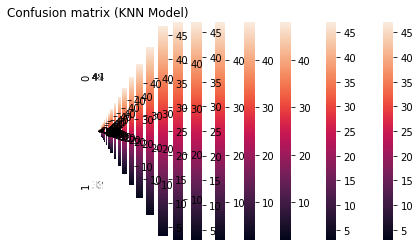

In [7]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization

    study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
    with parallel_backend('threading'):
        study_knn.optimize(objective_knn, n_trials=10, n_jobs=-1)
    
    # Evaluating our Optuna Trial
    print("Best trial:", study_knn.best_trial.number)
    print("Best accuracy:", study_knn.best_trial.value)
    print("Best hyperparameters:", study_knn.best_params)
    
    best_param_knn = study_knn.best_params
    KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
    y_pred_knn = KNN.predict(x_test_)

    

    display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(KNN, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [8]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.044548,0.110952,0.002310,0.014429,0.127810,0.028500,0.025214,0.061286,0
1,0.057179,0.070940,0.001750,0.007750,0.162107,0.008321,0.030036,0.057560,0
2,0.056643,0.102571,0.015619,0.020619,0.184667,0.021762,0.031548,0.011333,0
3,0.044190,0.076857,0.023190,0.028024,0.204000,0.004976,0.005286,0.040095,0
4,0.003679,0.096750,0.017512,0.011226,0.166417,0.014298,0.004440,0.053036,0
...,...,...,...,...,...,...,...,...,...
4995,0.177012,0.158298,0.047798,0.147012,0.089321,0.081750,0.070083,0.167536,1
4996,0.066000,0.086071,0.001762,0.109952,0.153952,0.128619,0.006810,0.002500,1
4997,0.176095,0.230405,0.016000,0.258619,0.069905,0.009310,0.022619,0.242905,1
4998,0.004262,0.094238,0.002714,0.080119,0.347690,0.012071,0.023405,0.064024,1


# value stabilty

In [9]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]

In [10]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('50_knn_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.168165,0.063987,0.689736,0.337444,0.182849,0.430110,0.216597,0.105424,0.274289
1,0.109831,0.189536,0.791486,0.765807,0.105331,0.370924,0.183456,0.124778,0.330144
2,0.131747,0.121230,0.520249,0.307944,0.113821,0.433951,0.223652,0.404918,0.282189
3,0.190645,0.218376,0.323024,0.180206,0.155209,0.627060,0.659396,0.262287,0.327025
4,0.431133,0.051771,0.308286,0.372046,0.082347,0.445869,0.404170,0.128849,0.278059
...,...,...,...,...,...,...,...,...,...
95,0.222236,0.380180,0.897688,0.371971,0.470848,0.385040,0.556793,0.337349,0.452763
96,0.178506,0.550827,2.284682,0.209491,0.243307,0.379613,1.673594,2.386989,0.988376
97,0.235814,0.315829,0.798843,0.188421,0.157661,1.143600,0.850673,0.174749,0.483199
98,0.479353,0.368367,0.580727,0.188684,0.060019,0.482376,0.567451,0.123889,0.356358


In [11]:
valuestability

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.168165,0.063987,0.689736,0.337444,0.182849,0.430110,0.216597,0.105424,0.274289
1,0.109831,0.189536,0.791486,0.765807,0.105331,0.370924,0.183456,0.124778,0.330144
2,0.131747,0.121230,0.520249,0.307944,0.113821,0.433951,0.223652,0.404918,0.282189
3,0.190645,0.218376,0.323024,0.180206,0.155209,0.627060,0.659396,0.262287,0.327025
4,0.431133,0.051771,0.308286,0.372046,0.082347,0.445869,0.404170,0.128849,0.278059
...,...,...,...,...,...,...,...,...,...
95,0.222236,0.380180,0.897688,0.371971,0.470848,0.385040,0.556793,0.337349,0.452763
96,0.178506,0.550827,2.284682,0.209491,0.243307,0.379613,1.673594,2.386989,0.988376
97,0.235814,0.315829,0.798843,0.188421,0.157661,1.143600,0.850673,0.174749,0.483199
98,0.479353,0.368367,0.580727,0.188684,0.060019,0.482376,0.567451,0.123889,0.356358


## 4.3 Logistic Regression

In [12]:
df = pd.read_csv("data_resampled_50.csv")

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [14]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization
    
    # Creating and running our optimization

    study_lr = optuna.create_study(direction='maximize',study_name = "logr")
    with parallel_backend('threading'):
        study_lr.optimize(objective_lr, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_lr.best_trial.number)
    print("Best accuracy:", study_lr.best_trial.value)
    print("Best hyperparameters:", study_lr.best_params)

    # Train the model with the best parameters
    best_param_logr = study_lr.best_params
    LR = LogisticRegression(**best_param_logr, random_state=42).fit(x_train, y_train)


    
    # SHAP value computation using KernelExplainer
    explainer = shap.Explainer(LR, x_train_)
    shap_values = explainer(x_test_)


    # Extract SHAP values
    shap_values_array = abs(shap_values.values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)





[I 2024-08-26 13:56:41,621] A new study created in memory with name: logr
[I 2024-08-26 13:56:42,104] Trial 4 finished with value: 0.6985803270843378 and parameters: {'C': 0.004448320435072966, 'solver': 'liblinear', 'max_iter': 893}. Best is trial 4 with value: 0.6985803270843378.
[I 2024-08-26 13:56:43,181] Trial 1 finished with value: 0.6952064455706969 and parameters: {'C': 0.5866891000361361, 'solver': 'saga', 'max_iter': 131}. Best is trial 4 with value: 0.6985803270843378.
[I 2024-08-26 13:56:44,709] Trial 3 finished with value: 0.710034039319386 and parameters: {'C': 0.04253127111351083, 'solver': 'sag', 'max_iter': 681}. Best is trial 3 with value: 0.710034039319386.
[I 2024-08-26 13:56:45,149] Trial 7 finished with value: 0.6955082906923074 and parameters: {'C': 0.007462609553918671, 'solver': 'sag', 'max_iter': 111}. Best is trial 3 with value: 0.710034039319386.
[I 2024-08-26 13:56:45,246] Trial 6 finished with value: 0.698889725530559 and parameters: {'C': 0.06546309722819

Best trial: 9
Best accuracy: 0.7877772934823554
Best hyperparameters: {'C': 0.0026450196412010902, 'solver': 'lbfgs', 'max_iter': 867}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.012969  0.016055       0.000505       0.008237  0.001623  0.046117   
1      0.053449  0.006446       0.001569       0.096895  0.001477  0.014067   
2      0.053449  0.016055       0.008803       0.055521  0.009072  0.085118   
3      0.016420  0.005875       0.004742       0.049574  0.001743  0.029924   
4      0.047751  0.026733       0.006210       0.008237  0.012017  0.036923   
..          ...       ...            ...            ...       ...       ...   
95     0.148951  0.026655       0.005199       0.025969  0.000693  0.029113   
96     0.053449  0.052282       0.000013       0.068599  0.000383  0.081225   
97     0.073689  0.074705       0.002088       0.086330  0.006738  0.009338   
98     0.007271  0.027723       0.002088       0.020058  0.010124  0.044995

[I 2024-08-26 13:56:50,232] Trial 5 finished with value: 0.7012711281665035 and parameters: {'C': 0.0010996015857258031, 'solver': 'saga', 'max_iter': 613}. Best is trial 5 with value: 0.7012711281665035.
[I 2024-08-26 13:56:50,851] Trial 6 finished with value: 0.7670769090427957 and parameters: {'C': 0.15599414198048883, 'solver': 'liblinear', 'max_iter': 589}. Best is trial 6 with value: 0.7670769090427957.
[I 2024-08-26 13:56:51,584] Trial 3 finished with value: 0.7108264471616534 and parameters: {'C': 0.009256050603759709, 'solver': 'sag', 'max_iter': 600}. Best is trial 6 with value: 0.7670769090427957.
[I 2024-08-26 13:56:52,083] Trial 7 finished with value: 0.6996581261994218 and parameters: {'C': 0.002297232387897927, 'solver': 'sag', 'max_iter': 145}. Best is trial 6 with value: 0.7670769090427957.
[I 2024-08-26 13:56:52,131] Trial 1 finished with value: 0.7131022474385819 and parameters: {'C': 0.20370114802764325, 'solver': 'sag', 'max_iter': 758}. Best is trial 6 with value:

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.1902808620668481, 'solver': 'lbfgs', 'max_iter': 888}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020978  0.016358       0.000692       0.008354  0.001580  0.049164   
1      0.086457  0.006567       0.002151       0.098272  0.001439  0.014996   
2      0.086457  0.016358       0.012063       0.056310  0.008835  0.090740   
3      0.026561  0.005985       0.006499       0.050279  0.001697  0.031901   
4      0.077240  0.027237       0.008510       0.008354  0.011703  0.039362   
..          ...       ...            ...            ...       ...       ...   
95     0.240936  0.027157       0.007125       0.026338  0.000675  0.031036   
96     0.086457  0.053267       0.000018       0.069574  0.000373  0.086590   
97     0.119196  0.076112       0.002861       0.087558  0.006562  0.009955   
98     0.011761  0.028245       0.002861       0.020343  0.009859  0.047967   


[I 2024-08-26 13:56:57,758] Trial 5 finished with value: 0.6995929029391551 and parameters: {'C': 0.0011122040132429578, 'solver': 'liblinear', 'max_iter': 870}. Best is trial 5 with value: 0.6995929029391551.
[I 2024-08-26 13:57:00,324] Trial 0 finished with value: 0.7131022474385819 and parameters: {'C': 0.2971869605038003, 'solver': 'sag', 'max_iter': 750}. Best is trial 0 with value: 0.7131022474385819.
[I 2024-08-26 13:57:01,832] Trial 7 finished with value: 0.6955918797443664 and parameters: {'C': 2.080355638074678, 'solver': 'saga', 'max_iter': 169}. Best is trial 0 with value: 0.7131022474385819.
[I 2024-08-26 13:57:07,036] Trial 2 finished with value: 0.7871674429529694 and parameters: {'C': 0.0011194402021547324, 'solver': 'lbfgs', 'max_iter': 791}. Best is trial 2 with value: 0.7871674429529694.
[I 2024-08-26 13:57:08,817] Trial 1 finished with value: 0.7945031356814864 and parameters: {'C': 7.79710847280032, 'solver': 'lbfgs', 'max_iter': 471}. Best is trial 1 with value: 0

Best trial: 1
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 7.79710847280032, 'solver': 'lbfgs', 'max_iter': 471}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021114  0.016386       0.000678       0.008350  0.001581  0.048875   
1      0.087017  0.006578       0.002106       0.098223  0.001439  0.014908   
2      0.087017  0.016386       0.011816       0.056282  0.008836  0.090208   
3      0.026733  0.005996       0.006366       0.050254  0.001697  0.031713   
4      0.077740  0.027284       0.008335       0.008350  0.011705  0.039130   
..          ...       ...            ...            ...       ...       ...   
95     0.242497  0.027204       0.006979       0.026325  0.000675  0.030854   
96     0.087017  0.053358       0.000018       0.069540  0.000373  0.086082   
97     0.119968  0.076243       0.002803       0.087514  0.006563  0.009896   
98     0.011837  0.028294       0.002803       0.020333  0.009861  0.047686   
9

[I 2024-08-26 13:57:13,603] Trial 0 finished with value: 0.7885573576273822 and parameters: {'C': 1.0588832975836022, 'solver': 'liblinear', 'max_iter': 547}. Best is trial 0 with value: 0.7885573576273822.
[I 2024-08-26 13:57:13,988] Trial 3 finished with value: 0.6955918797443664 and parameters: {'C': 0.025928652266053124, 'solver': 'sag', 'max_iter': 107}. Best is trial 0 with value: 0.7885573576273822.
[I 2024-08-26 13:57:14,484] Trial 2 finished with value: 0.6951310893769691 and parameters: {'C': 0.34385988437828097, 'solver': 'saga', 'max_iter': 205}. Best is trial 0 with value: 0.7885573576273822.
[I 2024-08-26 13:57:14,688] Trial 7 finished with value: 0.7463097634818558 and parameters: {'C': 0.0685027890439414, 'solver': 'liblinear', 'max_iter': 549}. Best is trial 0 with value: 0.7885573576273822.
[I 2024-08-26 13:57:15,339] Trial 9 finished with value: 0.7562489802285401 and parameters: {'C': 0.10347702683621293, 'solver': 'liblinear', 'max_iter': 647}. Best is trial 0 with

Best trial: 4
Best accuracy: 0.7943897844602273
Best hyperparameters: {'C': 0.3649350098669191, 'solver': 'lbfgs', 'max_iter': 740}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020724  0.016323       0.000717       0.008371  0.001582  0.049716   
1      0.085411  0.006553       0.002226       0.098464  0.001440  0.015165   
2      0.085411  0.016323       0.012488       0.056421  0.008844  0.091759   
3      0.026240  0.005973       0.006728       0.050377  0.001699  0.032259   
4      0.076305  0.027179       0.008810       0.008371  0.011715  0.039803   
..          ...       ...            ...            ...       ...       ...   
95     0.238022  0.027100       0.007376       0.026389  0.000675  0.031385   
96     0.085411  0.053154       0.000019       0.069710  0.000373  0.087563   
97     0.117754  0.075951       0.002962       0.087729  0.006569  0.010067   
98     0.011619  0.028185       0.002962       0.020383  0.009870  0.048506   

[I 2024-08-26 13:57:19,841] Trial 1 finished with value: 0.6985803270843378 and parameters: {'C': 0.0041909812567645895, 'solver': 'liblinear', 'max_iter': 604}. Best is trial 1 with value: 0.6985803270843378.
[I 2024-08-26 13:57:19,939] Trial 0 finished with value: 0.7899663258941366 and parameters: {'C': 2.032885556337808, 'solver': 'liblinear', 'max_iter': 854}. Best is trial 0 with value: 0.7899663258941366.
[I 2024-08-26 13:57:19,970] Trial 4 finished with value: 0.7919725832569625 and parameters: {'C': 5.707250526846969, 'solver': 'liblinear', 'max_iter': 750}. Best is trial 4 with value: 0.7919725832569625.
[I 2024-08-26 13:57:22,329] Trial 6 finished with value: 0.7038389742758003 and parameters: {'C': 0.15458099147710902, 'solver': 'sag', 'max_iter': 467}. Best is trial 4 with value: 0.7919725832569625.
[I 2024-08-26 13:57:25,512] Trial 9 finished with value: 0.7098025000851872 and parameters: {'C': 1.8049844467686558, 'solver': 'sag', 'max_iter': 670}. Best is trial 4 with va

Best trial: 4
Best accuracy: 0.7919725832569625
Best hyperparameters: {'C': 5.707250526846969, 'solver': 'liblinear', 'max_iter': 750}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020319  0.014806       0.001883       0.007494  0.001488  0.039487   
1      0.083739  0.005944       0.005850       0.088155  0.001354  0.012044   
2      0.083739  0.014806       0.032817       0.050513  0.008318  0.072879   
3      0.025726  0.005417       0.017680       0.045103  0.001598  0.025621   
4      0.074812  0.024652       0.023150       0.007494  0.011018  0.031614   
..          ...       ...            ...            ...       ...       ...   
95     0.233362  0.024580       0.019384       0.023626  0.000635  0.024927   
96     0.083739  0.048212       0.000050       0.062412  0.000351  0.069546   
97     0.115449  0.068890       0.007784       0.078544  0.006178  0.007995   
98     0.011391  0.025565       0.007784       0.018249  0.009282  0.038526

[I 2024-08-26 13:57:32,172] Trial 0 finished with value: 0.7868757762221474 and parameters: {'C': 0.898230534183641, 'solver': 'liblinear', 'max_iter': 961}. Best is trial 0 with value: 0.7868757762221474.
[I 2024-08-26 13:57:32,880] Trial 5 finished with value: 0.6962214544488995 and parameters: {'C': 1.1799727893135386, 'solver': 'sag', 'max_iter': 200}. Best is trial 0 with value: 0.7868757762221474.
[I 2024-08-26 13:57:33,441] Trial 4 finished with value: 0.707733595149136 and parameters: {'C': 0.002722922917762332, 'solver': 'sag', 'max_iter': 410}. Best is trial 0 with value: 0.7868757762221474.
[I 2024-08-26 13:57:36,490] Trial 8 finished with value: 0.6984952438307989 and parameters: {'C': 0.03280548078609386, 'solver': 'saga', 'max_iter': 552}. Best is trial 0 with value: 0.7868757762221474.
[I 2024-08-26 13:57:37,826] Trial 9 finished with value: 0.6954904269287355 and parameters: {'C': 0.027588061085441398, 'solver': 'saga', 'max_iter': 75}. Best is trial 0 with value: 0.786

Best trial: 6
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.9501771117840105, 'solver': 'lbfgs', 'max_iter': 274}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021082  0.016379       0.000684       0.008351  0.001580  0.048956   
1      0.086886  0.006575       0.002125       0.098230  0.001439  0.014933   
2      0.086886  0.016379       0.011920       0.056286  0.008835  0.090358   
3      0.026693  0.005993       0.006422       0.050257  0.001697  0.031766   
4      0.077623  0.027271       0.008409       0.008351  0.011702  0.039195   
..          ...       ...            ...            ...       ...       ...   
95     0.242132  0.027192       0.007041       0.026327  0.000675  0.030905   
96     0.086886  0.053334       0.000018       0.069544  0.000373  0.086225   
97     0.119787  0.076209       0.002827       0.087520  0.006561  0.009913   
98     0.011819  0.028281       0.002827       0.020335  0.009859  0.047765   

[I 2024-08-26 13:57:45,930] Trial 4 finished with value: 0.696517317745646 and parameters: {'C': 1.4004563118451758, 'solver': 'saga', 'max_iter': 355}. Best is trial 4 with value: 0.696517317745646.
[I 2024-08-26 13:57:46,930] Trial 6 finished with value: 0.694913789788899 and parameters: {'C': 4.074645629956797, 'solver': 'saga', 'max_iter': 60}. Best is trial 4 with value: 0.696517317745646.
[I 2024-08-26 13:57:47,006] Trial 0 finished with value: 0.698889725530559 and parameters: {'C': 1.1247251037346804, 'solver': 'saga', 'max_iter': 601}. Best is trial 0 with value: 0.698889725530559.
[I 2024-08-26 13:57:47,831] Trial 1 finished with value: 0.720645108098773 and parameters: {'C': 0.008234857805722081, 'solver': 'sag', 'max_iter': 899}. Best is trial 1 with value: 0.720645108098773.
[I 2024-08-26 13:57:53,067] Trial 2 finished with value: 0.7873415984750025 and parameters: {'C': 0.0016453135567703234, 'solver': 'lbfgs', 'max_iter': 224}. Best is trial 2 with value: 0.7873415984750

Best trial: 5
Best accuracy: 0.7932917698806744
Best hyperparameters: {'C': 0.21048536211486263, 'solver': 'newton-cg', 'max_iter': 595}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020547  0.016315       0.000734       0.008382  0.001584  0.050157   
1      0.084682  0.006550       0.002281       0.098600  0.001442  0.015299   
2      0.084682  0.016315       0.012796       0.056498  0.008857  0.092573   
3      0.026016  0.005970       0.006894       0.050447  0.001701  0.032545   
4      0.075654  0.027165       0.009027       0.008382  0.011732  0.040156   
..          ...       ...            ...            ...       ...       ...   
95     0.235990  0.027086       0.007558       0.026426  0.000676  0.031663   
96     0.084682  0.053127       0.000020       0.069806  0.000374  0.088339   
97     0.116749  0.075912       0.003035       0.087850  0.006578  0.010156   
98     0.011520  0.028171       0.003035       0.020411  0.009884  0.0489

[I 2024-08-26 13:58:00,453] Trial 5 finished with value: 0.7919725832569625 and parameters: {'C': 5.47236365961012, 'solver': 'liblinear', 'max_iter': 528}. Best is trial 5 with value: 0.7919725832569625.
[I 2024-08-26 13:58:02,406] Trial 3 finished with value: 0.6984952438307989 and parameters: {'C': 5.02836976269353, 'solver': 'saga', 'max_iter': 512}. Best is trial 5 with value: 0.7919725832569625.
[I 2024-08-26 13:58:04,067] Trial 7 finished with value: 0.6966043852520432 and parameters: {'C': 0.08795300802781161, 'solver': 'sag', 'max_iter': 223}. Best is trial 5 with value: 0.7919725832569625.
[I 2024-08-26 13:58:05,196] Trial 1 finished with value: 0.7364839176858822 and parameters: {'C': 0.09533957924417, 'solver': 'lbfgs', 'max_iter': 60}. Best is trial 5 with value: 0.7919725832569625.
[I 2024-08-26 13:58:06,069] Trial 9 finished with value: 0.6973007054700896 and parameters: {'C': 0.003827800858648043, 'solver': 'liblinear', 'max_iter': 442}. Best is trial 5 with value: 0.79

Best trial: 5
Best accuracy: 0.7919725832569625
Best hyperparameters: {'C': 5.47236365961012, 'solver': 'liblinear', 'max_iter': 528}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020344  0.014715       0.001962       0.007448  0.001483  0.039028   
1      0.083843  0.005907       0.006095       0.087607  0.001350  0.011905   
2      0.083843  0.014715       0.034191       0.050199  0.008290  0.072034   
3      0.025758  0.005384       0.018420       0.044822  0.001592  0.025324   
4      0.074904  0.024501       0.024119       0.007448  0.010981  0.031247   
..          ...       ...            ...            ...       ...       ...   
95     0.233651  0.024429       0.020195       0.023479  0.000633  0.024638   
96     0.083843  0.047916       0.000052       0.062023  0.000350  0.068739   
97     0.115592  0.068467       0.008110       0.078055  0.006157  0.007903   
98     0.011406  0.025408       0.008110       0.018136  0.009251  0.038078 

[I 2024-08-26 13:58:14,572] Trial 1 finished with value: 0.6993651555376387 and parameters: {'C': 0.0010795907105912636, 'solver': 'liblinear', 'max_iter': 386}. Best is trial 1 with value: 0.6993651555376387.
[I 2024-08-26 13:58:14,681] Trial 3 finished with value: 0.7703604158859991 and parameters: {'C': 0.2819512557284619, 'solver': 'liblinear', 'max_iter': 283}. Best is trial 3 with value: 0.7703604158859991.
[I 2024-08-26 13:58:16,426] Trial 4 finished with value: 0.6993015729533179 and parameters: {'C': 0.0045856221718767265, 'solver': 'saga', 'max_iter': 459}. Best is trial 3 with value: 0.7703604158859991.
[I 2024-08-26 13:58:18,034] Trial 2 finished with value: 0.7167640027591395 and parameters: {'C': 0.10413762240501882, 'solver': 'sag', 'max_iter': 949}. Best is trial 3 with value: 0.7703604158859991.
[I 2024-08-26 13:58:18,581] Trial 8 finished with value: 0.7008603584965389 and parameters: {'C': 0.001616785467501954, 'solver': 'saga', 'max_iter': 974}. Best is trial 3 with

Best trial: 9
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 7.649776781898771, 'solver': 'newton-cg', 'max_iter': 336}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021119  0.016387       0.000680       0.008352  0.001580  0.048895   
1      0.087037  0.006579       0.002112       0.098239  0.001438  0.014914   
2      0.087037  0.016387       0.011848       0.056291  0.008834  0.090245   
3      0.026739  0.005996       0.006383       0.050262  0.001697  0.031726   
4      0.077758  0.027285       0.008358       0.008352  0.011702  0.039146   
..          ...       ...            ...            ...       ...       ...   
95     0.242554  0.027206       0.006998       0.026329  0.000675  0.030867   
96     0.087037  0.053362       0.000018       0.069551  0.000373  0.086117   
97     0.119997  0.076248       0.002810       0.087528  0.006561  0.009901   
98     0.011840  0.028296       0.002810       0.020336  0.009859  0.047705

[I 2024-08-26 13:58:27,650] Trial 5 finished with value: 0.6980001371272541 and parameters: {'C': 0.002387251137993685, 'solver': 'liblinear', 'max_iter': 993}. Best is trial 5 with value: 0.6980001371272541.
[I 2024-08-26 13:58:27,673] Trial 3 finished with value: 0.6996967899263593 and parameters: {'C': 0.0015590288947168066, 'solver': 'liblinear', 'max_iter': 308}. Best is trial 3 with value: 0.6996967899263593.
[I 2024-08-26 13:58:27,677] Trial 0 finished with value: 0.7249861102582608 and parameters: {'C': 0.03156394832977872, 'solver': 'liblinear', 'max_iter': 904}. Best is trial 0 with value: 0.7249861102582608.
[I 2024-08-26 13:58:27,748] Trial 2 finished with value: 0.7922942933355951 and parameters: {'C': 6.295942892023527, 'solver': 'liblinear', 'max_iter': 548}. Best is trial 2 with value: 0.7922942933355951.
[I 2024-08-26 13:58:28,383] Trial 7 finished with value: 0.713398769396527 and parameters: {'C': 0.020663693714440882, 'solver': 'liblinear', 'max_iter': 465}. Best is

Best trial: 2
Best accuracy: 0.7922942933355951
Best hyperparameters: {'C': 6.295942892023527, 'solver': 'liblinear', 'max_iter': 548}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020427  0.014952       0.001770       0.007574  0.001496  0.040404   
1      0.084187  0.006002       0.005498       0.089098  0.001362  0.012324   
2      0.084187  0.014952       0.030841       0.051054  0.008363  0.074572   
3      0.025864  0.005471       0.016615       0.045586  0.001606  0.026216   
4      0.075212  0.024895       0.021757       0.007574  0.011078  0.032348   
..          ...       ...            ...            ...       ...       ...   
95     0.234611  0.024823       0.018217       0.023879  0.000639  0.025506   
96     0.084187  0.048688       0.000047       0.063080  0.000353  0.071162   
97     0.116067  0.069569       0.007315       0.079384  0.006211  0.008181   
98     0.011452  0.025817       0.007315       0.018444  0.009333  0.039420

[I 2024-08-26 13:58:33,361] Trial 4 finished with value: 0.6994749449010014 and parameters: {'C': 0.001158729576077937, 'solver': 'liblinear', 'max_iter': 465}. Best is trial 4 with value: 0.6994749449010014.
[I 2024-08-26 13:58:33,506] Trial 1 finished with value: 0.7926089204831741 and parameters: {'C': 8.015405759908289, 'solver': 'liblinear', 'max_iter': 750}. Best is trial 1 with value: 0.7926089204831741.
[I 2024-08-26 13:58:34,122] Trial 7 finished with value: 0.7034986394720907 and parameters: {'C': 0.008559443428168006, 'solver': 'liblinear', 'max_iter': 329}. Best is trial 1 with value: 0.7926089204831741.
[I 2024-08-26 13:58:35,954] Trial 2 finished with value: 0.7058751406296063 and parameters: {'C': 3.442206119782436, 'solver': 'sag', 'max_iter': 582}. Best is trial 1 with value: 0.7926089204831741.
[I 2024-08-26 13:58:36,027] Trial 0 finished with value: 0.7058751406296063 and parameters: {'C': 2.911452389664037, 'solver': 'sag', 'max_iter': 575}. Best is trial 1 with val

Best trial: 9
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.3271537483188192, 'solver': 'newton-cg', 'max_iter': 133}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020993  0.016362       0.000691       0.008354  0.001580  0.049131   
1      0.086517  0.006569       0.002147       0.098273  0.001439  0.014986   
2      0.086517  0.016362       0.012042       0.056311  0.008835  0.090679   
3      0.026580  0.005987       0.006487       0.050279  0.001697  0.031879   
4      0.077294  0.027243       0.008495       0.008354  0.011703  0.039335   
..          ...       ...            ...            ...       ...       ...   
95     0.241104  0.027164       0.007113       0.026338  0.000675  0.031015   
96     0.086517  0.053279       0.000018       0.069575  0.000373  0.086532   
97     0.119279  0.076130       0.002856       0.087558  0.006562  0.009948   
98     0.011769  0.028252       0.002856       0.020343  0.009859  0.047935

[I 2024-08-26 13:58:42,828] Trial 1 finished with value: 0.6996967899263593 and parameters: {'C': 0.0015330221066932781, 'solver': 'liblinear', 'max_iter': 463}. Best is trial 1 with value: 0.6996967899263593.
[I 2024-08-26 13:58:42,883] Trial 0 finished with value: 0.6979097338015136 and parameters: {'C': 0.001960007917392973, 'solver': 'liblinear', 'max_iter': 591}. Best is trial 1 with value: 0.6996967899263593.
[I 2024-08-26 13:58:43,707] Trial 7 finished with value: 0.7919725832569625 and parameters: {'C': 4.981878242653897, 'solver': 'liblinear', 'max_iter': 112}. Best is trial 7 with value: 0.7919725832569625.
[I 2024-08-26 13:58:44,286] Trial 5 finished with value: 0.6975766227894202 and parameters: {'C': 0.004287255348450446, 'solver': 'saga', 'max_iter': 359}. Best is trial 7 with value: 0.7919725832569625.
[I 2024-08-26 13:58:44,346] Trial 6 finished with value: 0.696517317745646 and parameters: {'C': 0.26631501390316126, 'solver': 'sag', 'max_iter': 185}. Best is trial 7 wi

Best trial: 8
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.7181893131636246, 'solver': 'lbfgs', 'max_iter': 413}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021069  0.016378       0.000687       0.008356  0.001580  0.048977   
1      0.086832  0.006575       0.002135       0.098294  0.001438  0.014939   
2      0.086832  0.016378       0.011978       0.056323  0.008834  0.090395   
3      0.026676  0.005993       0.006453       0.050291  0.001697  0.031779   
4      0.077575  0.027270       0.008450       0.008356  0.011701  0.039212   
..          ...       ...            ...            ...       ...       ...   
95     0.241981  0.027191       0.007075       0.026344  0.000675  0.030918   
96     0.086832  0.053332       0.000018       0.069590  0.000373  0.086261   
97     0.119713  0.076206       0.002841       0.087578  0.006561  0.009917   
98     0.011812  0.028280       0.002841       0.020348  0.009858  0.047785   

[I 2024-08-26 13:58:56,132] Trial 0 finished with value: 0.7141229287274014 and parameters: {'C': 0.004702353175504421, 'solver': 'sag', 'max_iter': 696}. Best is trial 0 with value: 0.7141229287274014.
[I 2024-08-26 13:58:56,487] Trial 2 finished with value: 0.7124315288749554 and parameters: {'C': 3.8218324748384864, 'solver': 'sag', 'max_iter': 778}. Best is trial 0 with value: 0.7141229287274014.
[I 2024-08-26 13:58:56,528] Trial 1 finished with value: 0.7014831994438149 and parameters: {'C': 0.07176637989461818, 'solver': 'saga', 'max_iter': 698}. Best is trial 0 with value: 0.7141229287274014.
[I 2024-08-26 13:58:57,336] Trial 7 finished with value: 0.7065118762038733 and parameters: {'C': 0.012080700956042174, 'solver': 'liblinear', 'max_iter': 333}. Best is trial 0 with value: 0.7141229287274014.
[I 2024-08-26 13:58:58,487] Trial 8 finished with value: 0.6962689007416222 and parameters: {'C': 0.01392559197330776, 'solver': 'saga', 'max_iter': 296}. Best is trial 0 with value: 0

Best trial: 6
Best accuracy: 0.7920390314910644
Best hyperparameters: {'C': 0.1186586469518115, 'solver': 'lbfgs', 'max_iter': 663}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020335  0.016323       0.000755       0.008404  0.001588  0.050701   
1      0.083804  0.006553       0.002346       0.098859  0.001446  0.015465   
2      0.083804  0.016323       0.013162       0.056647  0.008878  0.093578   
3      0.025746  0.005972       0.007091       0.050579  0.001705  0.032898   
4      0.074870  0.027178       0.009285       0.008404  0.011760  0.040592   
..          ...       ...            ...            ...       ...       ...   
95     0.233545  0.027099       0.007774       0.026495  0.000678  0.032007   
96     0.083804  0.053151       0.000020       0.069990  0.000375  0.089298   
97     0.115539  0.075947       0.003122       0.088081  0.006594  0.010266   
98     0.011400  0.028184       0.003122       0.020465  0.009907  0.049467   

[I 2024-08-26 13:59:08,544] Trial 2 finished with value: 0.7008956602800336 and parameters: {'C': 0.026831249227710893, 'solver': 'sag', 'max_iter': 318}. Best is trial 2 with value: 0.7008956602800336.
[I 2024-08-26 13:59:10,047] Trial 6 finished with value: 0.6952064455706969 and parameters: {'C': 4.41432285522272, 'solver': 'saga', 'max_iter': 129}. Best is trial 2 with value: 0.7008956602800336.
[I 2024-08-26 13:59:18,439] Trial 4 finished with value: 0.7867069456063924 and parameters: {'C': 0.0014348184261753988, 'solver': 'lbfgs', 'max_iter': 705}. Best is trial 4 with value: 0.7867069456063924.
[I 2024-08-26 13:59:18,858] Trial 5 finished with value: 0.7873047613642938 and parameters: {'C': 0.0018768278762060348, 'solver': 'lbfgs', 'max_iter': 500}. Best is trial 5 with value: 0.7873047613642938.
[I 2024-08-26 13:59:19,289] Trial 1 finished with value: 0.7864599733338351 and parameters: {'C': 0.003527408732538761, 'solver': 'lbfgs', 'max_iter': 922}. Best is trial 5 with value: 

Best trial: 3
Best accuracy: 0.7891262503364836
Best hyperparameters: {'C': 0.03860210409674618, 'solver': 'lbfgs', 'max_iter': 601}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019679  0.016337       0.000774       0.008441  0.001597  0.051357   
1      0.081102  0.006559       0.002404       0.099297  0.001454  0.015665   
2      0.081102  0.016337       0.013484       0.056898  0.008928  0.094789   
3      0.024916  0.005978       0.007264       0.050803  0.001715  0.033324   
4      0.072456  0.027203       0.009512       0.008441  0.011826  0.041118   
..          ...       ...            ...            ...       ...       ...   
95     0.226015  0.027123       0.007964       0.026612  0.000682  0.032421   
96     0.081102  0.053200       0.000021       0.070300  0.000377  0.090454   
97     0.111814  0.076017       0.003198       0.088471  0.006631  0.010399   
98     0.011033  0.028210       0.003198       0.020555  0.009963  0.050107  

[I 2024-08-26 13:59:25,102] Trial 5 finished with value: 0.6985803270843378 and parameters: {'C': 0.004468381736643376, 'solver': 'liblinear', 'max_iter': 448}. Best is trial 5 with value: 0.6985803270843378.
[I 2024-08-26 13:59:25,128] Trial 2 finished with value: 0.7922942933355951 and parameters: {'C': 6.463718030867787, 'solver': 'liblinear', 'max_iter': 774}. Best is trial 2 with value: 0.7922942933355951.
[I 2024-08-26 13:59:25,146] Trial 4 finished with value: 0.7827370611444162 and parameters: {'C': 0.6586552368541201, 'solver': 'liblinear', 'max_iter': 834}. Best is trial 2 with value: 0.7922942933355951.
[I 2024-08-26 13:59:25,354] Trial 0 finished with value: 0.6945982504932249 and parameters: {'C': 2.103052450128172, 'solver': 'sag', 'max_iter': 60}. Best is trial 2 with value: 0.7922942933355951.
[I 2024-08-26 13:59:26,881] Trial 7 finished with value: 0.6958937248659768 and parameters: {'C': 0.00900768658292199, 'solver': 'saga', 'max_iter': 215}. Best is trial 2 with val

Best trial: 1
Best accuracy: 0.7923590419403852
Best hyperparameters: {'C': 0.11322473940502024, 'solver': 'lbfgs', 'max_iter': 248}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020309  0.016316       0.000753       0.008403  0.001588  0.050707   
1      0.083698  0.006550       0.002339       0.098840  0.001446  0.015467   
2      0.083698  0.016316       0.013118       0.056636  0.008879  0.093588   
3      0.025713  0.005970       0.007067       0.050570  0.001705  0.032902   
4      0.074775  0.027166       0.009254       0.008403  0.011761  0.040597   
..          ...       ...            ...            ...       ...       ...   
95     0.233248  0.027087       0.007748       0.026490  0.000678  0.032010   
96     0.083698  0.053129       0.000020       0.069977  0.000375  0.089308   
97     0.115392  0.075915       0.003111       0.088064  0.006594  0.010267   
98     0.011386  0.028172       0.003111       0.020461  0.009908  0.049473  

[I 2024-08-26 13:59:38,160] Trial 1 finished with value: 0.7704387630081161 and parameters: {'C': 0.28220363543328136, 'solver': 'liblinear', 'max_iter': 458}. Best is trial 1 with value: 0.7704387630081161.
[I 2024-08-26 13:59:39,096] Trial 6 finished with value: 0.7904010703172561 and parameters: {'C': 1.5286294484400438, 'solver': 'liblinear', 'max_iter': 712}. Best is trial 6 with value: 0.7904010703172561.
[I 2024-08-26 13:59:39,753] Trial 2 finished with value: 0.6962214544488995 and parameters: {'C': 1.8674793467797348, 'solver': 'saga', 'max_iter': 401}. Best is trial 6 with value: 0.7904010703172561.
[I 2024-08-26 13:59:40,590] Trial 8 finished with value: 0.7551873702128976 and parameters: {'C': 0.09733079173409868, 'solver': 'liblinear', 'max_iter': 316}. Best is trial 6 with value: 0.7904010703172561.
[I 2024-08-26 13:59:41,528] Trial 3 finished with value: 0.7167808161743332 and parameters: {'C': 0.4789991800303171, 'solver': 'sag', 'max_iter': 952}. Best is trial 6 with v

Best trial: 5
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.747441139917144, 'solver': 'lbfgs', 'max_iter': 427}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021029  0.016369       0.000689       0.008355  0.001580  0.049063   
1      0.086664  0.006571       0.002140       0.098277  0.001438  0.014966   
2      0.086664  0.016369       0.012002       0.056313  0.008833  0.090555   
3      0.026625  0.005989       0.006466       0.050281  0.001697  0.031835   
4      0.077425  0.027255       0.008467       0.008355  0.011701  0.039281   
..          ...       ...            ...            ...       ...       ...   
95     0.241515  0.027175       0.007089       0.026339  0.000675  0.030973   
96     0.086664  0.053302       0.000018       0.069577  0.000373  0.086414   
97     0.119482  0.076162       0.002847       0.087562  0.006560  0.009935   
98     0.011789  0.028264       0.002847       0.020344  0.009857  0.047869   


[I 2024-08-26 13:59:49,915] Trial 4 finished with value: 0.6981272095539113 and parameters: {'C': 0.0025354934581055346, 'solver': 'liblinear', 'max_iter': 174}. Best is trial 4 with value: 0.6981272095539113.
[I 2024-08-26 13:59:50,136] Trial 2 finished with value: 0.7865020459701563 and parameters: {'C': 0.9099856703157679, 'solver': 'liblinear', 'max_iter': 394}. Best is trial 2 with value: 0.7865020459701563.
[I 2024-08-26 13:59:51,311] Trial 1 finished with value: 0.6976722321571348 and parameters: {'C': 0.007908924447792651, 'solver': 'saga', 'max_iter': 323}. Best is trial 2 with value: 0.7865020459701563.
[I 2024-08-26 13:59:51,487] Trial 3 finished with value: 0.696517317745646 and parameters: {'C': 0.3178189443240558, 'solver': 'saga', 'max_iter': 364}. Best is trial 2 with value: 0.7865020459701563.
[I 2024-08-26 13:59:52,429] Trial 6 finished with value: 0.7078447513251582 and parameters: {'C': 0.004876782631743298, 'solver': 'sag', 'max_iter': 463}. Best is trial 2 with va

Best trial: 0
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 5.239186492038977, 'solver': 'lbfgs', 'max_iter': 457}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021104  0.016384       0.000681       0.008351  0.001580  0.048923   
1      0.086977  0.006577       0.002116       0.098228  0.001438  0.014923   
2      0.086977  0.016384       0.011867       0.056285  0.008834  0.090297   
3      0.026721  0.005995       0.006393       0.050257  0.001697  0.031745   
4      0.077704  0.027280       0.008372       0.008351  0.011702  0.039169   
..          ...       ...            ...            ...       ...       ...   
95     0.242386  0.027201       0.007010       0.026326  0.000675  0.030884   
96     0.086977  0.053352       0.000018       0.069543  0.000373  0.086167   
97     0.119913  0.076234       0.002815       0.087518  0.006561  0.009906   
98     0.011832  0.028290       0.002815       0.020334  0.009858  0.047733   


[I 2024-08-26 14:00:00,550] Trial 5 finished with value: 0.7081685293484408 and parameters: {'C': 0.014757824576888795, 'solver': 'liblinear', 'max_iter': 430}. Best is trial 5 with value: 0.7081685293484408.
[I 2024-08-26 14:00:01,599] Trial 0 finished with value: 0.6955295505749595 and parameters: {'C': 0.45842757105780485, 'solver': 'saga', 'max_iter': 232}. Best is trial 5 with value: 0.7081685293484408.
[I 2024-08-26 14:00:01,947] Trial 6 finished with value: 0.6955918797443664 and parameters: {'C': 0.01495044087225402, 'solver': 'saga', 'max_iter': 239}. Best is trial 5 with value: 0.7081685293484408.
[I 2024-08-26 14:00:02,718] Trial 3 finished with value: 0.7063572357645184 and parameters: {'C': 0.14184779536684736, 'solver': 'sag', 'max_iter': 527}. Best is trial 5 with value: 0.7081685293484408.
[I 2024-08-26 14:00:03,014] Trial 4 finished with value: 0.6984952438307989 and parameters: {'C': 2.6116922948584054, 'solver': 'saga', 'max_iter': 527}. Best is trial 5 with value: 0

Best trial: 1
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.119393555564128, 'solver': 'newton-cg', 'max_iter': 638}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021046  0.016372       0.000686       0.008353  0.001580  0.049027   
1      0.086738  0.006573       0.002132       0.098255  0.001439  0.014955   
2      0.086738  0.016372       0.011958       0.056301  0.008834  0.090489   
3      0.026647  0.005990       0.006442       0.050271  0.001697  0.031812   
4      0.077491  0.027260       0.008435       0.008353  0.011702  0.039252   
..          ...       ...            ...            ...       ...       ...   
95     0.241719  0.027181       0.007063       0.026333  0.000675  0.030950   
96     0.086738  0.053312       0.000018       0.069562  0.000373  0.086350   
97     0.119583  0.076177       0.002836       0.087543  0.006561  0.009927   
98     0.011799  0.028270       0.002836       0.020340  0.009859  0.047834

[I 2024-08-26 14:00:07,930] Trial 1 finished with value: 0.702715542543993 and parameters: {'C': 0.007907635762644277, 'solver': 'liblinear', 'max_iter': 525}. Best is trial 1 with value: 0.702715542543993.
[I 2024-08-26 14:00:10,205] Trial 0 finished with value: 0.7073640624787716 and parameters: {'C': 0.007227033986655888, 'solver': 'sag', 'max_iter': 472}. Best is trial 0 with value: 0.7073640624787716.
[I 2024-08-26 14:00:10,655] Trial 4 finished with value: 0.6984952438307989 and parameters: {'C': 0.6865412039194293, 'solver': 'saga', 'max_iter': 509}. Best is trial 0 with value: 0.7073640624787716.
[I 2024-08-26 14:00:11,331] Trial 8 finished with value: 0.7074187463345794 and parameters: {'C': 0.013314784753641947, 'solver': 'liblinear', 'max_iter': 308}. Best is trial 8 with value: 0.7074187463345794.
[I 2024-08-26 14:00:11,388] Trial 3 finished with value: 0.7025253462475937 and parameters: {'C': 0.004733847506576536, 'solver': 'saga', 'max_iter': 632}. Best is trial 8 with va

Best trial: 6
Best accuracy: 0.7876435625457764
Best hyperparameters: {'C': 0.0018312656297997374, 'solver': 'lbfgs', 'max_iter': 536}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.011219  0.015954       0.000393       0.008094  0.001629  0.044001   
1      0.046238  0.006405       0.001221       0.095215  0.001483  0.013421   
2      0.046238  0.015954       0.006847       0.054559  0.009108  0.081211   
3      0.014205  0.005838       0.003689       0.048715  0.001750  0.028550   
4      0.041309  0.026565       0.004830       0.008094  0.012065  0.035228   
..          ...       ...            ...            ...       ...       ...   
95     0.128856  0.026487       0.004044       0.025518  0.000696  0.027777   
96     0.046238  0.051953       0.000010       0.067410  0.000384  0.077497   
97     0.063748  0.074234       0.001624       0.084834  0.006764  0.008909   
98     0.006290  0.027548       0.001624       0.019710  0.010164  0.042930

[I 2024-08-26 14:00:16,344] Trial 0 finished with value: 0.7922942933355951 and parameters: {'C': 7.159233817128985, 'solver': 'liblinear', 'max_iter': 174}. Best is trial 0 with value: 0.7922942933355951.
[I 2024-08-26 14:00:16,554] Trial 2 finished with value: 0.6966338045742314 and parameters: {'C': 0.0019076788199058519, 'solver': 'saga', 'max_iter': 73}. Best is trial 0 with value: 0.7922942933355951.
[I 2024-08-26 14:00:16,621] Trial 5 finished with value: 0.6952971693469333 and parameters: {'C': 0.28959546101625694, 'solver': 'saga', 'max_iter': 78}. Best is trial 0 with value: 0.7922942933355951.
[I 2024-08-26 14:00:18,134] Trial 1 finished with value: 0.7102519408658603 and parameters: {'C': 0.0036156747145695235, 'solver': 'sag', 'max_iter': 722}. Best is trial 0 with value: 0.7922942933355951.
[I 2024-08-26 14:00:18,456] Trial 7 finished with value: 0.7061123534261872 and parameters: {'C': 0.002126230050068629, 'solver': 'sag', 'max_iter': 535}. Best is trial 0 with value: 0

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.976236564947739, 'solver': 'lbfgs', 'max_iter': 200}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021075  0.016377       0.000684       0.008352  0.001580  0.048973   
1      0.086857  0.006574       0.002126       0.098246  0.001438  0.014938   
2      0.086857  0.016377       0.011925       0.056296  0.008834  0.090388   
3      0.026684  0.005992       0.006424       0.050266  0.001697  0.031777   
4      0.077597  0.027268       0.008412       0.008352  0.011702  0.039209   
..          ...       ...            ...            ...       ...       ...   
95     0.242052  0.027188       0.007044       0.026331  0.000675  0.030916   
96     0.086857  0.053327       0.000018       0.069556  0.000373  0.086254   
97     0.119748  0.076199       0.002828       0.087535  0.006561  0.009916   
98     0.011816  0.028277       0.002828       0.020338  0.009858  0.047781   


[I 2024-08-26 14:00:29,782] Trial 5 finished with value: 0.6973007054700896 and parameters: {'C': 0.0038703301976675273, 'solver': 'liblinear', 'max_iter': 710}. Best is trial 5 with value: 0.6973007054700896.
[I 2024-08-26 14:00:29,992] Trial 2 finished with value: 0.6948840098236024 and parameters: {'C': 0.16673922790870943, 'solver': 'saga', 'max_iter': 54}. Best is trial 5 with value: 0.6973007054700896.
[I 2024-08-26 14:00:30,981] Trial 4 finished with value: 0.7057271806550481 and parameters: {'C': 0.0021662296809955525, 'solver': 'sag', 'max_iter': 947}. Best is trial 4 with value: 0.7057271806550481.
[I 2024-08-26 14:00:31,266] Trial 0 finished with value: 0.696517317745646 and parameters: {'C': 0.4003887600434217, 'solver': 'saga', 'max_iter': 361}. Best is trial 4 with value: 0.7057271806550481.
[I 2024-08-26 14:00:32,783] Trial 9 finished with value: 0.6951310893769691 and parameters: {'C': 0.47568660479039676, 'solver': 'saga', 'max_iter': 181}. Best is trial 4 with value: 

Best trial: 1
Best accuracy: 0.7940773632412477
Best hyperparameters: {'C': 0.2541947647476867, 'solver': 'newton-cg', 'max_iter': 103}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020611  0.016317       0.000728       0.008377  0.001583  0.050000   
1      0.084943  0.006551       0.002262       0.098535  0.001441  0.015251   
2      0.084943  0.016317       0.012689       0.056461  0.008852  0.092283   
3      0.026096  0.005970       0.006836       0.050414  0.001700  0.032443   
4      0.075887  0.027169       0.008951       0.008377  0.011725  0.040031   
..          ...       ...            ...            ...       ...       ...   
95     0.236717  0.027090       0.007495       0.026408  0.000676  0.031564   
96     0.084943  0.053134       0.000019       0.069760  0.000373  0.088063   
97     0.117109  0.075922       0.003010       0.087792  0.006574  0.010124   
98     0.011555  0.028175       0.003010       0.020398  0.009878  0.04878

[I 2024-08-26 14:00:41,352] Trial 3 finished with value: 0.771169913617872 and parameters: {'C': 0.249122103065543, 'solver': 'liblinear', 'max_iter': 130}. Best is trial 3 with value: 0.771169913617872.
[I 2024-08-26 14:00:41,376] Trial 5 finished with value: 0.7495557775573449 and parameters: {'C': 0.07579292382166343, 'solver': 'liblinear', 'max_iter': 485}. Best is trial 3 with value: 0.771169913617872.
[I 2024-08-26 14:00:41,775] Trial 2 finished with value: 0.7005473246867568 and parameters: {'C': 0.001049837658384056, 'solver': 'sag', 'max_iter': 125}. Best is trial 3 with value: 0.771169913617872.
[I 2024-08-26 14:00:43,217] Trial 8 finished with value: 0.7010204881935225 and parameters: {'C': 0.0012803685048612533, 'solver': 'sag', 'max_iter': 366}. Best is trial 3 with value: 0.771169913617872.
[I 2024-08-26 14:00:43,611] Trial 4 finished with value: 0.6988069722258606 and parameters: {'C': 0.033036490299795, 'solver': 'saga', 'max_iter': 569}. Best is trial 3 with value: 0.7

Best trial: 7
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 8.690889728290774, 'solver': 'lbfgs', 'max_iter': 821}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021125  0.016386       0.000679       0.008350  0.001580  0.048866   
1      0.087063  0.006578       0.002109       0.098225  0.001439  0.014905   
2      0.087063  0.016386       0.011829       0.056284  0.008835  0.090192   
3      0.026747  0.005995       0.006373       0.050255  0.001697  0.031708   
4      0.077782  0.027283       0.008345       0.008350  0.011703  0.039123   
..          ...       ...            ...            ...       ...       ...   
95     0.242627  0.027204       0.006987       0.026325  0.000675  0.030848   
96     0.087063  0.053357       0.000018       0.069541  0.000373  0.086067   
97     0.120032  0.076241       0.002806       0.087516  0.006561  0.009895   
98     0.011844  0.028293       0.002806       0.020334  0.009859  0.047677   


[I 2024-08-26 14:00:47,612] Trial 5 finished with value: 0.7078741073545105 and parameters: {'C': 0.014313365743944805, 'solver': 'liblinear', 'max_iter': 396}. Best is trial 5 with value: 0.7078741073545105.
[I 2024-08-26 14:00:47,714] Trial 3 finished with value: 0.771169913617872 and parameters: {'C': 0.2624675814261059, 'solver': 'liblinear', 'max_iter': 409}. Best is trial 3 with value: 0.771169913617872.
[I 2024-08-26 14:00:48,396] Trial 2 finished with value: 0.7013970044545552 and parameters: {'C': 0.001476698491680751, 'solver': 'sag', 'max_iter': 969}. Best is trial 3 with value: 0.771169913617872.
[I 2024-08-26 14:00:48,454] Trial 6 finished with value: 0.7903866264201668 and parameters: {'C': 3.2982081645432455, 'solver': 'liblinear', 'max_iter': 174}. Best is trial 6 with value: 0.7903866264201668.
[I 2024-08-26 14:00:49,554] Trial 4 finished with value: 0.6981974070804202 and parameters: {'C': 0.1672309896339608, 'solver': 'saga', 'max_iter': 478}. Best is trial 6 with va

Best trial: 8
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 1.828945875125549, 'solver': 'newton-cg', 'max_iter': 366}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021032  0.016369       0.000687       0.008353  0.001580  0.049055   
1      0.086677  0.006571       0.002136       0.098260  0.001439  0.014963   
2      0.086677  0.016369       0.011981       0.056303  0.008835  0.090540   
3      0.026629  0.005989       0.006454       0.050273  0.001697  0.031830   
4      0.077436  0.027255       0.008452       0.008353  0.011702  0.039275   
..          ...       ...            ...            ...       ...       ...   
95     0.241549  0.027176       0.007077       0.026335  0.000675  0.030968   
96     0.086677  0.053303       0.000018       0.069565  0.000373  0.086399   
97     0.119499  0.076164       0.002842       0.087547  0.006561  0.009933   
98     0.011791  0.028265       0.002842       0.020341  0.009859  0.047861

[I 2024-08-26 14:00:55,851] Trial 0 finished with value: 0.7906631507549321 and parameters: {'C': 1.281345786831044, 'solver': 'liblinear', 'max_iter': 817}. Best is trial 0 with value: 0.7906631507549321.
[I 2024-08-26 14:00:57,155] Trial 5 finished with value: 0.7014688965927592 and parameters: {'C': 0.0458084980197424, 'solver': 'sag', 'max_iter': 358}. Best is trial 0 with value: 0.7906631507549321.
[I 2024-08-26 14:01:03,475] Trial 1 finished with value: 0.7712430500575013 and parameters: {'C': 0.004366303979812073, 'solver': 'lbfgs', 'max_iter': 85}. Best is trial 0 with value: 0.7906631507549321.
[I 2024-08-26 14:01:05,201] Trial 6 finished with value: 0.7842521920942264 and parameters: {'C': 0.8838396430243347, 'solver': 'lbfgs', 'max_iter': 92}. Best is trial 0 with value: 0.7906631507549321.
[I 2024-08-26 14:01:05,386] Trial 8 finished with value: 0.7011825708322976 and parameters: {'C': 0.007870321047753747, 'solver': 'sag', 'max_iter': 266}. Best is trial 0 with value: 0.79

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 7.590815571300114, 'solver': 'lbfgs', 'max_iter': 980}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021139  0.016390       0.000670       0.008363  0.001581  0.048857   
1      0.087121  0.006580       0.002082       0.098372  0.001439  0.014903   
2      0.087121  0.016390       0.011676       0.056368  0.008838  0.090175   
3      0.026765  0.005997       0.006290       0.050330  0.001698  0.031702   
4      0.077833  0.027290       0.008237       0.008363  0.011707  0.039116   
..          ...       ...            ...            ...       ...       ...   
95     0.242788  0.027211       0.006897       0.026365  0.000675  0.030843   
96     0.087121  0.053372       0.000018       0.069645  0.000373  0.086051   
97     0.120112  0.076262       0.002769       0.087647  0.006564  0.009893   
98     0.011852  0.028301       0.002769       0.020364  0.009862  0.047668   


[I 2024-08-26 14:01:09,676] Trial 0 finished with value: 0.6982814258302394 and parameters: {'C': 0.002061567037838114, 'solver': 'liblinear', 'max_iter': 617}. Best is trial 0 with value: 0.6982814258302394.
[I 2024-08-26 14:01:12,651] Trial 3 finished with value: 0.7032524499088946 and parameters: {'C': 0.01231522122203171, 'solver': 'saga', 'max_iter': 773}. Best is trial 3 with value: 0.7032524499088946.
[I 2024-08-26 14:01:17,074] Trial 7 finished with value: 0.7042689566554593 and parameters: {'C': 0.9928506686820596, 'solver': 'saga', 'max_iter': 983}. Best is trial 7 with value: 0.7042689566554593.
[I 2024-08-26 14:01:17,948] Trial 8 finished with value: 0.7548808921143785 and parameters: {'C': 0.0975341741593898, 'solver': 'liblinear', 'max_iter': 910}. Best is trial 8 with value: 0.7548808921143785.
[I 2024-08-26 14:01:18,861] Trial 9 finished with value: 0.7908425740380304 and parameters: {'C': 3.0875274155989105, 'solver': 'liblinear', 'max_iter': 875}. Best is trial 9 with

Best trial: 6
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.7321647738882726, 'solver': 'lbfgs', 'max_iter': 232}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021017  0.016367       0.000690       0.008355  0.001580  0.049062   
1      0.086615  0.006571       0.002143       0.098284  0.001439  0.014965   
2      0.086615  0.016367       0.012020       0.056317  0.008835  0.090553   
3      0.026610  0.005989       0.006476       0.050285  0.001697  0.031835   
4      0.077381  0.027252       0.008479       0.008355  0.011703  0.039280   
..          ...       ...            ...            ...       ...       ...   
95     0.241377  0.027172       0.007100       0.026341  0.000675  0.030972   
96     0.086615  0.053296       0.000018       0.069582  0.000373  0.086412   
97     0.119414  0.076154       0.002851       0.087568  0.006561  0.009934   
98     0.011783  0.028261       0.002851       0.020346  0.009859  0.047868   

[I 2024-08-26 14:01:23,333] Trial 3 finished with value: 0.7891675050475846 and parameters: {'C': 1.0655842080674989, 'solver': 'liblinear', 'max_iter': 504}. Best is trial 3 with value: 0.7891675050475846.
[I 2024-08-26 14:01:23,417] Trial 0 finished with value: 0.7881689167090619 and parameters: {'C': 0.9949406340261351, 'solver': 'liblinear', 'max_iter': 795}. Best is trial 3 with value: 0.7891675050475846.
[I 2024-08-26 14:01:24,562] Trial 4 finished with value: 0.6959215852407175 and parameters: {'C': 0.04490439465284484, 'solver': 'saga', 'max_iter': 306}. Best is trial 3 with value: 0.7891675050475846.
[I 2024-08-26 14:01:27,025] Trial 7 finished with value: 0.7014831994438149 and parameters: {'C': 8.278396625510243, 'solver': 'saga', 'max_iter': 707}. Best is trial 3 with value: 0.7891675050475846.
[I 2024-08-26 14:01:34,061] Trial 8 finished with value: 0.7736834657635816 and parameters: {'C': 0.04866654705420882, 'solver': 'lbfgs', 'max_iter': 94}. Best is trial 3 with value:

Best trial: 1
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 1.8771275660325717, 'solver': 'lbfgs', 'max_iter': 649}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021035  0.016370       0.000689       0.008354  0.001580  0.049055   
1      0.086690  0.006572       0.002141       0.098262  0.001439  0.014963   
2      0.086690  0.016370       0.012010       0.056305  0.008835  0.090540   
3      0.026633  0.005990       0.006470       0.050274  0.001697  0.031830   
4      0.077448  0.027256       0.008472       0.008354  0.011702  0.039275   
..          ...       ...            ...            ...       ...       ...   
95     0.241585  0.027177       0.007094       0.026335  0.000675  0.030968   
96     0.086690  0.053305       0.000018       0.069567  0.000373  0.086399   
97     0.119517  0.076167       0.002849       0.087549  0.006561  0.009933   
98     0.011793  0.028266       0.002849       0.020341  0.009859  0.047861   

[I 2024-08-26 14:01:38,732] Trial 1 finished with value: 0.7785186446220506 and parameters: {'C': 0.3883359898203114, 'solver': 'liblinear', 'max_iter': 290}. Best is trial 1 with value: 0.7785186446220506.
[I 2024-08-26 14:01:40,178] Trial 2 finished with value: 0.7003670877440547 and parameters: {'C': 0.0013783888678956836, 'solver': 'saga', 'max_iter': 313}. Best is trial 1 with value: 0.7785186446220506.
[I 2024-08-26 14:01:40,790] Trial 3 finished with value: 0.705775114337872 and parameters: {'C': 5.867621977514883, 'solver': 'sag', 'max_iter': 513}. Best is trial 1 with value: 0.7785186446220506.
[I 2024-08-26 14:01:41,066] Trial 6 finished with value: 0.698889725530559 and parameters: {'C': 0.6825739227988256, 'solver': 'sag', 'max_iter': 305}. Best is trial 1 with value: 0.7785186446220506.
[I 2024-08-26 14:01:41,246] Trial 7 finished with value: 0.7718526090153979 and parameters: {'C': 0.2378892345653558, 'solver': 'liblinear', 'max_iter': 71}. Best is trial 1 with value: 0.7

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.2789740269164223, 'solver': 'lbfgs', 'max_iter': 546}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020983  0.016365       0.000692       0.008356  0.001580  0.049139   
1      0.086477  0.006570       0.002149       0.098290  0.001439  0.014989   
2      0.086477  0.016365       0.012052       0.056321  0.008836  0.090695   
3      0.026567  0.005988       0.006493       0.050288  0.001697  0.031884   
4      0.077258  0.027248       0.008502       0.008356  0.011704  0.039342   
..          ...       ...            ...            ...       ...       ...   
95     0.240993  0.027169       0.007119       0.026343  0.000675  0.031020   
96     0.086477  0.053289       0.000018       0.069587  0.000373  0.086547   
97     0.119224  0.076144       0.002859       0.087574  0.006562  0.009950   
98     0.011764  0.028257       0.002859       0.020347  0.009860  0.047943   


[I 2024-08-26 14:01:47,982] Trial 2 finished with value: 0.7062338033119303 and parameters: {'C': 0.011368066642036708, 'solver': 'liblinear', 'max_iter': 390}. Best is trial 2 with value: 0.7062338033119303.
[I 2024-08-26 14:01:48,863] Trial 4 finished with value: 0.696517317745646 and parameters: {'C': 0.1635403055818833, 'solver': 'sag', 'max_iter': 204}. Best is trial 2 with value: 0.7062338033119303.
[I 2024-08-26 14:01:49,393] Trial 0 finished with value: 0.7014831994438149 and parameters: {'C': 2.233255084235157, 'solver': 'sag', 'max_iter': 356}. Best is trial 2 with value: 0.7062338033119303.
[I 2024-08-26 14:01:50,073] Trial 8 finished with value: 0.7815042986812781 and parameters: {'C': 0.6876244379791907, 'solver': 'liblinear', 'max_iter': 741}. Best is trial 8 with value: 0.7815042986812781.
[I 2024-08-26 14:01:50,886] Trial 1 finished with value: 0.7139989581108765 and parameters: {'C': 0.040070319814038836, 'solver': 'sag', 'max_iter': 801}. Best is trial 8 with value: 0

Best trial: 3
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.6508077472197007, 'solver': 'newton-cg', 'max_iter': 149}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020868  0.016341       0.000703       0.008359  0.001581  0.049391   
1      0.086001  0.006560       0.002183       0.098331  0.001439  0.015066   
2      0.086001  0.016341       0.012247       0.056344  0.008838  0.091161   
3      0.026421  0.005979       0.006598       0.050309  0.001698  0.032048   
4      0.076833  0.027209       0.008640       0.008359  0.011707  0.039544   
..          ...       ...            ...            ...       ...       ...   
95     0.239666  0.027130       0.007234       0.026354  0.000675  0.031180   
96     0.086001  0.053212       0.000019       0.069616  0.000373  0.086991   
97     0.118568  0.076035       0.002905       0.087610  0.006564  0.010001   
98     0.011699  0.028216       0.002905       0.020356  0.009862  0.04818

[I 2024-08-26 14:02:01,112] Trial 0 finished with value: 0.6983763683709252 and parameters: {'C': 0.0023229775301250657, 'solver': 'liblinear', 'max_iter': 897}. Best is trial 0 with value: 0.6983763683709252.
[I 2024-08-26 14:02:01,808] Trial 2 finished with value: 0.6963268934402242 and parameters: {'C': 0.028964783630991902, 'solver': 'sag', 'max_iter': 144}. Best is trial 0 with value: 0.6983763683709252.
[I 2024-08-26 14:02:01,894] Trial 6 finished with value: 0.7908844554955716 and parameters: {'C': 2.0151654977250972, 'solver': 'liblinear', 'max_iter': 325}. Best is trial 6 with value: 0.7908844554955716.
[I 2024-08-26 14:02:02,147] Trial 1 finished with value: 0.6958458519025298 and parameters: {'C': 5.547855165879319, 'solver': 'saga', 'max_iter': 221}. Best is trial 6 with value: 0.7908844554955716.
[I 2024-08-26 14:02:02,622] Trial 8 finished with value: 0.7715305414858618 and parameters: {'C': 0.23293907473229042, 'solver': 'liblinear', 'max_iter': 703}. Best is trial 6 wit

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.0198741235537443, 'solver': 'lbfgs', 'max_iter': 241}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021072  0.016377       0.000683       0.008352  0.001580  0.048966   
1      0.086845  0.006575       0.002123       0.098240  0.001438  0.014936   
2      0.086845  0.016377       0.011909       0.056292  0.008834  0.090375   
3      0.026680  0.005992       0.006416       0.050263  0.001697  0.031772   
4      0.077587  0.027269       0.008401       0.008352  0.011702  0.039203   
..          ...       ...            ...            ...       ...       ...   
95     0.242018  0.027190       0.007034       0.026329  0.000675  0.030911   
96     0.086845  0.053330       0.000018       0.069552  0.000373  0.086241   
97     0.119731  0.076202       0.002825       0.087529  0.006561  0.009915   
98     0.011814  0.028279       0.002825       0.020337  0.009858  0.047774   

[I 2024-08-26 14:02:09,801] Trial 0 finished with value: 0.7897600099350685 and parameters: {'C': 1.6535933260926359, 'solver': 'liblinear', 'max_iter': 436}. Best is trial 0 with value: 0.7897600099350685.
[I 2024-08-26 14:02:10,329] Trial 5 finished with value: 0.694900095614835 and parameters: {'C': 0.10740446366960439, 'solver': 'saga', 'max_iter': 116}. Best is trial 0 with value: 0.7897600099350685.
[I 2024-08-26 14:02:10,533] Trial 1 finished with value: 0.6955918797443664 and parameters: {'C': 3.917859915511865, 'solver': 'saga', 'max_iter': 167}. Best is trial 0 with value: 0.7897600099350685.
[I 2024-08-26 14:02:11,084] Trial 6 finished with value: 0.6955295505749595 and parameters: {'C': 0.22334746402993347, 'solver': 'sag', 'max_iter': 142}. Best is trial 0 with value: 0.7897600099350685.
[I 2024-08-26 14:02:11,771] Trial 2 finished with value: 0.7022920696715851 and parameters: {'C': 0.002092487493123841, 'solver': 'saga', 'max_iter': 585}. Best is trial 0 with value: 0.78

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.8667121274573932, 'solver': 'newton-cg', 'max_iter': 546}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021071  0.016377       0.000684       0.008352  0.001580  0.048981   
1      0.086841  0.006575       0.002125       0.098249  0.001438  0.014940   
2      0.086841  0.016377       0.011919       0.056297  0.008834  0.090402   
3      0.026679  0.005992       0.006421       0.050267  0.001697  0.031782   
4      0.077583  0.027269       0.008408       0.008352  0.011702  0.039215   
..          ...       ...            ...            ...       ...       ...   
95     0.242008  0.027189       0.007040       0.026332  0.000675  0.030920   
96     0.086841  0.053329       0.000018       0.069558  0.000373  0.086268   
97     0.119726  0.076201       0.002827       0.087537  0.006561  0.009918   
98     0.011813  0.028278       0.002827       0.020339  0.009858  0.04778

[I 2024-08-26 14:02:18,881] Trial 1 finished with value: 0.715546847210263 and parameters: {'C': 0.2896961784548215, 'solver': 'sag', 'max_iter': 907}. Best is trial 1 with value: 0.715546847210263.
[I 2024-08-26 14:02:28,365] Trial 4 finished with value: 0.7945031356814864 and parameters: {'C': 1.9762381946071912, 'solver': 'lbfgs', 'max_iter': 232}. Best is trial 4 with value: 0.7945031356814864.
[I 2024-08-26 14:02:28,594] Trial 3 finished with value: 0.7945031356814864 and parameters: {'C': 4.935617426802721, 'solver': 'lbfgs', 'max_iter': 487}. Best is trial 4 with value: 0.7945031356814864.
[I 2024-08-26 14:02:28,833] Trial 0 finished with value: 0.7945031356814864 and parameters: {'C': 5.673101710233257, 'solver': 'lbfgs', 'max_iter': 343}. Best is trial 4 with value: 0.7945031356814864.
[I 2024-08-26 14:02:30,891] Trial 6 finished with value: 0.7864972028805373 and parameters: {'C': 0.005926813073194757, 'solver': 'lbfgs', 'max_iter': 988}. Best is trial 4 with value: 0.7945031

Best trial: 5
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.2913577086465866, 'solver': 'newton-cg', 'max_iter': 980}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020989  0.016361       0.000691       0.008355  0.001580  0.049138   
1      0.086502  0.006568       0.002148       0.098274  0.001439  0.014988   
2      0.086502  0.016361       0.012048       0.056312  0.008835  0.090693   
3      0.026575  0.005986       0.006490       0.050280  0.001697  0.031884   
4      0.077280  0.027242       0.008499       0.008355  0.011703  0.039341   
..          ...       ...            ...            ...       ...       ...   
95     0.241061  0.027163       0.007116       0.026338  0.000675  0.031020   
96     0.086502  0.053277       0.000018       0.069576  0.000373  0.086545   
97     0.119258  0.076127       0.002858       0.087560  0.006562  0.009950   
98     0.011767  0.028251       0.002858       0.020344  0.009859  0.047942

[I 2024-08-26 14:02:34,711] Trial 3 finished with value: 0.6949269871346456 and parameters: {'C': 2.1837116224036763, 'solver': 'saga', 'max_iter': 98}. Best is trial 3 with value: 0.6949269871346456.
[I 2024-08-26 14:02:35,730] Trial 0 finished with value: 0.6962154726240357 and parameters: {'C': 0.0768125406753896, 'solver': 'saga', 'max_iter': 331}. Best is trial 0 with value: 0.6962154726240357.
[I 2024-08-26 14:02:36,436] Trial 2 finished with value: 0.7083499202031811 and parameters: {'C': 0.020074366771705595, 'solver': 'sag', 'max_iter': 585}. Best is trial 2 with value: 0.7083499202031811.
[I 2024-08-26 14:02:37,089] Trial 8 finished with value: 0.7134793220317556 and parameters: {'C': 0.01961165102643081, 'solver': 'liblinear', 'max_iter': 249}. Best is trial 8 with value: 0.7134793220317556.
[I 2024-08-26 14:02:37,790] Trial 9 finished with value: 0.771169913617872 and parameters: {'C': 0.2615162066209157, 'solver': 'liblinear', 'max_iter': 385}. Best is trial 9 with value: 

Best trial: 5
Best accuracy: 0.7936107067577508
Best hyperparameters: {'C': 0.23064757056025123, 'solver': 'newton-cg', 'max_iter': 85}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020579  0.016316       0.000731       0.008379  0.001584  0.050079   
1      0.084810  0.006550       0.002272       0.098567  0.001442  0.015275   
2      0.084810  0.016316       0.012744       0.056480  0.008854  0.092431   
3      0.026055  0.005970       0.006865       0.050430  0.001701  0.032495   
4      0.075769  0.027167       0.008990       0.008379  0.011729  0.040095   
..          ...       ...            ...            ...       ...       ...   
95     0.236348  0.027088       0.007527       0.026417  0.000676  0.031614   
96     0.084810  0.053130       0.000020       0.069783  0.000374  0.088203   
97     0.116926  0.075916       0.003023       0.087821  0.006576  0.010140   
98     0.011537  0.028173       0.003023       0.020405  0.009881  0.04886

[I 2024-08-26 14:02:42,914] Trial 5 finished with value: 0.6948670239312026 and parameters: {'C': 0.1266543592133986, 'solver': 'saga', 'max_iter': 108}. Best is trial 5 with value: 0.6948670239312026.
[I 2024-08-26 14:02:42,926] Trial 0 finished with value: 0.6959700924259228 and parameters: {'C': 0.00570565112762106, 'solver': 'saga', 'max_iter': 117}. Best is trial 0 with value: 0.6959700924259228.
[I 2024-08-26 14:02:43,376] Trial 6 finished with value: 0.7875423349673752 and parameters: {'C': 0.9392118310582463, 'solver': 'liblinear', 'max_iter': 162}. Best is trial 6 with value: 0.7875423349673752.
[I 2024-08-26 14:02:43,711] Trial 1 finished with value: 0.6955295505749595 and parameters: {'C': 0.43810060339882717, 'solver': 'saga', 'max_iter': 277}. Best is trial 6 with value: 0.7875423349673752.
[I 2024-08-26 14:02:43,885] Trial 2 finished with value: 0.6962154726240357 and parameters: {'C': 0.07192140948566689, 'solver': 'saga', 'max_iter': 323}. Best is trial 6 with value: 0.

Best trial: 9
Best accuracy: 0.7907869170335375
Best hyperparameters: {'C': 1.429273812093105, 'solver': 'liblinear', 'max_iter': 947}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019838  0.012668       0.003798       0.006381  0.001383  0.026243   
1      0.081758  0.005086       0.011801       0.075057  0.001259  0.008005   
2      0.081758  0.012668       0.066194       0.043008  0.007731  0.048437   
3      0.025117  0.004635       0.035661       0.038402  0.001485  0.017028   
4      0.073042  0.021093       0.046696       0.006381  0.010240  0.021011   
..          ...       ...            ...            ...       ...       ...   
95     0.227841  0.021031       0.039099       0.020116  0.000590  0.016567   
96     0.081758  0.041250       0.000101       0.053139  0.000326  0.046221   
97     0.112718  0.058942       0.015700       0.066874  0.005741  0.005314   
98     0.011122  0.021874       0.015700       0.015538  0.008627  0.025605

[I 2024-08-26 14:02:46,633] Trial 1 finished with value: 0.7816421780728922 and parameters: {'C': 0.5143486067471, 'solver': 'liblinear', 'max_iter': 427}. Best is trial 1 with value: 0.7816421780728922.
[I 2024-08-26 14:02:48,156] Trial 6 finished with value: 0.7013970044545552 and parameters: {'C': 0.0014377886891755612, 'solver': 'sag', 'max_iter': 232}. Best is trial 1 with value: 0.7816421780728922.
[I 2024-08-26 14:02:48,528] Trial 3 finished with value: 0.7042689566554593 and parameters: {'C': 0.5528644253909036, 'solver': 'sag', 'max_iter': 490}. Best is trial 1 with value: 0.7816421780728922.
[I 2024-08-26 14:02:48,598] Trial 4 finished with value: 0.7057677286439505 and parameters: {'C': 0.13280120207108242, 'solver': 'sag', 'max_iter': 512}. Best is trial 1 with value: 0.7816421780728922.
[I 2024-08-26 14:02:49,844] Trial 0 finished with value: 0.7140488988140025 and parameters: {'C': 8.39368287298529, 'solver': 'sag', 'max_iter': 851}. Best is trial 1 with value: 0.78164217

Best trial: 5
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 1.8723264506949968, 'solver': 'lbfgs', 'max_iter': 335}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021034  0.016369       0.000687       0.008347  0.001580  0.049089   
1      0.086688  0.006571       0.002135       0.098182  0.001438  0.014973   
2      0.086688  0.016369       0.011974       0.056259  0.008834  0.090602   
3      0.026632  0.005989       0.006451       0.050233  0.001697  0.031852   
4      0.077446  0.027255       0.008447       0.008347  0.011702  0.039301   
..          ...       ...            ...            ...       ...       ...   
95     0.241580  0.027175       0.007072       0.026314  0.000675  0.030989   
96     0.086688  0.053301       0.000018       0.069510  0.000373  0.086458   
97     0.119514  0.076162       0.002840       0.087478  0.006561  0.009940   
98     0.011793  0.028264       0.002840       0.020325  0.009858  0.047894   

[I 2024-08-26 14:02:57,813] Trial 4 finished with value: 0.7296455117261071 and parameters: {'C': 0.04356211047330345, 'solver': 'liblinear', 'max_iter': 595}. Best is trial 4 with value: 0.7296455117261071.
[I 2024-08-26 14:02:57,838] Trial 1 finished with value: 0.7564926937825704 and parameters: {'C': 0.10790002535635873, 'solver': 'liblinear', 'max_iter': 526}. Best is trial 1 with value: 0.7564926937825704.
[I 2024-08-26 14:02:58,436] Trial 7 finished with value: 0.7925964058660084 and parameters: {'C': 8.43108288643607, 'solver': 'liblinear', 'max_iter': 641}. Best is trial 7 with value: 0.7925964058660084.
[I 2024-08-26 14:02:58,952] Trial 8 finished with value: 0.6994749449010014 and parameters: {'C': 0.0011653317303493439, 'solver': 'liblinear', 'max_iter': 336}. Best is trial 7 with value: 0.7925964058660084.
[I 2024-08-26 14:03:00,576] Trial 2 finished with value: 0.7014831994438149 and parameters: {'C': 2.4096956465212562, 'solver': 'saga', 'max_iter': 707}. Best is trial 7

Best trial: 6
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 5.761755326378518, 'solver': 'newton-cg', 'max_iter': 989}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021109  0.016385       0.000681       0.008352  0.001580  0.048912   
1      0.086998  0.006578       0.002115       0.098240  0.001438  0.014919   
2      0.086998  0.016385       0.011862       0.056292  0.008834  0.090276   
3      0.026727  0.005995       0.006390       0.050263  0.001697  0.031737   
4      0.077723  0.027282       0.008368       0.008352  0.011702  0.039160   
..          ...       ...            ...            ...       ...       ...   
95     0.242443  0.027202       0.007006       0.026329  0.000675  0.030877   
96     0.086998  0.053355       0.000018       0.069552  0.000373  0.086147   
97     0.119942  0.076238       0.002813       0.087530  0.006561  0.009904   
98     0.011835  0.028292       0.002813       0.020337  0.009858  0.047722

[I 2024-08-26 14:03:08,888] Trial 4 finished with value: 0.702047641889388 and parameters: {'C': 0.0072685531718341065, 'solver': 'liblinear', 'max_iter': 798}. Best is trial 4 with value: 0.702047641889388.
[I 2024-08-26 14:03:09,827] Trial 2 finished with value: 0.6984952438307989 and parameters: {'C': 0.3991785489526337, 'solver': 'sag', 'max_iter': 252}. Best is trial 4 with value: 0.702047641889388.
[I 2024-08-26 14:03:12,459] Trial 3 finished with value: 0.7042699791221924 and parameters: {'C': 0.4223422384824998, 'solver': 'saga', 'max_iter': 943}. Best is trial 3 with value: 0.7042699791221924.
[I 2024-08-26 14:03:19,339] Trial 1 finished with value: 0.7945031356814864 and parameters: {'C': 7.440053115061701, 'solver': 'lbfgs', 'max_iter': 432}. Best is trial 1 with value: 0.7945031356814864.
[I 2024-08-26 14:03:21,519] Trial 7 finished with value: 0.7883313753846234 and parameters: {'C': 0.025311249881631054, 'solver': 'lbfgs', 'max_iter': 801}. Best is trial 1 with value: 0.7

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.2247286967572435, 'solver': 'newton-cg', 'max_iter': 831}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020982  0.016360       0.000692       0.008355  0.001580  0.049153   
1      0.086471  0.006568       0.002150       0.098277  0.001439  0.014993   
2      0.086471  0.016360       0.012060       0.056313  0.008835  0.090721   
3      0.026565  0.005986       0.006497       0.050282  0.001697  0.031894   
4      0.077252  0.027240       0.008507       0.008355  0.011703  0.039353   
..          ...       ...            ...            ...       ...       ...   
95     0.240975  0.027160       0.007123       0.026339  0.000675  0.031029   
96     0.086471  0.053272       0.000018       0.069578  0.000373  0.086571   
97     0.119215  0.076120       0.002860       0.087562  0.006562  0.009953   
98     0.011763  0.028248       0.002860       0.020344  0.009859  0.047957

[I 2024-08-26 14:03:27,099] Trial 1 finished with value: 0.6983763683709252 and parameters: {'C': 0.0023389019016053156, 'solver': 'liblinear', 'max_iter': 540}. Best is trial 1 with value: 0.6983763683709252.
[I 2024-08-26 14:03:27,186] Trial 3 finished with value: 0.7720291961320359 and parameters: {'C': 0.29239332426337616, 'solver': 'liblinear', 'max_iter': 483}. Best is trial 3 with value: 0.7720291961320359.
[I 2024-08-26 14:03:27,205] Trial 0 finished with value: 0.7925205431325021 and parameters: {'C': 8.704535781721315, 'solver': 'liblinear', 'max_iter': 862}. Best is trial 0 with value: 0.7925205431325021.
[I 2024-08-26 14:03:29,418] Trial 4 finished with value: 0.7108844580460157 and parameters: {'C': 0.01733926061943797, 'solver': 'sag', 'max_iter': 660}. Best is trial 0 with value: 0.7925205431325021.
[I 2024-08-26 14:03:37,344] Trial 8 finished with value: 0.7937838664805816 and parameters: {'C': 1.1814271889251426, 'solver': 'lbfgs', 'max_iter': 129}. Best is trial 8 wit

Best trial: 7
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 1.8754586797362924, 'solver': 'lbfgs', 'max_iter': 372}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021032  0.016372       0.000688       0.008353  0.001580  0.049044   
1      0.086677  0.006573       0.002136       0.098259  0.001439  0.014960   
2      0.086677  0.016372       0.011983       0.056303  0.008835  0.090520   
3      0.026629  0.005990       0.006456       0.050272  0.001697  0.031823   
4      0.077437  0.027260       0.008453       0.008353  0.011703  0.039266   
..          ...       ...            ...            ...       ...       ...   
95     0.241551  0.027181       0.007078       0.026334  0.000675  0.030961   
96     0.086677  0.053312       0.000018       0.069565  0.000373  0.086380   
97     0.119500  0.076178       0.002842       0.087546  0.006562  0.009931   
98     0.011791  0.028270       0.002842       0.020341  0.009859  0.047851   

[I 2024-08-26 14:03:42,917] Trial 3 finished with value: 0.7908844554955716 and parameters: {'C': 1.9716625034533513, 'solver': 'liblinear', 'max_iter': 902}. Best is trial 3 with value: 0.7908844554955716.
[I 2024-08-26 14:03:43,137] Trial 1 finished with value: 0.6945848744512964 and parameters: {'C': 0.14639396029027593, 'solver': 'saga', 'max_iter': 53}. Best is trial 3 with value: 0.7908844554955716.
[I 2024-08-26 14:03:43,864] Trial 4 finished with value: 0.6969002485487894 and parameters: {'C': 0.03317468831206716, 'solver': 'sag', 'max_iter': 227}. Best is trial 3 with value: 0.7908844554955716.
[I 2024-08-26 14:03:46,113] Trial 5 finished with value: 0.7144212367316881 and parameters: {'C': 3.2548993867210005, 'solver': 'sag', 'max_iter': 862}. Best is trial 3 with value: 0.7908844554955716.
[I 2024-08-26 14:03:46,335] Trial 2 finished with value: 0.715713076007848 and parameters: {'C': 0.08129656294768087, 'solver': 'sag', 'max_iter': 907}. Best is trial 3 with value: 0.79088

Best trial: 3
Best accuracy: 0.7908844554955716
Best hyperparameters: {'C': 1.9716625034533513, 'solver': 'liblinear', 'max_iter': 902}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019910  0.013250       0.003237       0.006679  0.001409  0.029986   
1      0.082055  0.005319       0.010056       0.078559  0.001282  0.009146   
2      0.082055  0.013250       0.056409       0.045015  0.007875  0.055344   
3      0.025209  0.004848       0.030390       0.040193  0.001513  0.019457   
4      0.073307  0.022062       0.039793       0.006679  0.010431  0.024007   
..          ...       ...            ...            ...       ...       ...   
95     0.228669  0.021998       0.033319       0.021055  0.000601  0.018930   
96     0.082055  0.043147       0.000086       0.055618  0.000332  0.052813   
97     0.113127  0.061653       0.013380       0.069994  0.005848  0.006072   
98     0.011162  0.022879       0.013380       0.016263  0.008787  0.02925

[I 2024-08-26 14:03:56,034] Trial 5 finished with value: 0.6951310893769691 and parameters: {'C': 0.7865995836559811, 'solver': 'sag', 'max_iter': 100}. Best is trial 5 with value: 0.6951310893769691.
[I 2024-08-26 14:03:56,419] Trial 2 finished with value: 0.701516975906416 and parameters: {'C': 0.0011454627919547876, 'solver': 'sag', 'max_iter': 686}. Best is trial 2 with value: 0.701516975906416.
[I 2024-08-26 14:03:56,565] Trial 6 finished with value: 0.7546943675464187 and parameters: {'C': 0.08977195682226634, 'solver': 'liblinear', 'max_iter': 954}. Best is trial 6 with value: 0.7546943675464187.
[I 2024-08-26 14:03:56,843] Trial 1 finished with value: 0.7011825708322976 and parameters: {'C': 0.00868165928870422, 'solver': 'sag', 'max_iter': 271}. Best is trial 6 with value: 0.7546943675464187.
[I 2024-08-26 14:03:58,238] Trial 0 finished with value: 0.7102602030804205 and parameters: {'C': 0.02659891557777677, 'solver': 'sag', 'max_iter': 657}. Best is trial 6 with value: 0.754

Best trial: 7
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.759093342825003, 'solver': 'newton-cg', 'max_iter': 904}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021027  0.016368       0.000688       0.008353  0.001580  0.049063   
1      0.086659  0.006571       0.002137       0.098261  0.001439  0.014966   
2      0.086659  0.016368       0.011987       0.056304  0.008835  0.090555   
3      0.026623  0.005989       0.006458       0.050273  0.001697  0.031835   
4      0.077421  0.027254       0.008456       0.008353  0.011702  0.039281   
..          ...       ...            ...            ...       ...       ...   
95     0.241501  0.027175       0.007080       0.026335  0.000675  0.030973   
96     0.086659  0.053300       0.000018       0.069566  0.000373  0.086414   
97     0.119476  0.076160       0.002843       0.087548  0.006561  0.009935   
98     0.011789  0.028263       0.002843       0.020341  0.009859  0.047869

[I 2024-08-26 14:04:06,684] Trial 5 finished with value: 0.6971329081993193 and parameters: {'C': 0.0035262845560454677, 'solver': 'liblinear', 'max_iter': 805}. Best is trial 5 with value: 0.6971329081993193.
[I 2024-08-26 14:04:06,772] Trial 1 finished with value: 0.7912185346064778 and parameters: {'C': 4.407903117479864, 'solver': 'liblinear', 'max_iter': 290}. Best is trial 1 with value: 0.7912185346064778.
[I 2024-08-26 14:04:07,486] Trial 7 finished with value: 0.7439046577214136 and parameters: {'C': 0.06089114119098784, 'solver': 'liblinear', 'max_iter': 311}. Best is trial 1 with value: 0.7912185346064778.
[I 2024-08-26 14:04:08,554] Trial 2 finished with value: 0.696517317745646 and parameters: {'C': 0.059649597147500365, 'solver': 'saga', 'max_iter': 415}. Best is trial 1 with value: 0.7912185346064778.
[I 2024-08-26 14:04:08,664] Trial 3 finished with value: 0.7042689566554593 and parameters: {'C': 1.9285432942936083, 'solver': 'sag', 'max_iter': 487}. Best is trial 1 with

Best trial: 6
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.8262012118147153, 'solver': 'newton-cg', 'max_iter': 611}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021090  0.016381       0.000682       0.008352  0.001580  0.048947   
1      0.086918  0.006576       0.002120       0.098244  0.001438  0.014930   
2      0.086918  0.016381       0.011891       0.056295  0.008834  0.090340   
3      0.026703  0.005994       0.006406       0.050265  0.001697  0.031760   
4      0.077652  0.027275       0.008388       0.008352  0.011702  0.039188   
..          ...       ...            ...            ...       ...       ...   
95     0.242221  0.027196       0.007024       0.026330  0.000675  0.030899   
96     0.086918  0.053342       0.000018       0.069555  0.000373  0.086208   
97     0.119832  0.076219       0.002820       0.087533  0.006561  0.009911   
98     0.011824  0.028285       0.002820       0.020338  0.009858  0.04775

[I 2024-08-26 14:04:13,061] Trial 1 finished with value: 0.7437359283264431 and parameters: {'C': 0.06312797884082046, 'solver': 'liblinear', 'max_iter': 915}. Best is trial 1 with value: 0.7437359283264431.
[I 2024-08-26 14:04:13,381] Trial 5 finished with value: 0.6955918797443664 and parameters: {'C': 4.349432503313919, 'solver': 'sag', 'max_iter': 71}. Best is trial 1 with value: 0.7437359283264431.
[I 2024-08-26 14:04:13,521] Trial 0 finished with value: 0.6956027649850033 and parameters: {'C': 2.0392098350304324, 'solver': 'saga', 'max_iter': 95}. Best is trial 1 with value: 0.7437359283264431.
[I 2024-08-26 14:04:16,662] Trial 2 finished with value: 0.7076575453233183 and parameters: {'C': 0.007330180312796368, 'solver': 'saga', 'max_iter': 972}. Best is trial 1 with value: 0.7437359283264431.
[I 2024-08-26 14:04:18,108] Trial 9 finished with value: 0.6983995596474696 and parameters: {'C': 0.009804461886356869, 'solver': 'sag', 'max_iter': 204}. Best is trial 1 with value: 0.743

Best trial: 6
Best accuracy: 0.7883313753846234
Best hyperparameters: {'C': 0.026113781259206048, 'solver': 'newton-cg', 'max_iter': 166}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019304  0.016337       0.000771       0.008448  0.001600  0.051359   
1      0.079556  0.006558       0.002395       0.099373  0.001457  0.015666   
2      0.079556  0.016337       0.013433       0.056941  0.008945  0.094793   
3      0.024441  0.005977       0.007237       0.050842  0.001718  0.033325   
4      0.071075  0.027201       0.009476       0.008448  0.011849  0.041119   
..          ...       ...            ...            ...       ...       ...   
95     0.221706  0.027122       0.007934       0.026633  0.000683  0.032422   
96     0.079556  0.053197       0.000021       0.070354  0.000377  0.090457   
97     0.109683  0.076013       0.003186       0.088538  0.006643  0.010399   
98     0.010822  0.028208       0.003186       0.020571  0.009982  0.050

[I 2024-08-26 14:04:28,416] Trial 2 finished with value: 0.7098025000851872 and parameters: {'C': 4.765845898644652, 'solver': 'sag', 'max_iter': 680}. Best is trial 2 with value: 0.7098025000851872.
[I 2024-08-26 14:04:29,313] Trial 6 finished with value: 0.7838714181605088 and parameters: {'C': 0.8109938589591386, 'solver': 'liblinear', 'max_iter': 693}. Best is trial 6 with value: 0.7838714181605088.
[I 2024-08-26 14:04:32,675] Trial 7 finished with value: 0.7146671145060058 and parameters: {'C': 0.023467972431048707, 'solver': 'sag', 'max_iter': 754}. Best is trial 6 with value: 0.7838714181605088.
[I 2024-08-26 14:04:36,435] Trial 0 finished with value: 0.7945031356814864 and parameters: {'C': 1.806256300705698, 'solver': 'lbfgs', 'max_iter': 635}. Best is trial 0 with value: 0.7945031356814864.
[I 2024-08-26 14:04:36,765] Trial 4 finished with value: 0.794093768826218 and parameters: {'C': 0.26835944017919755, 'solver': 'lbfgs', 'max_iter': 614}. Best is trial 0 with value: 0.794

Best trial: 5
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9717947507675117, 'solver': 'newton-cg', 'max_iter': 413}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020945  0.016353       0.000695       0.008356  0.001580  0.049227   
1      0.086321  0.006565       0.002160       0.098292  0.001439  0.015015   
2      0.086321  0.016353       0.012118       0.056322  0.008836  0.090857   
3      0.026519  0.005984       0.006528       0.050289  0.001697  0.031941   
4      0.077118  0.027229       0.008549       0.008356  0.011704  0.039412   
..          ...       ...            ...            ...       ...       ...   
95     0.240557  0.027150       0.007158       0.026343  0.000675  0.031076   
96     0.086321  0.053252       0.000019       0.069588  0.000373  0.086701   
97     0.119009  0.076091       0.002874       0.087575  0.006562  0.009968   
98     0.011743  0.028237       0.002874       0.020347  0.009860  0.048029

[I 2024-08-26 14:04:43,124] Trial 1 finished with value: 0.6971684395115147 and parameters: {'C': 0.043910115250272164, 'solver': 'sag', 'max_iter': 231}. Best is trial 1 with value: 0.6971684395115147.
[I 2024-08-26 14:04:43,614] Trial 0 finished with value: 0.6962154726240357 and parameters: {'C': 0.24925461404684712, 'solver': 'saga', 'max_iter': 321}. Best is trial 1 with value: 0.6971684395115147.
[I 2024-08-26 14:04:45,081] Trial 5 finished with value: 0.7011887175251457 and parameters: {'C': 0.024850984466294843, 'solver': 'saga', 'max_iter': 706}. Best is trial 5 with value: 0.7011887175251457.
[I 2024-08-26 14:04:45,471] Trial 7 finished with value: 0.7025750196300868 and parameters: {'C': 0.0033722236283405586, 'solver': 'sag', 'max_iter': 287}. Best is trial 7 with value: 0.7025750196300868.
[I 2024-08-26 14:04:52,635] Trial 2 finished with value: 0.7858341860525314 and parameters: {'C': 0.01452300553600065, 'solver': 'lbfgs', 'max_iter': 668}. Best is trial 2 with value: 0.

Best trial: 8
Best accuracy: 0.7877772934823554
Best hyperparameters: {'C': 0.0021984673046772886, 'solver': 'lbfgs', 'max_iter': 420}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.012094  0.016005       0.000452       0.008171  0.001626  0.045104   
1      0.049842  0.006425       0.001405       0.096120  0.001480  0.013758   
2      0.049842  0.016005       0.007882       0.055077  0.009090  0.083248   
3      0.015312  0.005856       0.004246       0.049178  0.001746  0.029267   
4      0.044529  0.026649       0.005560       0.008171  0.012041  0.036112   
..          ...       ...            ...            ...       ...       ...   
95     0.138899  0.026572       0.004655       0.025761  0.000694  0.028474   
96     0.049842  0.052118       0.000012       0.068050  0.000384  0.079441   
97     0.068716  0.074471       0.001869       0.085640  0.006751  0.009133   
98     0.006780  0.027636       0.001869       0.019898  0.010144  0.044007

[I 2024-08-26 14:04:57,417] Trial 4 finished with value: 0.7908425740380304 and parameters: {'C': 3.0340292254932235, 'solver': 'liblinear', 'max_iter': 391}. Best is trial 4 with value: 0.7908425740380304.
[I 2024-08-26 14:04:57,433] Trial 2 finished with value: 0.7895289612181645 and parameters: {'C': 1.823000661624821, 'solver': 'liblinear', 'max_iter': 398}. Best is trial 4 with value: 0.7908425740380304.
[I 2024-08-26 14:04:59,113] Trial 6 finished with value: 0.7009368822433625 and parameters: {'C': 0.0010416156835254503, 'solver': 'saga', 'max_iter': 382}. Best is trial 4 with value: 0.7908425740380304.
[I 2024-08-26 14:04:59,777] Trial 3 finished with value: 0.7029504398841473 and parameters: {'C': 7.322871999970746, 'solver': 'sag', 'max_iter': 452}. Best is trial 4 with value: 0.7908425740380304.
[I 2024-08-26 14:05:00,441] Trial 1 finished with value: 0.7088215138684276 and parameters: {'C': 0.09423802904380023, 'solver': 'sag', 'max_iter': 654}. Best is trial 4 with value: 

Best trial: 4
Best accuracy: 0.7908425740380304
Best hyperparameters: {'C': 3.0340292254932235, 'solver': 'liblinear', 'max_iter': 391}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020075  0.013952       0.002605       0.007043  0.001443  0.034367   
1      0.082735  0.005601       0.008094       0.082845  0.001313  0.010483   
2      0.082735  0.013952       0.045405       0.047471  0.008065  0.063430   
3      0.025418  0.005105       0.024461       0.042386  0.001549  0.022299   
4      0.073915  0.023231       0.032030       0.007043  0.010683  0.027515   
..          ...       ...            ...            ...       ...       ...   
95     0.230564  0.023163       0.026819       0.022203  0.000616  0.021695   
96     0.082735  0.045433       0.000070       0.058652  0.000340  0.060529   
97     0.114065  0.064919       0.010769       0.073813  0.005990  0.006959   
98     0.011255  0.024091       0.010769       0.017150  0.009000  0.03353

[I 2024-08-26 14:05:03,079] Trial 1 finished with value: 0.6978154811588495 and parameters: {'C': 0.002894252891282649, 'solver': 'liblinear', 'max_iter': 753}. Best is trial 1 with value: 0.6978154811588495.
[I 2024-08-26 14:05:04,205] Trial 2 finished with value: 0.7020048947321214 and parameters: {'C': 0.0015355807026314078, 'solver': 'sag', 'max_iter': 598}. Best is trial 2 with value: 0.7020048947321214.
[I 2024-08-26 14:05:04,353] Trial 3 finished with value: 0.6958458519025298 and parameters: {'C': 0.1651195216743417, 'solver': 'saga', 'max_iter': 238}. Best is trial 2 with value: 0.7020048947321214.
[I 2024-08-26 14:05:04,837] Trial 7 finished with value: 0.7189227051747875 and parameters: {'C': 0.025829223635020247, 'solver': 'liblinear', 'max_iter': 358}. Best is trial 7 with value: 0.7189227051747875.
[I 2024-08-26 14:05:05,898] Trial 0 finished with value: 0.7058751406296063 and parameters: {'C': 0.15571676035401164, 'solver': 'sag', 'max_iter': 588}. Best is trial 7 with v

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9030127939066508, 'solver': 'lbfgs', 'max_iter': 231}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020944  0.016349       0.000696       0.008355  0.001580  0.049270   
1      0.086317  0.006563       0.002162       0.098280  0.001439  0.015029   
2      0.086317  0.016349       0.012130       0.056315  0.008835  0.090937   
3      0.026518  0.005982       0.006535       0.050283  0.001697  0.031970   
4      0.077115  0.027221       0.008557       0.008355  0.011703  0.039447   
..          ...       ...            ...            ...       ...       ...   
95     0.240548  0.027142       0.007165       0.026340  0.000675  0.031103   
96     0.086317  0.053237       0.000019       0.069580  0.000373  0.086778   
97     0.119004  0.076069       0.002877       0.087565  0.006561  0.009976   
98     0.011742  0.028229       0.002877       0.020345  0.009859  0.048071   


[I 2024-08-26 14:05:12,572] Trial 4 finished with value: 0.6948848837753044 and parameters: {'C': 0.0020807321954346408, 'solver': 'saga', 'max_iter': 58}. Best is trial 4 with value: 0.6948848837753044.
[I 2024-08-26 14:05:13,100] Trial 6 finished with value: 0.7000348805436682 and parameters: {'C': 0.001363258774576348, 'solver': 'liblinear', 'max_iter': 804}. Best is trial 6 with value: 0.7000348805436682.
[I 2024-08-26 14:05:13,502] Trial 1 finished with value: 0.6984952438307989 and parameters: {'C': 3.742270931546493, 'solver': 'sag', 'max_iter': 253}. Best is trial 6 with value: 0.7000348805436682.
[I 2024-08-26 14:05:13,710] Trial 7 finished with value: 0.7925205431325021 and parameters: {'C': 8.810236556507833, 'solver': 'liblinear', 'max_iter': 217}. Best is trial 7 with value: 0.7925205431325021.
[I 2024-08-26 14:05:15,465] Trial 0 finished with value: 0.7037078662003189 and parameters: {'C': 0.0033093888344148843, 'solver': 'saga', 'max_iter': 751}. Best is trial 7 with val

Best trial: 7
Best accuracy: 0.7925205431325021
Best hyperparameters: {'C': 8.810236556507833, 'solver': 'liblinear', 'max_iter': 217}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020569  0.015268       0.001519       0.007746  0.001514  0.042259   
1      0.084769  0.006130       0.004720       0.091115  0.001378  0.012890   
2      0.084769  0.015268       0.026475       0.052210  0.008463  0.077997   
3      0.026043  0.005587       0.014263       0.046617  0.001626  0.027421   
4      0.075732  0.025422       0.018677       0.007746  0.011210  0.033834   
..          ...       ...            ...            ...       ...       ...   
95     0.236233  0.025348       0.015638       0.024420  0.000646  0.026678   
96     0.084769  0.049718       0.000041       0.064507  0.000357  0.074430   
97     0.116869  0.071042       0.006280       0.081181  0.006285  0.008557   
98     0.011532  0.026364       0.006280       0.018862  0.009444  0.041231

[I 2024-08-26 14:05:17,943] Trial 2 finished with value: 0.771055365535422 and parameters: {'C': 0.2898817303001729, 'solver': 'liblinear', 'max_iter': 143}. Best is trial 2 with value: 0.771055365535422.
[I 2024-08-26 14:05:18,363] Trial 5 finished with value: 0.6963268934402242 and parameters: {'C': 0.04807247912197076, 'solver': 'sag', 'max_iter': 122}. Best is trial 2 with value: 0.771055365535422.
[I 2024-08-26 14:05:19,019] Trial 7 finished with value: 0.7708662865696289 and parameters: {'C': 0.2669412199309819, 'solver': 'liblinear', 'max_iter': 92}. Best is trial 2 with value: 0.771055365535422.
[I 2024-08-26 14:05:19,055] Trial 1 finished with value: 0.6955295505749595 and parameters: {'C': 0.31264512651970033, 'solver': 'saga', 'max_iter': 245}. Best is trial 2 with value: 0.771055365535422.
[I 2024-08-26 14:05:19,511] Trial 0 finished with value: 0.696517317745646 and parameters: {'C': 0.042200589409156934, 'solver': 'saga', 'max_iter': 397}. Best is trial 2 with value: 0.77

Best trial: 3
Best accuracy: 0.7922121567547161
Best hyperparameters: {'C': 0.1518428195339399, 'solver': 'newton-cg', 'max_iter': 486}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020429  0.016315       0.000745       0.008393  0.001586  0.050443   
1      0.084192  0.006550       0.002315       0.098730  0.001444  0.015386   
2      0.084192  0.016315       0.012985       0.056573  0.008868  0.093101   
3      0.025865  0.005969       0.006996       0.050514  0.001703  0.032731   
4      0.075216  0.027165       0.009160       0.008393  0.011746  0.040386   
..          ...       ...            ...            ...       ...       ...   
95     0.234625  0.027086       0.007670       0.026461  0.000677  0.031844   
96     0.084192  0.053126       0.000020       0.069899  0.000374  0.088843   
97     0.116074  0.075911       0.003080       0.087966  0.006586  0.010214   
98     0.011453  0.028171       0.003080       0.020438  0.009896  0.04921

[I 2024-08-26 14:05:26,062] Trial 5 finished with value: 0.697055330426105 and parameters: {'C': 0.003220986468206582, 'solver': 'liblinear', 'max_iter': 510}. Best is trial 5 with value: 0.697055330426105.
[I 2024-08-26 14:05:27,102] Trial 2 finished with value: 0.7028534716092025 and parameters: {'C': 0.0016918072555735012, 'solver': 'sag', 'max_iter': 983}. Best is trial 2 with value: 0.7028534716092025.
[I 2024-08-26 14:05:27,301] Trial 0 finished with value: 0.6955295505749595 and parameters: {'C': 4.239233247150953, 'solver': 'saga', 'max_iter': 259}. Best is trial 2 with value: 0.7028534716092025.
[I 2024-08-26 14:05:27,779] Trial 7 finished with value: 0.6981272095539113 and parameters: {'C': 0.002722823646117776, 'solver': 'liblinear', 'max_iter': 745}. Best is trial 2 with value: 0.7028534716092025.
[I 2024-08-26 14:05:28,684] Trial 9 finished with value: 0.7551736739204621 and parameters: {'C': 0.09015429291874894, 'solver': 'liblinear', 'max_iter': 89}. Best is trial 9 with

Best trial: 6
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.6777779285093601, 'solver': 'lbfgs', 'max_iter': 581}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021043  0.016373       0.000686       0.008348  0.001580  0.049088   
1      0.086722  0.006573       0.002131       0.098195  0.001439  0.014973   
2      0.086722  0.016373       0.011953       0.056266  0.008835  0.090601   
3      0.026643  0.005991       0.006439       0.050240  0.001697  0.031851   
4      0.077477  0.027262       0.008432       0.008348  0.011703  0.039301   
..          ...       ...            ...            ...       ...       ...   
95     0.241676  0.027183       0.007060       0.026317  0.000675  0.030988   
96     0.086722  0.053316       0.000018       0.069519  0.000373  0.086457   
97     0.119562  0.076183       0.002835       0.087489  0.006561  0.009940   
98     0.011797  0.028271       0.002835       0.020327  0.009859  0.047893   

[I 2024-08-26 14:05:32,852] Trial 2 finished with value: 0.7911705039881254 and parameters: {'C': 3.8346846924065914, 'solver': 'liblinear', 'max_iter': 258}. Best is trial 2 with value: 0.7911705039881254.
[I 2024-08-26 14:05:35,492] Trial 5 finished with value: 0.7014831994438149 and parameters: {'C': 0.15931248526857406, 'solver': 'saga', 'max_iter': 699}. Best is trial 2 with value: 0.7911705039881254.
[I 2024-08-26 14:05:40,918] Trial 1 finished with value: 0.7859964275241653 and parameters: {'C': 0.003378768853131953, 'solver': 'lbfgs', 'max_iter': 121}. Best is trial 2 with value: 0.7911705039881254.
[I 2024-08-26 14:05:41,753] Trial 8 finished with value: 0.7712147960279029 and parameters: {'C': 0.23144969501541773, 'solver': 'liblinear', 'max_iter': 80}. Best is trial 2 with value: 0.7911705039881254.
[I 2024-08-26 14:05:43,368] Trial 3 finished with value: 0.794969308008623 and parameters: {'C': 0.8692096865115726, 'solver': 'lbfgs', 'max_iter': 798}. Best is trial 3 with val

Best trial: 3
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.8692096865115726, 'solver': 'lbfgs', 'max_iter': 798}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020929  0.016351       0.000697       0.008356  0.001581  0.049284   
1      0.086253  0.006564       0.002164       0.098287  0.001439  0.015033   
2      0.086253  0.016351       0.012141       0.056319  0.008838  0.090962   
3      0.026498  0.005983       0.006541       0.050287  0.001698  0.031978   
4      0.077058  0.027226       0.008564       0.008356  0.011706  0.039458   
..          ...       ...            ...            ...       ...       ...   
95     0.240369  0.027146       0.007171       0.026342  0.000675  0.031112   
96     0.086253  0.053245       0.000019       0.069585  0.000373  0.086802   
97     0.118915  0.076081       0.002880       0.087571  0.006564  0.009979   
98     0.011733  0.028234       0.002880       0.020347  0.009862  0.048084   


[I 2024-08-26 14:05:50,038] Trial 4 finished with value: 0.6962998850059627 and parameters: {'C': 7.618458932585895, 'solver': 'saga', 'max_iter': 62}. Best is trial 4 with value: 0.6962998850059627.
[I 2024-08-26 14:05:50,653] Trial 2 finished with value: 0.7028534716092025 and parameters: {'C': 0.0017121983468799552, 'solver': 'sag', 'max_iter': 676}. Best is trial 2 with value: 0.7028534716092025.
[I 2024-08-26 14:05:51,554] Trial 3 finished with value: 0.696922438894905 and parameters: {'C': 1.7013421186562458, 'solver': 'saga', 'max_iter': 445}. Best is trial 2 with value: 0.7028534716092025.
[I 2024-08-26 14:06:01,317] Trial 5 finished with value: 0.7906396017681735 and parameters: {'C': 0.06377672626344964, 'solver': 'lbfgs', 'max_iter': 755}. Best is trial 5 with value: 0.7906396017681735.
[I 2024-08-26 14:06:03,108] Trial 7 finished with value: 0.7945031356814864 and parameters: {'C': 1.9788798413770659, 'solver': 'lbfgs', 'max_iter': 864}. Best is trial 7 with value: 0.794503

Best trial: 7
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 1.9788798413770659, 'solver': 'lbfgs', 'max_iter': 864}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021038  0.016371       0.000687       0.008346  0.001580  0.049050   
1      0.086703  0.006572       0.002136       0.098175  0.001439  0.014962   
2      0.086703  0.016371       0.011981       0.056255  0.008835  0.090531   
3      0.026637  0.005990       0.006455       0.050230  0.001697  0.031827   
4      0.077460  0.027258       0.008452       0.008346  0.011703  0.039271   
..          ...       ...            ...            ...       ...       ...   
95     0.241623  0.027179       0.007077       0.026312  0.000675  0.030965   
96     0.086703  0.053309       0.000018       0.069506  0.000373  0.086391   
97     0.119536  0.076172       0.002842       0.087471  0.006562  0.009932   
98     0.011795  0.028268       0.002842       0.020323  0.009859  0.047857   

In [15]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.012969,0.016055,0.000505,0.008237,0.001623,0.046117,0.020287,0.007428,0
1,0.053449,0.006446,0.001569,0.096895,0.001477,0.014067,0.016701,0.012801,0
2,0.053449,0.016055,0.008803,0.055521,0.009072,0.085118,0.019152,0.003319,0
3,0.016420,0.005875,0.004742,0.049574,0.001743,0.029924,0.006559,0.002970,0
4,0.047751,0.026733,0.006210,0.008237,0.012017,0.036923,0.006679,0.014593,0
...,...,...,...,...,...,...,...,...,...
4995,0.241623,0.027179,0.007077,0.026312,0.000675,0.030965,0.758519,0.028950,1
4996,0.086703,0.053309,0.000018,0.069506,0.000373,0.086391,0.006350,0.002702,1
4997,0.119536,0.076172,0.002842,0.087471,0.006562,0.009932,0.909503,0.013338,1
4998,0.011795,0.028268,0.002842,0.020323,0.009859,0.047857,0.410656,0.008535,1


In [16]:

# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [17]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('50_lr_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.105273,0.05092,0.729808,0.054407,0.031045,0.109885,0.355064,0.128777,0.195647
1,0.105273,0.05092,0.729808,0.054407,0.031045,0.109885,0.355064,0.128777,0.195647
2,0.105273,0.05092,0.729808,0.054407,0.031045,0.109885,0.355064,0.128777,0.195647
3,0.105273,0.05092,0.729808,0.054407,0.031045,0.109885,0.355064,0.128777,0.195647
4,0.105273,0.05092,0.729808,0.054407,0.031045,0.109885,0.355064,0.128777,0.195647
...,...,...,...,...,...,...,...,...,...
95,0.105273,0.05092,0.729808,0.054407,0.031045,0.109885,0.355064,0.128777,0.195647
96,0.105273,0.05092,0.729808,0.054407,0.031045,0.109885,0.355064,0.128777,0.195647
97,0.105273,0.05092,0.729808,0.054407,0.031045,0.109885,0.355064,0.128777,0.195647
98,0.105273,0.05092,0.729808,0.054407,0.031045,0.109885,0.355064,0.128777,0.195647


## 4.4 Decision Tree

In [36]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 15:34:34,928] A new study created in memory with name: Dect
[I 2024-08-26 15:34:36,086] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 0.5604827914261352, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:34:36,343] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 47, 'ccp_alpha': 6.491130925798844, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:34:36,460] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.15621792301201817, 'max_features': 'auto', 'min_samples_split': 26, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:34:36,560] Trial 2 finished with value: 0.8257135762727

Best trial: 4
Best accuracy: 0.825842562443338
Best hyperparameters: {'max_depth': 26, 'ccp_alpha': 0.017490049504339827, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 21, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        50
           1       0.87      0.68      0.76        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.172518

[I 2024-08-26 15:34:38,785] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 43, 'ccp_alpha': 1.6447434475746545, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:34:39,103] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 21, 'ccp_alpha': 0.09366476931042578, 'max_features': 'auto', 'min_samples_split': 26, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:34:39,251] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 32, 'ccp_alpha': 0.03050808016293942, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:34:39,325] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 50, 'ccp_alpha': 2.3024704089011303, 'm

Best trial: 7
Best accuracy: 0.8518502835655637
Best hyperparameters: {'max_depth': 49, 'ccp_alpha': 0.001366539577741468, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 13, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.009102  0.074885       0.016701       0.009070  0.162783  0.001513   
1      0.009102  0.059876       0.000913       0.009070  0.182312  0.023556   
2      0.009102  0.059876       0.000913       0.009070  0.182312  0.023556   
3      0.009102  0.060928       0.000913       0.009070  0.188936  0.001513   
4      0.066726  0.059876       0.000913       0.015736  0

[I 2024-08-26 15:34:41,317] Trial 0 finished with value: 0.8001729681763545 and parameters: {'max_depth': 59, 'ccp_alpha': 0.010084814736522797, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8001729681763545.
[I 2024-08-26 15:34:41,843] Trial 1 finished with value: 0.8222143778467682 and parameters: {'max_depth': 64, 'ccp_alpha': 0.001768335643471813, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8222143778467682.
[I 2024-08-26 15:34:42,273] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 35, 'ccp_alpha': 0.06330739298951772, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:34:42,295] Trial 5 finished with value: 0.8146500749246579 and parameters: {'max_depth': 17, 'ccp_alpha': 0.0030974166

Best trial: 6
Best accuracy: 0.8397347772931378
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.008851162774258238, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 2, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.031045            0.0        0.09336  0.096047  0.0  0.0   
1           0.0  0.031045            0.0        0.09336  0.096047  0.0  0.0   
2           0.0  0.031045            0.0        0.09336  0.096047  0.0  0.0   
3           0.0  0.031045            0.0        0.09336  0.096047  0.0  0.0   
4           0.0  0.031045            0.0        0.09336  0.096

[I 2024-08-26 15:34:44,378] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 63, 'ccp_alpha': 0.14950442127240768, 'max_features': 'sqrt', 'min_samples_split': 22, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:34:44,512] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 38, 'ccp_alpha': 1.4882432935293721, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:34:44,811] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 59, 'ccp_alpha': 1.9236159583098464, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:34:44,883] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 24, 'ccp_alpha': 0.3235088872618411, '

Best trial: 8
Best accuracy: 0.8303713250514396
Best hyperparameters: {'max_depth': 24, 'ccp_alpha': 0.005144851842462963, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 20, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.017759            0.0       0.098587  0.137427  0.0  0.0   
1           0.0  0.017759            0.0       0.098587  0.137427  0.0  0.0   
2           0.0  0.017759            0.0       0.098587  0.137427  0.0  0.0   
3           0.0  0.017759            0.0       0.098587  0.137427  0.0  0.0   
4           0.0  0.017759            0.0       0.098587  0.137

[I 2024-08-26 15:34:47,106] Trial 0 finished with value: 0.8064479694144937 and parameters: {'max_depth': 11, 'ccp_alpha': 0.0039654296859381105, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8064479694144937.
[I 2024-08-26 15:34:47,400] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 4.38949564979928, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.8064479694144937.
[I 2024-08-26 15:34:47,493] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 9, 'ccp_alpha': 0.6374768972690137, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8064479694144937.
[I 2024-08-26 15:34:47,512] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 63, 'ccp_alpha': 1.41305339136794

Best trial: 3
Best accuracy: 0.8364425664412605
Best hyperparameters: {'max_depth': 50, 'ccp_alpha': 0.004899101500934118, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.004098            0.0        0.11679  0.102164  0.0  0.0   
1           0.0  0.004098            0.0        0.11679  0.102164  0.0  0.0   
2           0.0  0.004098            0.0        0.11679  0.102164  0.0  0.0   
3           0.0  0.004098            0.0        0.11679  0.102164  0.0  0.0   
4           0.0  0.004098            0.0        0.11679  0.1021

[I 2024-08-26 15:34:49,745] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 54, 'ccp_alpha': 3.4666797483452343, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:34:50,066] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 26, 'ccp_alpha': 0.03536146921335872, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:34:50,194] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 6.216105200133955, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:34:50,281] Trial 4 finished with value: 0.8440536795482387 and parameters: {'max_depth': 52, 'ccp_alpha': 0.019449941623162076, '

Best trial: 4
Best accuracy: 0.8440536795482387
Best hyperparameters: {'max_depth': 52, 'ccp_alpha': 0.019449941623162076, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 30, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0

[I 2024-08-26 15:34:52,492] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 19, 'ccp_alpha': 5.571392641120947, 'max_features': 'auto', 'min_samples_split': 26, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:34:52,629] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 4, 'ccp_alpha': 0.2909894764184993, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:34:52,788] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 31, 'ccp_alpha': 5.018920074849949, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:34:52,802] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 3.901484013671503, 'max_

Best trial: 9
Best accuracy: 0.8483313859009081
Best hyperparameters: {'max_depth': 21, 'ccp_alpha': 0.002110279655346695, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 11, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.74      0.86      0.80        50
           1       0.83      0.70      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010576  0.038104            0.0       0.003181  0.211623  0.036089   
1      0.010576  0.038104            0.0       0.003181  0.211623  0.036089   
2      0.010576  0.038104            0.0       0.003181  0.211623  0.036089   
3      0.010576  0.038104            0.0       0.003181  0.211623  0.036089   
4      0.056993  0.038104            0.0       0.010448  0.12

[I 2024-08-26 15:34:54,809] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 35, 'ccp_alpha': 0.7748005182432699, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 15:34:54,896] Trial 5 finished with value: 0.8298601890893231 and parameters: {'max_depth': 10, 'ccp_alpha': 0.023460501013981873, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8298601890893231.
[I 2024-08-26 15:34:54,922] Trial 2 finished with value: 0.8382690280090371 and parameters: {'max_depth': 17, 'ccp_alpha': 0.001490909850075941, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 2 with value: 0.8382690280090371.
[I 2024-08-26 15:34:54,931] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 24, 'ccp_alpha': 0.0416555349

Best trial: 2
Best accuracy: 0.8382690280090371
Best hyperparameters: {'max_depth': 17, 'ccp_alpha': 0.001490909850075941, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 28, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.017175            0.0       0.038129  0.220806  0.0   
1           0.0  0.017175            0.0       0.017252  0.223572  0.0   
2           0.0  0.017175            0.0       0.017252  0.223572  0.0   
3           0.0  0.017175            0.0       0.017252  0.223572  0.0   
4           0.0  0.017175            0.0       0.017252  0.223572  0.0   
..          

[I 2024-08-26 15:34:57,342] Trial 5 finished with value: 0.8262870536488112 and parameters: {'max_depth': 5, 'ccp_alpha': 0.021398278328764963, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 5 with value: 0.8262870536488112.
[I 2024-08-26 15:34:57,389] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 57, 'ccp_alpha': 4.5116631615446305, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 5 with value: 0.8262870536488112.
[I 2024-08-26 15:34:57,401] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 16, 'ccp_alpha': 1.4799134557475047, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8262870536488112.
[I 2024-08-26 15:34:57,495] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 20, 'ccp_alpha': 9.237945814501925, 

Best trial: 4
Best accuracy: 0.8347814952623226
Best hyperparameters: {'max_depth': 8, 'ccp_alpha': 0.004392223611972768, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 14, 'criterion': 'entropy'}


[I 2024-08-26 15:34:58,670] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0      0.009493  0.089452       0.006115       0.003110  0.172039  0.0   
1      0.009493  0.066205       0.006115       0.003110  0.166590  0.0   
2      0.009493  0.066205       0.006115       0.003110  0.166590  0.0   
3      0.009493  0.069943       0.006115       0.003110  0.187047  0.0   
4      0.066335  0.066205       0.006115       0.009776  0.072722  0.0   
..          ...       ...            ...            ...       ...  ...   
95     0.066335  0.066205       0.006115       0.009776  0.072722  0.0   
96     0.009493  0.066205       0.006115       0.003110  0.166590  0.0   
97     

[I 2024-08-26 15:34:59,753] Trial 0 finished with value: 0.7980143155323287 and parameters: {'max_depth': 37, 'ccp_alpha': 0.0021532052415756285, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 0 with value: 0.7980143155323287.
[I 2024-08-26 15:35:00,097] Trial 1 finished with value: 0.8225818147438217 and parameters: {'max_depth': 62, 'ccp_alpha': 0.014850324711065989, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8225818147438217.
[I 2024-08-26 15:35:00,332] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 60, 'ccp_alpha': 0.033792049567388786, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:35:00,418] Trial 4 finished with value: 0.839057135491212 and parameters: {'max_depth': 27, 'ccp_alpha': 0.0113123044

Best trial: 4
Best accuracy: 0.839057135491212
Best hyperparameters: {'max_depth': 27, 'ccp_alpha': 0.011312304441245912, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 29, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



[I 2024-08-26 15:35:01,581] A new study created in memory with name: Dect


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
96          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
97          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
98          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
99          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   

    Age  Outcome  
0   0.0        0  
1   0.0      

[I 2024-08-26 15:35:02,707] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 58, 'ccp_alpha': 2.614514550285351, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:35:02,791] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 64, 'ccp_alpha': 6.326562121498606, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:35:03,183] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 11, 'ccp_alpha': 0.03747558307048439, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:35:03,350] Trial 3 finished with value: 0.8239058584355459 and parameters: {'max_depth': 16, 'ccp_alpha': 0.012906732545442638, 'max_f

Best trial: 2
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 11, 'ccp_alpha': 0.03747558307048439, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 24, 'criterion': 'gini'}


[I 2024-08-26 15:35:04,525] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 15:35:05,566] Trial 0 finished with value: 0.8438712036937704 and parameters: {'max_depth': 13, 'ccp_alpha': 0.0033348484860570766, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 0 with value: 0.8438712036937704.
[I 2024-08-26 15:35:06,157] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 56, 'ccp_alpha': 0.08647404956267579, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.8438712036937704.
[I 2024-08-26 15:35:06,214] Trial 5 finished with value: 0.8064888813276069 and parameters: {'max_depth': 3, 'ccp_alpha': 0.001715730326823186, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 0 with value: 0.8438712036937704.
[I 2024-08-26 15:35:06,365] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 10, 'ccp_alpha': 1.131929329350765

Best trial: 9
Best accuracy: 0.8485883742142426
Best hyperparameters: {'max_depth': 32, 'ccp_alpha': 0.010649513678645195, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 29, 'criterion': 'gini'}


[I 2024-08-26 15:35:07,427] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 15:35:08,601] Trial 0 finished with value: 0.7976404506239254 and parameters: {'max_depth': 6, 'ccp_alpha': 0.0043224526466375335, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7976404506239254.
[I 2024-08-26 15:35:08,829] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 47, 'ccp_alpha': 4.154741227128112, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7976404506239254.
[I 2024-08-26 15:35:08,916] Trial 2 finished with value: 0.8278873176501075 and parameters: {'max_depth': 34, 'ccp_alpha': 0.00878620113947783, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8278873176501075.
[I 2024-08-26 15:35:08,978] Trial 3 finished with value: 0.3542871469288142 and parameters: {'max_depth': 59, 'ccp_alpha': 0.41393573

Best trial: 2
Best accuracy: 0.8278873176501075
Best hyperparameters: {'max_depth': 34, 'ccp_alpha': 0.00878620113947783, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 20, 'criterion': 'entropy'}


[I 2024-08-26 15:35:10,263] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.81      0.84      0.82        50
           1       0.83      0.80      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.035522            0.0       0.103115  0.141601  0.0  0.0   
1           0.0  0.035522            0.0       0.103115  0.141601  0.0  0.0   
2           0.0  0.035522            0.0       0.103115  0.141601  0.0  0.0   
3           0.0  0.035522            0.0       0.103115  0.141601  0.0  0.0   
4           0.0  0.035522            0.0       0.103115  0.141601  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.035522            0.0       0.103115  0.141601  0.0  0.0   
96          0.0  0.035522            0.0 

[I 2024-08-26 15:35:11,251] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 4, 'ccp_alpha': 0.08097321008768042, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:11,729] Trial 1 finished with value: 0.8207995858497549 and parameters: {'max_depth': 6, 'ccp_alpha': 0.005033632247718438, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:11,774] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 1.7026168099584944, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:11,796] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 36, 'ccp_alpha': 0.7957184813264369, 'ma

Best trial: 0
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 4, 'ccp_alpha': 0.08097321008768042, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 14, 'criterion': 'entropy'}


[I 2024-08-26 15:35:13,071] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 15:35:13,827] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 32, 'ccp_alpha': 0.3172452933333398, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:35:14,533] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 59, 'ccp_alpha': 0.2125903350319546, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:35:14,816] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 25, 'ccp_alpha': 0.04729128883992807, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:35:14,850] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 4.9627130391888095, 'max_

Best trial: 1
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.2125903350319546, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 24, 'criterion': 'gini'}


[I 2024-08-26 15:35:15,920] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        50
           1       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
1           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
2           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
3           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
4           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
..          ...      ...            ...            ...      ...  ...  ...   
95          0.0      0.0            0.0            0.0      0.0  0.0  0.0   
96          0.0      0.0            0.0            0.0   

[I 2024-08-26 15:35:17,044] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 63, 'ccp_alpha': 1.1860699950251867, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:35:17,471] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 6, 'ccp_alpha': 0.08565983050761729, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:35:17,540] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 42, 'ccp_alpha': 7.439670362546072, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:35:17,636] Trial 4 finished with value: 0.8251113466020611 and parameters: {'max_depth': 52, 'ccp_alpha': 0.04589400321145056, 'm

Best trial: 2
Best accuracy: 0.8466533283207224
Best hyperparameters: {'max_depth': 42, 'ccp_alpha': 0.005615818534451438, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 3, 'criterion': 'entropy'}


[I 2024-08-26 15:35:18,824] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.024104  0.091335       0.123294       0.086227  0.032944  0.003337   
1      0.024104  0.103743       0.018703       0.086227  0.041621  0.025381   
2      0.024104  0.103743       0.018703       0.086227  0.041621  0.025381   
3      0.024104  0.104795       0.018703       0.086227  0.048245  0.003337   
4      0.005240  0.051120       0.018703       0.086227  0.055848  0.025381   
..          ...       ...            ...            ...       ...       ...   
95     0.005240  0.051120       0.018703       0.086227  0.055848  0.025381   
96     0.024104  0.103743       0.018703 

[I 2024-08-26 15:35:19,740] Trial 0 finished with value: 0.8275369129920399 and parameters: {'max_depth': 19, 'ccp_alpha': 0.04375052406626165, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8275369129920399.
[I 2024-08-26 15:35:20,304] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 34, 'ccp_alpha': 0.19703307836972306, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.8275369129920399.
[I 2024-08-26 15:35:20,443] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 47, 'ccp_alpha': 0.08140390533814157, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 0 with value: 0.8275369129920399.
[I 2024-08-26 15:35:20,621] Trial 3 finished with value: 0.8128064427628648 and parameters: {'max_depth': 23, 'ccp_alpha': 0.0016822662408146

Best trial: 0
Best accuracy: 0.8275369129920399
Best hyperparameters: {'max_depth': 19, 'ccp_alpha': 0.04375052406626165, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 30, 'criterion': 'entropy'}


[I 2024-08-26 15:35:21,820] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 15:35:22,926] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 29, 'ccp_alpha': 0.07630161005515614, 'max_features': 'auto', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:23,359] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 32, 'ccp_alpha': 9.429151509379057, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:23,362] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 16, 'ccp_alpha': 1.3056833936777121, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:23,463] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 61, 'ccp_alpha': 0.04424847926423739, 'm

Best trial: 9
Best accuracy: 0.8259145962704789
Best hyperparameters: {'max_depth': 13, 'ccp_alpha': 0.020264841887173136, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 13, 'criterion': 'gini'}


[I 2024-08-26 15:35:24,746] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 15:35:25,838] Trial 0 finished with value: 0.832102228518866 and parameters: {'max_depth': 10, 'ccp_alpha': 0.0056903287279982525, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.832102228518866.
[I 2024-08-26 15:35:26,242] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 3.2732700662816003, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 0 with value: 0.832102228518866.
[I 2024-08-26 15:35:26,268] Trial 2 finished with value: 0.806232475472474 and parameters: {'max_depth': 51, 'ccp_alpha': 0.0049615451895272085, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 0 with value: 0.832102228518866.
[I 2024-08-26 15:35:26,358] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 31, 'ccp_alpha': 0.22724776192130205,

Best trial: 0
Best accuracy: 0.832102228518866
Best hyperparameters: {'max_depth': 10, 'ccp_alpha': 0.0056903287279982525, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'gini'}


[I 2024-08-26 15:35:27,573] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.75      0.88      0.81        50
           1       0.85      0.70      0.77        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
1      0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
2      0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
3      0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
4      0.000143  0.030428            0.0       0.090936  0.092620  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.000143  0.030428            0.0       0.090936  0.092620  0.0  0.0   
96     0.021464  0.028931            0.0 

[I 2024-08-26 15:35:28,732] Trial 0 finished with value: 0.816927951046051 and parameters: {'max_depth': 43, 'ccp_alpha': 0.01476108540833979, 'max_features': 'sqrt', 'min_samples_split': 24, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 0 with value: 0.816927951046051.
[I 2024-08-26 15:35:28,972] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 0.9939513548885326, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 0 with value: 0.816927951046051.
[I 2024-08-26 15:35:29,025] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 2.688718912950243, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.816927951046051.
[I 2024-08-26 15:35:29,103] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 2.736963706384034, 'ma

Best trial: 5
Best accuracy: 0.8274242661146107
Best hyperparameters: {'max_depth': 12, 'ccp_alpha': 0.013096177622157817, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 22, 'criterion': 'entropy'}


[I 2024-08-26 15:35:30,411] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.85      0.80      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034862            0.0       0.094631  0.150745  0.0  0.0   
1           0.0  0.034862            0.0       0.094631  0.150745  0.0  0.0   
2           0.0  0.034862            0.0       0.094631  0.150745  0.0  0.0   
3           0.0  0.034862            0.0       0.094631  0.150745  0.0  0.0   
4           0.0  0.034862            0.0       0.094631  0.150745  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.034862            0.0       0.094631  0.150745  0.0  0.0   
96          0.0  0.034862            0.0 

[I 2024-08-26 15:35:31,702] Trial 0 finished with value: 0.8478443292251123 and parameters: {'max_depth': 51, 'ccp_alpha': 0.002491996527006341, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8478443292251123.
[I 2024-08-26 15:35:31,748] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 59, 'ccp_alpha': 3.2341504524427616, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8478443292251123.
[I 2024-08-26 15:35:32,000] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 34, 'ccp_alpha': 0.08261973096612105, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8478443292251123.
[I 2024-08-26 15:35:32,094] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 19, 'ccp_alpha': 3.780652524

Best trial: 0
Best accuracy: 0.8478443292251123
Best hyperparameters: {'max_depth': 51, 'ccp_alpha': 0.002491996527006341, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 2, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022176  0.076846       0.191251       0.084542  0.078615  0.003955   
1      0.024618  0.104634       0.030123       0.084542  0.036106  0.028553   
2      0.024618  0.104634       0.030123       0.084542  0.036106  0.028553   
3      0.024618  0.105685       0.030123       0.084542  0.040177  0.003955   
4      0.005352  0.051228       0.030123       0.084542  0.

[I 2024-08-26 15:35:33,165] A new study created in memory with name: Dect
[I 2024-08-26 15:35:34,246] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 13, 'ccp_alpha': 2.365381327856597, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 15:35:34,271] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 8, 'ccp_alpha': 0.1739101894694537, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:35:34,287] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 56, 'ccp_alpha': 2.1537882601685707, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:35:34,301] Trial 1 finished with value: 0.29561956585

Best trial: 0
Best accuracy: 0.8304913224175878
Best hyperparameters: {'max_depth': 54, 'ccp_alpha': 0.029109029842352023, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 9, 'criterion': 'entropy'}


[I 2024-08-26 15:35:35,298] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.172379  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.172379  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.172379  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.172379  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.172379  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.172379  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 15:35:36,633] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 15, 'ccp_alpha': 0.16839787817207633, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:35:36,683] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 0.7339196212049095, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:35:36,746] Trial 5 finished with value: 0.829083828348473 and parameters: {'max_depth': 49, 'ccp_alpha': 0.009166953621465428, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 5 with value: 0.829083828348473.
[I 2024-08-26 15:35:36,767] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 1.6406351336676852, 'm

Best trial: 5
Best accuracy: 0.829083828348473
Best hyperparameters: {'max_depth': 49, 'ccp_alpha': 0.009166953621465428, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 20, 'criterion': 'gini'}


[I 2024-08-26 15:35:38,119] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.009674            0.0       0.084236  0.131154  0.0  0.0   
1           0.0  0.009674            0.0       0.084236  0.131154  0.0  0.0   
2           0.0  0.009674            0.0       0.084236  0.131154  0.0  0.0   
3           0.0  0.009674            0.0       0.084236  0.131154  0.0  0.0   
4           0.0  0.009674            0.0       0.084236  0.131154  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.009674            0.0       0.084236  0.131154  0.0  0.0   
96          0.0  0.009674            0.0 

[I 2024-08-26 15:35:39,113] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 4, 'ccp_alpha': 0.0035853507134981913, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:39,651] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 28, 'ccp_alpha': 0.04907279603624839, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:39,890] Trial 2 finished with value: 0.8152862689323901 and parameters: {'max_depth': 61, 'ccp_alpha': 0.012172785485282386, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:39,894] Trial 3 finished with value: 0.8051095850972384 and parameters: {'max_depth': 47, 'ccp_alpha': 0.007509600438

Best trial: 7
Best accuracy: 0.8340246148707818
Best hyperparameters: {'max_depth': 64, 'ccp_alpha': 0.028558768784165505, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 26, 'criterion': 'entropy'}


[I 2024-08-26 15:35:41,097] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
96          0.0  0.01686            0.0          

[I 2024-08-26 15:35:42,212] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 51, 'ccp_alpha': 7.46994477338796, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:35:42,311] Trial 1 finished with value: 0.84338131500868 and parameters: {'max_depth': 27, 'ccp_alpha': 0.013786386939023005, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 1 with value: 0.84338131500868.
[I 2024-08-26 15:35:42,729] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 1.8754210560372235, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 1 with value: 0.84338131500868.
[I 2024-08-26 15:35:42,782] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 29, 'ccp_alpha': 0.6337016161819348, 'max_fea

Best trial: 1
Best accuracy: 0.84338131500868
Best hyperparameters: {'max_depth': 27, 'ccp_alpha': 0.013786386939023005, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 27, 'criterion': 'entropy'}


[I 2024-08-26 15:35:44,023] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
96          0.0  0.034555            0.0 

[I 2024-08-26 15:35:45,066] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 48, 'ccp_alpha': 4.2843295107642145, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:35:45,393] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 61, 'ccp_alpha': 5.151478728165999, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:35:45,694] Trial 2 finished with value: 0.8259414318916781 and parameters: {'max_depth': 6, 'ccp_alpha': 0.0013318755188659172, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 2 with value: 0.8259414318916781.
[I 2024-08-26 15:35:45,716] Trial 3 finished with value: 0.8185920423195772 and parameters: {'max_depth': 13, 'ccp_alpha': 0.001258032377421788, 

Best trial: 4
Best accuracy: 0.8404495289110663
Best hyperparameters: {'max_depth': 35, 'ccp_alpha': 0.012126577812204688, 'max_features': 'auto', 'min_samples_split': 12, 'min_samples_leaf': 29, 'criterion': 'entropy'}


[I 2024-08-26 15:35:47,057] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
96          0.0  0.034555            0.0 

[I 2024-08-26 15:35:48,184] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 55, 'ccp_alpha': 0.524922600225389, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:35:48,531] Trial 1 finished with value: 0.8088806663342132 and parameters: {'max_depth': 8, 'ccp_alpha': 0.006662272886190241, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 1 with value: 0.8088806663342132.
[I 2024-08-26 15:35:48,693] Trial 3 finished with value: 0.8141256518253317 and parameters: {'max_depth': 33, 'ccp_alpha': 0.004257333122105247, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 3 with value: 0.8141256518253317.
[I 2024-08-26 15:35:48,710] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 54, 'ccp_alpha': 0.0679536889458992, '

Best trial: 2
Best accuracy: 0.827281940438467
Best hyperparameters: {'max_depth': 7, 'ccp_alpha': 0.00387418457536114, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 6, 'criterion': 'entropy'}


[I 2024-08-26 15:35:49,721] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.76      0.96      0.85        50
           1       0.95      0.70      0.80        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.063288       0.001749       0.111327  0.104259  0.012545   
1           0.0  0.056494       0.003397       0.090759  0.107377  0.015177   
2           0.0  0.056494       0.003397       0.090759  0.107377  0.015177   
3           0.0  0.056494       0.003397       0.090759  0.107377  0.015177   
4           0.0  0.056494       0.003397       0.090759  0.107377  0.015177   
..          ...       ...            ...            ...       ...       ...   
95          0.0  0.056494       0.003397       0.090759  0.107377  0.015177   
96          0.0  0.056494       0.003397 

[I 2024-08-26 15:35:50,826] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 29, 'ccp_alpha': 1.0051661260870628, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 15:35:50,829] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 43, 'ccp_alpha': 0.22853159972162942, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:35:50,852] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 32, 'ccp_alpha': 4.310409263255707, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:35:50,896] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 30, 'ccp_alpha': 0.2526370084136746, 

Best trial: 7
Best accuracy: 0.8263169992920167
Best hyperparameters: {'max_depth': 60, 'ccp_alpha': 0.03794222811985664, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 17, 'criterion': 'entropy'}


[I 2024-08-26 15:35:51,926] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.82      0.82      0.82        50
           1       0.82      0.82      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0       0.114531  0.112593  0.0  0.0   
1           0.0      0.0            0.0       0.114531  0.112593  0.0  0.0   
2           0.0      0.0            0.0       0.114531  0.112593  0.0  0.0   
3           0.0      0.0            0.0       0.114531  0.112593  0.0  0.0   
4           0.0      0.0            0.0       0.114531  0.112593  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0       0.114531  0.112593  0.0  0.0   
96          0.0      0.0            0.0       0.1

[I 2024-08-26 15:35:53,041] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 16, 'ccp_alpha': 8.199038425195578, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:35:53,119] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 55, 'ccp_alpha': 0.0750940407104145, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 15:35:53,140] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 30, 'ccp_alpha': 2.205559947350194, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 15:35:53,233] Trial 4 finished with value: 0.8178266202826484 and parameters: {'max_depth': 49, 'ccp_alpha': 0.014393667719867966, 'max_

Best trial: 9
Best accuracy: 0.8280613984117631
Best hyperparameters: {'max_depth': 60, 'ccp_alpha': 0.016545920545520468, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 17, 'criterion': 'entropy'}


[I 2024-08-26 15:35:54,656] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
..          ...      ...            ...            ...      ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
96          0.0  0.05818            0.0            0.0  0

[I 2024-08-26 15:35:55,586] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 6, 'ccp_alpha': 0.07721380404225144, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:56,059] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 29, 'ccp_alpha': 7.233731570322129, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:56,083] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 0.7850589455013479, 'max_features': 'sqrt', 'min_samples_split': 27, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:35:56,402] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 57, 'ccp_alpha': 5.052002422371349, 'max_featur

Best trial: 8
Best accuracy: 0.846971835224866
Best hyperparameters: {'max_depth': 42, 'ccp_alpha': 0.003028012518975932, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 12, 'criterion': 'gini'}


[I 2024-08-26 15:35:57,733] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
1      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
2      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
3      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
4      0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
96     0.029264  0.018936            0.0 

[I 2024-08-26 15:35:58,582] Trial 0 finished with value: 0.8315016734032542 and parameters: {'max_depth': 49, 'ccp_alpha': 0.006656017498202019, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 0 with value: 0.8315016734032542.
[I 2024-08-26 15:35:59,141] Trial 1 finished with value: 0.8387845234517556 and parameters: {'max_depth': 42, 'ccp_alpha': 0.0047639929658619745, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 1 with value: 0.8387845234517556.
[I 2024-08-26 15:35:59,275] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 57, 'ccp_alpha': 0.16263519109016167, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8387845234517556.
[I 2024-08-26 15:35:59,293] Trial 5 finished with value: 0.8200513452893915 and parameters: {'max_depth': 14, 'ccp_alpha': 0.0034704123

Best trial: 1
Best accuracy: 0.8387845234517556
Best hyperparameters: {'max_depth': 42, 'ccp_alpha': 0.0047639929658619745, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 12, 'criterion': 'gini'}


[I 2024-08-26 15:36:00,677] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
1      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
2      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
3      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
4      0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
96     0.029264  0.018936            0.0 

[I 2024-08-26 15:36:01,706] Trial 0 finished with value: 0.819390001596487 and parameters: {'max_depth': 38, 'ccp_alpha': 0.0036198105265052836, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 0 with value: 0.819390001596487.
[I 2024-08-26 15:36:02,060] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 37, 'ccp_alpha': 0.3675273302421199, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 0 with value: 0.819390001596487.
[I 2024-08-26 15:36:02,168] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 18, 'ccp_alpha': 1.538874887880548, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.819390001596487.
[I 2024-08-26 15:36:02,354] Trial 5 finished with value: 0.8040103885459025 and parameters: {'max_depth': 15, 'ccp_alpha': 0.011306048900334558,

Best trial: 4
Best accuracy: 0.8492721116089029
Best hyperparameters: {'max_depth': 30, 'ccp_alpha': 0.002810138115309664, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 13, 'criterion': 'entropy'}


[I 2024-08-26 15:36:03,712] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010228  0.081261        0.00538       0.009070  0.174687  0.003270   
1      0.010228  0.060701        0.00538       0.009070  0.183071  0.025313   
2      0.010228  0.060701        0.00538       0.009070  0.183071  0.025313   
3      0.010228  0.061752        0.00538       0.009070  0.189695  0.003270   
4      0.065599  0.060701        0.00538       0.015736  0.089202  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.065599  0.060701        0.00538       0.015736  0.089202  0.025313   
96     0.010228  0.060701        0.00538 

[I 2024-08-26 15:36:04,633] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 0.2986861522335086, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:05,105] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 37, 'ccp_alpha': 0.1815450639344471, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:36:05,443] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 8, 'ccp_alpha': 4.821424755528656, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:36:05,541] Trial 3 finished with value: 0.827471242255058 and parameters: {'max_depth': 14, 'ccp_alpha': 0.02115590423267368, 'max_f

Best trial: 8
Best accuracy: 0.8447745643498368
Best hyperparameters: {'max_depth': 43, 'ccp_alpha': 0.005131034280856139, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 12, 'criterion': 'gini'}


[I 2024-08-26 15:36:06,961] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
1      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
2      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
3      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
4      0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
96     0.029264  0.018936            0.0 

[I 2024-08-26 15:36:07,953] Trial 0 finished with value: 0.8438712036937704 and parameters: {'max_depth': 52, 'ccp_alpha': 0.002267391879994907, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 0 with value: 0.8438712036937704.
[I 2024-08-26 15:36:08,458] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 32, 'ccp_alpha': 0.029046020861180178, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.8438712036937704.
[I 2024-08-26 15:36:08,647] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 23, 'ccp_alpha': 3.139549555543733, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8438712036937704.
[I 2024-08-26 15:36:08,752] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 1.3416212193734645

Best trial: 0
Best accuracy: 0.8438712036937704
Best hyperparameters: {'max_depth': 52, 'ccp_alpha': 0.002267391879994907, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 30, 'criterion': 'gini'}


[I 2024-08-26 15:36:09,979] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.017175            0.0       0.037184  0.232314  0.0   
1           0.0  0.017175            0.0       0.017426  0.234932  0.0   
2           0.0  0.017175            0.0       0.017426  0.234932  0.0   
3           0.0  0.017175            0.0       0.017426  0.234932  0.0   
4           0.0  0.017175            0.0       0.017426  0.234932  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.017175            0.0       0.017426  0.234932  0.0   
96          0.0  0.017175            0.0       0.017426  0.234932  0.0   
97     

[I 2024-08-26 15:36:10,932] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 20, 'ccp_alpha': 0.03550485197414082, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:36:11,457] Trial 1 finished with value: 0.8267090039071089 and parameters: {'max_depth': 27, 'ccp_alpha': 0.035700089804045224, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8267090039071089.
[I 2024-08-26 15:36:11,507] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 5, 'ccp_alpha': 3.101616380444307, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 1 with value: 0.8267090039071089.
[I 2024-08-26 15:36:11,586] Trial 2 finished with value: 0.8326549766771437 and parameters: {'max_depth': 9, 'ccp_alpha': 0.00145945131507514

Best trial: 2
Best accuracy: 0.8326549766771437
Best hyperparameters: {'max_depth': 9, 'ccp_alpha': 0.0014594513150751468, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 2, 'criterion': 'gini'}


[I 2024-08-26 15:36:12,950] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.75      0.90      0.82        50
           1       0.88      0.70      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.006573  0.053926       0.035220       0.082361  0.070671  0.015246   
1      0.006573  0.054544       0.005322       0.082361  0.086282  0.015302   
2      0.006573  0.054544       0.005322       0.082361  0.086282  0.015302   
3      0.006573  0.054544       0.005322       0.082361  0.086282  0.015302   
4      0.006573  0.054544       0.005322       0.082361  0.086282  0.015302   
..          ...       ...            ...            ...       ...       ...   
95     0.006573  0.054544       0.005322       0.082361  0.086282  0.015302   
96     0.006573  0.054544       0.005322 

[I 2024-08-26 15:36:13,987] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 10, 'ccp_alpha': 0.6426541040126333, 'max_features': 'auto', 'min_samples_split': 29, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:14,337] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 43, 'ccp_alpha': 0.41904726965009437, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:14,428] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 8, 'ccp_alpha': 1.0082972743716663, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:14,506] Trial 3 finished with value: 0.8293521838024421 and parameters: {'max_depth': 19, 'ccp_alpha': 0.0025449366230260485, '

Best trial: 8
Best accuracy: 0.8501893502658213
Best hyperparameters: {'max_depth': 56, 'ccp_alpha': 0.0023041421047368905, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 9, 'criterion': 'entropy'}


[I 2024-08-26 15:36:16,016] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018501  0.068653       0.034499       0.035814  0.143512  0.003270   
1      0.018501  0.057301       0.005289       0.035814  0.170379  0.025313   
2      0.018501  0.057301       0.005289       0.035814  0.170379  0.025313   
3      0.018501  0.058352       0.005289       0.035814  0.177003  0.003270   
4      0.057327  0.057301       0.005289       0.042480  0.076510  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.057327  0.057301       0.005289       0.042480  0.076510  0.025313   
96     0.018501  0.057301       0.005289 

[I 2024-08-26 15:36:16,849] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 3.5263907022735514, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:17,361] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 27, 'ccp_alpha': 0.06461059670053344, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:36:17,583] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 26, 'ccp_alpha': 0.19479583173275575, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:36:17,700] Trial 3 finished with value: 0.8234947442214008 and parameters: {'max_depth': 30, 'ccp_alpha': 0.00382743403313

Best trial: 9
Best accuracy: 0.8489526094561295
Best hyperparameters: {'max_depth': 53, 'ccp_alpha': 0.012740291303701683, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 9, 'criterion': 'entropy'}


[I 2024-08-26 15:36:19,031] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.006591  0.064184            0.0            0.0  0.170680  0.0  0.0   
1      0.006591  0.064184            0.0            0.0  0.170680  0.0  0.0   
2      0.006591  0.064184            0.0            0.0  0.170680  0.0  0.0   
3      0.006591  0.064184            0.0            0.0  0.170680  0.0  0.0   
4      0.062571  0.064184            0.0            0.0  0.091495  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.062571  0.064184            0.0            0.0  0.091495  0.0  0.0   
96     0.006591  0.064184            0.0 

[I 2024-08-26 15:36:19,895] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 48, 'ccp_alpha': 0.05304153556841184, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:36:20,382] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 63, 'ccp_alpha': 0.059018432445643726, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:36:20,560] Trial 2 finished with value: 0.8441517461978996 and parameters: {'max_depth': 13, 'ccp_alpha': 0.0034764603070880874, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 2 with value: 0.8441517461978996.
[I 2024-08-26 15:36:20,728] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 1.34340798711738

Best trial: 2
Best accuracy: 0.8441517461978996
Best hyperparameters: {'max_depth': 13, 'ccp_alpha': 0.0034764603070880874, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 11, 'criterion': 'gini'}


[I 2024-08-26 15:36:21,936] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.74      0.86      0.80        50
           1       0.83      0.70      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.008775  0.031746            0.0            0.0  0.207165  0.017251   
1      0.008775  0.031746            0.0            0.0  0.207165  0.017251   
2      0.008775  0.031746            0.0            0.0  0.207165  0.017251   
3      0.008775  0.031746            0.0            0.0  0.207165  0.017251   
4      0.051527  0.031746            0.0            0.0  0.136658  0.017251   
..          ...       ...            ...            ...       ...       ...   
95     0.051527  0.031746            0.0            0.0  0.136658  0.017251   
96     0.008775  0.031746            0.0 

[I 2024-08-26 15:36:23,104] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 4, 'ccp_alpha': 7.521602883965811, 'max_features': 'sqrt', 'min_samples_split': 27, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 15:36:23,108] Trial 1 finished with value: 0.8310171018239508 and parameters: {'max_depth': 18, 'ccp_alpha': 0.025890058589644202, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8310171018239508.
[I 2024-08-26 15:36:23,124] Trial 5 finished with value: 0.8455522103471652 and parameters: {'max_depth': 23, 'ccp_alpha': 0.011107704408292608, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 5 with value: 0.8455522103471652.
[I 2024-08-26 15:36:23,146] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 45, 'ccp_alpha': 0.070441722954

Best trial: 5
Best accuracy: 0.8455522103471652
Best hyperparameters: {'max_depth': 23, 'ccp_alpha': 0.011107704408292608, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 25, 'criterion': 'gini'}


[I 2024-08-26 15:36:24,390] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 15:36:25,606] Trial 4 finished with value: 0.8337570036872907 and parameters: {'max_depth': 38, 'ccp_alpha': 0.016034797433460635, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8337570036872907.
[I 2024-08-26 15:36:25,620] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 3, 'ccp_alpha': 0.10354383667057163, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8337570036872907.
[I 2024-08-26 15:36:25,718] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 24, 'ccp_alpha': 7.481704807459343, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 4 with value: 0.8337570036872907.
[I 2024-08-26 15:36:25,757] Trial 3 finished with value: 0.834474986829087 and parameters: {'max_depth': 42, 'ccp_alpha': 0.00888478184373

Best trial: 2
Best accuracy: 0.8361255538110673
Best hyperparameters: {'max_depth': 22, 'ccp_alpha': 0.004039203944451097, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 21, 'criterion': 'entropy'}


[I 2024-08-26 15:36:27,354] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.056378        0.00596            0.0  0.151339  0.0   
1           0.0  0.058247        0.00596            0.0  0.161568  0.0   
2           0.0  0.058247        0.00596            0.0  0.161568  0.0   
3           0.0  0.061985        0.00596            0.0  0.182024  0.0   
4           0.0  0.058247        0.00596            0.0  0.161568  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.058247        0.00596            0.0  0.161568  0.0   
96          0.0  0.058247        0.00596            0.0  0.161568  0.0   
97     

[I 2024-08-26 15:36:28,437] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 50, 'ccp_alpha': 2.4329870465602483, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:28,756] Trial 1 finished with value: 0.8287989685269465 and parameters: {'max_depth': 46, 'ccp_alpha': 0.02014238490742318, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 1 with value: 0.8287989685269465.
[I 2024-08-26 15:36:28,949] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 43, 'ccp_alpha': 0.1143383654221193, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8287989685269465.
[I 2024-08-26 15:36:29,068] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 20, 'ccp_alpha': 3.6784234945110366, 'max

Best trial: 7
Best accuracy: 0.8456898325246891
Best hyperparameters: {'max_depth': 45, 'ccp_alpha': 0.008904153070199332, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 7, 'criterion': 'entropy'}


[I 2024-08-26 15:36:30,472] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
1      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
2      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
3      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
4      0.026290  0.05818            0.0            0.0  0.093943  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95     0.026290  0.05818            0.0            0.0  0.093943  0.0  0.0   
96     0.024469  0.05818            0.0          

[I 2024-08-26 15:36:31,499] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 31, 'ccp_alpha': 0.2709063376415369, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:31,858] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 60, 'ccp_alpha': 1.1119782428733198, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:32,070] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 29, 'ccp_alpha': 2.3568018173380776, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:32,098] Trial 2 finished with value: 0.8259989139465387 and parameters: {'max_depth': 26, 'ccp_alpha': 0.03606349040527226, 'max_

Best trial: 5
Best accuracy: 0.8430349133617664
Best hyperparameters: {'max_depth': 8, 'ccp_alpha': 0.005212491534158127, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 6, 'criterion': 'entropy'}


[I 2024-08-26 15:36:33,560] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.75      0.90      0.82        50
           1       0.88      0.70      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.014000  0.077375            0.0       0.105668  0.071434  0.000508   
1      0.014000  0.051609            0.0       0.105668  0.082705  0.022552   
2      0.014000  0.051609            0.0       0.105668  0.082705  0.022552   
3      0.014000  0.052660            0.0       0.105668  0.089330  0.000508   
4      0.013701  0.051609            0.0       0.087059  0.064096  0.022552   
..          ...       ...            ...            ...       ...       ...   
95     0.013701  0.051609            0.0       0.087059  0.064096  0.022552   
96     0.014000  0.051609            0.0 

[I 2024-08-26 15:36:34,442] Trial 0 finished with value: 0.8381096197275848 and parameters: {'max_depth': 11, 'ccp_alpha': 0.005026818088762427, 'max_features': 'sqrt', 'min_samples_split': 22, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8381096197275848.
[I 2024-08-26 15:36:34,947] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 16, 'ccp_alpha': 0.20330599516635656, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.8381096197275848.
[I 2024-08-26 15:36:35,121] Trial 3 finished with value: 0.8381096197275848 and parameters: {'max_depth': 35, 'ccp_alpha': 0.0038045264407937456, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8381096197275848.
[I 2024-08-26 15:36:35,199] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 17, 'ccp_alpha': 1.591445344

Best trial: 0
Best accuracy: 0.8381096197275848
Best hyperparameters: {'max_depth': 11, 'ccp_alpha': 0.005026818088762427, 'max_features': 'sqrt', 'min_samples_split': 22, 'min_samples_leaf': 28, 'criterion': 'entropy'}


[I 2024-08-26 15:36:36,695] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.034555            0.0       0.039496  0.217671  0.0   
1           0.0  0.034555            0.0       0.017781  0.220595  0.0   
2           0.0  0.034555            0.0       0.017781  0.220595  0.0   
3           0.0  0.034555            0.0       0.017781  0.220595  0.0   
4           0.0  0.034555            0.0       0.017781  0.220595  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.034555            0.0       0.017781  0.220595  0.0   
96          0.0  0.034555            0.0       0.017781  0.220595  0.0   
97     

[I 2024-08-26 15:36:37,772] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 0.8601386085016155, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:38,132] Trial 1 finished with value: 0.8293023392246908 and parameters: {'max_depth': 32, 'ccp_alpha': 0.0011347737531759918, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8293023392246908.
[I 2024-08-26 15:36:38,210] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.04327754587536015, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8293023392246908.
[I 2024-08-26 15:36:38,354] Trial 2 finished with value: 0.8436214572610915 and parameters: {'max_depth': 20, 'ccp_alpha': 0.037215606

Best trial: 2
Best accuracy: 0.8436214572610915
Best hyperparameters: {'max_depth': 20, 'ccp_alpha': 0.03721560684548919, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 30, 'criterion': 'entropy'}


[I 2024-08-26 15:36:39,886] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
96          0.0  0.01686            0.0          

[I 2024-08-26 15:36:40,891] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 63, 'ccp_alpha': 1.82292939463498, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:41,323] Trial 1 finished with value: 0.8254660633311337 and parameters: {'max_depth': 30, 'ccp_alpha': 0.016520757524110412, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 1 with value: 0.8254660633311337.
[I 2024-08-26 15:36:41,515] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 34, 'ccp_alpha': 0.193958962262328, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:36:41,563] Trial 3 finished with value: 0.8265246777894574 and parameters: {'max_depth': 47, 'ccp_alpha': 0.005847571168014285, 'max

Best trial: 3
Best accuracy: 0.8265246777894574
Best hyperparameters: {'max_depth': 47, 'ccp_alpha': 0.005847571168014285, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 19, 'criterion': 'entropy'}


[I 2024-08-26 15:36:43,040] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.82      0.81        50
           1       0.82      0.80      0.81        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.036343        0.00822       0.104393  0.131282  0.0  0.0   
1           0.0  0.036343        0.00822       0.104393  0.131282  0.0  0.0   
2           0.0  0.036343        0.00822       0.104393  0.131282  0.0  0.0   
3           0.0  0.036343        0.00822       0.104393  0.131282  0.0  0.0   
4           0.0  0.036343        0.00822       0.104393  0.131282  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.036343        0.00822       0.104393  0.131282  0.0  0.0   
96          0.0  0.036343        0.00822 

[I 2024-08-26 15:36:44,139] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 1.1315405416194944, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:44,545] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 11, 'ccp_alpha': 0.033160397514600266, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:36:44,613] Trial 2 finished with value: 0.828292331833957 and parameters: {'max_depth': 48, 'ccp_alpha': 0.03903226889863134, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 2 with value: 0.828292331833957.
[I 2024-08-26 15:36:44,664] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 0.644477102722581

Best trial: 2
Best accuracy: 0.828292331833957
Best hyperparameters: {'max_depth': 48, 'ccp_alpha': 0.03903226889863134, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 13, 'criterion': 'entropy'}


[I 2024-08-26 15:36:46,204] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
..          ...      ...            ...            ...      ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
96          0.0  0.05818            0.0            0.0  0

[I 2024-08-26 15:36:47,172] Trial 0 finished with value: 0.8453148188392832 and parameters: {'max_depth': 6, 'ccp_alpha': 0.0164771545157691, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8453148188392832.
[I 2024-08-26 15:36:47,681] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 5.207346430538452, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.8453148188392832.
[I 2024-08-26 15:36:47,691] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 43, 'ccp_alpha': 0.0567189080801887, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8453148188392832.
[I 2024-08-26 15:36:47,877] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 64, 'ccp_alpha': 0.14035169186462504,

Best trial: 0
Best accuracy: 0.8453148188392832
Best hyperparameters: {'max_depth': 6, 'ccp_alpha': 0.0164771545157691, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 28, 'criterion': 'entropy'}


[I 2024-08-26 15:36:49,198] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
96          0.0  0.034555            0.0 

[I 2024-08-26 15:36:50,347] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 58, 'ccp_alpha': 0.11942175071465616, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:36:50,402] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 38, 'ccp_alpha': 0.43623793232612995, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:36:50,412] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 19, 'ccp_alpha': 0.3932562624123062, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:36:50,509] Trial 4 finished with value: 0.843741210548279 and parameters: {'max_depth': 11, 'ccp_alpha': 0.002302220863163483, 'max_

Best trial: 4
Best accuracy: 0.843741210548279
Best hyperparameters: {'max_depth': 11, 'ccp_alpha': 0.002302220863163483, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 3, 'criterion': 'entropy'}


[I 2024-08-26 15:36:51,601] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.84      0.82      0.83        50
           1       0.82      0.84      0.83        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043668  0.073825       0.126877       0.047150  0.069116  0.003270   
1      0.043668  0.086234       0.022286       0.047150  0.143681  0.025313   
2      0.043668  0.086234       0.022286       0.047150  0.143681  0.025313   
3      0.043668  0.087285       0.022286       0.047150  0.150306  0.003270   
4      0.052451  0.056736       0.022286       0.053816  0.059019  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.052451  0.056736       0.022286       0.053816  0.059019  0.025313   
96     0.043668  0.086234       0.022286 

[I 2024-08-26 15:36:52,717] Trial 0 finished with value: 0.8462652455440929 and parameters: {'max_depth': 64, 'ccp_alpha': 0.006865371162269205, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 0 with value: 0.8462652455440929.
[I 2024-08-26 15:36:52,732] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 8, 'ccp_alpha': 0.34109241343592195, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 0 with value: 0.8462652455440929.
[I 2024-08-26 15:36:52,779] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 16, 'ccp_alpha': 0.6445045314266351, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8462652455440929.
[I 2024-08-26 15:36:52,809] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 60, 'ccp_alpha': 4.360030772982421

Best trial: 0
Best accuracy: 0.8462652455440929
Best hyperparameters: {'max_depth': 64, 'ccp_alpha': 0.006865371162269205, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 30, 'criterion': 'gini'}


[I 2024-08-26 15:36:54,314] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 15:36:55,480] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 2.4437657335926524, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:36:55,739] Trial 1 finished with value: 0.8222386296379256 and parameters: {'max_depth': 10, 'ccp_alpha': 0.017177993865176936, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 1 with value: 0.8222386296379256.
[I 2024-08-26 15:36:55,940] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 10, 'ccp_alpha': 0.6256084886130938, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 1 with value: 0.8222386296379256.
[I 2024-08-26 15:36:55,971] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 33, 'ccp_alpha': 0.1294663124678465

Best trial: 4
Best accuracy: 0.8455679318875342
Best hyperparameters: {'max_depth': 23, 'ccp_alpha': 0.0016144773546057862, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 8, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        50
           1       0.86      0.84      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004771  0.068743            0.0       0.020206  0.182753  0.002065   
1      0.002426  0.045412            0.0       0.020206  0.177919  0.019978   
2      0.002426  0.045412            0.0       0.020206  0.177919  0.019978   
3      0.002426  0.046463            0.0       0.020206  0.184543  0.002065   
4      0.072828  0.048610            0.0       0.014780  0.

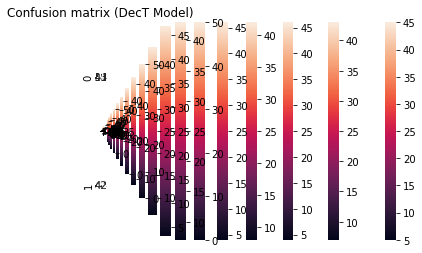

In [38]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    ## Creating and running our optimization

    # Creating and running our optimization

    study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
    with parallel_backend('threading'):
        study_dect.optimize(objective_dect, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_dect.best_trial.number)
    print("Best accuracy:", study_dect.best_trial.value)
    print("Best hyperparameters:", study_dect.best_params)

    best_param_dect = study_dect.best_params
    DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
    y_pred_dect = DecT.predict(x_test)


    display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")


    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(model=DecT, data= None, model_output= 'raw', feature_perturbation= 'tree_path_dependent')
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 0
    shap_values_array = abs(shap_values[:,:,0])

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)


# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

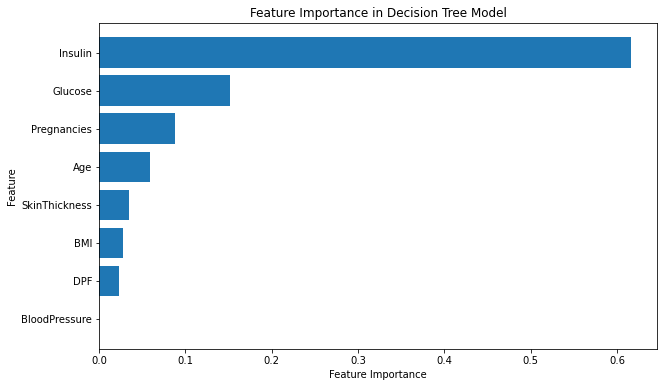

         Feature  Importance
4        Insulin    0.615730
1        Glucose    0.152101
0    Pregnancies    0.088308
7            Age    0.058687
3  SkinThickness    0.034581
5            BMI    0.027564
6            DPF    0.023028
2  BloodPressure    0.000000


In [39]:
# Get feature importances from the decision tree model
feature_importances = DecT.feature_importances_

# Get feature names
feature_names = x_train.columns

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()

# Print the DataFrame for detailed view
print(importance_df)

In [40]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [41]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('50_dt_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,1.665213,0.786170,3.269336,1.211026,0.356671,2.999484,2.349941,1.251855,1.736212
1,1.678828,0.795755,2.669100,1.257010,0.344027,1.866224,2.493642,1.249735,1.544290
2,1.678828,0.795755,2.669100,1.257010,0.344027,1.866224,2.493642,1.249735,1.544290
3,1.678828,0.800126,2.669100,1.257010,0.337126,2.972571,2.147495,1.249387,1.638955
4,1.729514,0.707513,2.669100,1.218257,0.427118,1.866224,2.499813,1.182160,1.537462
...,...,...,...,...,...,...,...,...,...
95,1.729514,0.707513,2.669100,1.218257,0.427118,1.866224,2.499813,1.182160,1.537462
96,1.678828,0.795755,2.669100,1.257010,0.344027,1.866224,2.493642,1.249735,1.544290
97,1.665213,0.786344,3.269336,1.208637,0.358103,2.999484,2.387618,1.251855,1.740824
98,1.678828,0.800126,2.669100,1.257010,0.337126,2.972571,2.147495,1.249387,1.638955


## 4.5 SVM (Support Vector Machine)

In [24]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [25]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 14:07:49,423] A new study created in memory with name: SVM
[I 2024-08-26 14:07:50,114] Trial 4 finished with value: 0.8120524144190189 and parameters: {'C': 11.30992597070359, 'gamma': 0.10375594666864518}. Best is trial 4 with value: 0.8120524144190189.
[I 2024-08-26 14:07:50,141] Trial 1 finished with value: 0.836180469618554 and parameters: {'C': 18.244790739148648, 'gamma': 0.03667265193779235}. Best is trial 1 with value: 0.836180469618554.
[I 2024-08-26 14:07:50,251] Trial 2 finished with value: 0.8141401808755515 and parameters: {'C': 206.47115293704672, 'gamma': 0.0031173530082760138}. Best is trial 1 with value: 0.836180469618554.
[I 2024-08-26 14:07:50,360] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0015031338797053635, 'gamma': 3.3769900070445186e-05}. Best is trial 1 with value: 0.836180469618554.
[I 2024-08-26 14:07:50,384] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.04226331742233856, 'gamma': 3.41712810

Best trial: 1
Best accuracy: 0.836180469618554
Best hyperparameters: {'C': 18.244790739148648, 'gamma': 0.03667265193779235}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 14:08:12,529] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.068619  0.162619       0.000095       0.002119  0.173571  0.003667   
1      0.017798  0.141964       0.004774       0.005917  0.174131  0.002345   
2      0.006048  0.091881       0.006810       0.027738  0.392643  0.010976   
3      0.026690  0.111833       0.003452       0.014286  0.306810  0.000357   
4      0.000905  0.050310       0.001000       0.000143  0.327786  0.014857   
..          ...       ...            ...            ...       ...       ...   
95     0.241964  0.104821       0.085845       0.095274  0.046964  0.100798   
96     0.014286  0.108667       0.015405       0.116429  0.178690  0.285452   
97     0.035869  0.570940       0.006631       0.138464  0.119131  0.056226   
98     0.035714  0.018548       0.009405       0.054119  0.397810  0.005738   
99     0.002536  0.136655       0.000107       0.042583  0.312298  0.011036   

         DPF       Age  Outcome  
0   0.002262  0.0

[I 2024-08-26 14:08:13,219] Trial 0 finished with value: 0.7969553333904615 and parameters: {'C': 29.063739027758274, 'gamma': 5.9038253609456934e-05}. Best is trial 0 with value: 0.7969553333904615.
[I 2024-08-26 14:08:13,342] Trial 2 finished with value: 0.7920258139176269 and parameters: {'C': 0.13653682074157286, 'gamma': 0.005495351870134483}. Best is trial 0 with value: 0.7969553333904615.
[I 2024-08-26 14:08:13,420] Trial 4 finished with value: 0.8005303631972654 and parameters: {'C': 0.5182749684225197, 'gamma': 0.5776746125048788}. Best is trial 4 with value: 0.8005303631972654.
[I 2024-08-26 14:08:13,494] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0040852928675715995, 'gamma': 3.08642813439366e-05}. Best is trial 4 with value: 0.8005303631972654.
[I 2024-08-26 14:08:13,509] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.013695482187345103, 'gamma': 0.0005635269677488171}. Best is trial 4 with value: 0.8005303631972654.
[I 20

Best trial: 4
Best accuracy: 0.8005303631972654
Best hyperparameters: {'C': 0.5182749684225197, 'gamma': 0.5776746125048788}
              precision    recall  f1-score   support

           0       0.60      0.94      0.73        50
           1       0.86      0.38      0.53        50

    accuracy                           0.66       100
   macro avg       0.73      0.66      0.63       100
weighted avg       0.73      0.66      0.63       100



[I 2024-08-26 14:08:34,326] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.017250  0.064417       0.023179       0.000940  0.108607  0.034845   
1      0.019619  0.020167       0.002857       0.076952  0.078071  0.004786   
2      0.016500  0.028357       0.081881       0.007976  0.081881  0.019000   
3      0.005690  0.033262       0.050952       0.017310  0.146952  0.000952   
4      0.015869  0.035060       0.080512       0.003440  0.101845  0.001464   
..          ...       ...            ...            ...       ...       ...   
95     0.000512  0.032298       0.062679       0.049655  0.186345  0.018155   
96     0.013929  0.061667       0.024000       0.102929  0.029548  0.196262   
97     0.050381  0.051690       0.015548       0.180214  0.039952  0.002167   
98     0.012714  0.121333       0.015929       0.154810  0.367381  0.019690   
99     0.008048  0.027714       0.016333       0.025357  0.171071  0.001595   

         DPF       Age  Outcome  
0   0.001774  0.0

[I 2024-08-26 14:08:35,045] Trial 0 finished with value: 0.8246876832009186 and parameters: {'C': 3.1586561736291303, 'gamma': 0.03491857416093458}. Best is trial 0 with value: 0.8246876832009186.
[I 2024-08-26 14:08:35,097] Trial 3 finished with value: 0.8029129271678316 and parameters: {'C': 5.176436600364529, 'gamma': 0.0006011171318679393}. Best is trial 0 with value: 0.8246876832009186.
[I 2024-08-26 14:08:35,441] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.056828604021594536, 'gamma': 0.0007509960481780599}. Best is trial 0 with value: 0.8246876832009186.
[I 2024-08-26 14:08:35,490] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0013602798403981335, 'gamma': 0.000787871828775836}. Best is trial 0 with value: 0.8246876832009186.
[I 2024-08-26 14:08:35,506] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.004306405004729637, 'gamma': 0.0024036980483415197}. Best is trial 0 with value: 0.8246876832009186.
[I 20

Best trial: 0
Best accuracy: 0.8246876832009186
Best hyperparameters: {'C': 3.1586561736291303, 'gamma': 0.03491857416093458}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 14:08:49,023] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041464  0.165893       0.004560       0.008464  0.140607  0.019512   
1      0.012833  0.148381       0.001333       0.027429  0.155500  0.003357   
2      0.000190  0.134476       0.010214       0.035000  0.320333  0.028024   
3      0.020786  0.129929       0.017619       0.038619  0.270595  0.012452   
4      0.004964  0.070036       0.004036       0.007893  0.232702  0.005012   
..          ...       ...            ...            ...       ...       ...   
95     0.037250  0.022321       0.022369       0.035679  0.273940  0.021202   
96     0.013607  0.099940       0.003702       0.164298  0.134893  0.169917   
97     0.086155  0.346821       0.129750       0.347679  0.118274  0.072774   
98     0.008643  0.063524       0.007000       0.061619  0.355190  0.036738   
99     0.022702  0.134512       0.007345       0.045536  0.329345  0.003869   

         DPF       Age  Outcome  
0   0.017893  0.0

[I 2024-08-26 14:08:49,697] Trial 0 finished with value: 0.8216313857370701 and parameters: {'C': 146.02235452378144, 'gamma': 0.000309015950903352}. Best is trial 0 with value: 0.8216313857370701.
[I 2024-08-26 14:08:49,780] Trial 4 finished with value: 0.8022523334011012 and parameters: {'C': 5.231995849333376, 'gamma': 0.0005723470384982267}. Best is trial 0 with value: 0.8216313857370701.
[I 2024-08-26 14:08:49,788] Trial 5 finished with value: 0.803071560270678 and parameters: {'C': 12.166509000645865, 'gamma': 0.1927224888273707}. Best is trial 0 with value: 0.8216313857370701.
[I 2024-08-26 14:08:50,074] Trial 1 finished with value: 0.7731031090034804 and parameters: {'C': 2.0350593438522933, 'gamma': 8.668412386432915e-05}. Best is trial 0 with value: 0.8216313857370701.
[I 2024-08-26 14:08:50,078] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.7479011116247644, 'gamma': 5.190941956410483e-05}. Best is trial 0 with value: 0.8216313857370701.
[I 2024-08-2

Best trial: 9
Best accuracy: 0.8330070197615069
Best hyperparameters: {'C': 0.44537889133475167, 'gamma': 0.09915600712633833}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 14:09:05,597] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042762  0.164048       0.001690       0.004833  0.144119  0.024524   
1      0.037679  0.127036       0.001940       0.029774  0.174155  0.004940   
2      0.019929  0.124905       0.061833       0.030976  0.220738  0.027571   
3      0.031893  0.122821       0.012012       0.039226  0.234655  0.014631   
4      0.002048  0.083762       0.032976       0.005857  0.219500  0.007048   
..          ...       ...            ...            ...       ...       ...   
95     0.136619  0.125071       0.155286       0.103048  0.100167  0.131333   
96     0.034214  0.083786       0.001762       0.154429  0.148524  0.152000   
97     0.166738  0.328667       0.008024       0.344024  0.055571  0.081952   
98     0.008476  0.082976       0.009619       0.056095  0.334238  0.036571   
99     0.030333  0.126048       0.001357       0.049929  0.338762  0.000857   

         DPF       Age  Outcome  
0   0.019071  0.0

[I 2024-08-26 14:09:06,220] Trial 1 finished with value: 0.8365075988182639 and parameters: {'C': 0.47271995920896465, 'gamma': 0.08518225827467474}. Best is trial 1 with value: 0.8365075988182639.
[I 2024-08-26 14:09:06,243] Trial 3 finished with value: 0.8193877968274542 and parameters: {'C': 105.05894974104382, 'gamma': 0.00023795231335889869}. Best is trial 1 with value: 0.8365075988182639.
[I 2024-08-26 14:09:06,449] Trial 0 finished with value: 0.7879694682450287 and parameters: {'C': 0.03218506424397441, 'gamma': 0.12178972179582202}. Best is trial 1 with value: 0.8365075988182639.
[I 2024-08-26 14:09:06,620] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0038401309158384795, 'gamma': 3.520341410202294e-05}. Best is trial 1 with value: 0.8365075988182639.
[I 2024-08-26 14:09:06,628] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 3.147097277903471, 'gamma': 1.1457549203010686e-05}. Best is trial 1 with value: 0.8365075988182639.
[I 20

Best trial: 1
Best accuracy: 0.8365075988182639
Best hyperparameters: {'C': 0.47271995920896465, 'gamma': 0.08518225827467474}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 14:09:21,702] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039869  0.167393       0.002869       0.005321  0.134964  0.023369   
1      0.033167  0.131452       0.002714       0.039405  0.168643  0.006167   
2      0.015369  0.138536       0.050083       0.036726  0.215679  0.037036   
3      0.028881  0.126643       0.007786       0.040000  0.218738  0.013714   
4      0.000893  0.084774       0.028845       0.007893  0.210036  0.006321   
..          ...       ...            ...            ...       ...       ...   
95     0.013762  0.003405       0.026333       0.003167  0.227310  0.004690   
96     0.030095  0.089905       0.002548       0.155619  0.142714  0.151262   
97     0.153071  0.332024       0.007119       0.345476  0.053262  0.077548   
98     0.006214  0.098310       0.007595       0.060238  0.321976  0.045905   
99     0.026048  0.134238       0.002786       0.053452  0.340952  0.000190   

         DPF       Age  Outcome  
0   0.021917  0.0

[I 2024-08-26 14:09:22,414] Trial 4 finished with value: 0.8184569136834231 and parameters: {'C': 854.4248209578099, 'gamma': 2.0954120157817242e-05}. Best is trial 4 with value: 0.8184569136834231.
[I 2024-08-26 14:09:22,428] Trial 2 finished with value: 0.8152582808169286 and parameters: {'C': 92.27466077828619, 'gamma': 9.382069403777492e-05}. Best is trial 4 with value: 0.8184569136834231.
[I 2024-08-26 14:09:22,630] Trial 1 finished with value: 0.8251179764035423 and parameters: {'C': 277.91271520796573, 'gamma': 0.00170288222474068}. Best is trial 1 with value: 0.8251179764035423.
[I 2024-08-26 14:09:22,812] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.012315607819480566, 'gamma': 0.00016421955788716895}. Best is trial 1 with value: 0.8251179764035423.
[I 2024-08-26 14:09:23,153] Trial 7 finished with value: 0.8142967694804797 and parameters: {'C': 25.86630709961309, 'gamma': 0.0003013748871779268}. Best is trial 1 with value: 0.8251179764035423.
[I 2024

Best trial: 1
Best accuracy: 0.8251179764035423
Best hyperparameters: {'C': 277.91271520796573, 'gamma': 0.00170288222474068}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 14:09:36,683] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037964  0.173774       0.002226       0.005940  0.126607  0.036345   
1      0.039190  0.145881       0.002310       0.071881  0.172190  0.002690   
2      0.035679  0.140964       0.007417       0.042798  0.231726  0.047536   
3      0.032702  0.140726       0.003821       0.042655  0.198274  0.021155   
4      0.002012  0.098845       0.000845       0.005821  0.205083  0.013440   
..          ...       ...            ...            ...       ...       ...   
95     0.092024  0.039262       0.144881       0.006190  0.184976  0.009857   
96     0.048917  0.108631       0.002179       0.177964  0.144345  0.109107   
97     0.151905  0.296833       0.010357       0.377143  0.044690  0.043929   
98     0.006881  0.153310       0.000595       0.070881  0.285190  0.055929   
99     0.033000  0.149905       0.004595       0.046929  0.345048  0.003262   

         DPF       Age  Outcome  
0   0.035607  0.0

[I 2024-08-26 14:09:37,393] Trial 0 finished with value: 0.8273753308968554 and parameters: {'C': 1.0679729787626284, 'gamma': 0.09038149773945599}. Best is trial 0 with value: 0.8273753308968554.
[I 2024-08-26 14:09:37,438] Trial 3 finished with value: 0.8144142349056966 and parameters: {'C': 2.114471059376539, 'gamma': 0.19830898172441203}. Best is trial 0 with value: 0.8273753308968554.
[I 2024-08-26 14:09:37,501] Trial 5 finished with value: 0.8226705005902786 and parameters: {'C': 161.2502015210186, 'gamma': 0.0007310312658739875}. Best is trial 0 with value: 0.8273753308968554.
[I 2024-08-26 14:09:37,607] Trial 1 finished with value: 0.8219857743440364 and parameters: {'C': 511.5282034539155, 'gamma': 0.000529484577985855}. Best is trial 0 with value: 0.8273753308968554.
[I 2024-08-26 14:09:37,835] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.001308838704815786, 'gamma': 0.00013698193610323922}. Best is trial 0 with value: 0.8273753308968554.
[I 2024-08-

Best trial: 0
Best accuracy: 0.8273753308968554
Best hyperparameters: {'C': 1.0679729787626284, 'gamma': 0.09038149773945599}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 14:09:51,870] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046107  0.162036       0.005298       0.005631  0.130869  0.018488   
1      0.020893  0.129417       0.001488       0.005750  0.142536  0.001226   
2      0.004024  0.144810       0.000595       0.039833  0.291262  0.018381   
3      0.022976  0.130381       0.009310       0.034524  0.267143  0.008571   
4      0.006917  0.067679       0.005179       0.006298  0.234345  0.002940   
..          ...       ...            ...            ...       ...       ...   
95     0.018298  0.014679       0.000845       0.036560  0.253369  0.006131   
96     0.006417  0.096036       0.004726       0.142012  0.133702  0.226179   
97     0.009679  0.533417       0.003512       0.157226  0.173679  0.081417   
98     0.012774  0.052679       0.006536       0.057750  0.364655  0.026060   
99     0.026202  0.135845       0.006274       0.048988  0.290726  0.002369   

         DPF       Age  Outcome  
0   0.013655  0.0

[I 2024-08-26 14:09:52,689] Trial 3 finished with value: 0.7963028260553392 and parameters: {'C': 15.545667840941189, 'gamma': 8.950403085433352e-05}. Best is trial 3 with value: 0.7963028260553392.
[I 2024-08-26 14:09:52,962] Trial 0 finished with value: 0.7662518157113268 and parameters: {'C': 0.020038777108755425, 'gamma': 0.010382119457502226}. Best is trial 3 with value: 0.7963028260553392.
[I 2024-08-26 14:09:53,013] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.02228547878825551, 'gamma': 0.0017654686848501025}. Best is trial 3 with value: 0.7963028260553392.
[I 2024-08-26 14:09:53,023] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.38560892444524825, 'gamma': 1.716250626463808e-05}. Best is trial 3 with value: 0.7963028260553392.
[I 2024-08-26 14:09:53,027] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.08954641954680735, 'gamma': 4.3552543971836514e-05}. Best is trial 3 with value: 0.7963028260553392.
[I 

Best trial: 9
Best accuracy: 0.8309178171481202
Best hyperparameters: {'C': 1.149329182694614, 'gamma': 0.06244519151815752}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 14:10:07,275] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043429  0.163190       0.002619       0.009214  0.148286  0.021833   
1      0.022833  0.130762       0.001167       0.023000  0.161190  0.001167   
2      0.001726  0.141631       0.000869       0.037060  0.298560  0.034940   
3      0.022429  0.123738       0.007190       0.040190  0.272929  0.017405   
4      0.002167  0.070119       0.006690       0.007119  0.232476  0.008143   
..          ...       ...            ...            ...       ...       ...   
95     0.012083  0.024155       0.010536       0.036464  0.270893  0.007821   
96     0.013381  0.092381       0.001643       0.154310  0.143929  0.175071   
97     0.019333  0.485714       0.006714       0.191762  0.208762  0.060762   
98     0.008464  0.063321       0.004964       0.058345  0.353845  0.032917   
99     0.023929  0.123786       0.003833       0.047643  0.330810  0.006714   

         DPF       Age  Outcome  
0   0.019500  0.0

[I 2024-08-26 14:10:08,028] Trial 3 finished with value: 0.7952936027764836 and parameters: {'C': 184.45380433513114, 'gamma': 0.16073788280567375}. Best is trial 3 with value: 0.7952936027764836.
[I 2024-08-26 14:10:08,253] Trial 1 finished with value: 0.7262243885831756 and parameters: {'C': 0.02736914565207503, 'gamma': 0.240936959116263}. Best is trial 3 with value: 0.7952936027764836.
[I 2024-08-26 14:10:08,305] Trial 0 finished with value: 0.7625649688857802 and parameters: {'C': 0.013904046798767906, 'gamma': 0.02518387461509396}. Best is trial 3 with value: 0.7952936027764836.
[I 2024-08-26 14:10:08,348] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.007520490649480097, 'gamma': 2.9280663516240152e-05}. Best is trial 3 with value: 0.7952936027764836.
[I 2024-08-26 14:10:08,411] Trial 2 finished with value: 0.7146724531814128 and parameters: {'C': 384.56054603261214, 'gamma': 0.9397484507241035}. Best is trial 3 with value: 0.7952936027764836.
[I 2024-08-

Best trial: 8
Best accuracy: 0.8215102916283873
Best hyperparameters: {'C': 292.3487969860148, 'gamma': 0.0003202150038504772}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 14:10:22,408] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030929  0.191262       0.001048       0.003333  0.094667  0.044976   
1      0.068131  0.162940       0.000988       0.112798  0.150774  0.003417   
2      0.049857  0.147190       0.008048       0.041500  0.191762  0.057476   
3      0.036917  0.160988       0.005964       0.040607  0.141821  0.035417   
4      0.001190  0.114262       0.004810       0.001976  0.168714  0.026524   
..          ...       ...            ...            ...       ...       ...   
95     0.260345  0.238512       0.009202       0.088464  0.013226  0.093321   
96     0.065845  0.127940       0.000417       0.170774  0.124893  0.095060   
97     0.226488  0.360321       0.007226       0.324798  0.016750  0.067393   
98     0.019250  0.247274       0.004869       0.065631  0.234036  0.088440   
99     0.031155  0.209893       0.000298       0.053369  0.311202  0.006036   

         DPF       Age  Outcome  
0   0.036357  0.0

[I 2024-08-26 14:10:23,428] Trial 0 finished with value: 0.7709428267625076 and parameters: {'C': 2.477968458769298, 'gamma': 0.00010041295367143234}. Best is trial 0 with value: 0.7709428267625076.
[I 2024-08-26 14:10:23,505] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0031857348098093927, 'gamma': 0.003013649167385349}. Best is trial 0 with value: 0.7709428267625076.
[I 2024-08-26 14:10:23,516] Trial 5 finished with value: 0.7432999684817707 and parameters: {'C': 0.008092256975493227, 'gamma': 0.034134312725952944}. Best is trial 0 with value: 0.7709428267625076.
[I 2024-08-26 14:10:23,519] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0029242010690496397, 'gamma': 0.009223351261202271}. Best is trial 0 with value: 0.7709428267625076.
[I 2024-08-26 14:10:23,530] Trial 2 finished with value: 0.7353495103483811 and parameters: {'C': 313.8791637337504, 'gamma': 0.8312977116906641}. Best is trial 0 with value: 0.7709428267625076.
[I 202

Best trial: 8
Best accuracy: 0.8249271234420108
Best hyperparameters: {'C': 470.915496789885, 'gamma': 0.0012239262227488749}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 14:10:37,137] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043345  0.184131       0.001060       0.000798  0.122012  0.042798   
1      0.044595  0.150262       0.000595       0.067095  0.164214  0.001595   
2      0.042357  0.150548       0.007619       0.038095  0.227381  0.045857   
3      0.039345  0.148988       0.003321       0.037798  0.193369  0.029083   
4      0.008369  0.108845       0.001583       0.000845  0.198607  0.019607   
..          ...       ...            ...            ...       ...       ...   
95     0.210107  0.170226       0.024702       0.108583  0.053821  0.136655   
96     0.056417  0.107988       0.000131       0.178464  0.144607  0.118512   
97     0.178298  0.306607       0.011274       0.368607  0.039988  0.052940   
98     0.011345  0.167274       0.006774       0.065488  0.267393  0.055774   
99     0.028369  0.155393       0.002083       0.041774  0.333202  0.009060   

         DPF       Age  Outcome  
0   0.033369  0.0

[I 2024-08-26 14:10:37,822] Trial 0 finished with value: 0.8292009722077394 and parameters: {'C': 2.0698528328903767, 'gamma': 0.016014412094336808}. Best is trial 0 with value: 0.8292009722077394.
[I 2024-08-26 14:10:37,918] Trial 1 finished with value: 0.8171994803943653 and parameters: {'C': 0.6276559470775303, 'gamma': 0.3187582987445372}. Best is trial 0 with value: 0.8292009722077394.
[I 2024-08-26 14:10:38,158] Trial 4 finished with value: 0.7721597150810138 and parameters: {'C': 22.76261129807765, 'gamma': 1.0470835652297146e-05}. Best is trial 0 with value: 0.8292009722077394.
[I 2024-08-26 14:10:38,219] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.06496140737037229, 'gamma': 6.45140210154731e-05}. Best is trial 0 with value: 0.8292009722077394.
[I 2024-08-26 14:10:38,230] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.05123785461130453, 'gamma': 1.4186710946173326e-05}. Best is trial 0 with value: 0.8292009722077394.
[I 2024-0

Best trial: 0
Best accuracy: 0.8292009722077394
Best hyperparameters: {'C': 2.0698528328903767, 'gamma': 0.016014412094336808}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 14:10:52,626] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038702  0.194179       0.001798       0.003750  0.108060  0.048440   
1      0.050750  0.157202       0.000298       0.074393  0.162536  0.003583   
2      0.044345  0.156583       0.010179       0.037607  0.215155  0.051726   
3      0.041190  0.157976       0.001071       0.040595  0.170595  0.034143   
4      0.004976  0.115143       0.002048       0.005762  0.180381  0.027881   
..          ...       ...            ...            ...       ...       ...   
95     0.190595  0.199000       0.018452       0.109143  0.022810  0.134595   
96     0.058036  0.121488       0.000917       0.172917  0.133369  0.128560   
97     0.193286  0.350429       0.001357       0.330595  0.001786  0.071071   
98     0.014333  0.204048       0.002095       0.058929  0.221714  0.076881   
99     0.027583  0.177655       0.001083       0.046512  0.314202  0.007131   

         DPF       Age  Outcome  
0   0.035702  0.0

[I 2024-08-26 14:10:53,437] Trial 3 finished with value: 0.8337280144806476 and parameters: {'C': 0.31274797022427836, 'gamma': 0.10083618579175219}. Best is trial 3 with value: 0.8337280144806476.
[I 2024-08-26 14:10:53,460] Trial 5 finished with value: 0.816662641159227 and parameters: {'C': 243.24053927703568, 'gamma': 5.386809717651282e-05}. Best is trial 3 with value: 0.8337280144806476.
[I 2024-08-26 14:10:53,702] Trial 0 finished with value: 0.784810572303017 and parameters: {'C': 2.4620513122939482, 'gamma': 0.0002319952820896054}. Best is trial 3 with value: 0.8337280144806476.
[I 2024-08-26 14:10:53,786] Trial 1 finished with value: 0.7438773295870094 and parameters: {'C': 0.02631433186317063, 'gamma': 0.1935717195648858}. Best is trial 3 with value: 0.8337280144806476.
[I 2024-08-26 14:10:53,881] Trial 2 finished with value: 0.7733296428425506 and parameters: {'C': 3.5806368678101705, 'gamma': 5.0833659954568654e-05}. Best is trial 3 with value: 0.8337280144806476.
[I 2024-0

Best trial: 7
Best accuracy: 0.8382403309028029
Best hyperparameters: {'C': 2.324287207937518, 'gamma': 0.09395567371988608}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 14:11:07,914] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047643  0.151595       0.005976       0.004810  0.215762  0.006095   
1      0.026512  0.133107       0.002036       0.002940  0.162821  0.000750   
2      0.002738  0.105381       0.000643       0.033810  0.347381  0.004905   
3      0.027679  0.105917       0.005298       0.025988  0.301298  0.003845   
4      0.012571  0.047595       0.009952       0.002452  0.330429  0.013548   
..          ...       ...            ...            ...       ...       ...   
95     0.064798  0.025440       0.001393       0.017202  0.255155  0.005869   
96     0.013310  0.094714       0.011095       0.128238  0.124619  0.284167   
97     0.001024  0.570071       0.013833       0.131524  0.125738  0.071095   
98     0.025774  0.021536       0.010369       0.054155  0.417131  0.005298   
99     0.008333  0.142595       0.000048       0.053690  0.270476  0.014048   

         DPF       Age  Outcome  
0   0.008738  0.0

[I 2024-08-26 14:11:08,629] Trial 2 finished with value: 0.8075521354629338 and parameters: {'C': 5.0039921242438785, 'gamma': 0.0012378910699814129}. Best is trial 2 with value: 0.8075521354629338.
[I 2024-08-26 14:11:08,632] Trial 4 finished with value: 0.8206225303504627 and parameters: {'C': 12.697819614947868, 'gamma': 0.0012627037731108167}. Best is trial 4 with value: 0.8206225303504627.
[I 2024-08-26 14:11:08,690] Trial 0 finished with value: 0.7998745268971286 and parameters: {'C': 200.62801050879418, 'gamma': 1.1684845226213181e-05}. Best is trial 4 with value: 0.8206225303504627.
[I 2024-08-26 14:11:09,028] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.00823075518703726, 'gamma': 4.758145226779232e-05}. Best is trial 4 with value: 0.8206225303504627.
[I 2024-08-26 14:11:09,046] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.005090304724677502, 'gamma': 0.0008328352164936771}. Best is trial 4 with value: 0.8206225303504627.
[I 

Best trial: 6
Best accuracy: 0.8284226051437373
Best hyperparameters: {'C': 1.0013596952864856, 'gamma': 0.020379566877373773}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 14:11:24,150] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037060  0.197012       0.001083       0.001607  0.103702  0.048655   
1      0.053250  0.161202       0.001345       0.076917  0.157488  0.005774   
2      0.043405  0.156381       0.018476       0.037476  0.204429  0.056405   
3      0.039702  0.157440       0.005917       0.041702  0.161321  0.036393   
4      0.005000  0.115214       0.008095       0.002643  0.174119  0.029000   
..          ...       ...            ...            ...       ...       ...   
95     0.196083  0.206750       0.003393       0.103345  0.008369  0.124869   
96     0.060179  0.120583       0.000988       0.164583  0.128012  0.127845   
97     0.200036  0.353512       0.006369       0.328321  0.006060  0.073060   
98     0.014500  0.216976       0.006071       0.058143  0.218310  0.081500   
99     0.028131  0.184488       0.001155       0.046893  0.314917  0.010274   

         DPF       Age  Outcome  
0   0.034393  0.0

[I 2024-08-26 14:11:25,029] Trial 1 finished with value: 0.8060364994576967 and parameters: {'C': 2.866312648509487, 'gamma': 0.001547425501929492}. Best is trial 1 with value: 0.8060364994576967.
[I 2024-08-26 14:11:25,205] Trial 5 finished with value: 0.7786378497574448 and parameters: {'C': 0.04716922677105756, 'gamma': 0.21705684138994788}. Best is trial 1 with value: 0.8060364994576967.
[I 2024-08-26 14:11:25,234] Trial 4 finished with value: 0.822170697910942 and parameters: {'C': 241.2798438917662, 'gamma': 0.001014269697258732}. Best is trial 4 with value: 0.822170697910942.
[I 2024-08-26 14:11:25,491] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.13513750721205037, 'gamma': 0.00012781408170789234}. Best is trial 4 with value: 0.822170697910942.
[I 2024-08-26 14:11:25,503] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0020210964400804647, 'gamma': 5.067646022164726e-05}. Best is trial 4 with value: 0.822170697910942.
[I 2024-08-

Best trial: 8
Best accuracy: 0.8344864423717372
Best hyperparameters: {'C': 1.6893804534347003, 'gamma': 0.03956878557880541}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 14:11:39,959] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042940  0.167488       0.001702       0.009321  0.132250  0.018893   
1      0.026119  0.142524       0.001214       0.034524  0.158690  0.005262   
2      0.013476  0.151619       0.004762       0.034238  0.242452  0.036619   
3      0.027869  0.134345       0.006202       0.035083  0.216131  0.015679   
4      0.001369  0.076536       0.004798       0.007774  0.219893  0.007083   
..          ...       ...            ...            ...       ...       ...   
95     0.007619  0.026524       0.009524       0.033476  0.271595  0.017571   
96     0.026631  0.097655       0.000464       0.168131  0.138226  0.138060   
97     0.088679  0.327440       0.081845       0.359774  0.091155  0.073512   
98     0.010881  0.089667       0.000714       0.068214  0.335071  0.034952   
99     0.026393  0.136679       0.004298       0.048179  0.336202  0.002726   

         DPF       Age  Outcome  
0   0.020393  0.0

[I 2024-08-26 14:11:40,658] Trial 4 finished with value: 0.8283604705672282 and parameters: {'C': 12.048873612223638, 'gamma': 0.006935072724874616}. Best is trial 4 with value: 0.8283604705672282.
[I 2024-08-26 14:11:41,025] Trial 0 finished with value: 0.299906396051409 and parameters: {'C': 0.07197944938949082, 'gamma': 0.0008613216002501134}. Best is trial 4 with value: 0.8283604705672282.
[I 2024-08-26 14:11:41,059] Trial 1 finished with value: 0.7524115131446263 and parameters: {'C': 0.03268674185554694, 'gamma': 0.004517930624355285}. Best is trial 4 with value: 0.8283604705672282.
[I 2024-08-26 14:11:41,066] Trial 5 finished with value: 0.7667001359997436 and parameters: {'C': 1.0268400588694402, 'gamma': 0.00014453246674770996}. Best is trial 4 with value: 0.8283604705672282.
[I 2024-08-26 14:11:41,077] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0019239970352592495, 'gamma': 0.00011227692941823933}. Best is trial 4 with value: 0.8283604705672282.
[I

Best trial: 4
Best accuracy: 0.8283604705672282
Best hyperparameters: {'C': 12.048873612223638, 'gamma': 0.006935072724874616}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 14:11:55,111] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037631  0.189560       0.001202       0.001464  0.108560  0.048893   
1      0.043893  0.155083       0.000298       0.069226  0.151274  0.003274   
2      0.041762  0.151214       0.007976       0.038048  0.211762  0.051595   
3      0.037893  0.153750       0.001583       0.041202  0.172798  0.033083   
4      0.002583  0.113250       0.000345       0.001940  0.180083  0.025179   
..          ...       ...            ...            ...       ...       ...   
95     0.210560  0.177083       0.020226       0.104060  0.048845  0.147845   
96     0.054000  0.118690       0.001643       0.165262  0.134000  0.131548   
97     0.190952  0.330262       0.005381       0.347548  0.029762  0.058952   
98     0.013310  0.195095       0.000810       0.062857  0.224119  0.076214   
99     0.028012  0.170845       0.000869       0.047369  0.325917  0.004488   

         DPF       Age  Outcome  
0   0.038940  0.0

[I 2024-08-26 14:11:55,759] Trial 1 finished with value: 0.8277021480210842 and parameters: {'C': 0.6867563900141984, 'gamma': 0.10669380126246682}. Best is trial 1 with value: 0.8277021480210842.
[I 2024-08-26 14:11:55,843] Trial 2 finished with value: 0.8064292417217429 and parameters: {'C': 1.2454098191163268, 'gamma': 0.003033922068943266}. Best is trial 1 with value: 0.8277021480210842.
[I 2024-08-26 14:11:56,005] Trial 4 finished with value: 0.7886536591736579 and parameters: {'C': 0.1634566558896787, 'gamma': 0.00414392464158074}. Best is trial 1 with value: 0.8277021480210842.
[I 2024-08-26 14:11:56,053] Trial 0 finished with value: 0.753282804469024 and parameters: {'C': 0.029558174480743115, 'gamma': 0.19007965599971166}. Best is trial 1 with value: 0.8277021480210842.
[I 2024-08-26 14:11:56,230] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0018905564978563504, 'gamma': 0.8188048213581499}. Best is trial 1 with value: 0.8277021480210842.
[I 2024-08-2

Best trial: 1
Best accuracy: 0.8277021480210842
Best hyperparameters: {'C': 0.6867563900141984, 'gamma': 0.10669380126246682}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 14:12:11,248] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.054310  0.163071       0.005357       0.008952  0.146595  0.021048   
1      0.033893  0.123488       0.004345       0.015012  0.160702  0.000560   
2      0.008869  0.141417       0.042964       0.032321  0.232369  0.016750   
3      0.024202  0.122583       0.004536       0.040750  0.274393  0.014226   
4      0.006321  0.076774       0.022131       0.010607  0.231702  0.003321   
..          ...       ...            ...            ...       ...       ...   
95     0.037417  0.011131       0.021702       0.008583  0.228917  0.002417   
96     0.018905  0.085405       0.004500       0.146786  0.148048  0.195381   
97     0.021762  0.490095       0.020143       0.179929  0.205333  0.072167   
98     0.013190  0.054976       0.001905       0.056952  0.358000  0.026786   
99     0.026155  0.120345       0.003750       0.049988  0.313774  0.001012   

         DPF       Age  Outcome  
0   0.015476  0.0

[I 2024-08-26 14:12:11,909] Trial 2 finished with value: 0.8360578734214792 and parameters: {'C': 3.690728427386486, 'gamma': 0.10594658021570726}. Best is trial 2 with value: 0.8360578734214792.
[I 2024-08-26 14:12:11,973] Trial 0 finished with value: 0.8178142318777755 and parameters: {'C': 43.25513372784393, 'gamma': 0.008427531657746791}. Best is trial 2 with value: 0.8360578734214792.
[I 2024-08-26 14:12:11,985] Trial 1 finished with value: 0.8050180954999435 and parameters: {'C': 38.49254234632439, 'gamma': 0.23456920468125372}. Best is trial 2 with value: 0.8360578734214792.
[I 2024-08-26 14:12:12,064] Trial 5 finished with value: 0.7972273950650924 and parameters: {'C': 36.926713832957375, 'gamma': 0.14470293976480914}. Best is trial 2 with value: 0.8360578734214792.
[I 2024-08-26 14:12:12,281] Trial 3 finished with value: 0.5208698740975946 and parameters: {'C': 0.013226643831224058, 'gamma': 0.008258849682817317}. Best is trial 2 with value: 0.8360578734214792.
[I 2024-08-26 

Best trial: 2
Best accuracy: 0.8360578734214792
Best hyperparameters: {'C': 3.690728427386486, 'gamma': 0.10594658021570726}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 14:12:25,765] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045345  0.147702       0.003345       0.007060  0.203512  0.008536   
1      0.009524  0.129357       0.004119       0.021429  0.148286  0.000024   
2      0.014821  0.078869       0.011964       0.033679  0.419702  0.020845   
3      0.019619  0.106357       0.005643       0.013333  0.283476  0.004571   
4      0.001786  0.039452       0.002548       0.005214  0.351071  0.011095   
..          ...       ...            ...            ...       ...       ...   
95     0.231762  0.104500       0.073500       0.122238  0.086810  0.110214   
96     0.042762  0.158190       0.040214       0.087357  0.158310  0.303595   
97     0.009607  0.604512       0.014226       0.106036  0.100821  0.054988   
98     0.029274  0.013988       0.012988       0.057607  0.416964  0.009369   
99     0.026631  0.184298       0.017274       0.051512  0.237060  0.013845   

         DPF       Age  Outcome  
0   0.000821  0.0

[I 2024-08-26 14:12:26,436] Trial 1 finished with value: 0.8376063702947023 and parameters: {'C': 2.3989691583591917, 'gamma': 0.0800530727375789}. Best is trial 1 with value: 0.8376063702947023.
[I 2024-08-26 14:12:26,462] Trial 5 finished with value: 0.8273749281974527 and parameters: {'C': 10.495759291592504, 'gamma': 0.009915799079995527}. Best is trial 1 with value: 0.8376063702947023.
[I 2024-08-26 14:12:26,534] Trial 3 finished with value: 0.8086918107926343 and parameters: {'C': 0.1532354514598344, 'gamma': 0.021676665140990467}. Best is trial 1 with value: 0.8376063702947023.
[I 2024-08-26 14:12:26,621] Trial 2 finished with value: 0.8259878567949884 and parameters: {'C': 121.0645245029131, 'gamma': 0.0025568144150440496}. Best is trial 1 with value: 0.8376063702947023.
[I 2024-08-26 14:12:26,857] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0010073263819110547, 'gamma': 2.358213620752421e-05}. Best is trial 1 with value: 0.8376063702947023.
[I 2024-0

Best trial: 1
Best accuracy: 0.8376063702947023
Best hyperparameters: {'C': 2.3989691583591917, 'gamma': 0.0800530727375789}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 14:12:40,429] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.061155  0.159345       0.004964       0.000774  0.164179  0.000702   
1      0.022702  0.136845       0.000702       0.006345  0.153345  0.002250   
2      0.000512  0.110869       0.003083       0.033083  0.332298  0.005417   
3      0.027190  0.116310       0.003167       0.024095  0.288048  0.004833   
4      0.014226  0.050536       0.007798       0.006560  0.315036  0.012250   
..          ...       ...            ...            ...       ...       ...   
95     0.055893  0.021821       0.009202       0.036821  0.255750  0.010988   
96     0.001702  0.097607       0.008012       0.141179  0.123155  0.248202   
97     0.000155  0.561821       0.012655       0.141488  0.136131  0.088345   
98     0.027226  0.030512       0.005417       0.057131  0.409702  0.004726   
99     0.016655  0.142798       0.003750       0.051536  0.259821  0.013917   

         DPF       Age  Outcome  
0   0.008298  0.0

[I 2024-08-26 14:12:41,129] Trial 4 finished with value: 0.8181378514839508 and parameters: {'C': 543.4278198662456, 'gamma': 3.721476761033709e-05}. Best is trial 4 with value: 0.8181378514839508.
[I 2024-08-26 14:12:41,158] Trial 1 finished with value: 0.8057719831065064 and parameters: {'C': 22.72957176103706, 'gamma': 0.00018042224727029914}. Best is trial 4 with value: 0.8181378514839508.
[I 2024-08-26 14:12:41,297] Trial 3 finished with value: 0.8086045421953569 and parameters: {'C': 0.16121315696398292, 'gamma': 0.3839128126463438}. Best is trial 4 with value: 0.8181378514839508.
[I 2024-08-26 14:12:41,313] Trial 5 finished with value: 0.8152943265397775 and parameters: {'C': 120.82059751237516, 'gamma': 0.004055599254976361}. Best is trial 4 with value: 0.8181378514839508.
[I 2024-08-26 14:12:41,432] Trial 2 finished with value: 0.8029949495325616 and parameters: {'C': 0.21693445048639112, 'gamma': 0.5495118679149563}. Best is trial 4 with value: 0.8181378514839508.
[I 2024-08-

Best trial: 6
Best accuracy: 0.8210514758671574
Best hyperparameters: {'C': 203.8422315425966, 'gamma': 0.00016611587693012345}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 14:12:56,054] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033155  0.195155       0.001702       0.004988  0.098250  0.045488   
1      0.074095  0.162143       0.001476       0.105286  0.152905  0.001357   
2      0.053131  0.146917       0.009869       0.035536  0.193107  0.057917   
3      0.037976  0.160857       0.008619       0.037310  0.146000  0.036333   
4      0.001524  0.115524       0.008000       0.003952  0.169881  0.029381   
..          ...       ...            ...            ...       ...       ...   
95     0.267536  0.234940       0.017298       0.083179  0.017107  0.089107   
96     0.071607  0.126393       0.000131       0.157655  0.134988  0.098417   
97     0.089119  0.519381       0.030333       0.160929  0.138405  0.052024   
98     0.023976  0.246286       0.006571       0.055952  0.233762  0.091095   
99     0.031083  0.209869       0.000631       0.047988  0.317464  0.007702   

         DPF       Age  Outcome  
0   0.035274  0.0

[I 2024-08-26 14:12:56,831] Trial 5 finished with value: 0.8226005312332056 and parameters: {'C': 61.19984814738207, 'gamma': 0.001857483355009388}. Best is trial 5 with value: 0.8226005312332056.
[I 2024-08-26 14:12:56,875] Trial 2 finished with value: 0.823955291866293 and parameters: {'C': 45.935268867997536, 'gamma': 0.0026672013139107205}. Best is trial 2 with value: 0.823955291866293.
[I 2024-08-26 14:12:56,909] Trial 0 finished with value: 0.8178688202928267 and parameters: {'C': 0.1431031215470318, 'gamma': 0.28588603932485235}. Best is trial 2 with value: 0.823955291866293.
[I 2024-08-26 14:12:56,933] Trial 1 finished with value: 0.79486676438386 and parameters: {'C': 1.843872137000374, 'gamma': 0.0006233058449280091}. Best is trial 2 with value: 0.823955291866293.
[I 2024-08-26 14:12:57,215] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.017090588131665252, 'gamma': 0.0002835253809041323}. Best is trial 2 with value: 0.823955291866293.
[I 2024-08-26 14

Best trial: 7
Best accuracy: 0.8323282455619353
Best hyperparameters: {'C': 0.5635782099545531, 'gamma': 0.09987513169976094}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 14:13:12,468] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049131  0.162274       0.005417       0.007321  0.146393  0.020202   
1      0.036060  0.120583       0.003131       0.019274  0.164845  0.002964   
2      0.014429  0.134738       0.054595       0.031429  0.222071  0.026000   
3      0.033881  0.123095       0.012262       0.037524  0.227833  0.017476   
4      0.000917  0.080702       0.027940       0.009512  0.224060  0.006250   
..          ...       ...            ...            ...       ...       ...   
95     0.035107  0.014393       0.021488       0.000345  0.238083  0.002060   
96     0.026226  0.082536       0.005179       0.146202  0.149726  0.167226   
97     0.039631  0.475845       0.058131       0.193012  0.204369  0.059726   
98     0.010571  0.067429       0.008262       0.058833  0.347238  0.031738   
99     0.030595  0.119619       0.004167       0.048452  0.329238  0.003833   

         DPF       Age  Outcome  
0   0.019226  0.0

[I 2024-08-26 14:13:13,130] Trial 4 finished with value: 0.82764247256268 and parameters: {'C': 0.3020177316505695, 'gamma': 0.16269301012872947}. Best is trial 4 with value: 0.82764247256268.
[I 2024-08-26 14:13:13,199] Trial 3 finished with value: 0.798564514301352 and parameters: {'C': 21.635714957699854, 'gamma': 8.288142859258318e-05}. Best is trial 4 with value: 0.82764247256268.
[I 2024-08-26 14:13:13,241] Trial 1 finished with value: 0.8215906561234732 and parameters: {'C': 712.6910196788788, 'gamma': 0.00030375383520550077}. Best is trial 4 with value: 0.82764247256268.
[I 2024-08-26 14:13:13,472] Trial 0 finished with value: 0.6870342499750645 and parameters: {'C': 0.06758350702411943, 'gamma': 0.5429356055336776}. Best is trial 4 with value: 0.82764247256268.
[I 2024-08-26 14:13:13,508] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0030518232426138495, 'gamma': 0.0012966476622469447}. Best is trial 4 with value: 0.82764247256268.
[I 2024-08-26 14:13:

Best trial: 2
Best accuracy: 0.8299108955526185
Best hyperparameters: {'C': 760.5505315225871, 'gamma': 0.009001038120707038}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 14:13:25,856] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.084952  0.152643       0.007500       0.003095  0.163976  0.010714   
1      0.012369  0.119060       0.009274       0.016036  0.166107  0.004893   
2      0.025000  0.115476       0.048762       0.031952  0.467095  0.031333   
3      0.028738  0.108690       0.005810       0.018833  0.327738  0.004786   
4      0.018048  0.046286       0.024810       0.002714  0.324714  0.018548   
..          ...       ...            ...            ...       ...       ...   
95     0.257369  0.067393       0.124250       0.100798  0.016179  0.079179   
96     0.010821  0.155869       0.070202       0.104298  0.160655  0.255274   
97     0.113988  0.594155       0.012917       0.165012  0.098179  0.048631   
98     0.034607  0.013583       0.015560       0.074917  0.374726  0.003560   
99     0.016083  0.123012       0.001298       0.044655  0.318940  0.006060   

         DPF       Age  Outcome  
0   0.001690  0.0

[I 2024-08-26 14:13:26,719] Trial 4 finished with value: 0.7956954508563802 and parameters: {'C': 6.281465250445928, 'gamma': 0.00015977242378314}. Best is trial 4 with value: 0.7956954508563802.
[I 2024-08-26 14:13:26,811] Trial 2 finished with value: 0.7843173882141659 and parameters: {'C': 38.4123705745696, 'gamma': 1.4462826590746882e-05}. Best is trial 4 with value: 0.7956954508563802.
[I 2024-08-26 14:13:26,913] Trial 5 finished with value: 0.7709590692913291 and parameters: {'C': 2.433353120834567, 'gamma': 0.0001167200433937651}. Best is trial 4 with value: 0.7956954508563802.
[I 2024-08-26 14:13:26,922] Trial 1 finished with value: 0.7716646516874576 and parameters: {'C': 20.88886248996788, 'gamma': 1.2869950057430769e-05}. Best is trial 4 with value: 0.7956954508563802.
[I 2024-08-26 14:13:26,992] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.017989175147386148, 'gamma': 7.35577709403039e-05}. Best is trial 4 with value: 0.7956954508563802.
[I 2024-08

Best trial: 8
Best accuracy: 0.8273557966399008
Best hyperparameters: {'C': 23.983985006569203, 'gamma': 0.005562228607846949}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 14:13:41,405] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039583  0.181583       0.003131       0.000560  0.116060  0.038702   
1      0.042060  0.146702       0.002750       0.072488  0.161774  0.001964   
2      0.039274  0.148393       0.006917       0.042869  0.221869  0.050988   
3      0.038024  0.143500       0.005429       0.040548  0.187524  0.024929   
4      0.005655  0.104845       0.001488       0.000202  0.192250  0.014917   
..          ...       ...            ...            ...       ...       ...   
95     0.087726  0.040774       0.144060       0.003940  0.184202  0.017179   
96     0.052429  0.113024       0.002238       0.171786  0.140857  0.113952   
97     0.172143  0.317405       0.002571       0.358143  0.033643  0.054571   
98     0.007976  0.172214       0.000881       0.069333  0.270786  0.058810   
99     0.032643  0.159857       0.003786       0.044810  0.339071  0.005310   

         DPF       Age  Outcome  
0   0.037440  0.0

[I 2024-08-26 14:13:42,140] Trial 0 finished with value: 0.8082440271935128 and parameters: {'C': 25.768180641673773, 'gamma': 0.00024043263900767734}. Best is trial 0 with value: 0.8082440271935128.
[I 2024-08-26 14:13:42,152] Trial 4 finished with value: 0.8330801849984549 and parameters: {'C': 2.5815598573053693, 'gamma': 0.0284979718808252}. Best is trial 4 with value: 0.8330801849984549.
[I 2024-08-26 14:13:42,155] Trial 3 finished with value: 0.8133317822133587 and parameters: {'C': 1.9923843583763285, 'gamma': 0.0032805069896912017}. Best is trial 4 with value: 0.8330801849984549.
[I 2024-08-26 14:13:42,513] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0013159954328816794, 'gamma': 4.641924352193216e-05}. Best is trial 4 with value: 0.8330801849984549.
[I 2024-08-26 14:13:42,522] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.43375662130329784, 'gamma': 0.00011145778915399764}. Best is trial 4 with value: 0.8330801849984549.
[I 2

Best trial: 4
Best accuracy: 0.8330801849984549
Best hyperparameters: {'C': 2.5815598573053693, 'gamma': 0.0284979718808252}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 14:13:56,363] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042798  0.169417       0.001440       0.008488  0.130821  0.021131   
1      0.027631  0.146869       0.001131       0.038631  0.156679  0.003321   
2      0.017167  0.148810       0.011262       0.035571  0.236714  0.037571   
3      0.028571  0.134095       0.004690       0.036381  0.214714  0.016643   
4      0.000524  0.079000       0.006262       0.006571  0.219738  0.008071   
..          ...       ...            ...            ...       ...       ...   
95     0.005214  0.022095       0.012071       0.026000  0.267810  0.016286   
96     0.030131  0.098964       0.001012       0.171869  0.138750  0.132083   
97     0.100036  0.315202       0.043821       0.371226  0.082893  0.069012   
98     0.011214  0.093119       0.002738       0.068976  0.329310  0.037476   
99     0.028298  0.139440       0.003440       0.047560  0.335512  0.002560   

         DPF       Age  Outcome  
0   0.021774  0.0

[I 2024-08-26 14:13:57,072] Trial 5 finished with value: 0.8316847241319008 and parameters: {'C': 1.726305052501415, 'gamma': 0.025485108970070256}. Best is trial 5 with value: 0.8316847241319008.
[I 2024-08-26 14:13:57,077] Trial 3 finished with value: 0.8258834604181174 and parameters: {'C': 0.7937242796951394, 'gamma': 0.020966248606878516}. Best is trial 5 with value: 0.8316847241319008.
[I 2024-08-26 14:13:57,111] Trial 0 finished with value: 0.8191663791059871 and parameters: {'C': 41.542682108731285, 'gamma': 0.00039498817509957593}. Best is trial 5 with value: 0.8316847241319008.
[I 2024-08-26 14:13:57,118] Trial 1 finished with value: 0.821757536496187 and parameters: {'C': 10.601547940625524, 'gamma': 0.0018238208214953764}. Best is trial 5 with value: 0.8316847241319008.
[I 2024-08-26 14:13:57,282] Trial 4 finished with value: 0.7928211363006881 and parameters: {'C': 414.94126174079605, 'gamma': 0.13708704105494215}. Best is trial 5 with value: 0.8316847241319008.
[I 2024-08

Best trial: 5
Best accuracy: 0.8316847241319008
Best hyperparameters: {'C': 1.726305052501415, 'gamma': 0.025485108970070256}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 14:14:11,569] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037869  0.174726       0.001774       0.006679  0.127226  0.031869   
1      0.036964  0.144631       0.005202       0.062250  0.173250  0.006107   
2      0.033286  0.147833       0.014452       0.038929  0.218119  0.051690   
3      0.032083  0.138036       0.000369       0.041726  0.198917  0.019726   
4      0.000500  0.100143       0.007000       0.006762  0.200762  0.011738   
..          ...       ...            ...            ...       ...       ...   
95     0.060369  0.026869       0.082536       0.001917  0.205417  0.020107   
96     0.041060  0.109750       0.003607       0.169988  0.145321  0.121750   
97     0.173286  0.333667       0.002214       0.346833  0.062071  0.070786   
98     0.004536  0.142321       0.009012       0.062274  0.295845  0.051893   
99     0.031107  0.156440       0.003155       0.049679  0.340226  0.005869   

         DPF       Age  Outcome  
0   0.032988  0.0

[I 2024-08-26 14:14:12,170] Trial 0 finished with value: 0.8313548842141891 and parameters: {'C': 1.9394737507127973, 'gamma': 0.02459463932460624}. Best is trial 0 with value: 0.8313548842141891.
[I 2024-08-26 14:14:12,609] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.026881202473480977, 'gamma': 0.001258496115301048}. Best is trial 0 with value: 0.8313548842141891.
[I 2024-08-26 14:14:12,623] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0020841382714871545, 'gamma': 1.1401894265126454e-05}. Best is trial 0 with value: 0.8313548842141891.
[I 2024-08-26 14:14:12,638] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.6354471524398886, 'gamma': 7.130080976990345e-05}. Best is trial 0 with value: 0.8313548842141891.
[I 2024-08-26 14:14:12,652] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.3998152829719696, 'gamma': 6.738440388442851e-05}. Best is trial 0 with value: 0.8313548842141891.
[I 202

Best trial: 0
Best accuracy: 0.8313548842141891
Best hyperparameters: {'C': 1.9394737507127973, 'gamma': 0.02459463932460624}


[I 2024-08-26 14:14:26,726] A new study created in memory with name: SVM


              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038929  0.174881       0.000857       0.005595  0.135405  0.032286   
1      0.036750  0.146417       0.003369       0.057655  0.177298  0.004512   
2      0.030881  0.147048       0.016429       0.036500  0.227810  0.047500   
3      0.035393  0.137964       0.003321       0.039107  0.204393  0.020774   
4      0.002619  0.096643       0.011071       0.003595  0.208952  0.014381   
..          ...       ...            ...            ...       ...       ...   
95     0.041524  0.007167       0.014190       0.009429  0.229786  0.005286   
96     0.038845  0.105512       0.001726 

[I 2024-08-26 14:14:27,445] Trial 5 finished with value: 0.8259262801129019 and parameters: {'C': 0.8139953785942149, 'gamma': 0.02170122655164138}. Best is trial 5 with value: 0.8259262801129019.
[I 2024-08-26 14:14:27,463] Trial 3 finished with value: 0.8183493611519909 and parameters: {'C': 0.5266266961975319, 'gamma': 0.23601412370957794}. Best is trial 5 with value: 0.8259262801129019.
[I 2024-08-26 14:14:27,778] Trial 4 finished with value: 0.803768568074643 and parameters: {'C': 36.5469075677008, 'gamma': 0.07240419044888463}. Best is trial 5 with value: 0.8259262801129019.
[I 2024-08-26 14:14:27,843] Trial 0 finished with value: 0.7716703266448747 and parameters: {'C': 0.7156863640671965, 'gamma': 0.0002493318787300413}. Best is trial 5 with value: 0.8259262801129019.
[I 2024-08-26 14:14:27,869] Trial 2 finished with value: 0.7459250145573226 and parameters: {'C': 0.04650280211955206, 'gamma': 0.0029579382026796337}. Best is trial 5 with value: 0.8259262801129019.
[I 2024-08-26

Best trial: 5
Best accuracy: 0.8259262801129019
Best hyperparameters: {'C': 0.8139953785942149, 'gamma': 0.02170122655164138}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 14:14:43,264] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032357  0.194381       0.001405       0.000738  0.095905  0.045619   
1      0.053107  0.156655       0.003440       0.078583  0.151107  0.007917   
2      0.041976  0.152619       0.016071       0.039952  0.194095  0.059548   
3      0.036690  0.153667       0.005143       0.041762  0.152643  0.033119   
4      0.000714  0.114119       0.005143       0.000381  0.166048  0.026738   
..          ...       ...            ...            ...       ...       ...   
95     0.209417  0.218393       0.000417       0.108464  0.000274  0.127917   
96     0.060964  0.125536       0.003369       0.156250  0.123512  0.123464   
97     0.202202  0.360845       0.009655       0.321774  0.002845  0.069964   
98     0.016798  0.220798       0.009631       0.058917  0.244060  0.085964   
99     0.033821  0.194202       0.000964       0.049750  0.317774  0.010131   

         DPF       Age  Outcome  
0   0.036476  0.0

[I 2024-08-26 14:14:44,117] Trial 5 finished with value: 0.8220335376265591 and parameters: {'C': 871.2639229681294, 'gamma': 0.0003550375655678686}. Best is trial 5 with value: 0.8220335376265591.
[I 2024-08-26 14:14:44,186] Trial 2 finished with value: 0.7752528744277289 and parameters: {'C': 0.35913141764987433, 'gamma': 0.001123313678817589}. Best is trial 5 with value: 0.8220335376265591.
[I 2024-08-26 14:14:44,234] Trial 3 finished with value: 0.7619155645552114 and parameters: {'C': 0.014955144529124262, 'gamma': 0.05584309401937212}. Best is trial 5 with value: 0.8220335376265591.
[I 2024-08-26 14:14:44,290] Trial 0 finished with value: 0.7707889737508442 and parameters: {'C': 0.05155435460918515, 'gamma': 0.0037277315443025585}. Best is trial 5 with value: 0.8220335376265591.
[I 2024-08-26 14:14:44,358] Trial 1 finished with value: 0.814167158400358 and parameters: {'C': 305.5931753906776, 'gamma': 0.0030026255622235187}. Best is trial 5 with value: 0.8220335376265591.
[I 2024

Best trial: 4
Best accuracy: 0.8294912170463478
Best hyperparameters: {'C': 366.4811128456079, 'gamma': 0.009208540612348031}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 14:14:56,496] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.065155  0.161512       0.002131       0.011464  0.187798  0.005845   
1      0.003048  0.135357       0.002690       0.014952  0.156190  0.001595   
2      0.023202  0.123226       0.020512       0.026060  0.389536  0.013726   
3      0.025226  0.120345       0.004631       0.017583  0.302702  0.000869   
4      0.022679  0.053060       0.007607       0.003488  0.241440  0.002440   
..          ...       ...            ...            ...       ...       ...   
95     0.197321  0.131083       0.130583       0.118821  0.046464  0.105440   
96     0.023119  0.116929       0.000738       0.132095  0.183381  0.250071   
97     0.149095  0.544333       0.022881       0.180095  0.148143  0.052881   
98     0.032190  0.026024       0.010238       0.067238  0.370381  0.002929   
99     0.011952  0.128881       0.004095       0.040524  0.324024  0.000071   

         DPF       Age  Outcome  
0   0.021369  0.0

[I 2024-08-26 14:14:57,177] Trial 3 finished with value: 0.8260908353552198 and parameters: {'C': 2.4827229783722395, 'gamma': 0.03806397742715959}. Best is trial 3 with value: 0.8260908353552198.
[I 2024-08-26 14:14:57,206] Trial 5 finished with value: 0.8257946708318006 and parameters: {'C': 0.8721343283120325, 'gamma': 0.1437838453005289}. Best is trial 3 with value: 0.8260908353552198.
[I 2024-08-26 14:14:57,223] Trial 4 finished with value: 0.8310010503065572 and parameters: {'C': 9.286867463197558, 'gamma': 0.03364565427181365}. Best is trial 4 with value: 0.8310010503065572.
[I 2024-08-26 14:14:57,578] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.006532869816156625, 'gamma': 0.7311426315364984}. Best is trial 4 with value: 0.8310010503065572.
[I 2024-08-26 14:14:57,587] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.033863348762946284, 'gamma': 2.5627952428089037e-05}. Best is trial 4 with value: 0.8310010503065572.
[I 2024-08-26

Best trial: 4
Best accuracy: 0.8310010503065572
Best hyperparameters: {'C': 9.286867463197558, 'gamma': 0.03364565427181365}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 14:15:10,267] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.057464  0.171179       0.002250       0.005036  0.142607  0.013821   
1      0.007405  0.141810       0.000357       0.006548  0.167357  0.001000   
2      0.010702  0.098060       0.021107       0.029036  0.342560  0.005250   
3      0.023095  0.118310       0.003310       0.024357  0.297190  0.005405   
4      0.013095  0.060238       0.002976       0.003024  0.243524  0.003690   
..          ...       ...            ...            ...       ...       ...   
95     0.181560  0.129488       0.107988       0.114488  0.079464  0.124393   
96     0.005595  0.085619       0.005095       0.165381  0.132786  0.200429   
97     0.001214  0.515548       0.010571       0.180405  0.172024  0.065190   
98     0.022155  0.038583       0.005369       0.059393  0.371679  0.017607   
99     0.011702  0.125869       0.002536       0.044845  0.324131  0.005845   

         DPF       Age  Outcome  
0   0.013464  0.0

[I 2024-08-26 14:15:10,992] Trial 0 finished with value: 0.8168224450023631 and parameters: {'C': 1.7086963535056923, 'gamma': 0.00442760328313823}. Best is trial 0 with value: 0.8168224450023631.
[I 2024-08-26 14:15:11,008] Trial 2 finished with value: 0.8171750158779589 and parameters: {'C': 558.1134722238619, 'gamma': 3.8881295412074376e-05}. Best is trial 2 with value: 0.8171750158779589.
[I 2024-08-26 14:15:11,016] Trial 1 finished with value: 0.8303456500459048 and parameters: {'C': 0.17688730400618127, 'gamma': 0.07951242024075626}. Best is trial 1 with value: 0.8303456500459048.
[I 2024-08-26 14:15:11,022] Trial 4 finished with value: 0.8182311142179153 and parameters: {'C': 9.805225460417313, 'gamma': 0.001240989473456466}. Best is trial 1 with value: 0.8303456500459048.
[I 2024-08-26 14:15:11,400] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.001421137067996645, 'gamma': 0.0007017373414518145}. Best is trial 1 with value: 0.8303456500459048.
[I 2024-0

Best trial: 3
Best accuracy: 0.8321353052376727
Best hyperparameters: {'C': 202.5569024692805, 'gamma': 0.0210732342336132}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 14:15:23,102] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.072821  0.174774       0.000940       0.006202  0.152488  0.008869   
1      0.004667  0.130214       0.007405       0.032381  0.148952  0.000167   
2      0.025083  0.066298       0.014464       0.024964  0.464393  0.018655   
3      0.021905  0.122738       0.009595       0.011690  0.287429  0.008476   
4      0.012750  0.040179       0.011679       0.005536  0.359060  0.012964   
..          ...       ...            ...            ...       ...       ...   
95     0.278845  0.026512       0.124774       0.106536  0.031393  0.072179   
96     0.047893  0.453321       0.073988       0.040226  0.027012  0.068131   
97     0.024905  0.643905       0.006310       0.123119  0.089857  0.037119   
98     0.029476  0.014881       0.014619       0.067190  0.415714  0.000452   
99     0.046369  0.190869       0.016536       0.061036  0.259845  0.030393   

         DPF       Age  Outcome  
0   0.009750  0.0

[I 2024-08-26 14:15:23,799] Trial 4 finished with value: 0.8356897448074669 and parameters: {'C': 0.6844265410892373, 'gamma': 0.044425373265881536}. Best is trial 4 with value: 0.8356897448074669.
[I 2024-08-26 14:15:23,846] Trial 5 finished with value: 0.8053368498616392 and parameters: {'C': 88.80043803895875, 'gamma': 4.261509229281789e-05}. Best is trial 4 with value: 0.8356897448074669.
[I 2024-08-26 14:15:24,012] Trial 1 finished with value: 0.787269043897146 and parameters: {'C': 0.029308237357271356, 'gamma': 0.10080852458949104}. Best is trial 4 with value: 0.8356897448074669.
[I 2024-08-26 14:15:24,185] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0012649816660556027, 'gamma': 0.001828481777085763}. Best is trial 4 with value: 0.8356897448074669.
[I 2024-08-26 14:15:24,193] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.09451504766566123, 'gamma': 0.00018878847912517737}. Best is trial 4 with value: 0.8356897448074669.
[I 202

Best trial: 4
Best accuracy: 0.8356897448074669
Best hyperparameters: {'C': 0.6844265410892373, 'gamma': 0.044425373265881536}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 14:15:39,664] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041357  0.169286       0.000452       0.005833  0.127452  0.031690   
1      0.040857  0.143690       0.007048       0.062119  0.173000  0.006238   
2      0.030440  0.141131       0.031274       0.040964  0.209488  0.047869   
3      0.034893  0.133036       0.005940       0.043607  0.196536  0.019250   
4      0.000167  0.097143       0.014500       0.005143  0.195429  0.011524   
..          ...       ...            ...            ...       ...       ...   
95     0.035048  0.016167       0.017476       0.003167  0.203238  0.004190   
96     0.038488  0.097488       0.000560       0.162250  0.128940  0.127988   
97     0.153833  0.318905       0.006595       0.360976  0.061690  0.072048   
98     0.006643  0.138500       0.013476       0.065357  0.295000  0.056476   
99     0.029405  0.151619       0.000833       0.054048  0.343143  0.002595   

         DPF       Age  Outcome  
0   0.032667  0.0

[I 2024-08-26 14:15:40,403] Trial 1 finished with value: 0.8207022064841933 and parameters: {'C': 6.940835946868917, 'gamma': 0.0022654710661408656}. Best is trial 1 with value: 0.8207022064841933.
[I 2024-08-26 14:15:40,437] Trial 2 finished with value: 0.8196771703769286 and parameters: {'C': 311.5988408196092, 'gamma': 9.425491795009614e-05}. Best is trial 1 with value: 0.8207022064841933.
[I 2024-08-26 14:15:40,508] Trial 5 finished with value: 0.7960772780693769 and parameters: {'C': 11.7511613766519, 'gamma': 0.0001085714764000028}. Best is trial 1 with value: 0.8207022064841933.
[I 2024-08-26 14:15:40,757] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.008331556518933038, 'gamma': 1.1961650559943397e-05}. Best is trial 1 with value: 0.8207022064841933.
[I 2024-08-26 14:15:40,813] Trial 4 finished with value: 0.4569897752088998 and parameters: {'C': 0.005736655177205468, 'gamma': 0.02643551780904254}. Best is trial 1 with value: 0.8207022064841933.
[I 2024

Best trial: 0
Best accuracy: 0.832864123350614
Best hyperparameters: {'C': 196.48888331908194, 'gamma': 0.018255778715150002}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 14:15:52,829] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.070619  0.166833       0.009214       0.005667  0.153929  0.005476   
1      0.019833  0.127619       0.011452       0.023500  0.156262  0.003095   
2      0.018095  0.079690       0.017000       0.031071  0.462810  0.020238   
3      0.026107  0.119345       0.000250       0.013488  0.309440  0.003512   
4      0.013524  0.042738       0.019190       0.003524  0.366262  0.009548   
..          ...       ...            ...            ...       ...       ...   
95     0.269440  0.029036       0.145226       0.101750  0.043988  0.074393   
96     0.075643  0.409500       0.063548       0.018429  0.016833  0.083833   
97     0.025560  0.636321       0.000417       0.134036  0.095012  0.038060   
98     0.034321  0.006679       0.020869       0.069060  0.400012  0.007179   
99     0.029071  0.165357       0.004214       0.050810  0.299262  0.010738   

         DPF       Age  Outcome  
0   0.010905  0.0

[I 2024-08-26 14:15:53,608] Trial 5 finished with value: 0.8049867091956365 and parameters: {'C': 14.468876017783057, 'gamma': 0.2013969850761668}. Best is trial 5 with value: 0.8049867091956365.
[I 2024-08-26 14:15:53,663] Trial 1 finished with value: 0.7960008317533449 and parameters: {'C': 11.488099094185491, 'gamma': 0.00012004333150064654}. Best is trial 5 with value: 0.8049867091956365.
[I 2024-08-26 14:15:53,672] Trial 0 finished with value: 0.7951429049357784 and parameters: {'C': 0.39200767715667967, 'gamma': 0.002181820138251402}. Best is trial 5 with value: 0.8049867091956365.
[I 2024-08-26 14:15:53,712] Trial 2 finished with value: 0.7926425212878996 and parameters: {'C': 8.860756869675864, 'gamma': 7.851273805419432e-05}. Best is trial 5 with value: 0.8049867091956365.
[I 2024-08-26 14:15:53,922] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0877954838556206, 'gamma': 0.00027923440694519196}. Best is trial 5 with value: 0.8049867091956365.
[I 2024-

Best trial: 7
Best accuracy: 0.8151814178394692
Best hyperparameters: {'C': 80.77290126095875, 'gamma': 0.4194407674872112}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 14:16:12,925] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.080333  0.142881       0.038357       0.078048  0.156833  0.014810   
1      0.085012  0.098250       0.039702       0.010893  0.131750  0.004464   
2      0.019071  0.079976       0.164738       0.033500  0.182381  0.028238   
3      0.018226  0.107655       0.161679       0.051369  0.221512  0.032583   
4      0.009226  0.073726       0.088060       0.002940  0.257440  0.016869   
..          ...       ...            ...            ...       ...       ...   
95     0.190619  0.198595       0.095905       0.162476  0.026476  0.166048   
96     0.122560  0.371393       0.093512       0.059536  0.006274  0.143988   
97     0.133250  0.330964       0.056131       0.280655  0.013798  0.009869   
98     0.004310  0.060381       0.018690       0.120333  0.304119  0.001952   
99     0.036345  0.393774       0.010369       0.077917  0.019821  0.011988   

         DPF       Age  Outcome  
0   0.032929  0.0

[I 2024-08-26 14:16:13,643] Trial 5 finished with value: 0.8219663947205815 and parameters: {'C': 135.92425805511365, 'gamma': 0.00038093087140065576}. Best is trial 5 with value: 0.8219663947205815.
[I 2024-08-26 14:16:13,772] Trial 0 finished with value: 0.8118619631568375 and parameters: {'C': 0.1456573337573725, 'gamma': 0.3323341745998724}. Best is trial 5 with value: 0.8219663947205815.
[I 2024-08-26 14:16:13,869] Trial 2 finished with value: 0.781800109532165 and parameters: {'C': 0.07445163953439562, 'gamma': 0.008074483652590274}. Best is trial 5 with value: 0.8219663947205815.
[I 2024-08-26 14:16:14,001] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.002643381933868376, 'gamma': 0.00026316490108942484}. Best is trial 5 with value: 0.8219663947205815.
[I 2024-08-26 14:16:14,009] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0015051241363404284, 'gamma': 1.4274917174583251e-05}. Best is trial 5 with value: 0.8219663947205815.
[I 

Best trial: 5
Best accuracy: 0.8219663947205815
Best hyperparameters: {'C': 135.92425805511365, 'gamma': 0.00038093087140065576}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 14:16:28,233] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030679  0.193131       0.001012       0.003726  0.094607  0.045274   
1      0.067810  0.162357       0.001119       0.112952  0.150381  0.002452   
2      0.049952  0.148952       0.007571       0.040833  0.191024  0.058333   
3      0.036607  0.160988       0.005917       0.040440  0.141964  0.036869   
4      0.001262  0.114381       0.004714       0.002357  0.167738  0.026595   
..          ...       ...            ...            ...       ...       ...   
95     0.262774  0.239345       0.009774       0.086607  0.013298  0.092607   
96     0.065857  0.127500       0.000143       0.168643  0.126262  0.095429   
97     0.225393  0.365131       0.007655       0.320607  0.014012  0.074012   
98     0.020429  0.246429       0.004095       0.063238  0.233024  0.093476   
99     0.031143  0.210667       0.000333       0.052500  0.311643  0.005833   

         DPF       Age  Outcome  
0   0.036774  0.0

[I 2024-08-26 14:16:28,962] Trial 2 finished with value: 0.8330002737562241 and parameters: {'C': 0.239837444087711, 'gamma': 0.08668970486392201}. Best is trial 2 with value: 0.8330002737562241.
[I 2024-08-26 14:16:28,976] Trial 4 finished with value: 0.8121897942777747 and parameters: {'C': 39.91837452878223, 'gamma': 0.00018482504209304683}. Best is trial 2 with value: 0.8330002737562241.
[I 2024-08-26 14:16:29,186] Trial 0 finished with value: 0.7749380571801963 and parameters: {'C': 31.581264438920254, 'gamma': 1.2683010062444805e-05}. Best is trial 2 with value: 0.8330002737562241.
[I 2024-08-26 14:16:29,201] Trial 1 finished with value: 0.7738803631408825 and parameters: {'C': 0.03267994258462496, 'gamma': 0.15395698180566528}. Best is trial 2 with value: 0.8330002737562241.
[I 2024-08-26 14:16:29,294] Trial 3 finished with value: 0.7732742267333428 and parameters: {'C': 1.445467806569549, 'gamma': 0.00016189122847914928}. Best is trial 2 with value: 0.8330002737562241.
[I 2024-

Best trial: 2
Best accuracy: 0.8330002737562241
Best hyperparameters: {'C': 0.239837444087711, 'gamma': 0.08668970486392201}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 14:16:45,814] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045464  0.176393       0.001917       0.000583  0.102869  0.038321   
1      0.051976  0.135881       0.008595       0.058214  0.171833  0.005190   
2      0.034595  0.116905       0.063024       0.035571  0.190024  0.033571   
3      0.037667  0.131214       0.022048       0.043452  0.183643  0.019976   
4      0.000571  0.106143       0.025095       0.004690  0.184095  0.016286   
..          ...       ...            ...            ...       ...       ...   
95     0.178869  0.169107       0.100750       0.110036  0.049726  0.131869   
96     0.047583  0.094607       0.001631       0.154060  0.124631  0.133012   
97     0.169714  0.309643       0.010071       0.358143  0.062214  0.063405   
98     0.006595  0.160429       0.017476       0.063095  0.281929  0.059643   
99     0.034857  0.156881       0.000976       0.057929  0.334500  0.005429   

         DPF       Age  Outcome  
0   0.028393  0.0

[I 2024-08-26 14:16:46,557] Trial 3 finished with value: 0.8213833425016068 and parameters: {'C': 0.6229235803711803, 'gamma': 0.2695051946798708}. Best is trial 3 with value: 0.8213833425016068.
[I 2024-08-26 14:16:46,661] Trial 2 finished with value: 0.811975580651847 and parameters: {'C': 0.06967293481264408, 'gamma': 0.20947388309591164}. Best is trial 3 with value: 0.8213833425016068.
[I 2024-08-26 14:16:46,864] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.015487647255151414, 'gamma': 4.6403372864259063e-05}. Best is trial 3 with value: 0.8213833425016068.
[I 2024-08-26 14:16:46,880] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.007759850319167035, 'gamma': 0.004962379263220864}. Best is trial 3 with value: 0.8213833425016068.
[I 2024-08-26 14:16:46,889] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.002603295988481872, 'gamma': 0.003264856541303699}. Best is trial 3 with value: 0.8213833425016068.
[I 2024-

Best trial: 3
Best accuracy: 0.8213833425016068
Best hyperparameters: {'C': 0.6229235803711803, 'gamma': 0.2695051946798708}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 14:17:06,008] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.035929  0.151667       0.011571       0.002238  0.153571  0.022595   
1      0.035690  0.098429       0.001690       0.012738  0.144952  0.000929   
2      0.014536  0.090917       0.105964       0.019083  0.178988  0.011250   
3      0.019083  0.123107       0.010488       0.033869  0.261726  0.001488   
4      0.008000  0.076810       0.055595       0.008024  0.231929  0.001810   
..          ...       ...            ...            ...       ...       ...   
95     0.164024  0.134571       0.125476       0.109071  0.069762  0.133833   
96     0.003881  0.103952       0.007643       0.126810  0.087452  0.305500   
97     0.032226  0.509464       0.051131       0.164679  0.199012  0.090631   
98     0.016143  0.039976       0.004786       0.082119  0.390190  0.015667   
99     0.003583  0.169179       0.021393       0.079393  0.156845  0.012226   

         DPF       Age  Outcome  
0   0.005286  0.0

[I 2024-08-26 14:17:06,667] Trial 0 finished with value: 0.8270957987455725 and parameters: {'C': 24.58397636710624, 'gamma': 0.004894276196128011}. Best is trial 0 with value: 0.8270957987455725.
[I 2024-08-26 14:17:06,707] Trial 5 finished with value: 0.821128911458732 and parameters: {'C': 171.47467694139462, 'gamma': 0.0005563597513237098}. Best is trial 0 with value: 0.8270957987455725.
[I 2024-08-26 14:17:06,770] Trial 3 finished with value: 0.8106241570635078 and parameters: {'C': 1.328889415934371, 'gamma': 0.35620029478008014}. Best is trial 0 with value: 0.8270957987455725.
[I 2024-08-26 14:17:06,855] Trial 4 finished with value: 0.8119021848599796 and parameters: {'C': 0.0897014272411984, 'gamma': 0.25327407684475584}. Best is trial 0 with value: 0.8270957987455725.
[I 2024-08-26 14:17:07,116] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.001005750233101378, 'gamma': 0.05773618490320674}. Best is trial 0 with value: 0.8270957987455725.
[I 2024-08-26 

Best trial: 2
Best accuracy: 0.8290414230597858
Best hyperparameters: {'C': 237.03558371108645, 'gamma': 0.009185621223995874}
              precision    recall  f1-score   support

           0       0.76      0.90      0.83        50
           1       0.88      0.72      0.79        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100



[I 2024-08-26 14:17:19,473] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.064738  0.163452       0.003190       0.012571  0.177857  0.002881   
1      0.006381  0.139881       0.001333       0.002881  0.155310  0.001357   
2      0.033417  0.124702       0.010179       0.020464  0.342988  0.007750   
3      0.022964  0.121869       0.003036       0.019083  0.292560  0.001464   
4      0.019488  0.053393       0.000940       0.003488  0.225536  0.001179   
..          ...       ...            ...            ...       ...       ...   
95     0.152393  0.135440       0.146607       0.132631  0.062440  0.130345   
96     0.028595  0.120476       0.000119       0.144381  0.179500  0.240595   
97     0.165833  0.492571       0.038595       0.218143  0.196905  0.056714   
98     0.029155  0.032655       0.007131       0.062536  0.370583  0.009060   
99     0.006107  0.126869       0.006964       0.038369  0.321726  0.000536   

         DPF       Age  Outcome  
0   0.025048  0.0

[I 2024-08-26 14:17:20,157] Trial 4 finished with value: 0.8374788345300483 and parameters: {'C': 3.050331002723533, 'gamma': 0.0845329510045393}. Best is trial 4 with value: 0.8374788345300483.
[I 2024-08-26 14:17:20,185] Trial 2 finished with value: 0.8064079533141667 and parameters: {'C': 4.598493718316918, 'gamma': 0.0012434688063225803}. Best is trial 4 with value: 0.8374788345300483.
[I 2024-08-26 14:17:20,581] Trial 5 finished with value: 0.6868370181337835 and parameters: {'C': 0.030816332185280976, 'gamma': 0.003871998991947849}. Best is trial 4 with value: 0.8374788345300483.
[I 2024-08-26 14:17:20,591] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0014352679137484533, 'gamma': 0.00017058574123543597}. Best is trial 4 with value: 0.8374788345300483.
[I 2024-08-26 14:17:20,625] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.03873820887649249, 'gamma': 0.0001869520086871385}. Best is trial 4 with value: 0.8374788345300483.
[I 202

Best trial: 4
Best accuracy: 0.8374788345300483
Best hyperparameters: {'C': 3.050331002723533, 'gamma': 0.0845329510045393}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 14:17:33,847] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049917  0.151274       0.004345       0.002893  0.218845  0.008488   
1      0.026274  0.135012       0.004226       0.001345  0.167679  0.000131   
2      0.000286  0.096024       0.004000       0.033286  0.365929  0.004738   
3      0.025012  0.107202       0.005679       0.021726  0.304917  0.001512   
4      0.009190  0.046405       0.007929       0.000833  0.338643  0.014071   
..          ...       ...            ...            ...       ...       ...   
95     0.082595  0.027714       0.012810       0.014643  0.242810  0.001357   
96     0.016845  0.096369       0.010917       0.124917  0.127107  0.296726   
97     0.004405  0.572786       0.011048       0.127881  0.123024  0.062500   
98     0.025536  0.017417       0.014393       0.052869  0.414321  0.005440   
99     0.004119  0.141048       0.003143       0.051048  0.275548  0.012619   

         DPF       Age  Outcome  
0   0.004369  0.0

[I 2024-08-26 14:17:34,559] Trial 5 finished with value: 0.8257889107163823 and parameters: {'C': 0.7040265652711871, 'gamma': 0.12343410840324348}. Best is trial 5 with value: 0.8257889107163823.
[I 2024-08-26 14:17:34,581] Trial 2 finished with value: 0.8320882612815326 and parameters: {'C': 1.5539586156853773, 'gamma': 0.09527121586797549}. Best is trial 2 with value: 0.8320882612815326.
[I 2024-08-26 14:17:34,774] Trial 1 finished with value: 0.7851372346247834 and parameters: {'C': 26.281315157618593, 'gamma': 2.1877151202670224e-05}. Best is trial 2 with value: 0.8320882612815326.
[I 2024-08-26 14:17:34,821] Trial 4 finished with value: 0.7737353415956219 and parameters: {'C': 0.11058481157630369, 'gamma': 0.0036530764451495777}. Best is trial 2 with value: 0.8320882612815326.
[I 2024-08-26 14:17:34,980] Trial 0 finished with value: 0.6140824021323322 and parameters: {'C': 0.006651170373704432, 'gamma': 0.15883143256895757}. Best is trial 2 with value: 0.8320882612815326.
[I 2024

Best trial: 2
Best accuracy: 0.8320882612815326
Best hyperparameters: {'C': 1.5539586156853773, 'gamma': 0.09527121586797549}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 14:17:50,195] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.052238  0.159714       0.004881       0.001952  0.167333  0.006571   
1      0.022274  0.136226       0.000107       0.003940  0.152464  0.000131   
2      0.000321  0.128155       0.001345       0.034060  0.318440  0.008321   
3      0.022845  0.120393       0.000083       0.025131  0.293607  0.000155   
4      0.004976  0.056143       0.013143       0.000571  0.278643  0.003429   
..          ...       ...            ...            ...       ...       ...   
95     0.027286  0.025167       0.013405       0.031714  0.264786  0.012857   
96     0.002095  0.096214       0.005929       0.142881  0.125667  0.257405   
97     0.004167  0.552333       0.009262       0.144524  0.131476  0.094190   
98     0.020012  0.032988       0.007488       0.053012  0.402536  0.009464   
99     0.019917  0.136345       0.004917       0.045940  0.264560  0.008988   

         DPF       Age  Outcome  
0   0.009500  0.0

[I 2024-08-26 14:17:50,856] Trial 4 finished with value: 0.8204278045959029 and parameters: {'C': 8.593360697456502, 'gamma': 0.0031342711363534365}. Best is trial 4 with value: 0.8204278045959029.
[I 2024-08-26 14:17:50,863] Trial 5 finished with value: 0.8195222489933915 and parameters: {'C': 167.90283534905427, 'gamma': 9.719774457309285e-05}. Best is trial 4 with value: 0.8204278045959029.
[I 2024-08-26 14:17:50,884] Trial 3 finished with value: 0.8041279508334586 and parameters: {'C': 1.2472892313994053, 'gamma': 0.002454690743296693}. Best is trial 4 with value: 0.8204278045959029.
[I 2024-08-26 14:17:51,213] Trial 1 finished with value: 0.5644564076545034 and parameters: {'C': 4.061737681266714, 'gamma': 2.3219242729909698e-05}. Best is trial 4 with value: 0.8204278045959029.
[I 2024-08-26 14:17:51,229] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0012230141176659982, 'gamma': 0.013679596610948913}. Best is trial 4 with value: 0.8204278045959029.
[I 202

Best trial: 8
Best accuracy: 0.8317053818478357
Best hyperparameters: {'C': 0.2673860095037524, 'gamma': 0.058374952827612875}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 14:18:07,475] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043631  0.184250       0.001012       0.000845  0.110512  0.039321   
1      0.054667  0.147310       0.005810       0.070643  0.172905  0.004333   
2      0.042155  0.134417       0.045845       0.035940  0.189988  0.046774   
3      0.044179  0.138274       0.018440       0.042798  0.173155  0.023012   
4      0.002262  0.109667       0.021286       0.002476  0.177167  0.022429   
..          ...       ...            ...            ...       ...       ...   
95     0.226000  0.195262       0.028571       0.108952  0.017881  0.128929   
96     0.061429  0.107238       0.003976       0.154000  0.134167  0.118071   
97     0.199214  0.332238       0.012881       0.342452  0.036119  0.059810   
98     0.016524  0.190000       0.013905       0.059762  0.269714  0.062476   
99     0.035429  0.170000       0.000857       0.052738  0.329405  0.002690   

         DPF       Age  Outcome  
0   0.030988  0.0

[I 2024-08-26 14:18:08,201] Trial 0 finished with value: 0.8030352548551959 and parameters: {'C': 0.2453485467970949, 'gamma': 0.011937102918591192}. Best is trial 0 with value: 0.8030352548551959.
[I 2024-08-26 14:18:08,213] Trial 4 finished with value: 0.8221145480700564 and parameters: {'C': 0.10156985919901426, 'gamma': 0.05395164977326068}. Best is trial 4 with value: 0.8221145480700564.
[I 2024-08-26 14:18:08,243] Trial 2 finished with value: 0.8016494960564509 and parameters: {'C': 129.77179844105555, 'gamma': 2.170214008749341e-05}. Best is trial 4 with value: 0.8221145480700564.
[I 2024-08-26 14:18:08,582] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.008951679662457048, 'gamma': 5.9484822834066855e-05}. Best is trial 4 with value: 0.8221145480700564.
[I 2024-08-26 14:18:08,586] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0010309120514733151, 'gamma': 0.0010325719017553916}. Best is trial 4 with value: 0.8221145480700564.
[I 

Best trial: 7
Best accuracy: 0.8364621735024781
Best hyperparameters: {'C': 2.100064547812871, 'gamma': 0.10732144332764597}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 14:18:22,552] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043071  0.147071       0.005524       0.004071  0.219048  0.005286   
1      0.022107  0.130869       0.003202       0.000988  0.159869  0.001464   
2      0.001667  0.107952       0.003810       0.032976  0.348286  0.005952   
3      0.027155  0.105607       0.004298       0.025274  0.299845  0.004274   
4      0.011369  0.048821       0.012964       0.002202  0.328417  0.014417   
..          ...       ...            ...            ...       ...       ...   
95     0.054071  0.027000       0.008024       0.031833  0.262619  0.011786   
96     0.018488  0.095893       0.011488       0.122012  0.123607  0.298321   
97     0.001155  0.572298       0.021274       0.126202  0.118393  0.070845   
98     0.026393  0.020940       0.012250       0.056893  0.416512  0.004060   
99     0.005631  0.147583       0.000250       0.050774  0.264798  0.016179   

         DPF       Age  Outcome  
0   0.008333  0.0

[I 2024-08-26 14:18:23,377] Trial 3 finished with value: 0.8221157788184213 and parameters: {'C': 36.614640396183994, 'gamma': 0.0017799617636102432}. Best is trial 3 with value: 0.8221157788184213.
[I 2024-08-26 14:18:23,426] Trial 5 finished with value: 0.8165199637348641 and parameters: {'C': 30.398977728118247, 'gamma': 0.00043172069709172995}. Best is trial 3 with value: 0.8221157788184213.
[I 2024-08-26 14:18:23,694] Trial 2 finished with value: 0.7831309418067656 and parameters: {'C': 0.513522664759492, 'gamma': 0.0010952977654133645}. Best is trial 3 with value: 0.8221157788184213.
[I 2024-08-26 14:18:23,701] Trial 4 finished with value: 0.7642495153537676 and parameters: {'C': 0.015699817669607354, 'gamma': 0.055697294649467835}. Best is trial 3 with value: 0.8221157788184213.
[I 2024-08-26 14:18:23,817] Trial 0 finished with value: 0.8097036592308592 and parameters: {'C': 971.644816717723, 'gamma': 0.4604572180453328}. Best is trial 3 with value: 0.8221157788184213.
[I 2024-0

Best trial: 3
Best accuracy: 0.8221157788184213
Best hyperparameters: {'C': 36.614640396183994, 'gamma': 0.0017799617636102432}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 14:18:38,228] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029262  0.193095       0.000952       0.001833  0.091167  0.048262   
1      0.061845  0.160179       0.001821       0.098036  0.145083  0.003488   
2      0.050095  0.149857       0.010857       0.039905  0.186500  0.058667   
3      0.035857  0.159524       0.005690       0.040690  0.140143  0.038405   
4      0.001214  0.115429       0.005286       0.001786  0.155643  0.030000   
..          ...       ...            ...            ...       ...       ...   
95     0.250512  0.231988       0.008107       0.087345  0.016488  0.116202   
96     0.067607  0.126893       0.000083       0.163250  0.116821  0.106940   
97     0.216548  0.345929       0.010071       0.337071  0.018476  0.051952   
98     0.014083  0.244964       0.008798       0.067631  0.204250  0.097369   
99     0.035798  0.206655       0.000179       0.054107  0.308250  0.007345   

         DPF       Age  Outcome  
0   0.036714  0.0

[I 2024-08-26 14:18:38,976] Trial 5 finished with value: 0.8040595685845062 and parameters: {'C': 163.93380487526164, 'gamma': 2.1891529927850507e-05}. Best is trial 5 with value: 0.8040595685845062.
[I 2024-08-26 14:18:39,021] Trial 3 finished with value: 0.8168760386702946 and parameters: {'C': 0.07392414666161126, 'gamma': 0.05096977125820413}. Best is trial 3 with value: 0.8168760386702946.
[I 2024-08-26 14:18:39,132] Trial 2 finished with value: 0.7928211363006881 and parameters: {'C': 550.2602477373617, 'gamma': 0.13745081043263113}. Best is trial 3 with value: 0.8168760386702946.
[I 2024-08-26 14:18:39,254] Trial 4 finished with value: 0.8156854756197661 and parameters: {'C': 370.4351115080215, 'gamma': 0.34526381468078493}. Best is trial 3 with value: 0.8168760386702946.
[I 2024-08-26 14:18:39,351] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0013065176641705418, 'gamma': 0.002169771230418697}. Best is trial 3 with value: 0.8168760386702946.
[I 2024-08

Best trial: 6
Best accuracy: 0.821772435739057
Best hyperparameters: {'C': 234.4216533510408, 'gamma': 0.00019325876384917488}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 14:18:54,179] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031679  0.194607       0.002202       0.003869  0.098369  0.045988   
1      0.069417  0.162393       0.001583       0.109083  0.155369  0.001464   
2      0.051429  0.147429       0.008786       0.037905  0.194762  0.056310   
3      0.037964  0.161036       0.006964       0.039440  0.147607  0.036988   
4      0.000417  0.114940       0.006655       0.003917  0.172560  0.027655   
..          ...       ...            ...            ...       ...       ...   
95     0.262929  0.234333       0.014214       0.084071  0.017476  0.091667   
96     0.067940  0.125702       0.000012       0.164750  0.132583  0.095655   
97     0.090881  0.512143       0.071810       0.171500  0.129119  0.049667   
98     0.021000  0.245476       0.004238       0.056548  0.236476  0.087810   
99     0.030369  0.208036       0.001512       0.049274  0.315917  0.008226   

         DPF       Age  Outcome  
0   0.036321  0.0

[I 2024-08-26 14:18:54,897] Trial 5 finished with value: 0.805991291087174 and parameters: {'C': 78.10246383947721, 'gamma': 5.3176781923364504e-05}. Best is trial 5 with value: 0.805991291087174.
[I 2024-08-26 14:18:54,921] Trial 4 finished with value: 0.8020714227721969 and parameters: {'C': 1.252580538823601, 'gamma': 0.0021285695936740902}. Best is trial 5 with value: 0.805991291087174.
[I 2024-08-26 14:18:55,229] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.002542732325345444, 'gamma': 0.7943114045994384}. Best is trial 5 with value: 0.805991291087174.
[I 2024-08-26 14:18:55,239] Trial 3 finished with value: 0.7622380071011342 and parameters: {'C': 3.234701533709511, 'gamma': 0.7174186171923307}. Best is trial 5 with value: 0.805991291087174.
[I 2024-08-26 14:18:55,261] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0018591936125549838, 'gamma': 0.001407459992317987}. Best is trial 5 with value: 0.805991291087174.
[I 2024-08-26 14:

Best trial: 6
Best accuracy: 0.8330646861480807
Best hyperparameters: {'C': 0.3009208702123844, 'gamma': 0.09612356178149331}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 14:19:11,676] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042536  0.175060       0.001845       0.003655  0.120274  0.034750   
1      0.046202  0.136155       0.004988       0.044417  0.162083  0.004393   
2      0.026679  0.124250       0.071345       0.032798  0.194012  0.033155   
3      0.030643  0.131595       0.023619       0.041952  0.200833  0.017262   
4      0.000357  0.096976       0.036048       0.005690  0.196071  0.014667   
..          ...       ...            ...            ...       ...       ...   
95     0.148833  0.146762       0.160690       0.101643  0.073071  0.130381   
96     0.041036  0.089274       0.003036       0.155464  0.132560  0.148440   
97     0.178774  0.322726       0.009012       0.356798  0.078417  0.082155   
98     0.005429  0.124952       0.015429       0.059548  0.300238  0.053190   
99     0.028595  0.145405       0.000738       0.056357  0.338857  0.001571   

         DPF       Age  Outcome  
0   0.024488  0.0

[I 2024-08-26 14:19:12,492] Trial 5 finished with value: 0.8276627423972763 and parameters: {'C': 3.688645538532763, 'gamma': 0.019856139959953625}. Best is trial 5 with value: 0.8276627423972763.
[I 2024-08-26 14:19:12,702] Trial 1 finished with value: 0.7741325420922659 and parameters: {'C': 0.09697596234305403, 'gamma': 0.004458809808328651}. Best is trial 5 with value: 0.8276627423972763.
[I 2024-08-26 14:19:12,772] Trial 0 finished with value: 0.7733301333783165 and parameters: {'C': 0.02685610517178975, 'gamma': 0.008954057622354449}. Best is trial 5 with value: 0.8276627423972763.
[I 2024-08-26 14:19:12,784] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0024021448355608303, 'gamma': 0.6311251997607562}. Best is trial 5 with value: 0.8276627423972763.
[I 2024-08-26 14:19:12,882] Trial 4 finished with value: 0.7936633108215461 and parameters: {'C': 125.55713613492665, 'gamma': 0.10987622569028022}. Best is trial 5 with value: 0.8276627423972763.
[I 2024-08

Best trial: 5
Best accuracy: 0.8276627423972763
Best hyperparameters: {'C': 3.688645538532763, 'gamma': 0.019856139959953625}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 14:19:26,827] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.040214  0.173524       0.001452       0.012310  0.138976  0.026143   
1      0.029381  0.149857       0.000095       0.041167  0.153595  0.003833   
2      0.021750  0.153083       0.018131       0.034726  0.224655  0.043250   
3      0.030024  0.137429       0.002143       0.035024  0.206952  0.018667   
4      0.000012  0.086060       0.011607       0.006917  0.213845  0.010464   
..          ...       ...            ...            ...       ...       ...   
95     0.008881  0.001357       0.021952       0.003048  0.239500  0.009381   
96     0.032988  0.103250       0.002274       0.169774  0.144202  0.132845   
97     0.124071  0.317095       0.031667       0.367476  0.076738  0.063381   
98     0.010000  0.117190       0.001595       0.061571  0.313738  0.042619   
99     0.028643  0.146286       0.001619       0.042024  0.334452  0.002881   

         DPF       Age  Outcome  
0   0.028214  0.0

[I 2024-08-26 14:19:27,555] Trial 5 finished with value: 0.8175733198928994 and parameters: {'C': 214.89131829493, 'gamma': 6.40379933600187e-05}. Best is trial 5 with value: 0.8175733198928994.
[I 2024-08-26 14:19:27,563] Trial 0 finished with value: 0.8201198922373264 and parameters: {'C': 89.52661539520571, 'gamma': 0.0003397868240665963}. Best is trial 0 with value: 0.8201198922373264.
[I 2024-08-26 14:19:27,601] Trial 3 finished with value: 0.8055697058582756 and parameters: {'C': 27.758206150134768, 'gamma': 0.00015971718057912086}. Best is trial 0 with value: 0.8201198922373264.
[I 2024-08-26 14:19:27,866] Trial 2 finished with value: 0.7722305557762701 and parameters: {'C': 1.021517859435281, 'gamma': 0.0002853672471930364}. Best is trial 0 with value: 0.8201198922373264.
[I 2024-08-26 14:19:27,914] Trial 1 finished with value: 0.7742004767817484 and parameters: {'C': 0.15142638888809987, 'gamma': 0.0012480507293021266}. Best is trial 0 with value: 0.8201198922373264.
[I 2024-0

Best trial: 0
Best accuracy: 0.8201198922373264
Best hyperparameters: {'C': 89.52661539520571, 'gamma': 0.0003397868240665963}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 14:19:42,565] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032738  0.195190       0.001619       0.004905  0.097595  0.045548   
1      0.071738  0.164500       0.001643       0.103952  0.151571  0.001024   
2      0.053024  0.147429       0.011595       0.035476  0.192119  0.057952   
3      0.037036  0.161917       0.008869       0.037298  0.145250  0.036369   
4      0.001548  0.115500       0.008310       0.003690  0.168976  0.029357   
..          ...       ...            ...            ...       ...       ...   
95     0.265155  0.235440       0.017750       0.083250  0.016583  0.089679   
96     0.071774  0.126798       0.000345       0.161036  0.130917  0.099060   
97     0.089607  0.518250       0.041583       0.163488  0.135655  0.050488   
98     0.022274  0.247298       0.006726       0.055417  0.233440  0.089821   
99     0.031131  0.213060       0.000798       0.048345  0.315202  0.008321   

         DPF       Age  Outcome  
0   0.034548  0.0

[I 2024-08-26 14:19:43,274] Trial 2 finished with value: 0.819339332564535 and parameters: {'C': 3.694642922928947, 'gamma': 0.0033056440711188347}. Best is trial 2 with value: 0.819339332564535.
[I 2024-08-26 14:19:43,287] Trial 4 finished with value: 0.8191046480058212 and parameters: {'C': 155.2107869915651, 'gamma': 0.00010786821591075185}. Best is trial 2 with value: 0.819339332564535.
[I 2024-08-26 14:19:43,550] Trial 1 finished with value: 0.7667756710047274 and parameters: {'C': 0.020384690431535873, 'gamma': 0.028559977630858917}. Best is trial 2 with value: 0.819339332564535.
[I 2024-08-26 14:19:43,661] Trial 5 finished with value: 0.6674753304159163 and parameters: {'C': 0.015753497997331726, 'gamma': 0.3195542500764427}. Best is trial 2 with value: 0.819339332564535.
[I 2024-08-26 14:19:43,674] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 1.4100295430558947, 'gamma': 2.709382793469602e-05}. Best is trial 2 with value: 0.819339332564535.
[I 2024-08-26

Best trial: 2
Best accuracy: 0.819339332564535
Best hyperparameters: {'C': 3.694642922928947, 'gamma': 0.0033056440711188347}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 14:20:00,252] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029024  0.196429       0.000524       0.006143  0.089738  0.048952   
1      0.057143  0.170976       0.000357       0.087667  0.142976  0.000810   
2      0.048976  0.158762       0.005738       0.029905  0.181905  0.058833   
3      0.032238  0.168548       0.003476       0.033190  0.134857  0.040524   
4      0.004869  0.120440       0.004131       0.006821  0.147964  0.033940   
..          ...       ...            ...            ...       ...       ...   
95     0.253476  0.232810       0.004690       0.089762  0.020905  0.120190   
96     0.065643  0.126000       0.000310       0.147524  0.126429  0.112762   
97     0.083036  0.528345       0.024488       0.155560  0.134821  0.050512   
98     0.022821  0.253988       0.003131       0.055298  0.223202  0.101202   
99     0.026488  0.224655       0.000226       0.047488  0.307560  0.011417   

         DPF       Age  Outcome  
0   0.032048  0.0

[I 2024-08-26 14:20:00,973] Trial 1 finished with value: 0.8214841684969695 and parameters: {'C': 458.9620110435653, 'gamma': 0.00033184816470850187}. Best is trial 1 with value: 0.8214841684969695.
[I 2024-08-26 14:20:00,996] Trial 4 finished with value: 0.7957998550625159 and parameters: {'C': 0.5360672210921392, 'gamma': 0.003407179036974411}. Best is trial 1 with value: 0.8214841684969695.
[I 2024-08-26 14:20:01,262] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.16367234079836315, 'gamma': 1.058038067954669e-05}. Best is trial 1 with value: 0.8214841684969695.
[I 2024-08-26 14:20:01,279] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.006512022761947696, 'gamma': 0.00029455967545852853}. Best is trial 1 with value: 0.8214841684969695.
[I 2024-08-26 14:20:01,295] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.08554170778598617, 'gamma': 3.414845670587363e-05}. Best is trial 1 with value: 0.8214841684969695.
[I 2

Best trial: 2
Best accuracy: 0.8236371062909029
Best hyperparameters: {'C': 233.7541458402282, 'gamma': 0.007909968152686141}
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        50
           1       0.90      0.70      0.79        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 14:20:13,743] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.054893  0.171298       0.001964       0.016440  0.125917  0.008679   
1      0.012595  0.139762       0.000333       0.007143  0.149833  0.001405   
2      0.035167  0.132929       0.013262       0.026500  0.321262  0.012333   
3      0.019548  0.125310       0.004500       0.021976  0.268357  0.000786   
4      0.012464  0.064321       0.003012       0.008798  0.209940  0.000607   
..          ...       ...            ...            ...       ...       ...   
95     0.125607  0.155036       0.117488       0.127131  0.042583  0.135464   
96     0.008536  0.110131       0.002845       0.165321  0.129440  0.203988   
97     0.000845  0.326869       0.150583       0.383083  0.114345  0.039893   
98     0.026821  0.042298       0.002155       0.077321  0.353036  0.014845   
99     0.007202  0.140298       0.004845       0.042512  0.332107  0.002750   

         DPF       Age  Outcome  
0   0.015655  0.0

[I 2024-08-26 14:20:14,398] Trial 5 finished with value: 0.830513737490881 and parameters: {'C': 1.602994387722407, 'gamma': 0.02508248882234682}. Best is trial 5 with value: 0.830513737490881.
[I 2024-08-26 14:20:14,425] Trial 2 finished with value: 0.8371044764110558 and parameters: {'C': 7.283500815526, 'gamma': 0.05675445259550832}. Best is trial 2 with value: 0.8371044764110558.
[I 2024-08-26 14:20:14,469] Trial 4 finished with value: 0.8026512028270567 and parameters: {'C': 16.94897271380364, 'gamma': 0.00020035431218503675}. Best is trial 2 with value: 0.8371044764110558.
[I 2024-08-26 14:20:14,743] Trial 3 finished with value: 0.789931995243235 and parameters: {'C': 411.7144228726926, 'gamma': 0.11206730412361694}. Best is trial 2 with value: 0.8371044764110558.
[I 2024-08-26 14:20:14,819] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.020143749925932177, 'gamma': 0.0008052983143966585}. Best is trial 2 with value: 0.8371044764110558.
[I 2024-08-26 14:20

Best trial: 2
Best accuracy: 0.8371044764110558
Best hyperparameters: {'C': 7.283500815526, 'gamma': 0.05675445259550832}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 14:20:27,390] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051988  0.153155       0.006917       0.004798  0.220060  0.002798   
1      0.020762  0.141905       0.005143       0.005190  0.177548  0.003429   
2      0.004440  0.087298       0.011821       0.029417  0.390250  0.006750   
3      0.025060  0.108202       0.002464       0.014821  0.310964  0.000155   
4      0.005262  0.047238       0.005095       0.002119  0.343714  0.012476   
..          ...       ...            ...            ...       ...       ...   
95     0.238631  0.112988       0.061107       0.113964  0.084417  0.115583   
96     0.024333  0.105024       0.016714       0.111024  0.178476  0.295429   
97     0.021738  0.574548       0.014381       0.129214  0.113929  0.056786   
98     0.029988  0.016536       0.011750       0.050750  0.408750  0.004893   
99     0.004595  0.132905       0.003190       0.048571  0.313548  0.008976   

         DPF       Age  Outcome  
0   0.001226  0.0

[I 2024-08-26 14:20:28,141] Trial 1 finished with value: 0.8218101754508664 and parameters: {'C': 836.4779668470977, 'gamma': 7.533519798260313e-05}. Best is trial 1 with value: 0.8218101754508664.
[I 2024-08-26 14:20:28,165] Trial 3 finished with value: 0.8270188824847527 and parameters: {'C': 73.5636455930773, 'gamma': 0.003059828240811411}. Best is trial 3 with value: 0.8270188824847527.
[I 2024-08-26 14:20:28,378] Trial 5 finished with value: 0.8165785523493855 and parameters: {'C': 11.335177387275378, 'gamma': 0.3229672265122983}. Best is trial 3 with value: 0.8270188824847527.
[I 2024-08-26 14:20:28,491] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.008065907801564179, 'gamma': 3.7786065229338295e-05}. Best is trial 3 with value: 0.8270188824847527.
[I 2024-08-26 14:20:28,499] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.028829263164618278, 'gamma': 1.4034707265594233e-05}. Best is trial 3 with value: 0.8270188824847527.
[I 2024-

Best trial: 6
Best accuracy: 0.8316685274892123
Best hyperparameters: {'C': 598.9724594315768, 'gamma': 0.009610328849472756}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 14:20:41,251] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.084131  0.155131       0.007417       0.004679  0.164512  0.010417   
1      0.010869  0.120155       0.008107       0.015274  0.165560  0.004083   
2      0.027024  0.125690       0.051405       0.033762  0.466690  0.031310   
3      0.028179  0.109417       0.006560       0.018869  0.328393  0.004036   
4      0.018262  0.048167       0.025262       0.001619  0.318643  0.017905   
..          ...       ...            ...            ...       ...       ...   
95     0.236310  0.077690       0.122167       0.102500  0.014095  0.083548   
96     0.000345  0.142893       0.057274       0.106679  0.166036  0.258369   
97     0.114488  0.583321       0.012131       0.166274  0.102988  0.050964   
98     0.033238  0.016310       0.013024       0.074762  0.373548  0.002714   
99     0.016798  0.124298       0.000774       0.047226  0.320536  0.003964   

         DPF       Age  Outcome  
0   0.000750  0.0

[I 2024-08-26 14:20:41,956] Trial 3 finished with value: 0.8117561419001967 and parameters: {'C': 1.6089881369309027, 'gamma': 0.25436195402567435}. Best is trial 3 with value: 0.8117561419001967.
[I 2024-08-26 14:20:42,076] Trial 4 finished with value: 0.8053211149614935 and parameters: {'C': 0.06723747968374957, 'gamma': 0.03180088128737319}. Best is trial 3 with value: 0.8117561419001967.
[I 2024-08-26 14:20:42,315] Trial 0 finished with value: 0.7877121201835157 and parameters: {'C': 698.6812047204232, 'gamma': 0.10344288649198176}. Best is trial 3 with value: 0.8117561419001967.
[I 2024-08-26 14:20:42,345] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0049842899692553585, 'gamma': 0.0004227789975924553}. Best is trial 3 with value: 0.8117561419001967.
[I 2024-08-26 14:20:42,364] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.08040128464248177, 'gamma': 2.7372276241691842e-05}. Best is trial 3 with value: 0.8117561419001967.
[I 2024-

Best trial: 3
Best accuracy: 0.8117561419001967
Best hyperparameters: {'C': 1.6089881369309027, 'gamma': 0.25436195402567435}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029798  0.145583       0.019679       0.010369  0.198107  0.000321   
1      0.022333  0.108571       0.002571       0.024262  0.150214  0.000619   
2      0.000679  0.089036       0.074202       0.033560  0.271202  0.000893   
3      0.017321  0.113964       0.018083       0.020036  0.264155  0.005369   
4      0.012202  0.060821       0.041298       0.001083  0.302083  0.018440   
..          ...       ...            ...            ...       ...       .

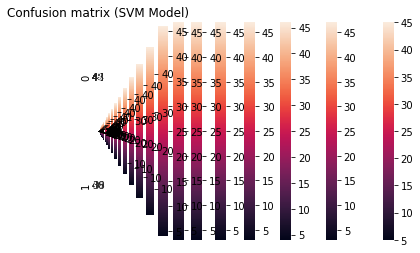

In [26]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    # Creating and running our optimization

    study_svm = optuna.create_study(direction='maximize',study_name ="SVM")

    with parallel_backend('threading'):
        study_svm.optimize(objective_svm, n_trials=10, n_jobs=-1)
    # Evaluating our Optuna Trial
    print("Best trial:", study_svm.best_trial.number)
    print("Best accuracy:", study_svm.best_trial.value)
    print("Best hyperparameters:", study_svm.best_params)
    best_param_svm = study_svm.best_params
    SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
    y_pred_svm = SVM.predict(x_test_)


    display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

    
    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(SVM, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [27]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.068619,0.162619,0.000095,0.002119,0.173571,0.003667,0.002262,0.048619,0
1,0.017798,0.141964,0.004774,0.005917,0.174131,0.002345,0.013583,0.094179,0
2,0.006048,0.091881,0.006810,0.027738,0.392643,0.010976,0.015071,0.011643,0
3,0.026690,0.111833,0.003452,0.014286,0.306810,0.000357,0.014452,0.001405,0
4,0.000905,0.050310,0.001000,0.000143,0.327786,0.014857,0.015524,0.069476,0
...,...,...,...,...,...,...,...,...,...
4995,0.227417,0.137250,0.019012,0.128964,0.052345,0.141488,0.051560,0.039774,1
4996,0.080310,0.371929,0.089262,0.094762,0.068429,0.118690,0.037000,0.103857,1
4997,0.004798,0.589845,0.029869,0.103060,0.107583,0.060274,0.002893,0.092607,1
4998,0.026976,0.020857,0.009619,0.089762,0.413952,0.006690,0.013810,0.109143,1


In [28]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]
        



In [29]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('50_svm_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.321756,0.128430,1.462122,1.640605,0.259820,0.658272,0.603973,0.449812,0.690599
1,0.583142,0.169977,1.566863,0.812391,0.097303,0.678824,0.479364,0.388812,0.597085
2,0.692000,0.228643,1.221972,0.188085,0.344398,0.597314,0.404502,0.754470,0.553923
3,0.262806,0.177087,2.160494,0.328119,0.266401,0.794745,0.649982,0.571660,0.651412
4,0.983526,0.341416,1.239999,0.619597,0.280005,0.642293,0.350331,0.503944,0.620139
...,...,...,...,...,...,...,...,...,...
95,0.658379,0.803506,0.990743,0.642913,0.856244,0.754184,0.620425,0.621076,0.743434
96,0.682240,0.628900,1.836621,0.247655,0.296817,0.412764,0.770791,1.766571,0.830295
97,0.754111,0.292365,1.275472,0.405022,0.615379,0.284392,1.039339,0.427584,0.636708
98,0.521075,0.786191,0.622747,0.260706,0.208006,0.814627,0.734305,0.636838,0.573062


## Xgboost

In [30]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [31]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


[I 2024-08-26 14:21:01,186] A new study created in memory with name: XGBoost
[I 2024-08-26 14:21:07,532] Trial 4 finished with value: 0.8719453300969038 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5596374280006777, 'colsample_bytree': 0.6067838532288341, 'reg_alpha': 0.07835438871724917, 'reg_lambda': 0.023580919842515726}. Best is trial 4 with value: 0.8719453300969038.
[I 2024-08-26 14:21:07,984] Trial 2 finished with value: 0.8775060228221065 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.7397118214310345, 'colsample_bytree': 0.7834441914141974, 'reg_alpha': 2.754412661569533e-05, 'reg_lambda': 0.006342405135832435}. Best is trial 2 with value: 0.8775060228221065.
[I 2024-08-26 14:21:08,559] Trial 1 finished with value: 0.8800579893919295 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7690909900375241, 'colsample_bytree': 0.629332130479752, 'reg_alpha': 2.7458774599662475e-05, 'reg_lambda': 4.149020014600877

Best trial: 0
Best accuracy: 0.8828791662031196
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5684561019039466, 'colsample_bytree': 0.8637338757487328, 'reg_alpha': 0.08702894397122948, 'reg_lambda': 0.0009271288489803138}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      1.065441  0.980948       0.031070       0.698302  0.040528  0.595879   
1      0.029888  1.346609       0.083703       0.337092  4.321486  0.824695   
2      0.019477  0.978274       0.101258       0.286925  2.182807  1.429932   
3      0.688236  0.702581       0.210066       0.658531  4.513485  0.168990   
4      0.276971  2.2950

[I 2024-08-26 14:21:20,718] Trial 4 finished with value: 0.8748856156851769 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.500904230122986, 'colsample_bytree': 0.5118566144230936, 'reg_alpha': 0.0047631026570210955, 'reg_lambda': 0.0020144642990663447}. Best is trial 4 with value: 0.8748856156851769.
[I 2024-08-26 14:21:21,202] Trial 5 finished with value: 0.8732428030883663 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.612781210254735, 'colsample_bytree': 0.6681011274916768, 'reg_alpha': 5.8539178537234004e-05, 'reg_lambda': 0.0005365451398195465}. Best is trial 4 with value: 0.8748856156851769.
[I 2024-08-26 14:21:22,835] Trial 0 finished with value: 0.8846129022025369 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.8058775710166775, 'colsample_bytree': 0.6993612990062342, 'reg_alpha': 0.01107791731135837, 'reg_lambda': 0.000973120464659028}. Best is trial 0 with value: 0.8846129022025369.
[I 2024-08-26 14:21:23,

Best trial: 7
Best accuracy: 0.8867197813768806
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9830928144294611, 'colsample_bytree': 0.7453327514167344, 'reg_alpha': 1.4773414521624428, 'reg_lambda': 0.00351869304007142}
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        50
           1       0.91      0.84      0.87        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.131409  0.469636       0.013002       0.486721  0.232696  0.196465   
1      0.072767  0.406284       0.025707       0.320405  2.701691  0.881933   
2      0.277373  0.864677       0.197646       0.342991  0.960791  0.806810   
3      0.167279  0.351757       0.193123       0.305365  3.104028  0.326183   
4      0.226722  1.545039  

[I 2024-08-26 14:21:36,577] Trial 2 finished with value: 0.8784833016992077 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7895983368969228, 'colsample_bytree': 0.9061470509109513, 'reg_alpha': 0.009786970903622511, 'reg_lambda': 0.00020545979260803445}. Best is trial 2 with value: 0.8784833016992077.
[I 2024-08-26 14:21:37,655] Trial 1 finished with value: 0.8831008279442817 and parameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6904741429845686, 'colsample_bytree': 0.9901687141979105, 'reg_alpha': 5.251101016605999, 'reg_lambda': 0.014920451138303824}. Best is trial 1 with value: 0.8831008279442817.
[I 2024-08-26 14:21:37,733] Trial 3 finished with value: 0.8821439195803713 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9992977021057226, 'colsample_bytree': 0.5956235901909979, 'reg_alpha': 0.0053820017363797, 'reg_lambda': 0.00024614422592280966}. Best is trial 1 with value: 0.8831008279442817.
[I 2024-08-26 14:21:37,81

Best trial: 9
Best accuracy: 0.8917436801711118
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7710744526686915, 'colsample_bytree': 0.9785535662867768, 'reg_alpha': 2.5832551318512467, 'reg_lambda': 0.00018510782837521787}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018288  0.935644       0.026353       0.045820  0.451002  0.547199   
1      0.053057  0.800575       0.043681       0.298671  2.223013  0.634440   
2      0.007391  1.068438       0.003176       0.447938  1.542251  0.301956   
3      0.103573  0.433207       0.296146       0.607124  2.849660  0.505217   
4      0.177198  1.44575

[I 2024-08-26 14:21:51,953] Trial 3 finished with value: 0.8865027637755974 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9938121713639104, 'colsample_bytree': 0.6812836224799297, 'reg_alpha': 0.5186840154570067, 'reg_lambda': 0.01919919031339097}. Best is trial 3 with value: 0.8865027637755974.
[I 2024-08-26 14:21:52,050] Trial 0 finished with value: 0.8750909904480093 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.7049057308795168, 'colsample_bytree': 0.9924876308542709, 'reg_alpha': 2.1315200354021324, 'reg_lambda': 0.00017596226065845797}. Best is trial 3 with value: 0.8865027637755974.
[I 2024-08-26 14:21:52,720] Trial 5 finished with value: 0.8770795432138685 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8655657403225624, 'colsample_bytree': 0.8372663602032084, 'reg_alpha': 0.005042094262507027, 'reg_lambda': 0.0009075021153317577}. Best is trial 3 with value: 0.8865027637755974.
[I 2024-08-26 14:21:52,809

Best trial: 8
Best accuracy: 0.8925824190861956
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9924475414304028, 'colsample_bytree': 0.9497543672199296, 'reg_alpha': 0.00019674925482659908, 'reg_lambda': 0.17998987112667514}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.389472  1.175990       0.127997       0.820780  0.545874  0.362502   
1      0.010108  0.947704       0.343151       0.098351  4.076766  0.351691   
2      0.501745  1.412886       0.273979       0.495037  2.060415  1.236446   
3      0.476545  0.611192       0.304230       0.506144  4.380206  0.725561   
4      0.353662  2.0740

[I 2024-08-26 14:22:04,514] Trial 3 finished with value: 0.8834368371787713 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.9809193969927714, 'colsample_bytree': 0.6322562855363345, 'reg_alpha': 9.127165633726223, 'reg_lambda': 0.00030581727865131914}. Best is trial 3 with value: 0.8834368371787713.
[I 2024-08-26 14:22:05,980] Trial 4 finished with value: 0.8763621843667666 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.6945436933343716, 'colsample_bytree': 0.7529500688082104, 'reg_alpha': 0.02613351418526886, 'reg_lambda': 0.022124107792248097}. Best is trial 3 with value: 0.8834368371787713.
[I 2024-08-26 14:22:06,080] Trial 0 finished with value: 0.8722870976673388 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.566695941315509, 'colsample_bytree': 0.6401767259800472, 'reg_alpha': 2.429291751506377e-05, 'reg_lambda': 1.0280655121159745e-05}. Best is trial 3 with value: 0.8834368371787713.
[I 2024-08-26 14:22:06,

Best trial: 2
Best accuracy: 0.8864184221099357
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8529826196802436, 'colsample_bytree': 0.810358125079039, 'reg_alpha': 1.7322971501801914, 'reg_lambda': 0.0023300679383776012}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.016233  0.942837       0.018327       0.381385  0.245712  0.356480   
1      0.218651  0.866787       0.115254       0.284157  2.820659  0.812781   
2      0.314854  1.024722       0.190118       0.193847  0.626553  0.434701   
3      0.011197  0.692800       0.245139       0.346704  3.062192  0.428533   
4      0.136302  1.084633 

[I 2024-08-26 14:22:19,049] Trial 1 finished with value: 0.8679068931548305 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.6373524405155208, 'colsample_bytree': 0.6350409439944262, 'reg_alpha': 0.00017842881741897114, 'reg_lambda': 0.0002591072382006467}. Best is trial 1 with value: 0.8679068931548305.
[I 2024-08-26 14:22:19,239] Trial 3 finished with value: 0.8740793666622215 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.7043863044405176, 'colsample_bytree': 0.5646006881700155, 'reg_alpha': 0.00017722560301434897, 'reg_lambda': 3.3784995134455267}. Best is trial 3 with value: 0.8740793666622215.
[I 2024-08-26 14:22:19,630] Trial 2 finished with value: 0.8751307140148127 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7810507749179332, 'colsample_bytree': 0.6146373703276758, 'reg_alpha': 1.1220689252690934, 'reg_lambda': 0.012412797017537596}. Best is trial 2 with value: 0.8751307140148127.
[I 2024-08-26 14:22:19,

Best trial: 9
Best accuracy: 0.8855240138432967
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8919621682619603, 'colsample_bytree': 0.9467968001139366, 'reg_alpha': 7.140894027005704, 'reg_lambda': 0.051161580898026617}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033028  0.704226       0.011459       0.101944  0.149373  0.305900   
1      0.039935  0.666806       0.022241       0.514048  1.597238  0.195535   
2      0.019893  0.735469       0.032045       0.482954  0.938029  0.422959   
3      0.024044  0.469031       0.014938       0.522930  1.844772  0.257632   
4      0.036346  0.839980  

[I 2024-08-26 14:22:33,221] Trial 3 finished with value: 0.8807548920429045 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.8332493375432943, 'colsample_bytree': 0.9887785007586576, 'reg_alpha': 0.16028569391839834, 'reg_lambda': 1.937553104878401e-05}. Best is trial 3 with value: 0.8807548920429045.
[I 2024-08-26 14:22:34,022] Trial 1 finished with value: 0.8872954218471061 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.8791541385638162, 'colsample_bytree': 0.7228998537214157, 'reg_alpha': 1.7176851405020175, 'reg_lambda': 0.13273580158715007}. Best is trial 1 with value: 0.8872954218471061.
[I 2024-08-26 14:22:34,417] Trial 0 finished with value: 0.8787179954486817 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.5297492248399848, 'colsample_bytree': 0.9264669836369879, 'reg_alpha': 0.0006287759148665873, 'reg_lambda': 0.013920173740851739}. Best is trial 1 with value: 0.8872954218471061.
[I 2024-08-26 14:22:34,570

Best trial: 1
Best accuracy: 0.8872954218471061
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.8791541385638162, 'colsample_bytree': 0.7228998537214157, 'reg_alpha': 1.7176851405020175, 'reg_lambda': 0.13273580158715007}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.127106  0.690528       0.029973       0.475339  0.021568  0.292706   
1      0.073934  0.921245       0.077757       0.281891  3.082332  0.675300   
2      0.081884  0.910864       0.226299       0.291375  0.687365  0.565432   
3      0.005314  0.610881       0.194553       0.342287  3.229186  0.196726   
4      0.138441  1.290827  

[I 2024-08-26 14:22:48,277] Trial 1 finished with value: 0.8774712360614962 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.7793519271172139, 'colsample_bytree': 0.8775685508460169, 'reg_alpha': 0.01188496731487761, 'reg_lambda': 0.1889751703222029}. Best is trial 1 with value: 0.8774712360614962.
[I 2024-08-26 14:22:49,857] Trial 4 finished with value: 0.881456419418557 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7634860674816146, 'colsample_bytree': 0.7912571225479834, 'reg_alpha': 1.2950367289576972, 'reg_lambda': 0.001302455894344459}. Best is trial 4 with value: 0.881456419418557.
[I 2024-08-26 14:22:50,074] Trial 5 finished with value: 0.8856234271531346 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.788605133213866, 'colsample_bytree': 0.8442175054945091, 'reg_alpha': 0.00019266106562106444, 'reg_lambda': 0.0029525803564513587}. Best is trial 5 with value: 0.8856234271531346.
[I 2024-08-26 14:22:50,540] Tr

Best trial: 5
Best accuracy: 0.8856234271531346
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.788605133213866, 'colsample_bytree': 0.8442175054945091, 'reg_alpha': 0.00019266106562106444, 'reg_lambda': 0.0029525803564513587}
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.159671  1.061595       0.135809       0.854818  0.687900  0.242172   
1      0.077199  0.445374       0.084196       0.327081  3.704004  0.968267   
2      0.102137  1.048398       0.309801       0.666451  0.837058  1.029741   
3      0.240777  0.309960       0.184205       0.757650  3.670946  0.578984   
4      0.080884  1.423

[I 2024-08-26 14:23:02,382] Trial 5 finished with value: 0.8732322669801627 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.5157581431980551, 'colsample_bytree': 0.919769755126091, 'reg_alpha': 2.546838787139118e-05, 'reg_lambda': 1.0919519837146827}. Best is trial 5 with value: 0.8732322669801627.
[I 2024-08-26 14:23:03,737] Trial 4 finished with value: 0.886193492960819 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8744116749408174, 'colsample_bytree': 0.9835998350131534, 'reg_alpha': 5.217305185246995, 'reg_lambda': 0.011386929857395253}. Best is trial 4 with value: 0.886193492960819.
[I 2024-08-26 14:23:05,397] Trial 3 finished with value: 0.8783251863562103 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8257996434785756, 'colsample_bytree': 0.6615502158202683, 'reg_alpha': 0.00031426888474842755, 'reg_lambda': 0.27123690074801093}. Best is trial 4 with value: 0.886193492960819.
[I 2024-08-26 14:23:05,506] 

Best trial: 0
Best accuracy: 0.8867337217874528
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9751729147245702, 'colsample_bytree': 0.8049012489515092, 'reg_alpha': 0.0008912680118725285, 'reg_lambda': 0.14705462985728424}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.287545  1.200143       0.068283       0.720762  0.022702  0.094337   
1      0.056797  0.910459       0.205485       0.573901  3.243356  1.090199   
2      0.230557  1.227106       0.224416       0.518525  1.350082  1.093027   
3      0.151802  0.475039       0.006452       0.726048  3.569116  0.258211   
4      0.243032  1.43884

[I 2024-08-26 14:23:18,896] Trial 0 finished with value: 0.8761921004666665 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.8473216297715731, 'colsample_bytree': 0.5665411709523559, 'reg_alpha': 2.6051464467310128e-05, 'reg_lambda': 6.667096369455605e-05}. Best is trial 0 with value: 0.8761921004666665.
[I 2024-08-26 14:23:19,016] Trial 2 finished with value: 0.8787930197400801 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.8527771047662889, 'colsample_bytree': 0.877670240903764, 'reg_alpha': 0.009366441533707023, 'reg_lambda': 0.38818906533447783}. Best is trial 2 with value: 0.8787930197400801.
[I 2024-08-26 14:23:19,316] Trial 4 finished with value: 0.8791087360192538 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6124237258806753, 'colsample_bytree': 0.6750340338752874, 'reg_alpha': 0.00019600562337443876, 'reg_lambda': 0.00029132024106589947}. Best is trial 4 with value: 0.8791087360192538.
[I 2024-08-26 14:23

Best trial: 3
Best accuracy: 0.8869994028575557
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8476786076366294, 'colsample_bytree': 0.5876709223293345, 'reg_alpha': 0.00017297745589956877, 'reg_lambda': 3.9343915304046067}
              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.196162  1.001664       0.044702       0.445758  0.258350  0.539119   
1      0.124415  0.704967       0.446732       0.108629  3.189743  0.494462   
2      0.242054  0.956149       0.230041       0.382732  1.353597  0.829070   
3      0.040512  0.419372       0.061500       0.438031  3.371708  0.532551   
4      0.223120  1.86265

[I 2024-08-26 14:23:32,931] Trial 5 finished with value: 0.8710976229338183 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.5044665430837874, 'colsample_bytree': 0.9036109236707277, 'reg_alpha': 0.01085963825902283, 'reg_lambda': 1.2763801743297158}. Best is trial 5 with value: 0.8710976229338183.
[I 2024-08-26 14:23:33,358] Trial 2 finished with value: 0.8752419252827985 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.5251820522994763, 'colsample_bytree': 0.9883075781770297, 'reg_alpha': 0.00023253737531973045, 'reg_lambda': 2.7578689986399185}. Best is trial 2 with value: 0.8752419252827985.
[I 2024-08-26 14:23:34,048] Trial 1 finished with value: 0.8856636844101741 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7904046424513835, 'colsample_bytree': 0.7565649190841581, 'reg_alpha': 0.03161649552850586, 'reg_lambda': 9.779758357627896}. Best is trial 1 with value: 0.8856636844101741.
[I 2024-08-26 14:23:34,089] Tria

Best trial: 4
Best accuracy: 0.887975466760503
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9353505206446722, 'colsample_bytree': 0.8383330239696252, 'reg_alpha': 0.00013526384152807216, 'reg_lambda': 0.2136947282852441}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.846139  0.655038       0.125002       0.821545  0.101368  0.258299   
1      0.046696  1.048365       0.266868       0.348071  4.171507  0.574784   
2      0.020139  0.437829       0.250768       0.390004  2.321596  0.884300   
3      0.044261  0.532503       0.024998       1.089735  4.627620  0.574962   
4      0.390385  2.006935

[I 2024-08-26 14:23:47,408] Trial 3 finished with value: 0.869056128285488 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.5504970598080593, 'colsample_bytree': 0.5035615017418409, 'reg_alpha': 3.1999563013760785e-05, 'reg_lambda': 0.6970775212616972}. Best is trial 3 with value: 0.869056128285488.
[I 2024-08-26 14:23:47,618] Trial 5 finished with value: 0.8704964871844456 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6265379770431487, 'colsample_bytree': 0.9033584483381756, 'reg_alpha': 3.873793887080566e-05, 'reg_lambda': 5.79242437914939}. Best is trial 5 with value: 0.8704964871844456.
[I 2024-08-26 14:23:47,713] Trial 2 finished with value: 0.8755875975632922 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.5602368823108403, 'colsample_bytree': 0.9562640214527178, 'reg_alpha': 0.012308669733686614, 'reg_lambda': 0.0559165798108371}. Best is trial 2 with value: 0.8755875975632922.
[I 2024-08-26 14:23:48,402] Tri

Best trial: 0
Best accuracy: 0.8896918903546591
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9395022124059034, 'colsample_bytree': 0.7563747160530292, 'reg_alpha': 0.04510051272812616, 'reg_lambda': 0.004554928909553058}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.679417  1.023866       0.273293       1.042278  0.384058  0.645981   
1      0.039494  0.839079       0.106398       0.150699  4.077970  0.387693   
2      0.298350  1.254230       0.354857       0.442920  2.234545  0.926279   
3      0.214471  0.015501       0.213802       0.817727  4.567906  0.656171   
4      0.419499  1.91737

[I 2024-08-26 14:24:03,276] Trial 3 finished with value: 0.8796040814212475 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.7962271705271702, 'colsample_bytree': 0.6466532922820456, 'reg_alpha': 7.046326815729679e-05, 'reg_lambda': 0.1767292901285428}. Best is trial 3 with value: 0.8796040814212475.
[I 2024-08-26 14:24:03,556] Trial 5 finished with value: 0.881344779822725 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8173119442255043, 'colsample_bytree': 0.7487351874631363, 'reg_alpha': 0.00011269096687055623, 'reg_lambda': 1.3837522690837052}. Best is trial 5 with value: 0.881344779822725.
[I 2024-08-26 14:24:03,638] Trial 0 finished with value: 0.8848731691822745 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.9255350625492996, 'colsample_bytree': 0.8627982837415189, 'reg_alpha': 1.9321548132579716, 'reg_lambda': 5.7415956039009025e-05}. Best is trial 0 with value: 0.8848731691822745.
[I 2024-08-26 14:24:04,058] 

Best trial: 8
Best accuracy: 0.887386559794704
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9014649037290778, 'colsample_bytree': 0.8080252849483874, 'reg_alpha': 0.33050167660469754, 'reg_lambda': 0.4787812464925193}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.729182  0.980836       0.056352       0.624030  0.024956  0.814447   
1      0.045484  0.877908       0.303389       0.040889  3.630017  1.146276   
2      0.050911  1.114029       0.218884       0.359551  2.874346  0.957662   
3      0.096915  0.541819       0.231784       0.470689  4.735585  0.756480   
4      0.533636  2.079688   

[I 2024-08-26 14:24:10,599] A new study created in memory with name: XGBoost
[I 2024-08-26 14:24:17,716] Trial 1 finished with value: 0.8752096442331281 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.6159004240955512, 'colsample_bytree': 0.7543011384563383, 'reg_alpha': 0.08104780892206845, 'reg_lambda': 7.342314973825038e-05}. Best is trial 1 with value: 0.8752096442331281.
[I 2024-08-26 14:24:17,832] Trial 3 finished with value: 0.8726105363268596 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.5515017350589017, 'colsample_bytree': 0.6270524823173961, 'reg_alpha': 0.3969262332790378, 'reg_lambda': 0.005626835663714444}. Best is trial 1 with value: 0.8752096442331281.
[I 2024-08-26 14:24:18,454] Trial 5 finished with value: 0.8839067861475357 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8228062885957993, 'colsample_bytree': 0.813975148502353, 'reg_alpha': 1.1958210012734305, 'reg_lambda': 9.071280700533277}. Best

Best trial: 5
Best accuracy: 0.8839067861475357
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8228062885957993, 'colsample_bytree': 0.813975148502353, 'reg_alpha': 1.1958210012734305, 'reg_lambda': 9.071280700533277}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030552  1.029463       0.000520       0.184092  0.031499  0.577968   
1      0.117486  0.939993       0.006607       0.277134  2.660781  0.502108   
2      0.174824  1.204573       0.093949       0.192150  0.584198  0.499281   
3      0.056158  0.802241       0.074776       0.247029  2.903613  0.606251   
4      0.062763  1.175725     

[I 2024-08-26 14:24:31,651] Trial 5 finished with value: 0.8665285392757924 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.5409949737276496, 'colsample_bytree': 0.7620151542494515, 'reg_alpha': 7.7258951019407895, 'reg_lambda': 0.0006390934378826806}. Best is trial 5 with value: 0.8665285392757924.
[I 2024-08-26 14:24:32,724] Trial 1 finished with value: 0.8708786353611734 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.623890336399061, 'colsample_bytree': 0.8240905465751851, 'reg_alpha': 5.2660701575136996e-05, 'reg_lambda': 0.03230306883557917}. Best is trial 1 with value: 0.8708786353611734.
[I 2024-08-26 14:24:33,836] Trial 0 finished with value: 0.885121189965731 and parameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7495353811296217, 'colsample_bytree': 0.963745259641728, 'reg_alpha': 5.071841993139454, 'reg_lambda': 0.017466043061228655}. Best is trial 0 with value: 0.885121189965731.
[I 2024-08-26 14:24:33,869] Tri

Best trial: 0
Best accuracy: 0.885121189965731
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7495353811296217, 'colsample_bytree': 0.963745259641728, 'reg_alpha': 5.071841993139454, 'reg_lambda': 0.017466043061228655}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.149860  0.876493       0.039643       0.204328  0.023867  0.383395   
1      0.163936  0.784416       0.038633       0.037918  1.901001  0.293080   
2      0.127399  1.015513       0.061326       0.295612  1.064296  0.231665   
3      0.116566  0.494082       0.023796       0.476351  2.144223  0.278138   
4      0.066762  1.112791    

[I 2024-08-26 14:24:46,393] Trial 3 finished with value: 0.8729456853115477 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.6228441013206747, 'colsample_bytree': 0.5467031365742365, 'reg_alpha': 4.590859245543501, 'reg_lambda': 0.0004630583840961822}. Best is trial 3 with value: 0.8729456853115477.
[I 2024-08-26 14:24:46,667] Trial 0 finished with value: 0.876794770683878 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.6817232615975437, 'colsample_bytree': 0.9542771058388795, 'reg_alpha': 0.3510556729329534, 'reg_lambda': 0.015412980426488792}. Best is trial 0 with value: 0.876794770683878.
[I 2024-08-26 14:24:47,470] Trial 2 finished with value: 0.8737431269592595 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.6947168632435499, 'colsample_bytree': 0.6515244431571259, 'reg_alpha': 0.0025535936106902343, 'reg_lambda': 5.347358252185411e-05}. Best is trial 0 with value: 0.876794770683878.
[I 2024-08-26 14:24:47,795] Tr

Best trial: 8
Best accuracy: 0.8863899894020604
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8632079052512303, 'colsample_bytree': 0.9455816060333203, 'reg_alpha': 1.3927035639043119e-05, 'reg_lambda': 0.006709761538216568}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 14:24:53,894] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.461717  1.225491       0.003351       0.717605  0.237643  0.495872   
1      0.200057  0.554287       0.094733       0.375751  3.580053  0.626928   
2      0.040692  1.308141       0.342399       0.451139  1.422253  0.568646   
3      0.134878  0.407227       0.179605       0.739818  4.119455  0.432038   
4      0.256151  1.337216       0.452786       0.864628  1.144130  0.639356   
..          ...       ...            ...            ...       ...       ...   
95     0.381427  0.565069       0.881302       0.040179  0.325947  0.938980   
96     0.145895  2.853872       0.360123       0.022046  1.966883  1.375599   
97     0.039819  2.615533       0.094458       0.700640  1.346801  0.404793   
98     0.257048  0.282235       0.594379       0.485835  5.075624  0.039769   
99     0.316048  2.633787       0.103185       0.467671  0.081527  0.800183   

         DPF       Age  Outcome  
0   0.807772  0.5

[I 2024-08-26 14:25:00,893] Trial 0 finished with value: 0.8820713058765332 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6520822166953097, 'colsample_bytree': 0.5663590597432547, 'reg_alpha': 0.00010069414687050408, 'reg_lambda': 0.006856703958558259}. Best is trial 0 with value: 0.8820713058765332.
[I 2024-08-26 14:25:00,944] Trial 1 finished with value: 0.8726897474789371 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.5546759687532915, 'colsample_bytree': 0.594046068960111, 'reg_alpha': 7.317984126651043e-05, 'reg_lambda': 0.41412212152622696}. Best is trial 0 with value: 0.8820713058765332.
[I 2024-08-26 14:25:01,095] Trial 5 finished with value: 0.881508329102709 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.8707041316524422, 'colsample_bytree': 0.6561779240038849, 'reg_alpha': 0.018217325023601433, 'reg_lambda': 0.024091527617789876}. Best is trial 0 with value: 0.8820713058765332.
[I 2024-08-26 14:25:01,28

Best trial: 8
Best accuracy: 0.8886129787634952
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8902005720419202, 'colsample_bytree': 0.9356447252338387, 'reg_alpha': 2.1936104476100855, 'reg_lambda': 0.00012560212343691723}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033077  0.808844       0.019218       0.393923  0.093790  0.548308   
1      0.049564  0.791602       0.075247       0.112867  2.703650  0.695330   
2      0.081109  1.040501       0.026868       0.452993  1.313778  0.745527   
3      0.093521  0.374034       0.147065       0.694322  3.116734  0.338797   
4      0.138727  1.33713

[I 2024-08-26 14:25:07,306] A new study created in memory with name: XGBoost
[I 2024-08-26 14:25:13,889] Trial 4 finished with value: 0.8774647431624374 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.693728389983737, 'colsample_bytree': 0.804168390636095, 'reg_alpha': 0.08119352154857692, 'reg_lambda': 5.5282288094007956e-05}. Best is trial 4 with value: 0.8774647431624374.
[I 2024-08-26 14:25:15,204] Trial 3 finished with value: 0.8821669857592707 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8408071075838623, 'colsample_bytree': 0.5079200046818021, 'reg_alpha': 1.5738503041138734, 'reg_lambda': 9.52160039104482e-05}. Best is trial 3 with value: 0.8821669857592707.
[I 2024-08-26 14:25:15,294] Trial 1 finished with value: 0.8824731013816429 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.7414063598604663, 'colsample_bytree': 0.898689542730735, 'reg_alpha': 0.011800268523557141, 'reg_lambda': 0.013416101056092217}. 

Best trial: 7
Best accuracy: 0.8889267405552495
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7414459876646919, 'colsample_bytree': 0.8263126516292316, 'reg_alpha': 0.01372424030245558, 'reg_lambda': 0.03814377715966544}
              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 14:25:23,054] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.623472  1.612249       0.228886       0.375722  0.037106  0.442662   
1      0.080498  1.083472       0.034711       0.037510  4.273151  1.206206   
2      0.351471  1.729599       0.136838       0.133784  3.459115  0.726725   
3      0.632418  0.759046       0.405121       0.727720  5.304301  0.835098   
4      0.431759  1.503498       0.079815       0.688441  2.211895  1.109850   
..          ...       ...            ...            ...       ...       ...   
95     0.230020  0.652680       0.750671       0.241261  1.286442  1.163059   
96     0.149498  3.739845       0.136791       0.074283  1.986509  1.505778   
97     0.059509  2.902248       0.146779       0.804217  1.982226  0.527828   
98     0.423931  0.485505       0.136474       0.172919  5.817237  0.677882   
99     0.726042  3.588927       0.343800       0.888973  0.235505  0.536327   

         DPF       Age  Outcome  
0   0.471767  0.9

[I 2024-08-26 14:25:29,845] Trial 4 finished with value: 0.877210341759267 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7309929419505055, 'colsample_bytree': 0.7203101967620809, 'reg_alpha': 0.0033339548450363643, 'reg_lambda': 0.4852329547897782}. Best is trial 4 with value: 0.877210341759267.
[I 2024-08-26 14:25:30,446] Trial 0 finished with value: 0.8740782986798061 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.5165982814531511, 'colsample_bytree': 0.6398106713485356, 'reg_alpha': 0.0034865654068092266, 'reg_lambda': 1.3726819942064854}. Best is trial 4 with value: 0.877210341759267.
[I 2024-08-26 14:25:31,006] Trial 2 finished with value: 0.8827026348222609 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.9673572495922439, 'colsample_bytree': 0.73773552094344, 'reg_alpha': 0.0001326357932339671, 'reg_lambda': 0.22151733424726247}. Best is trial 2 with value: 0.8827026348222609.
[I 2024-08-26 14:25:31,826] Tri

Best trial: 8
Best accuracy: 0.8879036390914447
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.832314563724547, 'colsample_bytree': 0.9395156294946369, 'reg_alpha': 0.03151442801767934, 'reg_lambda': 4.581028994580872e-05}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.549994  1.053552       0.053369       0.403891  0.626015  0.269318   
1      0.131600  1.164345       0.165159       0.197269  4.305334  1.047689   
2      0.061291  1.542161       0.171775       0.830371  3.746386  0.673820   
3      0.140500  0.578136       0.582397       0.880485  5.156637  0.652134   
4      0.389419  2.379998

[I 2024-08-26 14:25:37,439] A new study created in memory with name: XGBoost
[I 2024-08-26 14:25:44,308] Trial 3 finished with value: 0.8787796528147509 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.8690769064745112, 'colsample_bytree': 0.5843152371489982, 'reg_alpha': 5.178998716776834e-05, 'reg_lambda': 1.2918748641261465e-05}. Best is trial 3 with value: 0.8787796528147509.
[I 2024-08-26 14:25:44,787] Trial 1 finished with value: 0.8796092148536178 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8691340079934757, 'colsample_bytree': 0.9390575645708412, 'reg_alpha': 0.7943097813307247, 'reg_lambda': 0.008636876786490378}. Best is trial 1 with value: 0.8796092148536178.
[I 2024-08-26 14:25:45,203] Trial 5 finished with value: 0.8755720110953963 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.5055853548019938, 'colsample_bytree': 0.5057015888375076, 'reg_alpha': 1.6874607044793255, 'reg_lambda': 2.3113373054157028e

Best trial: 8
Best accuracy: 0.8885430738400519
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.7263711137507358, 'colsample_bytree': 0.8973327861788948, 'reg_alpha': 1.1979342104450499, 'reg_lambda': 1.209245758765644}
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



[I 2024-08-26 14:25:52,652] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.115146  1.122181       0.025046       0.280441  0.088937  0.609393   
1      0.100846  1.041095       0.209083       0.147244  3.077578  0.904323   
2      0.061552  1.106189       0.116066       0.239970  1.235864  0.856019   
3      0.056872  0.604567       0.130353       0.462007  3.692562  0.432374   
4      0.038262  1.572249       0.163494       0.358811  1.198353  0.614526   
..          ...       ...            ...            ...       ...       ...   
95     0.113971  0.447486       0.326419       0.508184  0.555606  0.360488   
96     0.218938  2.561277       0.030531       0.281178  2.068608  1.289370   
97     0.015268  2.217825       0.042667       0.795205  1.093703  0.385851   
98     0.229418  0.333454       0.164490       0.098690  4.419684  0.396241   
99     0.332645  2.462638       0.131097       0.446765  0.276490  0.379507   

         DPF       Age  Outcome  
0   0.416671  0.7

[I 2024-08-26 14:26:00,106] Trial 3 finished with value: 0.8742284527863612 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.5534180882501674, 'colsample_bytree': 0.5115527555699423, 'reg_alpha': 2.6869745494704964, 'reg_lambda': 0.00038918657283028415}. Best is trial 3 with value: 0.8742284527863612.
[I 2024-08-26 14:26:00,771] Trial 0 finished with value: 0.8798437929543005 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6728808201683236, 'colsample_bytree': 0.7926626334655289, 'reg_alpha': 0.13377916247260377, 'reg_lambda': 0.0026851155343633856}. Best is trial 0 with value: 0.8798437929543005.
[I 2024-08-26 14:26:00,790] Trial 2 finished with value: 0.8765962055378008 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8142502774956992, 'colsample_bytree': 0.7462049737768297, 'reg_alpha': 0.025888434835402, 'reg_lambda': 1.4275750998650017e-05}. Best is trial 0 with value: 0.8798437929543005.
[I 2024-08-26 14:26:01,409

Best trial: 4
Best accuracy: 0.8882065007352652
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9591090279568042, 'colsample_bytree': 0.5145029024410768, 'reg_alpha': 0.04784711797594715, 'reg_lambda': 1.0083414509375935e-05}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 14:26:07,680] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.279912  1.124485       0.021415       0.523130  0.512458  0.465552   
1      0.179824  0.685235       0.248679       0.103428  3.059470  0.905315   
2      0.075126  1.148290       0.076224       0.436362  0.816465  0.998819   
3      0.166996  0.564711       0.229107       0.473642  3.509016  0.461930   
4      0.138096  1.537053       0.195239       0.551038  0.942425  0.734487   
..          ...       ...            ...            ...       ...       ...   
95     0.057648  0.587957       0.579674       0.439595  0.233334  0.650857   
96     0.206701  2.566385       0.354295       0.096390  2.466997  1.000206   
97     0.103575  2.192589       0.049655       0.381682  1.295340  0.403153   
98     0.236310  0.494260       0.447283       0.303167  4.469375  0.075781   
99     0.170689  2.413308       0.116863       0.544438  0.173793  0.083516   

         DPF       Age  Outcome  
0   0.460091  0.5

[I 2024-08-26 14:26:13,378] Trial 4 finished with value: 0.871754857694728 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8916066676655128, 'colsample_bytree': 0.8053166332321624, 'reg_alpha': 9.936077301798163, 'reg_lambda': 0.018440004324367935}. Best is trial 4 with value: 0.871754857694728.
[I 2024-08-26 14:26:14,171] Trial 2 finished with value: 0.8743407754542273 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.5144164957123842, 'colsample_bytree': 0.7233284645012594, 'reg_alpha': 4.907876936525615, 'reg_lambda': 2.5954223727651633}. Best is trial 2 with value: 0.8743407754542273.
[I 2024-08-26 14:26:15,093] Trial 0 finished with value: 0.8720561937527799 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.6011271895183234, 'colsample_bytree': 0.8715793422814517, 'reg_alpha': 0.014281484695967857, 'reg_lambda': 0.0008613245811413312}. Best is trial 2 with value: 0.8743407754542273.
[I 2024-08-26 14:26:17,208] Trial

Best trial: 5
Best accuracy: 0.8887726720046689
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.9896466167841116, 'colsample_bytree': 0.7992219690987344, 'reg_alpha': 0.0001043184154155328, 'reg_lambda': 0.0003296242516156569}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 14:26:21,916] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.518822  0.820172       0.024118       0.616180  0.152560  0.080139   
1      0.261531  0.774293       0.293200       0.320119  3.166275  1.016322   
2      0.190825  0.877719       0.187424       0.304444  1.104158  0.836637   
3      0.250461  0.555465       0.142944       0.723073  3.603149  0.477135   
4      0.113924  1.270446       0.271970       0.611435  1.309616  0.477286   
..          ...       ...            ...            ...       ...       ...   
95     0.184390  0.460223       0.901475       0.390456  0.229949  0.844440   
96     0.144504  2.370328       0.310908       0.069796  2.317745  1.714919   
97     0.071878  2.363628       0.008048       0.144922  1.313291  0.108109   
98     0.313663  0.395721       0.651779       0.241976  5.207093  0.225770   
99     0.118957  2.681600       0.220745       0.489225  0.714706  0.213565   

         DPF       Age  Outcome  
0   0.756910  0.3

[I 2024-08-26 14:26:29,293] Trial 0 finished with value: 0.8789024137012528 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.7741944176999618, 'colsample_bytree': 0.5351801126821004, 'reg_alpha': 0.003296966582666483, 'reg_lambda': 1.4323812690376876}. Best is trial 0 with value: 0.8789024137012528.
[I 2024-08-26 14:26:30,035] Trial 5 finished with value: 0.8795657934424622 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.9263723682512157, 'colsample_bytree': 0.5364364672574597, 'reg_alpha': 0.17840953144547708, 'reg_lambda': 0.5288338272901765}. Best is trial 5 with value: 0.8795657934424622.
[I 2024-08-26 14:26:30,978] Trial 1 finished with value: 0.883044952918691 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8452406781404398, 'colsample_bytree': 0.9429825009737849, 'reg_alpha': 2.6432086821462224e-05, 'reg_lambda': 0.11981864276933481}. Best is trial 1 with value: 0.883044952918691.
[I 2024-08-26 14:26:31,117] 

Best trial: 9
Best accuracy: 0.8887469858528442
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7918479305831476, 'colsample_bytree': 0.6435008853368218, 'reg_alpha': 0.0025430275607618326, 'reg_lambda': 5.089361466779855e-05}


[I 2024-08-26 14:26:37,017] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.266396  1.920816       0.231155       0.780883  0.544835  0.619929   
1      0.018606  0.460211       0.158918       0.265012  4.386689  1.103814   
2      0.031352  1.711036       0.282783       0.613144  3.658728  0.738885   
3      0.078720  0.069520       0.350278       0.743556  4.693691  0.474354   
4      0.775759  3.168309       0.099348       1.088116  1.702979  0.581757   
..          ...       ...            ...            ...       ...       ...   
95     0.396797  0.526332       0.413826       0.692885  0.807714  0.772543   
96     0.341354  4.371276       0.191447 

[I 2024-08-26 14:26:43,939] Trial 0 finished with value: 0.874165700168737 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5138913768692591, 'colsample_bytree': 0.6677269691899377, 'reg_alpha': 2.7187251225218135e-05, 'reg_lambda': 0.31997071114247133}. Best is trial 0 with value: 0.874165700168737.
[I 2024-08-26 14:26:44,168] Trial 3 finished with value: 0.8753968111751712 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.6489195146506744, 'colsample_bytree': 0.5886046995298411, 'reg_alpha': 0.0002525547367374731, 'reg_lambda': 0.00036875877303613533}. Best is trial 3 with value: 0.8753968111751712.
[I 2024-08-26 14:26:44,576] Trial 2 finished with value: 0.8732868725655849 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.6957734930517714, 'colsample_bytree': 0.5857231534962588, 'reg_alpha': 1.4184657100278693e-05, 'reg_lambda': 4.341878802839301e-05}. Best is trial 3 with value: 0.8753968111751712.
[I 2024-08-26 14:26

Best trial: 6
Best accuracy: 0.8926826362080854
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.901175891350198, 'colsample_bytree': 0.9305498243401653, 'reg_alpha': 0.5234045789920938, 'reg_lambda': 0.09284555548563747}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 14:26:51,429] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.175082  1.207186       0.140420       0.581104  0.154262  0.462085   
1      0.031810  0.891381       0.204675       0.093971  3.981390  0.877945   
2      0.229087  1.323607       0.001566       0.526594  1.971205  0.530512   
3      0.057430  0.334595       0.390543       0.583544  4.760473  0.635598   
4      0.204032  1.844233       0.059607       0.653308  1.468750  0.504483   
..          ...       ...            ...            ...       ...       ...   
95     0.303019  0.676511       0.356932       0.299998  0.260402  0.478012   
96     0.050599  3.590235       0.150894       0.411102  2.264201  1.660117   
97     0.216267  3.438664       0.189250       0.972566  1.615906  0.291935   
98     0.376709  0.392256       0.309830       0.140529  5.166261  0.331992   
99     0.307355  3.022177       0.044033       0.374955  0.235204  0.036341   

         DPF       Age  Outcome  
0   0.541119  0.6

[I 2024-08-26 14:26:59,135] Trial 0 finished with value: 0.8744890010961137 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.5425012418883091, 'colsample_bytree': 0.8711162703695383, 'reg_alpha': 0.0011604356995453052, 'reg_lambda': 8.779355727536807e-05}. Best is trial 0 with value: 0.8744890010961137.
[I 2024-08-26 14:26:59,371] Trial 5 finished with value: 0.8755492218855133 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.6232318647323428, 'colsample_bytree': 0.8331144452603899, 'reg_alpha': 0.07633594599376141, 'reg_lambda': 1.5761666386823039}. Best is trial 5 with value: 0.8755492218855133.
[I 2024-08-26 14:27:00,111] Trial 1 finished with value: 0.8745622690827193 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.6419023132365562, 'colsample_bytree': 0.7487743203903731, 'reg_alpha': 0.8061622269565123, 'reg_lambda': 0.3042243947618327}. Best is trial 5 with value: 0.8755492218855133.
[I 2024-08-26 14:27:00,493] T

Best trial: 4
Best accuracy: 0.8878563571055099
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.784631334765777, 'colsample_bytree': 0.5169056139983179, 'reg_alpha': 0.002158556436298128, 'reg_lambda': 1.1052793993010315}


[I 2024-08-26 14:27:06,536] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.87      0.92      0.89        50
           1       0.91      0.86      0.89        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.422776  0.841760       0.068317       0.516370  0.644176  0.633833   
1      0.077362  0.653925       0.353642       0.195849  3.568187  0.938027   
2      0.413225  0.605311       0.129683       0.400588  1.205258  1.110542   
3      0.216283  0.401553       0.117586       0.620985  4.040778  0.631912   
4      0.314279  1.597985       0.263310       0.773981  1.312060  0.636816   
..          ...       ...            ...            ...       ...       ...   
95     0.321179  0.506230       0.390848       0.677748  0.522929  0.333827   
96     0.127566  2.870326       0.308507 

[I 2024-08-26 14:27:13,283] Trial 3 finished with value: 0.8735518443991017 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.6428716117708337, 'colsample_bytree': 0.9257280151150915, 'reg_alpha': 0.05188652572686201, 'reg_lambda': 0.7963773478545676}. Best is trial 3 with value: 0.8735518443991017.
[I 2024-08-26 14:27:13,967] Trial 2 finished with value: 0.8782590624901238 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8025196755209154, 'colsample_bytree': 0.7068265590109977, 'reg_alpha': 1.1544368443356726e-05, 'reg_lambda': 0.022937583591114388}. Best is trial 2 with value: 0.8782590624901238.
[I 2024-08-26 14:27:15,826] Trial 0 finished with value: 0.8888330139449052 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.9834002276034133, 'colsample_bytree': 0.8944131843715849, 'reg_alpha': 3.372282519292389, 'reg_lambda': 2.8871637221263584}. Best is trial 0 with value: 0.8888330139449052.
[I 2024-08-26 14:27:16,683] Tri

Best trial: 0
Best accuracy: 0.8888330139449052
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.9834002276034133, 'colsample_bytree': 0.8944131843715849, 'reg_alpha': 3.372282519292389, 'reg_lambda': 2.8871637221263584}


[I 2024-08-26 14:27:22,213] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.124838  1.096892       0.037142       0.222513  0.429211  0.456706   
1      0.049694  0.597907       0.044058       0.290095  2.153927  0.403727   
2      0.095754  0.900143       0.093026       0.431758  0.934821  0.898229   
3      0.126841  0.463979       0.119774       0.437298  2.427525  0.376119   
4      0.059452  1.168494       0.068791       0.212756  0.972783  0.451844   
..          ...       ...            ...            ...       ...       ...   
95     0.209080  0.391443       0.209027       0.358101  0.114561  0.386572   
96     0.018202  2.225193       0.041657 

[I 2024-08-26 14:27:28,995] Trial 3 finished with value: 0.871925984555236 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.5216873847912493, 'colsample_bytree': 0.7034307657708008, 'reg_alpha': 3.5397035190634044e-05, 'reg_lambda': 0.0019550335207068393}. Best is trial 3 with value: 0.871925984555236.
[I 2024-08-26 14:27:29,196] Trial 1 finished with value: 0.8724154034095244 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6240709522405584, 'colsample_bytree': 0.9283553191550769, 'reg_alpha': 0.2700369868371034, 'reg_lambda': 2.417404264783698}. Best is trial 1 with value: 0.8724154034095244.
[I 2024-08-26 14:27:29,448] Trial 5 finished with value: 0.87510246483086 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.6202164308774356, 'colsample_bytree': 0.768446470713438, 'reg_alpha': 1.869799003196938, 'reg_lambda': 0.3533744089367194}. Best is trial 5 with value: 0.87510246483086.
[I 2024-08-26 14:27:30,160] Trial 2 fi

Best trial: 7
Best accuracy: 0.8854760947361782
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8503646031474467, 'colsample_bytree': 0.8311335842134383, 'reg_alpha': 0.08972332222312752, 'reg_lambda': 0.23804710886220098}


[I 2024-08-26 14:27:36,722] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.537911  0.760346       0.216034       0.663712  0.611035  0.456523   
1      0.101380  0.719129       0.409713       0.423245  3.523305  0.919920   
2      0.156103  1.075888       0.124412       0.496959  1.463402  1.218322   
3      0.069224  0.551751       0.221844       0.725587  4.131793  0.559994   
4      0.296479  1.631877       0.379668       0.791288  1.582926  0.706199   
..          ...       ...            ...            ...       ...       ...   
95     0.076313  0.414037       0.834959       0.490454  0.855427  0.745356   
96     0.121518  2.715864       0.217384 

[I 2024-08-26 14:27:43,825] Trial 0 finished with value: 0.8816297564936528 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8256278601165545, 'colsample_bytree': 0.5779603924926655, 'reg_alpha': 0.013139475571668731, 'reg_lambda': 0.00010480129101093768}. Best is trial 0 with value: 0.8816297564936528.
[I 2024-08-26 14:27:44,055] Trial 5 finished with value: 0.8784124317689319 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.6651278190500496, 'colsample_bytree': 0.9604143167254945, 'reg_alpha': 0.0066679972896730895, 'reg_lambda': 0.00028502334138015524}. Best is trial 0 with value: 0.8816297564936528.
[I 2024-08-26 14:27:44,172] Trial 1 finished with value: 0.8726707754335541 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.6337767027543983, 'colsample_bytree': 0.6572320840628159, 'reg_alpha': 0.02263843874710895, 'reg_lambda': 3.3354056613611375e-05}. Best is trial 0 with value: 0.8816297564936528.
[I 2024-08-26 14:2

Best trial: 2
Best accuracy: 0.8888888801438274
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8265931300745006, 'colsample_bytree': 0.9525686627465604, 'reg_alpha': 1.5329755771212663, 'reg_lambda': 0.0007004221245175574}


[I 2024-08-26 14:27:51,191] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.125025  0.750889       0.115525       0.577776  0.154857  0.403570   
1      0.007472  0.825286       0.012119       0.101579  2.986792  0.874129   
2      0.047259  0.793723       0.131184       0.472229  1.608743  0.997940   
3      0.003696  0.318428       0.142392       1.036569  3.597380  0.141649   
4      0.130836  1.638221       0.105533       0.811392  1.261156  0.734608   
..          ...       ...            ...            ...       ...       ...   
95     0.331945  0.574104       0.469710       0.360449  0.315053  0.721998   
96     0.042891  2.696235       0.000984 

[I 2024-08-26 14:27:58,070] Trial 3 finished with value: 0.8757830622301986 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.82800852981629, 'colsample_bytree': 0.5322260669471579, 'reg_alpha': 0.5966116807700947, 'reg_lambda': 6.469491509010736e-05}. Best is trial 3 with value: 0.8757830622301986.
[I 2024-08-26 14:27:58,902] Trial 1 finished with value: 0.8747779767398883 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.5680458184666639, 'colsample_bytree': 0.9346010439057302, 'reg_alpha': 0.06587037218557976, 'reg_lambda': 2.1561932946304682e-05}. Best is trial 3 with value: 0.8757830622301986.
[I 2024-08-26 14:27:58,960] Trial 5 finished with value: 0.8758423817010969 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6140553116744624, 'colsample_bytree': 0.5771712810162875, 'reg_alpha': 3.58850820317239, 'reg_lambda': 0.00017811791376894402}. Best is trial 5 with value: 0.8758423817010969.
[I 2024-08-26 14:28:00,114] 

Best trial: 2
Best accuracy: 0.8842753538162428
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.8614426551003946, 'colsample_bytree': 0.6480130742330703, 'reg_alpha': 5.985965186819394e-05, 'reg_lambda': 0.05254440712880421}


[I 2024-08-26 14:28:05,556] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.208720  0.782108       0.156086       0.602800  0.291321  0.342642   
1      0.079265  1.030453       0.296924       0.235456  3.428492  1.110256   
2      0.202376  1.047022       0.120650       0.435654  1.055688  0.862219   
3      0.061637  0.875532       0.119171       0.519233  3.757166  0.373926   
4      0.237978  1.705799       0.216459       0.610575  0.728944  0.889350   
..          ...       ...            ...            ...       ...       ...   
95     0.033542  0.452824       0.471412       0.389071  0.035985  0.730235   
96     0.113474  2.787428       0.331958 

[I 2024-08-26 14:28:12,349] Trial 5 finished with value: 0.8727178966820663 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.5419929705383224, 'colsample_bytree': 0.6109080331447588, 'reg_alpha': 1.8715727261506753e-05, 'reg_lambda': 3.597686419554773e-05}. Best is trial 5 with value: 0.8727178966820663.
[I 2024-08-26 14:28:14,083] Trial 0 finished with value: 0.8872673263275889 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8407759734652294, 'colsample_bytree': 0.7902473426817487, 'reg_alpha': 0.0032349849246936344, 'reg_lambda': 0.22390265194106618}. Best is trial 0 with value: 0.8872673263275889.
[I 2024-08-26 14:28:14,352] Trial 4 finished with value: 0.8849867985934042 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9495045929139572, 'colsample_bytree': 0.7842284390576331, 'reg_alpha': 0.21729444519638733, 'reg_lambda': 0.012772569360515492}. Best is trial 0 with value: 0.8872673263275889.
[I 2024-08-26 14:28:14,

Best trial: 0
Best accuracy: 0.8872673263275889
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8407759734652294, 'colsample_bytree': 0.7902473426817487, 'reg_alpha': 0.0032349849246936344, 'reg_lambda': 0.22390265194106618}


[I 2024-08-26 14:28:20,871] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.433753  1.816986       0.060622       0.572180  0.682459  0.667698   
1      0.043332  1.138775       0.240091       0.209051  4.158130  0.925499   
2      0.295557  1.387890       0.535819       0.368065  2.445826  1.480043   
3      0.082095  0.505520       0.545893       0.408920  4.833673  0.713589   
4      0.485266  2.830399       0.096873       0.917006  2.294793  1.054073   
..          ...       ...            ...            ...       ...       ...   
95     0.500520  0.784578       0.442833       0.713052  0.154672  0.835599   
96     0.178385  4.312768       0.339458 

[I 2024-08-26 14:28:28,012] Trial 1 finished with value: 0.8676290751277592 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.5691205214848014, 'colsample_bytree': 0.8337406300554224, 'reg_alpha': 0.0002519174288069537, 'reg_lambda': 0.0003385107850926929}. Best is trial 1 with value: 0.8676290751277592.
[I 2024-08-26 14:28:28,046] Trial 3 finished with value: 0.8690160322643332 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.575429972078749, 'colsample_bytree': 0.5664902937916237, 'reg_alpha': 0.11993035100231902, 'reg_lambda': 0.0004400489801684367}. Best is trial 3 with value: 0.8690160322643332.
[I 2024-08-26 14:28:28,121] Trial 2 finished with value: 0.8765923891772541 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7317392355249068, 'colsample_bytree': 0.8574010676087912, 'reg_alpha': 0.2994270601537204, 'reg_lambda': 1.7196520525171413e-05}. Best is trial 2 with value: 0.8765923891772541.
[I 2024-08-26 14:28:28,4

Best trial: 4
Best accuracy: 0.8840127344366236
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9645819415869574, 'colsample_bytree': 0.7105024836933393, 'reg_alpha': 1.451492221183956, 'reg_lambda': 5.2251627503742095e-05}


[I 2024-08-26 14:28:34,749] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.067155  0.726007       0.094542       0.639300  0.455873  0.262644   
1      0.118441  0.823048       0.012775       0.199479  3.254407  0.852427   
2      0.144161  0.918047       0.164281       0.147237  0.677526  0.721219   
3      0.162750  0.526178       0.056890       0.277920  3.232547  0.310573   
4      0.227134  1.409380       0.175450       0.499379  0.719761  0.492484   
..          ...       ...            ...            ...       ...       ...   
95     0.065193  0.537949       0.371130       0.461416  0.197644  0.631534   
96     0.056175  2.813211       0.122685 

[I 2024-08-26 14:28:41,425] Trial 5 finished with value: 0.8698270701875527 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.5949979107270176, 'colsample_bytree': 0.7006127151663926, 'reg_alpha': 7.557791909467911, 'reg_lambda': 0.005018486136134422}. Best is trial 5 with value: 0.8698270701875527.
[I 2024-08-26 14:28:41,749] Trial 4 finished with value: 0.875224307544404 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.651186667120069, 'colsample_bytree': 0.9188499626903668, 'reg_alpha': 0.0027284333270302494, 'reg_lambda': 1.747915409065986e-05}. Best is trial 4 with value: 0.875224307544404.
[I 2024-08-26 14:28:41,794] Trial 0 finished with value: 0.8714444160038868 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6546019300442381, 'colsample_bytree': 0.5846767052864804, 'reg_alpha': 0.00830244737609393, 'reg_lambda': 1.663233495939298}. Best is trial 4 with value: 0.875224307544404.
[I 2024-08-26 14:28:42,546] Tri

Best trial: 1
Best accuracy: 0.8873313512422105
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.9539975152540301, 'colsample_bytree': 0.6936061741901789, 'reg_alpha': 3.494281246242617, 'reg_lambda': 0.0017034305276262447}


[I 2024-08-26 14:28:48,852] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.095160  0.779499       0.031673       0.317892  0.052730  0.307607   
1      0.001730  0.758254       0.093721       0.252825  2.297969  0.759970   
2      0.030390  0.832364       0.070935       0.281471  0.872330  0.657732   
3      0.164475  0.595554       0.031963       0.293010  2.573466  0.377252   
4      0.079119  1.062055       0.092564       0.259581  0.755514  0.243042   
..          ...       ...            ...            ...       ...       ...   
95     0.156356  0.406444       0.137877       0.256027  0.065581  0.396024   
96     0.054367  2.426984       0.028812 

[I 2024-08-26 14:28:55,956] Trial 3 finished with value: 0.8797304861075997 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.8171469495580339, 'colsample_bytree': 0.7208634797152482, 'reg_alpha': 0.15099360647286636, 'reg_lambda': 0.11101084612462087}. Best is trial 3 with value: 0.8797304861075997.
[I 2024-08-26 14:28:56,055] Trial 5 finished with value: 0.8693767359896728 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5174742348974524, 'colsample_bytree': 0.897266120902454, 'reg_alpha': 0.00038261842647134445, 'reg_lambda': 0.016770465234512998}. Best is trial 3 with value: 0.8797304861075997.
[I 2024-08-26 14:28:56,176] Trial 1 finished with value: 0.8727700185911474 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.5328347124433892, 'colsample_bytree': 0.7638282879921262, 'reg_alpha': 0.007857988228464891, 'reg_lambda': 0.02836714573152449}. Best is trial 3 with value: 0.8797304861075997.
[I 2024-08-26 14:28:57,428]

Best trial: 8
Best accuracy: 0.8903816758536182
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7779850516400902, 'colsample_bytree': 0.9029975411432926, 'reg_alpha': 0.7569010184927405, 'reg_lambda': 0.0067305975268342755}


[I 2024-08-26 14:29:03,903] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.252911  1.117146       0.026048       0.441606  0.220079  0.241849   
1      0.026316  1.082503       0.363001       0.042978  3.841785  0.506964   
2      0.169101  1.009903       0.147636       0.745820  2.574428  0.732867   
3      0.015784  0.683688       0.140284       0.641927  4.155275  0.318207   
4      0.351459  1.776222       0.286432       0.560662  1.330997  0.355330   
..          ...       ...            ...            ...       ...       ...   
95     0.113896  0.401250       0.492621       0.509856  0.623571  0.668116   
96     0.237409  3.585718       0.180500 

[I 2024-08-26 14:29:10,964] Trial 3 finished with value: 0.8805246920310548 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9823147270299106, 'colsample_bytree': 0.6048740936123219, 'reg_alpha': 5.199914196538332e-05, 'reg_lambda': 2.570403118840503}. Best is trial 3 with value: 0.8805246920310548.
[I 2024-08-26 14:29:11,068] Trial 5 finished with value: 0.8729990571564044 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.5800401385947439, 'colsample_bytree': 0.6880945681231658, 'reg_alpha': 0.02494652146871344, 'reg_lambda': 5.0099158536483545e-05}. Best is trial 3 with value: 0.8805246920310548.
[I 2024-08-26 14:29:11,148] Trial 1 finished with value: 0.8833151279503737 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9353423508011823, 'colsample_bytree': 0.7483388942847125, 'reg_alpha': 0.0057263882582587475, 'reg_lambda': 0.0253929828192351}. Best is trial 1 with value: 0.8833151279503737.
[I 2024-08-26 14:29:11,186]

Best trial: 0
Best accuracy: 0.8864324944287786
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9912641221647448, 'colsample_bytree': 0.5412927225603028, 'reg_alpha': 3.0992248638350466, 'reg_lambda': 0.0019537938921540595}


[I 2024-08-26 14:29:17,794] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.137992  0.750962       0.017626       0.272411  0.117808  0.404654   
1      0.038319  0.610828       0.027879       0.182722  2.238323  0.404632   
2      0.009080  0.886390       0.149679       0.215247  1.080047  0.299500   
3      0.250248  0.506555       0.146695       0.271973  2.397855  0.354131   
4      0.085537  1.123695       0.112142       0.303007  0.869786  0.246170   
..          ...       ...            ...            ...       ...       ...   
95     0.187082  0.280207       0.111668       0.621956  0.404349  0.228070   
96     0.065218  2.005456       0.083878 

[I 2024-08-26 14:29:25,126] Trial 0 finished with value: 0.8731797755939287 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.616083136667597, 'colsample_bytree': 0.7433763296862661, 'reg_alpha': 6.15345721124037, 'reg_lambda': 0.0007294085674248911}. Best is trial 0 with value: 0.8731797755939287.
[I 2024-08-26 14:29:25,965] Trial 2 finished with value: 0.873792869734079 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.5482499228328233, 'colsample_bytree': 0.6914759453001063, 'reg_alpha': 2.7357763770396984e-05, 'reg_lambda': 3.2081601317114212}. Best is trial 2 with value: 0.873792869734079.
[I 2024-08-26 14:29:25,978] Trial 5 finished with value: 0.8818740249271693 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7714250136355993, 'colsample_bytree': 0.5650669738793972, 'reg_alpha': 1.4250417238843605, 'reg_lambda': 0.0015986622545563775}. Best is trial 5 with value: 0.8818740249271693.
[I 2024-08-26 14:29:26,406] Tri

Best trial: 3
Best accuracy: 0.8849699038145954
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5176273611343636, 'colsample_bytree': 0.5307750083473499, 'reg_alpha': 0.05248712511246802, 'reg_lambda': 0.009082727147043331}


[I 2024-08-26 14:29:31,991] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.86      0.83        50
           1       0.85      0.78      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.462946  0.680833       0.013961       0.502260  0.540640  0.648474   
1      0.041652  0.833382       0.082711       0.442264  3.961181  1.167445   
2      0.070129  0.755756       0.390069       0.656963  2.067454  0.593938   
3      0.328075  0.781658       0.445539       1.390250  4.520215  0.614268   
4      0.171980  2.066244       0.347672       0.858841  0.922834  1.261424   
..          ...       ...            ...            ...       ...       ...   
95     0.355385  0.177552       0.074258       0.714908  1.146220  1.008281   
96     0.617768  3.541587       0.317621 

[I 2024-08-26 14:29:39,075] Trial 3 finished with value: 0.8692603688318011 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6907254886354333, 'colsample_bytree': 0.5937726154956364, 'reg_alpha': 9.960607159560634, 'reg_lambda': 0.10463280134851222}. Best is trial 3 with value: 0.8692603688318011.
[I 2024-08-26 14:29:39,971] Trial 5 finished with value: 0.8837881755433554 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.8453866022949685, 'colsample_bytree': 0.7298614522857674, 'reg_alpha': 2.8256808954986916e-05, 'reg_lambda': 9.63782650354966}. Best is trial 5 with value: 0.8837881755433554.
[I 2024-08-26 14:29:40,045] Trial 0 finished with value: 0.8738433748337797 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.5434530076333517, 'colsample_bytree': 0.7641350087080567, 'reg_alpha': 1.0847049168679393e-05, 'reg_lambda': 7.506837034807903e-05}. Best is trial 5 with value: 0.8837881755433554.
[I 2024-08-26 14:29:40,433] 

Best trial: 2
Best accuracy: 0.8855740403695048
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9994897483764094, 'colsample_bytree': 0.7007589514245893, 'reg_alpha': 0.0005453616391427557, 'reg_lambda': 2.2406377960074626}


[I 2024-08-26 14:29:47,803] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.447850  1.167402       0.094273       0.590370  0.057143  0.731018   
1      0.095018  0.579505       0.233854       0.201663  3.610311  1.162805   
2      0.047400  1.181829       0.063964       0.376070  2.066433  0.496156   
3      0.059797  0.205586       0.369733       0.409232  4.269709  0.635879   
4      0.227891  2.076587       0.030584       0.819645  1.950870  1.057849   
..          ...       ...            ...            ...       ...       ...   
95     0.466680  0.777210       0.474087       0.600854  0.545394  0.583030   
96     0.209784  3.327666       0.095289 

[I 2024-08-26 14:29:54,342] Trial 1 finished with value: 0.8758082039759002 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6390667162342876, 'colsample_bytree': 0.9883368745270256, 'reg_alpha': 0.23240422483315473, 'reg_lambda': 0.045474716265196606}. Best is trial 1 with value: 0.8758082039759002.
[I 2024-08-26 14:29:54,863] Trial 5 finished with value: 0.8808917384029463 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.9617680264548107, 'colsample_bytree': 0.5373316528335146, 'reg_alpha': 2.2780372439676926, 'reg_lambda': 0.0022583954498388344}. Best is trial 5 with value: 0.8808917384029463.
[I 2024-08-26 14:29:56,214] Trial 4 finished with value: 0.8817836564294264 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9010591349347963, 'colsample_bytree': 0.5930095673670724, 'reg_alpha': 0.12260543282118783, 'reg_lambda': 4.80452511671519e-05}. Best is trial 4 with value: 0.8817836564294264.
[I 2024-08-26 14:29:57,360]

Best trial: 0
Best accuracy: 0.8862988273297653
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.9814422281130083, 'colsample_bytree': 0.7965220151784604, 'reg_alpha': 0.0015070635557930458, 'reg_lambda': 0.8656763027364706}


[I 2024-08-26 14:30:02,212] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.269396  1.164031       0.116483       0.739685  0.500751  0.345048   
1      0.139964  0.609442       0.233491       0.455531  3.006438  0.928085   
2      0.182932  1.096416       0.171120       0.406973  1.355901  0.786712   
3      0.219366  0.332492       0.108422       0.772378  3.324442  0.319135   
4      0.191785  1.459637       0.313979       0.688992  1.177526  0.520995   
..          ...       ...            ...            ...       ...       ...   
95     0.007289  0.262086       0.631699       0.260827  0.269689  0.602540   
96     0.183859  2.342650       0.271411 

[I 2024-08-26 14:30:09,330] Trial 0 finished with value: 0.8807205447097971 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8075126429584492, 'colsample_bytree': 0.658650179397209, 'reg_alpha': 0.956572293820814, 'reg_lambda': 0.008311867450050723}. Best is trial 0 with value: 0.8807205447097971.
[I 2024-08-26 14:30:09,760] Trial 4 finished with value: 0.8758734955389089 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.7006425494268889, 'colsample_bytree': 0.6592998424448926, 'reg_alpha': 0.449165270093173, 'reg_lambda': 0.13588949430843233}. Best is trial 0 with value: 0.8807205447097971.
[I 2024-08-26 14:30:09,992] Trial 5 finished with value: 0.8698062319521067 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7741504901546006, 'colsample_bytree': 0.5758228862993076, 'reg_alpha': 7.558676768477024e-05, 'reg_lambda': 7.743091717826038}. Best is trial 0 with value: 0.8807205447097971.
[I 2024-08-26 14:30:10,188] Tria

Best trial: 2
Best accuracy: 0.8907803201587291
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9598847563288629, 'colsample_bytree': 0.9859025006300401, 'reg_alpha': 0.003359495073909212, 'reg_lambda': 3.9002323562668106}


[I 2024-08-26 14:30:17,137] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.203180  1.620899       0.099426       0.492372  0.069719  0.924949   
1      0.047860  0.733449       0.143470       0.205643  3.462017  1.028523   
2      0.009404  1.310295       0.109760       0.338894  2.180814  0.530342   
3      0.123678  0.274037       0.285047       0.803908  4.241956  0.606186   
4      0.129964  1.868067       0.163591       0.595085  1.883013  0.739342   
..          ...       ...            ...            ...       ...       ...   
95     0.109743  0.602170       0.387194       0.470846  0.239209  0.812958   
96     0.141835  3.531851       0.151077 

[I 2024-08-26 14:30:24,433] Trial 3 finished with value: 0.8804812367929844 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7017118177884393, 'colsample_bytree': 0.6759656673498458, 'reg_alpha': 5.939043498643825, 'reg_lambda': 0.3589767908527118}. Best is trial 3 with value: 0.8804812367929844.
[I 2024-08-26 14:30:24,868] Trial 4 finished with value: 0.8790752553501018 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8704291832613642, 'colsample_bytree': 0.8921833646989363, 'reg_alpha': 4.263405025205393e-05, 'reg_lambda': 0.03337061797801421}. Best is trial 3 with value: 0.8804812367929844.
[I 2024-08-26 14:30:25,318] Trial 2 finished with value: 0.8746742099101016 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.5883788135589342, 'colsample_bytree': 0.6971454301800928, 'reg_alpha': 0.23776587582672362, 'reg_lambda': 0.16555952999575532}. Best is trial 3 with value: 0.8804812367929844.
[I 2024-08-26 14:30:25,563] Tria

Best trial: 1
Best accuracy: 0.8871976944703523
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.8050933530510749, 'colsample_bytree': 0.7376955725170339, 'reg_alpha': 0.0009802495671546241, 'reg_lambda': 0.04066356450965799}


[I 2024-08-26 14:30:33,130] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.88      0.88      0.88        50
           1       0.88      0.88      0.88        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.260071  1.354728       0.011753       0.606109  0.072616  0.402468   
1      0.179863  0.559802       0.357812       0.122059  3.719772  0.780268   
2      0.039669  1.623765       0.047424       0.829227  2.396421  1.015108   
3      0.014715  0.626720       0.178421       0.739053  4.330270  0.302193   
4      0.534925  2.088870       0.597121       0.858015  1.436878  0.598093   
..          ...       ...            ...            ...       ...       ...   
95     0.259347  0.385096       0.448506       0.497538  0.531524  0.334285   
96     0.138292  3.365414       0.532077 

[I 2024-08-26 14:30:39,997] Trial 1 finished with value: 0.8818549677180377 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7584465456618877, 'colsample_bytree': 0.6608317031001079, 'reg_alpha': 0.019634930653467636, 'reg_lambda': 7.214238040408058}. Best is trial 1 with value: 0.8818549677180377.
[I 2024-08-26 14:30:40,424] Trial 0 finished with value: 0.8681188878414514 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.5281671118428903, 'colsample_bytree': 0.6298825469850906, 'reg_alpha': 0.4830615531686145, 'reg_lambda': 0.0009161932593286803}. Best is trial 1 with value: 0.8818549677180377.
[I 2024-08-26 14:30:40,834] Trial 2 finished with value: 0.8756365786801923 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.7294331175026624, 'colsample_bytree': 0.7907154191225947, 'reg_alpha': 0.0031530423109480594, 'reg_lambda': 0.006126936884012022}. Best is trial 1 with value: 0.8818549677180377.
[I 2024-08-26 14:30:41,076] 

Best trial: 6
Best accuracy: 0.8919298052187287
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8836058936511915, 'colsample_bytree': 0.9022741421412426, 'reg_alpha': 0.0004728552889004972, 'reg_lambda': 0.009285309889897661}


[I 2024-08-26 14:30:47,491] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.94      0.89        50
           1       0.93      0.82      0.87        50

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.374520  1.894093       0.168091       0.705785  0.415401  1.133975   
1      0.418201  0.984582       0.037862       0.511065  4.328464  1.442517   
2      0.107747  1.738324       0.524339       0.420552  3.912793  0.655651   
3      0.145597  0.388114       0.432769       0.909603  5.080469  0.776770   
4      0.349630  2.878388       0.259886       0.847740  1.501266  1.136163   
..          ...       ...            ...            ...       ...       ...   
95     0.190384  0.304719       0.618972       0.192491  0.422697  0.662894   
96     0.355022  4.531876       0.096687 

[I 2024-08-26 14:30:54,505] Trial 0 finished with value: 0.8756937786370816 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6324349917344655, 'colsample_bytree': 0.9747217424980317, 'reg_alpha': 4.6774399194442974e-05, 'reg_lambda': 0.000502695304542775}. Best is trial 0 with value: 0.8756937786370816.
[I 2024-08-26 14:30:54,712] Trial 3 finished with value: 0.871450107745736 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6178427311986345, 'colsample_bytree': 0.7105453506412782, 'reg_alpha': 0.09603042220651946, 'reg_lambda': 0.4600124307047993}. Best is trial 0 with value: 0.8756937786370816.
[I 2024-08-26 14:30:54,911] Trial 4 finished with value: 0.8809772296995377 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8815839314849538, 'colsample_bytree': 0.9083591276083955, 'reg_alpha': 0.050192486816504775, 'reg_lambda': 0.000165957649390993}. Best is trial 4 with value: 0.8809772296995377.
[I 2024-08-26 14:30:55,237

Best trial: 4
Best accuracy: 0.8809772296995377
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8815839314849538, 'colsample_bytree': 0.9083591276083955, 'reg_alpha': 0.050192486816504775, 'reg_lambda': 0.000165957649390993}


[I 2024-08-26 14:31:01,220] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.184358  0.930430       0.063832       0.709744  0.312396  0.151533   
1      0.030210  0.732542       0.238624       0.508391  3.249212  1.144902   
2      0.132742  1.185509       0.170042       0.261199  0.907247  1.059462   
3      0.103372  0.501858       0.243770       0.384636  3.678920  0.385926   
4      0.188249  1.638311       0.404312       0.770753  1.078879  0.599141   
..          ...       ...            ...            ...       ...       ...   
95     0.031290  0.646715       0.714737       0.134330  0.597907  1.083210   
96     0.150071  2.915640       0.443452 

[I 2024-08-26 14:31:08,420] Trial 1 finished with value: 0.8745239577050679 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.5144163437983917, 'colsample_bytree': 0.8978847789899604, 'reg_alpha': 1.2033773252507007, 'reg_lambda': 0.0007816809859869379}. Best is trial 1 with value: 0.8745239577050679.
[I 2024-08-26 14:31:08,867] Trial 3 finished with value: 0.8862085044314214 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.9642319753114803, 'colsample_bytree': 0.605656550513233, 'reg_alpha': 5.514793400475279, 'reg_lambda': 0.1454629260486386}. Best is trial 3 with value: 0.8862085044314214.
[I 2024-08-26 14:31:09,192] Trial 5 finished with value: 0.8801271493872188 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.779470804101098, 'colsample_bytree': 0.8363623619481355, 'reg_alpha': 0.000626483143456469, 'reg_lambda': 0.04005958763505112}. Best is trial 3 with value: 0.8862085044314214.
[I 2024-08-26 14:31:10,077] Trial 

Best trial: 4
Best accuracy: 0.8945201322739706
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9849565982085257, 'colsample_bytree': 0.9771908677830137, 'reg_alpha': 0.007103066853335947, 'reg_lambda': 0.003363089984224065}


[I 2024-08-26 14:31:16,972] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.425886  1.666033       0.089207       0.770195  0.477047  0.681571   
1      0.071641  1.085906       0.026494       0.170961  4.325234  0.903083   
2      0.238059  1.403370       0.131945       0.352840  2.939507  0.743548   
3      0.084007  0.619066       0.326058       0.694576  5.134116  0.287425   
4      0.144004  1.893924       0.152727       0.681089  1.824234  0.889804   
..          ...       ...            ...            ...       ...       ...   
95     0.105644  0.766488       0.782544       0.368303  0.813836  0.716515   
96     0.133021  3.738831       0.259699 

[I 2024-08-26 14:31:23,704] Trial 1 finished with value: 0.8771237700279798 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6964516500305928, 'colsample_bytree': 0.639187446933202, 'reg_alpha': 0.0002551166017231416, 'reg_lambda': 3.7781549245682515}. Best is trial 1 with value: 0.8771237700279798.
[I 2024-08-26 14:31:24,230] Trial 4 finished with value: 0.873352387946234 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.6835625369110272, 'colsample_bytree': 0.609454182930973, 'reg_alpha': 1.4677676487737166, 'reg_lambda': 5.858614458026185}. Best is trial 1 with value: 0.8771237700279798.
[I 2024-08-26 14:31:24,283] Trial 5 finished with value: 0.8791324173129618 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8893895661383524, 'colsample_bytree': 0.6789073661699518, 'reg_alpha': 0.0031964514997593592, 'reg_lambda': 0.006608043342694561}. Best is trial 5 with value: 0.8791324173129618.
[I 2024-08-26 14:31:25,335] Tria

Best trial: 7
Best accuracy: 0.8878566468698539
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.909343005445882, 'colsample_bytree': 0.8335867115667928, 'reg_alpha': 0.17141996853728514, 'reg_lambda': 0.0010459552811263354}


[I 2024-08-26 14:31:32,141] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.383888  1.117752       0.085458       1.185235  0.242348  1.100400   
1      0.013241  0.643493       0.232613       0.368485  4.020021  0.507203   
2      0.287722  1.710296       0.262175       0.409787  3.256362  0.602047   
3      0.075288  0.445689       0.580793       0.415902  5.022157  0.431083   
4      0.212735  1.795318       0.177005       1.358541  2.179453  0.943544   
..          ...       ...            ...            ...       ...       ...   
95     0.069573  0.364577       0.506403       0.846059  0.742004  0.516536   
96     0.306373  3.383659       0.190811 

[I 2024-08-26 14:31:38,447] Trial 1 finished with value: 0.8730565476682308 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6438603129460172, 'colsample_bytree': 0.7870152744569912, 'reg_alpha': 7.503969506183051, 'reg_lambda': 0.08576410750092513}. Best is trial 1 with value: 0.8730565476682308.
[I 2024-08-26 14:31:39,263] Trial 0 finished with value: 0.8807808162453938 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.639182082328303, 'colsample_bytree': 0.8976448768176323, 'reg_alpha': 0.001047852851841847, 'reg_lambda': 2.0832738097114345}. Best is trial 0 with value: 0.8807808162453938.
[I 2024-08-26 14:31:39,273] Trial 5 finished with value: 0.8848566747275314 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9671146987148189, 'colsample_bytree': 0.7626006573840772, 'reg_alpha': 1.0662982680043665e-05, 'reg_lambda': 0.0006588397441408746}. Best is trial 5 with value: 0.8848566747275314.
[I 2024-08-26 14:31:39,651] 

Best trial: 9
Best accuracy: 0.8858805218653544
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9044373042605812, 'colsample_bytree': 0.9845834487761027, 'reg_alpha': 0.14395828514888423, 'reg_lambda': 4.9551511173618645e-05}


[I 2024-08-26 14:31:46,111] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.334374  1.410636       0.013789       0.768240  0.194080  0.815342   
1      0.024459  0.888217       0.044992       0.556647  3.691454  1.039847   
2      0.307024  1.554927       0.166392       0.043539  2.598785  0.807266   
3      0.047636  0.393519       0.290101       0.753311  4.596446  0.425362   
4      0.121718  2.141248       0.350511       0.920507  1.274340  0.652288   
..          ...       ...            ...            ...       ...       ...   
95     0.089610  0.614262       0.916837       0.234492  0.479633  1.312692   
96     0.125602  3.379964       0.345581 

[I 2024-08-26 14:31:52,328] Trial 4 finished with value: 0.8722459141164262 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.5134467250300432, 'colsample_bytree': 0.570215161462755, 'reg_alpha': 0.015541765796774446, 'reg_lambda': 0.009348826118662262}. Best is trial 4 with value: 0.8722459141164262.
[I 2024-08-26 14:31:54,211] Trial 5 finished with value: 0.8845037627512968 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8201584279441982, 'colsample_bytree': 0.6063863800921561, 'reg_alpha': 0.46097377773934617, 'reg_lambda': 0.3078191043391655}. Best is trial 5 with value: 0.8845037627512968.
[I 2024-08-26 14:31:54,408] Trial 1 finished with value: 0.8754291136078055 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.6013542928906457, 'colsample_bytree': 0.6044573153463663, 'reg_alpha': 0.055591989806746976, 'reg_lambda': 0.00019474869910927827}. Best is trial 5 with value: 0.8845037627512968.
[I 2024-08-26 14:31:54,685

Best trial: 7
Best accuracy: 0.891055297496702
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.9636358009821012, 'colsample_bytree': 0.9240738967808908, 'reg_alpha': 0.0001713120198849178, 'reg_lambda': 0.2383966321431061}


[I 2024-08-26 14:32:01,757] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.415279  0.937122       0.009686       0.336971  0.279112  0.101373   
1      0.228669  0.825046       0.383618       0.247158  3.386605  0.926427   
2      0.348309  1.325192       0.115799       0.428668  0.805001  0.862108   
3      0.302365  0.308491       0.171706       0.639408  4.256500  0.394105   
4      0.428165  1.679334       0.359713       0.432966  1.170538  0.487385   
..          ...       ...            ...            ...       ...       ...   
95     0.545889  0.818120       0.824243       0.166563  0.430514  1.155118   
96     0.111737  3.123798       0.263814 

[I 2024-08-26 14:32:08,613] Trial 4 finished with value: 0.8727394168645352 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5544394193156772, 'colsample_bytree': 0.6212903685891795, 'reg_alpha': 0.001964077152975086, 'reg_lambda': 1.2219259236443896}. Best is trial 4 with value: 0.8727394168645352.
[I 2024-08-26 14:32:08,735] Trial 2 finished with value: 0.8771072031282142 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7203277819108755, 'colsample_bytree': 0.6240440406431313, 'reg_alpha': 5.8174018158224025e-05, 'reg_lambda': 0.07697930263083544}. Best is trial 2 with value: 0.8771072031282142.
[I 2024-08-26 14:32:09,167] Trial 5 finished with value: 0.8779254041829343 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.5550314598713455, 'colsample_bytree': 0.8625464024071527, 'reg_alpha': 2.658846507415678e-05, 'reg_lambda': 0.0015951594274339579}. Best is trial 5 with value: 0.8779254041829343.
[I 2024-08-26 14:32:09

Best trial: 9
Best accuracy: 0.8923728838495047
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8501318332567289, 'colsample_bytree': 0.9202385269871287, 'reg_alpha': 0.0072656180659519, 'reg_lambda': 0.004356737786165495}


[I 2024-08-26 14:32:16,463] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.411092  1.354429       0.006420       0.555265  0.031891  0.275392   
1      0.039164  1.078482       0.336152       0.106725  4.132322  0.686591   
2      0.393702  1.533611       0.068162       0.788596  4.144795  0.386617   
3      0.184740  0.626203       0.528260       0.969997  4.448933  0.379262   
4      0.300287  3.292870       0.216024       0.687178  2.283767  0.492529   
..          ...       ...            ...            ...       ...       ...   
95     0.320191  0.476068       0.957285       0.142167  0.788804  0.694882   
96     0.091488  3.948720       0.239353 

[I 2024-08-26 14:32:23,089] Trial 5 finished with value: 0.8749614750303715 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7106082535681837, 'colsample_bytree': 0.5095669451282505, 'reg_alpha': 4.801416259721992e-05, 'reg_lambda': 4.795013526810616e-05}. Best is trial 5 with value: 0.8749614750303715.
[I 2024-08-26 14:32:23,492] Trial 4 finished with value: 0.8731596233457373 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.5001018095303027, 'colsample_bytree': 0.9078642195838209, 'reg_alpha': 0.018873158338652846, 'reg_lambda': 0.0011449333129280005}. Best is trial 5 with value: 0.8749614750303715.
[I 2024-08-26 14:32:24,379] Trial 3 finished with value: 0.8744419281090811 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.5833526632450119, 'colsample_bytree': 0.5904806669850073, 'reg_alpha': 0.24910308317995045, 'reg_lambda': 2.5502248938535588e-05}. Best is trial 5 with value: 0.8749614750303715.
[I 2024-08-26 14:32:

Best trial: 0
Best accuracy: 0.8874256446448469
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8339076521216942, 'colsample_bytree': 0.6641882807680284, 'reg_alpha': 0.6569824347828747, 'reg_lambda': 5.482384717162076}


[I 2024-08-26 14:32:31,675] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.027869  0.764039       0.057951       0.489697  0.168306  0.465714   
1      0.060578  0.652804       0.040145       0.285288  2.798723  0.857529   
2      0.063570  0.841424       0.201227       0.340054  1.141577  0.892901   
3      0.117280  0.389358       0.136033       0.449220  3.248210  0.674079   
4      0.225443  1.711298       0.254500       0.509101  0.934948  0.745149   
..          ...       ...            ...            ...       ...       ...   
95     0.432248  0.850609       0.306112       0.563803  0.122832  0.550543   
96     0.033484  2.714515       0.099658 

[I 2024-08-26 14:32:38,646] Trial 0 finished with value: 0.8716379528768117 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5897319997434727, 'colsample_bytree': 0.8003663910396354, 'reg_alpha': 0.00048756022040381055, 'reg_lambda': 0.0002459980175119039}. Best is trial 0 with value: 0.8716379528768117.
[I 2024-08-26 14:32:38,910] Trial 2 finished with value: 0.8723303264712914 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6815029683395679, 'colsample_bytree': 0.5705373618801856, 'reg_alpha': 4.2690798615389964e-05, 'reg_lambda': 0.049835236973214216}. Best is trial 2 with value: 0.8723303264712914.
[I 2024-08-26 14:32:39,541] Trial 4 finished with value: 0.8799877798382701 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.9018129156537245, 'colsample_bytree': 0.8485792338607994, 'reg_alpha': 0.00614441645630077, 'reg_lambda': 0.0005226168620427707}. Best is trial 4 with value: 0.8799877798382701.
[I 2024-08-26 14:32:

Best trial: 5
Best accuracy: 0.8866393773615324
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9290802061293693, 'colsample_bytree': 0.8795379774580352, 'reg_alpha': 0.0002455978746606996, 'reg_lambda': 0.8229500004416503}


[I 2024-08-26 14:32:45,920] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.403655  1.694587       0.011966       0.464913  0.154850  0.622182   
1      0.047602  0.951872       0.142828       0.148753  3.864897  1.133320   
2      0.289284  1.259704       0.096308       0.320348  2.239752  0.837508   
3      0.189220  0.293845       0.130159       0.513050  4.315219  0.312899   
4      0.053086  1.733443       0.019492       0.501491  1.056218  0.605734   
..          ...       ...            ...            ...       ...       ...   
95     0.281337  0.343986       0.822925       0.386700  0.853853  0.524221   
96     0.132134  3.441216       0.324225 

[I 2024-08-26 14:32:54,145] Trial 1 finished with value: 0.8764504091298569 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6458939136906926, 'colsample_bytree': 0.5877600295249351, 'reg_alpha': 5.7197668590596266e-05, 'reg_lambda': 1.393088983808059e-05}. Best is trial 1 with value: 0.8764504091298569.
[I 2024-08-26 14:32:54,386] Trial 4 finished with value: 0.8825259093536109 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.8725751725517451, 'colsample_bytree': 0.8182643154413323, 'reg_alpha': 0.00263638042907666, 'reg_lambda': 3.4920042685430946e-05}. Best is trial 4 with value: 0.8825259093536109.
[I 2024-08-26 14:32:54,828] Trial 0 finished with value: 0.8760543882682755 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.5938522102573941, 'colsample_bytree': 0.7754589954926123, 'reg_alpha': 0.00022630243999883425, 'reg_lambda': 1.481070432115016}. Best is trial 4 with value: 0.8825259093536109.
[I 2024-08-26 14:32:55

Best trial: 8
Best accuracy: 0.8900533012221888
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8942443278086434, 'colsample_bytree': 0.6548717769098855, 'reg_alpha': 0.00980503650001853, 'reg_lambda': 0.026997964019939983}


[I 2024-08-26 14:33:02,475] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.94      0.89        50
           1       0.93      0.82      0.87        50

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.422106  1.555576       0.074559       0.644313  0.698967  0.403832   
1      0.277137  0.761359       0.127992       0.229642  4.110173  1.191823   
2      0.037336  1.981324       0.066729       0.778911  2.429969  1.024084   
3      0.369601  0.199820       0.511252       0.726655  4.644202  0.881154   
4      0.434856  3.218157       0.225428       0.826654  1.463453  1.450000   
..          ...       ...            ...            ...       ...       ...   
95     0.168283  0.289204       0.284833       0.601097  0.544416  0.774781   
96     0.279113  5.261083       0.203241 

[I 2024-08-26 14:33:09,788] Trial 5 finished with value: 0.890631621785515 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9138862486052863, 'colsample_bytree': 0.5113624874772735, 'reg_alpha': 3.809461354297827, 'reg_lambda': 0.13247937184250244}. Best is trial 5 with value: 0.890631621785515.
[I 2024-08-26 14:33:10,290] Trial 1 finished with value: 0.8727862537115704 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.7221196753124446, 'colsample_bytree': 0.7050416424257526, 'reg_alpha': 0.12596227211580502, 'reg_lambda': 0.00010707338943283283}. Best is trial 5 with value: 0.890631621785515.
[I 2024-08-26 14:33:10,417] Trial 2 finished with value: 0.8753441107348618 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.6671172229690094, 'colsample_bytree': 0.6901567104027271, 'reg_alpha': 3.5352171761166864, 'reg_lambda': 0.00010420259413915726}. Best is trial 5 with value: 0.890631621785515.
[I 2024-08-26 14:33:11,202] Tria

Best trial: 5
Best accuracy: 0.890631621785515
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9138862486052863, 'colsample_bytree': 0.5113624874772735, 'reg_alpha': 3.809461354297827, 'reg_lambda': 0.13247937184250244}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.082487  0.877630       0.051406       0.171818  0.356756  0.624730   
1      0.027712  0.781284       0.075002       0.116526  2.245379  0.531275   
2      0.070642  0.935831       0.102115       0.161979  0.889296  0.491233   
3      0.141220  0.591781       0.106344       0.229176  2.630596  0.446778   
4      0.008843  1.255806    

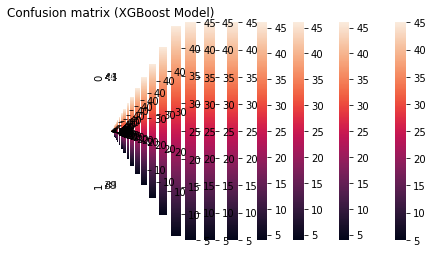

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import optuna
import shap
import xgboost as xgb

# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50


for i in range(n_iterations):
    # Step 2: Initial sampling
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])

    # Test data
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # Train data
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train = remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    # Modelling 
    # Creating and running our optimization
    study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")
    with parallel_backend('threading'):
        study_xgb.optimize(objective_xgb, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_xgb.best_trial.number)
    print("Best accuracy:", study_xgb.best_trial.value)
    print("Best hyperparameters:", study_xgb.best_params)

    # Train the best model
    best_param_xgb = study_xgb.best_params
    XGB = xgb.XGBClassifier(**best_param_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    XGB.fit(x_train_, y_train)
    y_pred_xgb = XGB.predict(x_test_)

    # Display results
    display_results(y_test, y_pred_xgb, cm_title="Confusion matrix (XGBoost Model)")

    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(XGB)
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 1 (assuming binary classification)
    shap_values_array = abs(shap_values)  # Use index 1 for the minority class

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

In [33]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [34]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('50_xg_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.741605,0.319920,0.939294,0.425166,0.773660,0.492847,0.396828,0.353247,0.555321
1,0.915161,0.245944,0.765265,0.573570,0.213093,0.339083,0.630682,0.486347,0.521143
2,0.811578,0.278243,0.688022,0.436253,0.537402,0.352985,0.623764,0.349905,0.509769
3,0.929654,0.369306,0.681747,0.393790,0.223215,0.376815,0.407099,0.336358,0.464748
4,0.666074,0.318472,0.662082,0.412937,0.355331,0.392916,0.414810,0.514878,0.467188
...,...,...,...,...,...,...,...,...,...
95,0.644588,0.362744,0.500127,0.442568,0.673818,0.412366,0.574212,0.385627,0.499506
96,0.798121,0.239363,0.653694,0.982914,0.228584,0.294088,0.823462,0.343424,0.545456
97,0.672367,0.259537,0.980503,0.663450,0.289811,0.767190,0.706623,0.277387,0.577109
98,0.629110,0.480143,0.614559,0.516589,0.195174,0.878617,0.551104,0.303483,0.521097
